In [1]:
import scikitplot as skplt
from sklearn.metrics import mean_squared_error
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow_addons as tfa
from keras import backend as K
import tensorflow as tf

2023-08-01 14:07:23.637410: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-01 14:07:23.637440: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from tqdm.keras import TqdmCallback
from tqdm.auto import tqdm
from collections import defaultdict
import pandas as pd
import numpy as np

/home/daria_gole/.conda/envs/mltle/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import sys

sys.path.append("../../../../") # very beautiful syntax

import mltle as mlt


2023-08-01 14:07:32.528363: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-08-01 14:07:32.528455: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-08-01 14:07:32.529002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the PyTorc

Done.


In [4]:
SEED = 7

NUM_RES_BLOCKS = 1
GRAPH_DEPTH = 5
GRAPH_FEATURES = 'g78'
GRAPH_TYPE = 'gin_eps0'
NORMALIZE = False
NORMALIZATION_TYPE = ''
NUM_EPOCHS = 1000
DISCOUNT = 0.9
BATCH_SIZE = 1024

data_path = '../../data/data_pKd/'
data_type = 'pKd'
model_name = f'Res1GIN5_{data_type}'

In [5]:
tf.keras.backend.clear_session()
np.random.seed(SEED)
tf.random.set_seed(SEED)

model = mlt.graph_training.GraphModel(protein_emb_size=64, protein_alphabet_len=8006)

order = ['pKi', 'pIC50', 'pKd', 'pEC50', 'is_active', 'qed', 'pH']
loss_weights = [1.0] * len(order)

variables = {}
for var in order:
    variables[var] = K.variable(0.0)

LossCallback = mlt.training_utils.LossWithMemoryCallback(
    variables, discount=DISCOUNT, decay=0.8)

uselosses = defaultdict(lambda: mlt.training_utils.mse_loss_wrapper)
uselosses['is_active'] = 'binary_crossentropy'
uselosses['qed'] = 'binary_crossentropy'

for k, v in variables.items():
    if k not in uselosses.keys():
        uselosses[k] = uselosses[k](v)

usemetrics = {data_type: [tf.keras.metrics.mse, mlt.training_utils.cindex_score]}

activations = defaultdict(lambda: 'linear')
activations['is_active'] = 'sigmoid'
activations['qed'] = 'sigmoid'

initializer = tf.keras.initializers.VarianceScaling(scale=1., mode='fan_in', distribution='normal', seed=SEED)
optimizer = tfa.optimizers.Lookahead(tf.keras.optimizers.Nadam(), sync_period=3)

model = model.create_model(order=order,
                           activations=activations,
                           activation='relu',
                           pooling_mode='max',
                           num_res_blocks=NUM_RES_BLOCKS,
                           units_per_head=64,
                           units_per_layer=1024,
                           dropout_rate=0.3,
                           protein_kernel=(7, 7),
                           loss_weights=loss_weights,
                           usemetrics=usemetrics,
                           uselosses=uselosses,
                           initializer=initializer,
                           optimizer=optimizer,
                           protein_strides_down=1,
                           graph_depth=GRAPH_DEPTH,
                           num_graph_features=78,
                           graph_type=GRAPH_TYPE)

Done. Total trainable params: 2290857


In [6]:
X_train = pd.read_csv(data_path + f"data_human_agg05_{data_type}_train.csv")[['smiles', 'target'] + order]
X_valid = pd.read_csv(data_path + f"data_human_agg05_{data_type}_valid.csv")[['smiles', 'target'] + order]
X_test = pd.read_csv(data_path + f"data_human_agg05_{data_type}_test.csv")[['smiles', 'target'] + order]
X_train.head(2)

,smiles,target,pKi,pIC50,pKd,pEC50,is_active,qed,pH
0,CCN1CCN(Cc2ccc(NC(=O)Nc3ccc(Oc4cc(NC)ncn4)cc3)...,MPHPRRYHSSERGSRGSYREHYRSRKHKRRRSRSWSSSSDRTRRRR...,NaN,NaN,5.744703,NaN,0.0,0.373344,NaN
1,NC(=NCC(F)(F)CC([NH3+])C(=O)[O-])NO,MACPWKFLFKTKFHQYAMNGEKDINNNVEKAPCATSSPVTQDDLQY...,NaN,NaN,3.935542,NaN,0.0,0.220408,NaN


In [7]:
mapseq = mlt.datamap.MapSeq(drug_mode=GRAPH_FEATURES,
                            protein_mode='protein_3',
                            max_drug_len=100,
                            max_protein_len=1000,
                            graph_normalize=NORMALIZE,
                            graph_normalization_type=NORMALIZATION_TYPE)

drug_seqs = np.hstack((X_train['smiles'].unique(), X_valid['smiles'].unique(), X_test['smiles'].unique()))
protein_seqs = np.hstack((X_train['target'].unique(), X_valid['target'].unique(), X_test['target'].unique()))

# protein_embeddings = mlt.train.get_embeddings(protein_seqs).numpy()


map_drug, map_protein = mapseq.create_maps(drug_seqs=drug_seqs,
                                           protein_seqs=protein_seqs)


  0%|          | 0/10362 [00:00<?, ?it/s]

100%|██████████| 10362/10362 [00:19<00:00, 522.51it/s]


In [8]:

first_key = next(iter(map_protein))
print(map_protein[first_key])

print(map_protein)

tf.Tensor(
[ 0.03056022  0.02434654  0.13633643 ... -0.08684243 -0.11447229
 -0.01298996], shape=(1024,), dtype=float32)
{'MPHPRRYHSSERGSRGSYREHYRSRKHKRRRSRSWSSSSDRTRRRRREDSYHVRSRSSYDDRSSDRRVYDRRYCGSYRRNDYSRDRGDAYYDTDYRHSYEYQRENSSYRSQRSSRRKHRRRRRRSRTFSRSSSQHSSRRAKSVEDDAEGHLIYHVGDWLQERYEIVSTLGEGTFGRVVQCVDHRRGGARVALKIIKNVEKYKEAARLEINVLEKINEKDPDNKNLCVQMFDWFDYHGHMCISFELLGLSTFDFLKDNNYLPYPIHQVRHMAFQLCQAVKFLHDNKLTHTDLKPENILFVNSDYELTYNLEKKRDERSVKSTAVRVVDFGSATFDHEHHSTIVSTRHYRAPEVILELGWSQPCDVWSIGCIIFEYYVGFTLFQTHDNREHLAMMERILGPIPSRMIRKTRKQKYFYRGRLDWDENTSAGRYVRENCKPLRRYLTSEAEEHHQLFDLIESMLEYEPAKRLTLGEALQHPFFARLRAEPPNKLWDSSRDISR': <tf.Tensor: shape=(1024,), dtype=float32, numpy=
array([ 0.03056022,  0.02434654,  0.13633643, ..., -0.08684243,
       -0.11447229, -0.01298996], dtype=float32)>, 'MACPWKFLFKTKFHQYAMNGEKDINNNVEKAPCATSSPVTQDDLQYHNLSKQQNESPQPLVETGKKSPESLVKLDATPLSSPRHVRIKNWGSGMTFQDTLHHKAKGILTCRSKSCLGSIMTPKSLTRGPRDKPTPPDELLPQAIEFVNQYYGSFKEAKIEEHLARVEAVTKEIETTGTYQLTGDELIFATKQAWRNAPRCIGRIQWSNLQ

In [9]:
batch_size = BATCH_SIZE

train_gen = mlt.datagen.DataGen(X_train, map_drug, map_protein, drug_graph_mode=True)
train_gen = train_gen.get_generator(batch_size)

valid_gen = mlt.datagen.DataGen(X_valid, map_drug, map_protein, drug_graph_mode=True, shuffle=False)
valid_gen = valid_gen.get_generator(batch_size)

In [10]:
steps_per_epoch = X_train.shape[0] // batch_size
valid_steps = X_valid.shape[0] // batch_size

In [11]:
best_model_path = f"Best_{model_name}.h5"
CheckPointCallback = tf.keras.callbacks.ModelCheckpoint(best_model_path,
                                                        monitor=f'val_{data_type}_mean_squared_error',
                                                        verbose=1,
                                                        save_best_only=True,
                                                        mode='auto',
                                                        save_weights_only=True)

CSVLoggerCallback = tf.keras.callbacks.CSVLogger(f"{model_name}.log")

In [12]:
history = model.fit(train_gen,
                    validation_data=valid_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=valid_steps,
                    verbose=0,
                    callbacks=[TqdmCallback(), CheckPointCallback,
                               LossCallback, CSVLoggerCallback],
                    epochs=NUM_EPOCHS
                    )

  0%|          | 1/1000 [00:27<7:36:27, 27.42s/epoch, loss=36.4, pKi_loss=0.107, pIC50_loss=0.294, pKd_loss=27, pEC50_loss=0.0107, is_active_loss=0.718, qed_loss=0.691, pH_loss=7.61, pKd_mean_squared_error=27, pKd_cindex_score=0.489, val_loss=29.2, val_pKi_loss=0.0937, val_pIC50_loss=0.4, val_pKd_loss=17.3, val_pEC50_loss=0.0185, val_is_active_loss=0.677, val_qed_loss=0.7, val_pH_loss=10, val_pKd_mean_squared_error=17.3, val_pKd_cindex_score=0.515]


Epoch 1: val_pKd_mean_squared_error improved from inf to 17.25270, saving model to Best_Res1GIN5_pKd.h5


  0%|          | 2/1000 [00:51<7:08:05, 25.74s/epoch, loss=15, pKi_loss=0.106, pIC50_loss=0.289, pKd_loss=7.01, pEC50_loss=0.00405, is_active_loss=0.675, qed_loss=0.67, pH_loss=6.29, pKd_mean_squared_error=7.01, pKd_cindex_score=0.522, val_loss=39.3, val_pKi_loss=0.0609, val_pIC50_loss=0.298, val_pKd_loss=31.3, val_pEC50_loss=0.0297, val_is_active_loss=0.682, val_qed_loss=0.687, val_pH_loss=6.18, val_pKd_mean_squared_error=31.3, val_pKd_cindex_score=0.504]


Epoch 2: val_pKd_mean_squared_error did not improve from 17.25270


  0%|          | 3/1000 [01:16<6:55:56, 25.03s/epoch, loss=7.07, pKi_loss=0.0634, pIC50_loss=0.213, pKd_loss=2.78, pEC50_loss=0.0224, is_active_loss=0.659, qed_loss=0.659, pH_loss=2.67, pKd_mean_squared_error=2.78, pKd_cindex_score=0.561, val_loss=39.3, val_pKi_loss=0.026, val_pIC50_loss=0.241, val_pKd_loss=34, val_pEC50_loss=0.0257, val_is_active_loss=0.666, val_qed_loss=0.683, val_pH_loss=3.69, val_pKd_mean_squared_error=34, val_pKd_cindex_score=0.513]  


Epoch 3: val_pKd_mean_squared_error did not improve from 17.25270


  0%|          | 4/1000 [01:40<6:49:45, 24.68s/epoch, loss=4.48, pKi_loss=0.0316, pIC50_loss=0.104, pKd_loss=2.28, pEC50_loss=0.0278, is_active_loss=0.666, qed_loss=0.656, pH_loss=0.719, pKd_mean_squared_error=2.28, pKd_cindex_score=0.574, val_loss=40.9, val_pKi_loss=0.0115, val_pIC50_loss=0.183, val_pKd_loss=36.1, val_pEC50_loss=0.0332, val_is_active_loss=0.68, val_qed_loss=0.681, val_pH_loss=3.27, val_pKd_mean_squared_error=36.1, val_pKd_cindex_score=0.521]


Epoch 4: val_pKd_mean_squared_error did not improve from 17.25270


  0%|          | 5/1000 [02:04<6:43:56, 24.36s/epoch, loss=4.23, pKi_loss=0.0122, pIC50_loss=0.0229, pKd_loss=2.64, pEC50_loss=0.00133, is_active_loss=0.66, qed_loss=0.657, pH_loss=0.236, pKd_mean_squared_error=2.64, pKd_cindex_score=0.568, val_loss=43.2, val_pKi_loss=0.00432, val_pIC50_loss=0.144, val_pKd_loss=38.2, val_pEC50_loss=0.0275, val_is_active_loss=0.688, val_qed_loss=0.679, val_pH_loss=3.41, val_pKd_mean_squared_error=38.2, val_pKd_cindex_score=0.518]


Epoch 5: val_pKd_mean_squared_error did not improve from 17.25270


  1%|          | 6/1000 [02:28<6:41:42, 24.25s/epoch, loss=3.55, pKi_loss=0.00714, pIC50_loss=0.0601, pKd_loss=2.03, pEC50_loss=0.013, is_active_loss=0.645, qed_loss=0.652, pH_loss=0.145, pKd_mean_squared_error=2.03, pKd_cindex_score=0.604, val_loss=43.8, val_pKi_loss=0.00487, val_pIC50_loss=0.147, val_pKd_loss=38.7, val_pEC50_loss=0.0282, val_is_active_loss=0.695, val_qed_loss=0.687, val_pH_loss=3.47, val_pKd_mean_squared_error=38.7, val_pKd_cindex_score=0.505]


Epoch 6: val_pKd_mean_squared_error did not improve from 17.25270


  1%|          | 7/1000 [02:51<6:37:42, 24.03s/epoch, loss=3.4, pKi_loss=0.00446, pIC50_loss=0.0206, pKd_loss=2, pEC50_loss=0.00193, is_active_loss=0.645, qed_loss=0.647, pH_loss=0.0817, pKd_mean_squared_error=2, pKd_cindex_score=0.605, val_loss=43.1, val_pKi_loss=0.00396, val_pIC50_loss=0.131, val_pKd_loss=38.3, val_pEC50_loss=0.0274, val_is_active_loss=0.708, val_qed_loss=0.698, val_pH_loss=3.22, val_pKd_mean_squared_error=38.3, val_pKd_cindex_score=0.491]    


Epoch 7: val_pKd_mean_squared_error did not improve from 17.25270


  1%|          | 8/1000 [03:15<6:37:35, 24.05s/epoch, loss=3.29, pKi_loss=0.00621, pIC50_loss=0.00642, pKd_loss=1.94, pEC50_loss=1.94e-5, is_active_loss=0.636, qed_loss=0.643, pH_loss=0.0622, pKd_mean_squared_error=1.94, pKd_cindex_score=0.616, val_loss=41.9, val_pKi_loss=0.0035, val_pIC50_loss=0.132, val_pKd_loss=37.3, val_pEC50_loss=0.0274, val_is_active_loss=0.715, val_qed_loss=0.706, val_pH_loss=3.02, val_pKd_mean_squared_error=37.3, val_pKd_cindex_score=0.483]


Epoch 8: val_pKd_mean_squared_error did not improve from 17.25270


  1%|          | 9/1000 [03:39<6:37:47, 24.08s/epoch, loss=3.23, pKi_loss=0.00278, pIC50_loss=0.0124, pKd_loss=1.87, pEC50_loss=0.00184, is_active_loss=0.639, qed_loss=0.646, pH_loss=0.0608, pKd_mean_squared_error=1.87, pKd_cindex_score=0.628, val_loss=41, val_pKi_loss=0.00328, val_pIC50_loss=0.131, val_pKd_loss=36.5, val_pEC50_loss=0.0276, val_is_active_loss=0.724, val_qed_loss=0.712, val_pH_loss=2.9, val_pKd_mean_squared_error=36.5, val_pKd_cindex_score=0.486]   


Epoch 9: val_pKd_mean_squared_error did not improve from 17.25270


  1%|          | 10/1000 [04:04<6:37:32, 24.09s/epoch, loss=3.39, pKi_loss=0.0014, pIC50_loss=0.00326, pKd_loss=2.05, pEC50_loss=7.23e-6, is_active_loss=0.638, qed_loss=0.638, pH_loss=0.0676, pKd_mean_squared_error=2.05, pKd_cindex_score=0.616, val_loss=39.4, val_pKi_loss=0.00126, val_pIC50_loss=0.108, val_pKd_loss=35, val_pEC50_loss=0.0275, val_is_active_loss=0.744, val_qed_loss=0.719, val_pH_loss=2.81, val_pKd_mean_squared_error=35, val_pKd_cindex_score=0.484]


Epoch 10: val_pKd_mean_squared_error did not improve from 17.25270


  1%|          | 11/1000 [04:27<6:34:20, 23.92s/epoch, loss=3.51, pKi_loss=0.0023, pIC50_loss=0.00523, pKd_loss=2.18, pEC50_loss=0.000361, is_active_loss=0.63, qed_loss=0.642, pH_loss=0.0474, pKd_mean_squared_error=2.18, pKd_cindex_score=0.597, val_loss=40.3, val_pKi_loss=0.00346, val_pIC50_loss=0.137, val_pKd_loss=35.9, val_pEC50_loss=0.0274, val_is_active_loss=0.776, val_qed_loss=0.72, val_pH_loss=2.77, val_pKd_mean_squared_error=35.9, val_pKd_cindex_score=0.492]


Epoch 11: val_pKd_mean_squared_error did not improve from 17.25270


  1%|          | 12/1000 [04:50<6:30:23, 23.71s/epoch, loss=3.19, pKi_loss=0.00149, pIC50_loss=0.00274, pKd_loss=1.87, pEC50_loss=5.69e-7, is_active_loss=0.629, qed_loss=0.642, pH_loss=0.0456, pKd_mean_squared_error=1.87, pKd_cindex_score=0.631, val_loss=40.4, val_pKi_loss=0.0035, val_pIC50_loss=0.133, val_pKd_loss=35.8, val_pEC50_loss=0.0161, val_is_active_loss=0.809, val_qed_loss=0.727, val_pH_loss=2.84, val_pKd_mean_squared_error=35.8, val_pKd_cindex_score=0.491]


Epoch 12: val_pKd_mean_squared_error did not improve from 17.25270


  1%|▏         | 13/1000 [05:14<6:29:06, 23.65s/epoch, loss=3.08, pKi_loss=0.00205, pIC50_loss=0.00184, pKd_loss=1.76, pEC50_loss=0.000113, is_active_loss=0.618, qed_loss=0.639, pH_loss=0.0531, pKd_mean_squared_error=1.76, pKd_cindex_score=0.637, val_loss=40.5, val_pKi_loss=0.00375, val_pIC50_loss=0.13, val_pKd_loss=35.8, val_pEC50_loss=0.0273, val_is_active_loss=0.862, val_qed_loss=0.74, val_pH_loss=2.91, val_pKd_mean_squared_error=35.8, val_pKd_cindex_score=0.494]


Epoch 13: val_pKd_mean_squared_error did not improve from 17.25270


  1%|▏         | 14/1000 [05:37<6:27:38, 23.59s/epoch, loss=3.07, pKi_loss=0.000349, pIC50_loss=0.00254, pKd_loss=1.76, pEC50_loss=2.06e-7, is_active_loss=0.616, qed_loss=0.639, pH_loss=0.0546, pKd_mean_squared_error=1.76, pKd_cindex_score=0.644, val_loss=41.2, val_pKi_loss=0.00378, val_pIC50_loss=0.133, val_pKd_loss=36.3, val_pEC50_loss=0.0271, val_is_active_loss=0.94, val_qed_loss=0.756, val_pH_loss=3.05, val_pKd_mean_squared_error=36.3, val_pKd_cindex_score=0.507]


Epoch 14: val_pKd_mean_squared_error did not improve from 17.25270


  2%|▏         | 15/1000 [06:01<6:27:13, 23.59s/epoch, loss=3.2, pKi_loss=0.00213, pIC50_loss=0.0023, pKd_loss=1.89, pEC50_loss=0.000589, is_active_loss=0.616, qed_loss=0.639, pH_loss=0.0508, pKd_mean_squared_error=1.89, pKd_cindex_score=0.636, val_loss=39.8, val_pKi_loss=0.00378, val_pIC50_loss=0.147, val_pKd_loss=34.8, val_pEC50_loss=0.0182, val_is_active_loss=0.962, val_qed_loss=0.777, val_pH_loss=3.13, val_pKd_mean_squared_error=34.8, val_pKd_cindex_score=0.508] 


Epoch 15: val_pKd_mean_squared_error did not improve from 17.25270


  2%|▏         | 16/1000 [06:25<6:27:33, 23.63s/epoch, loss=3.19, pKi_loss=0.00302, pIC50_loss=0.00439, pKd_loss=1.89, pEC50_loss=0.000129, is_active_loss=0.616, qed_loss=0.636, pH_loss=0.0386, pKd_mean_squared_error=1.89, pKd_cindex_score=0.631, val_loss=40.5, val_pKi_loss=0.00249, val_pIC50_loss=0.152, val_pKd_loss=35.2, val_pEC50_loss=0.0269, val_is_active_loss=1.06, val_qed_loss=0.791, val_pH_loss=3.28, val_pKd_mean_squared_error=35.2, val_pKd_cindex_score=0.518]


Epoch 16: val_pKd_mean_squared_error did not improve from 17.25270


  2%|▏         | 17/1000 [06:49<6:28:46, 23.73s/epoch, loss=2.96, pKi_loss=0.001, pIC50_loss=0.00179, pKd_loss=1.68, pEC50_loss=0.00107, is_active_loss=0.602, qed_loss=0.636, pH_loss=0.0359, pKd_mean_squared_error=1.68, pKd_cindex_score=0.651, val_loss=40.6, val_pKi_loss=0.00396, val_pIC50_loss=0.159, val_pKd_loss=35.1, val_pEC50_loss=0.0268, val_is_active_loss=1.16, val_qed_loss=0.8, val_pH_loss=3.35, val_pKd_mean_squared_error=35.1, val_pKd_cindex_score=0.522]     


Epoch 17: val_pKd_mean_squared_error did not improve from 17.25270


  2%|▏         | 18/1000 [07:13<6:30:51, 23.88s/epoch, loss=2.96, pKi_loss=0.00161, pIC50_loss=0.00209, pKd_loss=1.69, pEC50_loss=1.14e-7, is_active_loss=0.603, qed_loss=0.633, pH_loss=0.0344, pKd_mean_squared_error=1.69, pKd_cindex_score=0.65, val_loss=41.2, val_pKi_loss=0.0043, val_pIC50_loss=0.18, val_pKd_loss=35.5, val_pEC50_loss=0.0267, val_is_active_loss=1.28, val_qed_loss=0.803, val_pH_loss=3.37, val_pKd_mean_squared_error=35.5, val_pKd_cindex_score=0.527]


Epoch 18: val_pKd_mean_squared_error did not improve from 17.25270


  2%|▏         | 19/1000 [07:37<6:33:30, 24.07s/epoch, loss=3.23, pKi_loss=0.000626, pIC50_loss=0.00196, pKd_loss=1.94, pEC50_loss=0.00214, is_active_loss=0.61, qed_loss=0.638, pH_loss=0.0371, pKd_mean_squared_error=1.94, pKd_cindex_score=0.635, val_loss=39.9, val_pKi_loss=0.0047, val_pIC50_loss=0.17, val_pKd_loss=34, val_pEC50_loss=0.0265, val_is_active_loss=1.35, val_qed_loss=0.813, val_pH_loss=3.52, val_pKd_mean_squared_error=34, val_pKd_cindex_score=0.526]   


Epoch 19: val_pKd_mean_squared_error did not improve from 17.25270


  2%|▏         | 20/1000 [08:01<6:33:35, 24.10s/epoch, loss=2.9, pKi_loss=0.00137, pIC50_loss=0.00181, pKd_loss=1.64, pEC50_loss=0.00113, is_active_loss=0.589, qed_loss=0.632, pH_loss=0.0378, pKd_mean_squared_error=1.64, pKd_cindex_score=0.663, val_loss=40, val_pKi_loss=0.00483, val_pIC50_loss=0.195, val_pKd_loss=34, val_pEC50_loss=0.026, val_is_active_loss=1.49, val_qed_loss=0.812, val_pH_loss=3.54, val_pKd_mean_squared_error=34, val_pKd_cindex_score=0.526]  


Epoch 20: val_pKd_mean_squared_error did not improve from 17.25270


  2%|▏         | 21/1000 [08:26<6:34:46, 24.19s/epoch, loss=3.01, pKi_loss=0.00195, pIC50_loss=0.00197, pKd_loss=1.73, pEC50_loss=3.17e-8, is_active_loss=0.6, qed_loss=0.633, pH_loss=0.0426, pKd_mean_squared_error=1.73, pKd_cindex_score=0.652, val_loss=40, val_pKi_loss=0.00225, val_pIC50_loss=0.203, val_pKd_loss=33.7, val_pEC50_loss=0.0257, val_is_active_loss=1.68, val_qed_loss=0.806, val_pH_loss=3.55, val_pKd_mean_squared_error=33.7, val_pKd_cindex_score=0.53]


Epoch 21: val_pKd_mean_squared_error did not improve from 17.25270


  2%|▏         | 22/1000 [08:50<6:33:59, 24.17s/epoch, loss=2.86, pKi_loss=0.000406, pIC50_loss=0.00181, pKd_loss=1.6, pEC50_loss=0.000905, is_active_loss=0.59, qed_loss=0.632, pH_loss=0.0341, pKd_mean_squared_error=1.6, pKd_cindex_score=0.663, val_loss=39.5, val_pKi_loss=0.00543, val_pIC50_loss=0.158, val_pKd_loss=33.1, val_pEC50_loss=0.0257, val_is_active_loss=1.87, val_qed_loss=0.79, val_pH_loss=3.55, val_pKd_mean_squared_error=33.1, val_pKd_cindex_score=0.534]


Epoch 22: val_pKd_mean_squared_error did not improve from 17.25270


  2%|▏         | 23/1000 [09:15<6:35:59, 24.32s/epoch, loss=2.85, pKi_loss=0.00102, pIC50_loss=0.00199, pKd_loss=1.59, pEC50_loss=0.000458, is_active_loss=0.591, qed_loss=0.632, pH_loss=0.0317, pKd_mean_squared_error=1.59, pKd_cindex_score=0.667, val_loss=38.2, val_pKi_loss=0.00567, val_pIC50_loss=0.202, val_pKd_loss=31.8, val_pEC50_loss=0.0253, val_is_active_loss=1.88, val_qed_loss=0.769, val_pH_loss=3.51, val_pKd_mean_squared_error=31.8, val_pKd_cindex_score=0.535]


Epoch 23: val_pKd_mean_squared_error did not improve from 17.25270


  2%|▏         | 24/1000 [09:39<6:33:55, 24.22s/epoch, loss=2.94, pKi_loss=0.00133, pIC50_loss=0.00198, pKd_loss=1.66, pEC50_loss=3.36e-9, is_active_loss=0.592, qed_loss=0.63, pH_loss=0.0516, pKd_mean_squared_error=1.66, pKd_cindex_score=0.665, val_loss=36.9, val_pKi_loss=0.0056, val_pIC50_loss=0.215, val_pKd_loss=30.2, val_pEC50_loss=0.00817, val_is_active_loss=2.08, val_qed_loss=0.762, val_pH_loss=3.59, val_pKd_mean_squared_error=30.2, val_pKd_cindex_score=0.535]  


Epoch 24: val_pKd_mean_squared_error did not improve from 17.25270


  2%|▎         | 25/1000 [10:03<6:32:46, 24.17s/epoch, loss=2.77, pKi_loss=0.00202, pIC50_loss=0.00194, pKd_loss=1.52, pEC50_loss=0.000995, is_active_loss=0.588, qed_loss=0.63, pH_loss=0.0262, pKd_mean_squared_error=1.52, pKd_cindex_score=0.672, val_loss=37.1, val_pKi_loss=0.00571, val_pIC50_loss=0.208, val_pKd_loss=30.1, val_pEC50_loss=0.0242, val_is_active_loss=2.35, val_qed_loss=0.747, val_pH_loss=3.59, val_pKd_mean_squared_error=30.1, val_pKd_cindex_score=0.539]


Epoch 25: val_pKd_mean_squared_error did not improve from 17.25270


  3%|▎         | 26/1000 [10:27<6:34:26, 24.30s/epoch, loss=3.02, pKi_loss=0.00262, pIC50_loss=0.00158, pKd_loss=1.77, pEC50_loss=0.000165, is_active_loss=0.576, qed_loss=0.632, pH_loss=0.0379, pKd_mean_squared_error=1.77, pKd_cindex_score=0.655, val_loss=35, val_pKi_loss=0.00575, val_pIC50_loss=0.231, val_pKd_loss=27.8, val_pEC50_loss=0.0161, val_is_active_loss=2.65, val_qed_loss=0.724, val_pH_loss=3.57, val_pKd_mean_squared_error=27.8, val_pKd_cindex_score=0.536] 


Epoch 26: val_pKd_mean_squared_error did not improve from 17.25270


  3%|▎         | 27/1000 [10:51<6:32:44, 24.22s/epoch, loss=2.81, pKi_loss=0.00127, pIC50_loss=0.00403, pKd_loss=1.57, pEC50_loss=3.18e-10, is_active_loss=0.583, qed_loss=0.627, pH_loss=0.0345, pKd_mean_squared_error=1.57, pKd_cindex_score=0.675, val_loss=33.7, val_pKi_loss=0.00532, val_pIC50_loss=0.242, val_pKd_loss=26.2, val_pEC50_loss=0.0235, val_is_active_loss=2.92, val_qed_loss=0.7, val_pH_loss=3.63, val_pKd_mean_squared_error=26.2, val_pKd_cindex_score=0.539]


Epoch 27: val_pKd_mean_squared_error did not improve from 17.25270


  3%|▎         | 28/1000 [11:16<6:32:56, 24.26s/epoch, loss=2.81, pKi_loss=0.000975, pIC50_loss=0.00193, pKd_loss=1.57, pEC50_loss=0.000103, is_active_loss=0.575, qed_loss=0.628, pH_loss=0.0294, pKd_mean_squared_error=1.57, pKd_cindex_score=0.673, val_loss=31.8, val_pKi_loss=0.00294, val_pIC50_loss=0.239, val_pKd_loss=24.1, val_pEC50_loss=0.0227, val_is_active_loss=3.06, val_qed_loss=0.688, val_pH_loss=3.69, val_pKd_mean_squared_error=24.1, val_pKd_cindex_score=0.539]


Epoch 28: val_pKd_mean_squared_error did not improve from 17.25270


  3%|▎         | 29/1000 [11:40<6:30:20, 24.12s/epoch, loss=2.74, pKi_loss=0.0022, pIC50_loss=0.00289, pKd_loss=1.51, pEC50_loss=6.82e-5, is_active_loss=0.575, qed_loss=0.628, pH_loss=0.0263, pKd_mean_squared_error=1.51, pKd_cindex_score=0.68, val_loss=29.3, val_pKi_loss=0.00514, val_pIC50_loss=0.283, val_pKd_loss=21.3, val_pEC50_loss=0.0219, val_is_active_loss=3.37, val_qed_loss=0.69, val_pH_loss=3.69, val_pKd_mean_squared_error=21.3, val_pKd_cindex_score=0.533]     


Epoch 29: val_pKd_mean_squared_error did not improve from 17.25270


  3%|▎         | 30/1000 [12:03<6:28:02, 24.00s/epoch, loss=2.9, pKi_loss=0.00118, pIC50_loss=0.00232, pKd_loss=1.66, pEC50_loss=3.45e-11, is_active_loss=0.575, qed_loss=0.628, pH_loss=0.0333, pKd_mean_squared_error=1.66, pKd_cindex_score=0.67, val_loss=27.2, val_pKi_loss=0.00502, val_pIC50_loss=0.283, val_pKd_loss=19.1, val_pEC50_loss=0.0216, val_is_active_loss=3.53, val_qed_loss=0.691, val_pH_loss=3.57, val_pKd_mean_squared_error=19.1, val_pKd_cindex_score=0.53]


Epoch 30: val_pKd_mean_squared_error did not improve from 17.25270


  3%|▎         | 31/1000 [12:27<6:28:21, 24.05s/epoch, loss=2.8, pKi_loss=0.00144, pIC50_loss=0.00135, pKd_loss=1.56, pEC50_loss=2.58e-5, is_active_loss=0.572, qed_loss=0.627, pH_loss=0.0374, pKd_mean_squared_error=1.56, pKd_cindex_score=0.673, val_loss=22.8, val_pKi_loss=0.0044, val_pIC50_loss=0.283, val_pKd_loss=15.1, val_pEC50_loss=0.0208, val_is_active_loss=3.43, val_qed_loss=0.703, val_pH_loss=3.3, val_pKd_mean_squared_error=15.1, val_pKd_cindex_score=0.531] 


Epoch 31: val_pKd_mean_squared_error improved from 17.25270 to 15.08734, saving model to Best_Res1GIN5_pKd.h5


  3%|▎         | 32/1000 [12:51<6:27:05, 23.99s/epoch, loss=2.75, pKi_loss=0.000605, pIC50_loss=0.0024, pKd_loss=1.51, pEC50_loss=6.81e-5, is_active_loss=0.575, qed_loss=0.627, pH_loss=0.0324, pKd_mean_squared_error=1.51, pKd_cindex_score=0.681, val_loss=22.3, val_pKi_loss=0.00432, val_pIC50_loss=0.313, val_pKd_loss=14.3, val_pEC50_loss=0.02, val_is_active_loss=3.63, val_qed_loss=0.717, val_pH_loss=3.3, val_pKd_mean_squared_error=14.3, val_pKd_cindex_score=0.534]


Epoch 32: val_pKd_mean_squared_error improved from 15.08734 to 14.31368, saving model to Best_Res1GIN5_pKd.h5


  3%|▎         | 33/1000 [13:15<6:26:25, 23.98s/epoch, loss=2.87, pKi_loss=0.000452, pIC50_loss=0.00181, pKd_loss=1.64, pEC50_loss=0.000208, is_active_loss=0.568, qed_loss=0.625, pH_loss=0.0314, pKd_mean_squared_error=1.64, pKd_cindex_score=0.673, val_loss=20.4, val_pKi_loss=0.00185, val_pIC50_loss=0.275, val_pKd_loss=12.2, val_pEC50_loss=0.0194, val_is_active_loss=3.77, val_qed_loss=0.775, val_pH_loss=3.43, val_pKd_mean_squared_error=12.2, val_pKd_cindex_score=0.536]


Epoch 33: val_pKd_mean_squared_error improved from 14.31368 to 12.15845, saving model to Best_Res1GIN5_pKd.h5


  3%|▎         | 34/1000 [13:39<6:27:24, 24.06s/epoch, loss=2.68, pKi_loss=0.00185, pIC50_loss=0.00306, pKd_loss=1.45, pEC50_loss=8.96e-6, is_active_loss=0.567, qed_loss=0.626, pH_loss=0.0307, pKd_mean_squared_error=1.45, pKd_cindex_score=0.684, val_loss=20.3, val_pKi_loss=0.00423, val_pIC50_loss=0.333, val_pKd_loss=11.6, val_pEC50_loss=0.0187, val_is_active_loss=4.14, val_qed_loss=0.828, val_pH_loss=3.38, val_pKd_mean_squared_error=11.6, val_pKd_cindex_score=0.534]  


Epoch 34: val_pKd_mean_squared_error improved from 12.15845 to 11.61737, saving model to Best_Res1GIN5_pKd.h5


  4%|▎         | 35/1000 [14:04<6:27:31, 24.09s/epoch, loss=2.68, pKi_loss=0.00116, pIC50_loss=0.00135, pKd_loss=1.46, pEC50_loss=0.000108, is_active_loss=0.558, qed_loss=0.623, pH_loss=0.0313, pKd_mean_squared_error=1.46, pKd_cindex_score=0.689, val_loss=19.1, val_pKi_loss=0.00442, val_pIC50_loss=0.321, val_pKd_loss=10.2, val_pEC50_loss=0.019, val_is_active_loss=4.54, val_qed_loss=0.85, val_pH_loss=3.18, val_pKd_mean_squared_error=10.2, val_pKd_cindex_score=0.531] 


Epoch 35: val_pKd_mean_squared_error improved from 11.61737 to 10.20429, saving model to Best_Res1GIN5_pKd.h5


  4%|▎         | 36/1000 [14:28<6:27:57, 24.15s/epoch, loss=2.65, pKi_loss=0.00168, pIC50_loss=0.00432, pKd_loss=1.43, pEC50_loss=0.000233, is_active_loss=0.562, qed_loss=0.627, pH_loss=0.0252, pKd_mean_squared_error=1.43, pKd_cindex_score=0.693, val_loss=18.9, val_pKi_loss=0.00476, val_pIC50_loss=0.372, val_pKd_loss=9.74, val_pEC50_loss=0.0147, val_is_active_loss=4.88, val_qed_loss=0.892, val_pH_loss=3.04, val_pKd_mean_squared_error=9.74, val_pKd_cindex_score=0.531]


Epoch 36: val_pKd_mean_squared_error improved from 10.20429 to 9.73530, saving model to Best_Res1GIN5_pKd.h5


  4%|▎         | 37/1000 [14:52<6:28:51, 24.23s/epoch, loss=2.68, pKi_loss=0.00145, pIC50_loss=0.00135, pKd_loss=1.47, pEC50_loss=5.18e-12, is_active_loss=0.557, qed_loss=0.625, pH_loss=0.0274, pKd_mean_squared_error=1.47, pKd_cindex_score=0.685, val_loss=17.1, val_pKi_loss=0.00473, val_pIC50_loss=0.361, val_pKd_loss=7.97, val_pEC50_loss=0.0191, val_is_active_loss=4.72, val_qed_loss=0.944, val_pH_loss=3.04, val_pKd_mean_squared_error=7.97, val_pKd_cindex_score=0.536]


Epoch 37: val_pKd_mean_squared_error improved from 9.73530 to 7.97268, saving model to Best_Res1GIN5_pKd.h5


  4%|▍         | 38/1000 [15:17<6:29:00, 24.26s/epoch, loss=2.62, pKi_loss=0.00102, pIC50_loss=0.00139, pKd_loss=1.4, pEC50_loss=1.54e-5, is_active_loss=0.556, qed_loss=0.624, pH_loss=0.0307, pKd_mean_squared_error=1.4, pKd_cindex_score=0.695, val_loss=17.4, val_pKi_loss=0.0047, val_pIC50_loss=0.409, val_pKd_loss=7.78, val_pEC50_loss=0.0127, val_is_active_loss=5.27, val_qed_loss=0.955, val_pH_loss=2.96, val_pKd_mean_squared_error=7.78, val_pKd_cindex_score=0.537]    


Epoch 38: val_pKd_mean_squared_error improved from 7.97268 to 7.77668, saving model to Best_Res1GIN5_pKd.h5


  4%|▍         | 39/1000 [15:41<6:28:57, 24.28s/epoch, loss=2.68, pKi_loss=0.00012, pIC50_loss=0.00284, pKd_loss=1.47, pEC50_loss=3.41e-5, is_active_loss=0.557, qed_loss=0.623, pH_loss=0.0316, pKd_mean_squared_error=1.47, pKd_cindex_score=0.688, val_loss=16.6, val_pKi_loss=0.00489, val_pIC50_loss=0.428, val_pKd_loss=6.73, val_pEC50_loss=0.0188, val_is_active_loss=5.4, val_qed_loss=1, val_pH_loss=3, val_pKd_mean_squared_error=6.73, val_pKd_cindex_score=0.532]     


Epoch 39: val_pKd_mean_squared_error improved from 7.77668 to 6.73002, saving model to Best_Res1GIN5_pKd.h5


  4%|▍         | 40/1000 [16:05<6:28:50, 24.30s/epoch, loss=2.69, pKi_loss=0.000302, pIC50_loss=0.00182, pKd_loss=1.5, pEC50_loss=5.36e-6, is_active_loss=0.547, qed_loss=0.623, pH_loss=0.0204, pKd_mean_squared_error=1.5, pKd_cindex_score=0.694, val_loss=16.9, val_pKi_loss=0.00512, val_pIC50_loss=0.445, val_pKd_loss=6.59, val_pEC50_loss=0.0183, val_is_active_loss=5.84, val_qed_loss=1.05, val_pH_loss=2.95, val_pKd_mean_squared_error=6.59, val_pKd_cindex_score=0.531]


Epoch 40: val_pKd_mean_squared_error improved from 6.73002 to 6.59442, saving model to Best_Res1GIN5_pKd.h5


  4%|▍         | 41/1000 [16:29<6:27:45, 24.26s/epoch, loss=2.56, pKi_loss=0.00149, pIC50_loss=0.00307, pKd_loss=1.36, pEC50_loss=0.000197, is_active_loss=0.553, qed_loss=0.623, pH_loss=0.0228, pKd_mean_squared_error=1.36, pKd_cindex_score=0.701, val_loss=15.8, val_pKi_loss=0.00546, val_pIC50_loss=0.52, val_pKd_loss=5.34, val_pEC50_loss=0.0173, val_is_active_loss=5.93, val_qed_loss=1.01, val_pH_loss=2.97, val_pKd_mean_squared_error=5.34, val_pKd_cindex_score=0.53]


Epoch 41: val_pKd_mean_squared_error improved from 6.59442 to 5.34465, saving model to Best_Res1GIN5_pKd.h5


  4%|▍         | 42/1000 [16:53<6:26:02, 24.18s/epoch, loss=2.58, pKi_loss=0.00217, pIC50_loss=0.00194, pKd_loss=1.38, pEC50_loss=4.71e-13, is_active_loss=0.553, qed_loss=0.622, pH_loss=0.0216, pKd_mean_squared_error=1.38, pKd_cindex_score=0.697, val_loss=12.8, val_pKi_loss=0.00586, val_pIC50_loss=0.505, val_pKd_loss=3.02, val_pEC50_loss=0.0167, val_is_active_loss=5.47, val_qed_loss=1.03, val_pH_loss=2.71, val_pKd_mean_squared_error=3.02, val_pKd_cindex_score=0.536]


Epoch 42: val_pKd_mean_squared_error improved from 5.34465 to 3.01952, saving model to Best_Res1GIN5_pKd.h5


  4%|▍         | 43/1000 [17:18<6:26:30, 24.23s/epoch, loss=2.75, pKi_loss=0.00066, pIC50_loss=0.00232, pKd_loss=1.54, pEC50_loss=1.14e-5, is_active_loss=0.556, qed_loss=0.622, pH_loss=0.0239, pKd_mean_squared_error=1.54, pKd_cindex_score=0.685, val_loss=12.1, val_pKi_loss=0.00583, val_pIC50_loss=0.587, val_pKd_loss=2.31, val_pEC50_loss=0.0163, val_is_active_loss=5.7, val_qed_loss=1.12, val_pH_loss=2.32, val_pKd_mean_squared_error=2.31, val_pKd_cindex_score=0.537]  


Epoch 43: val_pKd_mean_squared_error improved from 3.01952 to 2.31410, saving model to Best_Res1GIN5_pKd.h5


  4%|▍         | 44/1000 [17:42<6:25:02, 24.17s/epoch, loss=2.68, pKi_loss=0.000706, pIC50_loss=0.00243, pKd_loss=1.47, pEC50_loss=0.000621, is_active_loss=0.554, qed_loss=0.621, pH_loss=0.0232, pKd_mean_squared_error=1.47, pKd_cindex_score=0.694, val_loss=11.4, val_pKi_loss=0.00229, val_pIC50_loss=0.628, val_pKd_loss=2.13, val_pEC50_loss=0.016, val_is_active_loss=5.23, val_qed_loss=1.18, val_pH_loss=2.22, val_pKd_mean_squared_error=2.13, val_pKd_cindex_score=0.535]


Epoch 44: val_pKd_mean_squared_error improved from 2.31410 to 2.12999, saving model to Best_Res1GIN5_pKd.h5


  4%|▍         | 45/1000 [18:06<6:25:29, 24.22s/epoch, loss=2.56, pKi_loss=0.000345, pIC50_loss=0.00105, pKd_loss=1.36, pEC50_loss=3.88e-13, is_active_loss=0.547, qed_loss=0.622, pH_loss=0.0279, pKd_mean_squared_error=1.36, pKd_cindex_score=0.7, val_loss=11.9, val_pKi_loss=0.00511, val_pIC50_loss=0.494, val_pKd_loss=2.83, val_pEC50_loss=0.0155, val_is_active_loss=5.15, val_qed_loss=1.33, val_pH_loss=2.04, val_pKd_mean_squared_error=2.83, val_pKd_cindex_score=0.536] 


Epoch 45: val_pKd_mean_squared_error did not improve from 2.12999


  5%|▍         | 46/1000 [18:30<6:22:45, 24.07s/epoch, loss=2.6, pKi_loss=0.00137, pIC50_loss=0.00225, pKd_loss=1.4, pEC50_loss=1.91e-5, is_active_loss=0.541, qed_loss=0.623, pH_loss=0.0353, pKd_mean_squared_error=1.4, pKd_cindex_score=0.7, val_loss=12.3, val_pKi_loss=0.00572, val_pIC50_loss=0.655, val_pKd_loss=2.45, val_pEC50_loss=0.0152, val_is_active_loss=5.9, val_qed_loss=1.34, val_pH_loss=1.98, val_pKd_mean_squared_error=2.45, val_pKd_cindex_score=0.529]      


Epoch 46: val_pKd_mean_squared_error did not improve from 2.12999


  5%|▍         | 47/1000 [18:54<6:24:38, 24.22s/epoch, loss=2.48, pKi_loss=0.000937, pIC50_loss=0.00181, pKd_loss=1.29, pEC50_loss=0.000121, is_active_loss=0.544, qed_loss=0.621, pH_loss=0.0212, pKd_mean_squared_error=1.29, pKd_cindex_score=0.708, val_loss=13.5, val_pKi_loss=0.00501, val_pIC50_loss=0.666, val_pKd_loss=3.45, val_pEC50_loss=0.00454, val_is_active_loss=6.09, val_qed_loss=1.47, val_pH_loss=1.85, val_pKd_mean_squared_error=3.45, val_pKd_cindex_score=0.528]


Epoch 47: val_pKd_mean_squared_error did not improve from 2.12999


  5%|▍         | 48/1000 [19:19<6:23:50, 24.19s/epoch, loss=2.53, pKi_loss=0.00119, pIC50_loss=0.00175, pKd_loss=1.35, pEC50_loss=0.000174, is_active_loss=0.541, qed_loss=0.618, pH_loss=0.0224, pKd_mean_squared_error=1.35, pKd_cindex_score=0.705, val_loss=14.9, val_pKi_loss=0.00488, val_pIC50_loss=0.712, val_pKd_loss=3.93, val_pEC50_loss=0.014, val_is_active_loss=6.48, val_qed_loss=1.59, val_pH_loss=2.14, val_pKd_mean_squared_error=3.93, val_pKd_cindex_score=0.53]    


Epoch 48: val_pKd_mean_squared_error did not improve from 2.12999


  5%|▍         | 49/1000 [19:43<6:23:01, 24.17s/epoch, loss=2.54, pKi_loss=0.000271, pIC50_loss=0.00207, pKd_loss=1.36, pEC50_loss=4.82e-6, is_active_loss=0.536, qed_loss=0.619, pH_loss=0.0253, pKd_mean_squared_error=1.36, pKd_cindex_score=0.71, val_loss=15.6, val_pKi_loss=0.00423, val_pIC50_loss=0.793, val_pKd_loss=3.72, val_pEC50_loss=0.013, val_is_active_loss=7.4, val_qed_loss=1.72, val_pH_loss=1.92, val_pKd_mean_squared_error=3.72, val_pKd_cindex_score=0.528] 


Epoch 49: val_pKd_mean_squared_error did not improve from 2.12999


  5%|▌         | 50/1000 [20:07<6:23:59, 24.25s/epoch, loss=2.69, pKi_loss=0.00114, pIC50_loss=0.00213, pKd_loss=1.49, pEC50_loss=3.24e-16, is_active_loss=0.545, qed_loss=0.621, pH_loss=0.0295, pKd_mean_squared_error=1.49, pKd_cindex_score=0.69, val_loss=17.8, val_pKi_loss=0.0041, val_pIC50_loss=0.844, val_pKd_loss=5.22, val_pEC50_loss=0.0123, val_is_active_loss=8.61, val_qed_loss=1.57, val_pH_loss=1.58, val_pKd_mean_squared_error=5.22, val_pKd_cindex_score=0.527]


Epoch 50: val_pKd_mean_squared_error did not improve from 2.12999


  5%|▌         | 51/1000 [20:31<6:23:26, 24.24s/epoch, loss=2.5, pKi_loss=0.000262, pIC50_loss=0.0018, pKd_loss=1.33, pEC50_loss=8.65e-8, is_active_loss=0.531, qed_loss=0.617, pH_loss=0.0259, pKd_mean_squared_error=1.33, pKd_cindex_score=0.703, val_loss=19.6, val_pKi_loss=0.00219, val_pIC50_loss=0.884, val_pKd_loss=7.27, val_pEC50_loss=0.0116, val_is_active_loss=8.97, val_qed_loss=1.48, val_pH_loss=0.987, val_pKd_mean_squared_error=7.27, val_pKd_cindex_score=0.528]


Epoch 51: val_pKd_mean_squared_error did not improve from 2.12999


  5%|▌         | 52/1000 [20:55<6:21:59, 24.18s/epoch, loss=2.51, pKi_loss=0.00123, pIC50_loss=0.00146, pKd_loss=1.32, pEC50_loss=4.1e-6, is_active_loss=0.537, qed_loss=0.621, pH_loss=0.0257, pKd_mean_squared_error=1.32, pKd_cindex_score=0.706, val_loss=24.5, val_pKi_loss=0.00373, val_pIC50_loss=0.944, val_pKd_loss=13, val_pEC50_loss=0.0118, val_is_active_loss=8.25, val_qed_loss=1.56, val_pH_loss=0.778, val_pKd_mean_squared_error=13, val_pKd_cindex_score=0.526]    


Epoch 52: val_pKd_mean_squared_error did not improve from 2.12999


  5%|▌         | 53/1000 [21:20<6:22:38, 24.24s/epoch, loss=2.48, pKi_loss=0.000384, pIC50_loss=0.00254, pKd_loss=1.31, pEC50_loss=0.000119, is_active_loss=0.521, qed_loss=0.62, pH_loss=0.0284, pKd_mean_squared_error=1.31, pKd_cindex_score=0.712, val_loss=29.6, val_pKi_loss=0.00417, val_pIC50_loss=1, val_pKd_loss=16.4, val_pEC50_loss=0.0107, val_is_active_loss=9.4, val_qed_loss=1.85, val_pH_loss=0.927, val_pKd_mean_squared_error=16.4, val_pKd_cindex_score=0.525]


Epoch 53: val_pKd_mean_squared_error did not improve from 2.12999


  5%|▌         | 54/1000 [21:44<6:22:28, 24.26s/epoch, loss=2.52, pKi_loss=0.00162, pIC50_loss=0.00158, pKd_loss=1.32, pEC50_loss=1.34e-15, is_active_loss=0.536, qed_loss=0.619, pH_loss=0.0333, pKd_mean_squared_error=1.32, pKd_cindex_score=0.709, val_loss=34.3, val_pKi_loss=0.00392, val_pIC50_loss=1.06, val_pKd_loss=21.1, val_pEC50_loss=0.0111, val_is_active_loss=9.46, val_qed_loss=1.91, val_pH_loss=0.745, val_pKd_mean_squared_error=21.1, val_pKd_cindex_score=0.519]


Epoch 54: val_pKd_mean_squared_error did not improve from 2.12999


  6%|▌         | 55/1000 [22:08<6:20:26, 24.16s/epoch, loss=2.48, pKi_loss=0.00126, pIC50_loss=0.00186, pKd_loss=1.3, pEC50_loss=0.000116, is_active_loss=0.531, qed_loss=0.619, pH_loss=0.0209, pKd_mean_squared_error=1.3, pKd_cindex_score=0.713, val_loss=32, val_pKi_loss=0.00511, val_pIC50_loss=1.18, val_pKd_loss=18.3, val_pEC50_loss=0.0111, val_is_active_loss=10.2, val_qed_loss=1.87, val_pH_loss=0.45, val_pKd_mean_squared_error=18.3, val_pKd_cindex_score=0.527]     


Epoch 55: val_pKd_mean_squared_error did not improve from 2.12999


  6%|▌         | 56/1000 [22:31<6:16:25, 23.93s/epoch, loss=2.61, pKi_loss=0.000367, pIC50_loss=0.00194, pKd_loss=1.42, pEC50_loss=5.34e-16, is_active_loss=0.545, qed_loss=0.622, pH_loss=0.0271, pKd_mean_squared_error=1.42, pKd_cindex_score=0.699, val_loss=39.4, val_pKi_loss=0.00236, val_pIC50_loss=1.16, val_pKd_loss=25.1, val_pEC50_loss=0.011, val_is_active_loss=10.5, val_qed_loss=2.09, val_pH_loss=0.439, val_pKd_mean_squared_error=25.1, val_pKd_cindex_score=0.52]


Epoch 56: val_pKd_mean_squared_error did not improve from 2.12999


  6%|▌         | 57/1000 [22:55<6:16:31, 23.96s/epoch, loss=2.47, pKi_loss=0.000652, pIC50_loss=0.00154, pKd_loss=1.31, pEC50_loss=9.33e-6, is_active_loss=0.527, qed_loss=0.617, pH_loss=0.0213, pKd_mean_squared_error=1.31, pKd_cindex_score=0.712, val_loss=50.1, val_pKi_loss=0.00534, val_pIC50_loss=1.25, val_pKd_loss=35.8, val_pEC50_loss=0.0117, val_is_active_loss=10.4, val_qed_loss=2.23, val_pH_loss=0.476, val_pKd_mean_squared_error=35.8, val_pKd_cindex_score=0.519]


Epoch 57: val_pKd_mean_squared_error did not improve from 2.12999


  6%|▌         | 58/1000 [23:19<6:15:03, 23.89s/epoch, loss=2.4, pKi_loss=0.00138, pIC50_loss=0.00156, pKd_loss=1.23, pEC50_loss=0.000215, is_active_loss=0.522, qed_loss=0.619, pH_loss=0.0212, pKd_mean_squared_error=1.23, pKd_cindex_score=0.721, val_loss=66.1, val_pKi_loss=0.00717, val_pIC50_loss=1.27, val_pKd_loss=51, val_pEC50_loss=0.0108, val_is_active_loss=11, val_qed_loss=2.42, val_pH_loss=0.401, val_pKd_mean_squared_error=51, val_pKd_cindex_score=0.521]       


Epoch 58: val_pKd_mean_squared_error did not improve from 2.12999


  6%|▌         | 59/1000 [23:43<6:12:58, 23.78s/epoch, loss=2.46, pKi_loss=0.00263, pIC50_loss=0.0017, pKd_loss=1.28, pEC50_loss=7.11e-5, is_active_loss=0.53, qed_loss=0.618, pH_loss=0.0231, pKd_mean_squared_error=1.28, pKd_cindex_score=0.711, val_loss=90.8, val_pKi_loss=0.00686, val_pIC50_loss=1.53, val_pKd_loss=75.6, val_pEC50_loss=0.00295, val_is_active_loss=10.8, val_qed_loss=2.77, val_pH_loss=0.117, val_pKd_mean_squared_error=75.6, val_pKd_cindex_score=0.521]


Epoch 59: val_pKd_mean_squared_error did not improve from 2.12999


  6%|▌         | 60/1000 [24:07<6:14:29, 23.90s/epoch, loss=2.45, pKi_loss=0.00179, pIC50_loss=0.0019, pKd_loss=1.28, pEC50_loss=5.51e-17, is_active_loss=0.524, qed_loss=0.618, pH_loss=0.025, pKd_mean_squared_error=1.28, pKd_cindex_score=0.715, val_loss=117, val_pKi_loss=0.00814, val_pIC50_loss=1.59, val_pKd_loss=100, val_pEC50_loss=0.00672, val_is_active_loss=12.6, val_qed_loss=2.53, val_pH_loss=0.0675, val_pKd_mean_squared_error=100, val_pKd_cindex_score=0.526] 


Epoch 60: val_pKd_mean_squared_error did not improve from 2.12999


  6%|▌         | 61/1000 [24:31<6:14:03, 23.90s/epoch, loss=2.49, pKi_loss=0.00115, pIC50_loss=0.00168, pKd_loss=1.32, pEC50_loss=0.000194, is_active_loss=0.528, qed_loss=0.617, pH_loss=0.0218, pKd_mean_squared_error=1.32, pKd_cindex_score=0.713, val_loss=156, val_pKi_loss=0.0104, val_pIC50_loss=1.99, val_pKd_loss=139, val_pEC50_loss=0.00347, val_is_active_loss=12.2, val_qed_loss=2.37, val_pH_loss=0.0517, val_pKd_mean_squared_error=139, val_pKd_cindex_score=0.522]


Epoch 61: val_pKd_mean_squared_error did not improve from 2.12999


  6%|▌         | 62/1000 [24:55<6:16:21, 24.07s/epoch, loss=2.38, pKi_loss=0.000172, pIC50_loss=0.0013, pKd_loss=1.22, pEC50_loss=6.16e-17, is_active_loss=0.519, qed_loss=0.617, pH_loss=0.0186, pKd_mean_squared_error=1.22, pKd_cindex_score=0.721, val_loss=179, val_pKi_loss=0.014, val_pIC50_loss=2.03, val_pKd_loss=161, val_pEC50_loss=0.00329, val_is_active_loss=13.3, val_qed_loss=2.67, val_pH_loss=0.0897, val_pKd_mean_squared_error=161, val_pKd_cindex_score=0.522] 


Epoch 62: val_pKd_mean_squared_error did not improve from 2.12999


  6%|▋         | 63/1000 [25:20<6:16:59, 24.14s/epoch, loss=2.4, pKi_loss=0.0014, pIC50_loss=0.000929, pKd_loss=1.23, pEC50_loss=0.000332, is_active_loss=0.528, qed_loss=0.617, pH_loss=0.0236, pKd_mean_squared_error=1.23, pKd_cindex_score=0.716, val_loss=222, val_pKi_loss=0.00771, val_pIC50_loss=2.11, val_pKd_loss=204, val_pEC50_loss=0.00225, val_is_active_loss=12.9, val_qed_loss=2.98, val_pH_loss=0.458, val_pKd_mean_squared_error=204, val_pKd_cindex_score=0.529]


Epoch 63: val_pKd_mean_squared_error did not improve from 2.12999


  6%|▋         | 64/1000 [25:44<6:17:55, 24.23s/epoch, loss=2.49, pKi_loss=0.0013, pIC50_loss=0.00188, pKd_loss=1.33, pEC50_loss=4.32e-17, is_active_loss=0.519, qed_loss=0.62, pH_loss=0.0193, pKd_mean_squared_error=1.33, pKd_cindex_score=0.712, val_loss=304, val_pKi_loss=0.0149, val_pIC50_loss=2.49, val_pKd_loss=284, val_pEC50_loss=0.00174, val_is_active_loss=13.4, val_qed_loss=3.51, val_pH_loss=1.4, val_pKd_mean_squared_error=284, val_pKd_cindex_score=0.528]    


Epoch 64: val_pKd_mean_squared_error did not improve from 2.12999


  6%|▋         | 65/1000 [26:08<6:17:49, 24.25s/epoch, loss=2.43, pKi_loss=0.00022, pIC50_loss=0.00164, pKd_loss=1.27, pEC50_loss=0.00028, is_active_loss=0.52, qed_loss=0.618, pH_loss=0.025, pKd_mean_squared_error=1.27, pKd_cindex_score=0.71, val_loss=305, val_pKi_loss=0.0178, val_pIC50_loss=2.6, val_pKd_loss=282, val_pEC50_loss=0.00128, val_is_active_loss=14.9, val_qed_loss=4.02, val_pH_loss=1.73, val_pKd_mean_squared_error=282, val_pKd_cindex_score=0.523]  


Epoch 65: val_pKd_mean_squared_error did not improve from 2.12999


  7%|▋         | 66/1000 [26:32<6:17:01, 24.22s/epoch, loss=2.48, pKi_loss=0.0017, pIC50_loss=0.00136, pKd_loss=1.32, pEC50_loss=0.000193, is_active_loss=0.519, qed_loss=0.616, pH_loss=0.0234, pKd_mean_squared_error=1.32, pKd_cindex_score=0.71, val_loss=421, val_pKi_loss=0.0177, val_pIC50_loss=3.1, val_pKd_loss=394, val_pEC50_loss=0.00125, val_is_active_loss=15, val_qed_loss=4.6, val_pH_loss=4.27, val_pKd_mean_squared_error=394, val_pKd_cindex_score=0.531] 


Epoch 66: val_pKd_mean_squared_error did not improve from 2.12999


  7%|▋         | 67/1000 [26:57<6:16:01, 24.18s/epoch, loss=2.38, pKi_loss=0.000861, pIC50_loss=0.00165, pKd_loss=1.22, pEC50_loss=0.000438, is_active_loss=0.519, qed_loss=0.616, pH_loss=0.0209, pKd_mean_squared_error=1.22, pKd_cindex_score=0.72, val_loss=435, val_pKi_loss=0.0192, val_pIC50_loss=3.22, val_pKd_loss=409, val_pEC50_loss=0.00261, val_is_active_loss=13.8, val_qed_loss=4.14, val_pH_loss=4.46, val_pKd_mean_squared_error=409, val_pKd_cindex_score=0.531]


Epoch 67: val_pKd_mean_squared_error did not improve from 2.12999


  7%|▋         | 68/1000 [27:21<6:18:04, 24.34s/epoch, loss=2.46, pKi_loss=0.000232, pIC50_loss=0.00212, pKd_loss=1.31, pEC50_loss=9.55e-18, is_active_loss=0.521, qed_loss=0.614, pH_loss=0.0222, pKd_mean_squared_error=1.31, pKd_cindex_score=0.711, val_loss=465, val_pKi_loss=0.0225, val_pIC50_loss=2.67, val_pKd_loss=434, val_pEC50_loss=0.00435, val_is_active_loss=16.5, val_qed_loss=4.8, val_pH_loss=6.35, val_pKd_mean_squared_error=434, val_pKd_cindex_score=0.535]


Epoch 68: val_pKd_mean_squared_error did not improve from 2.12999


  7%|▋         | 69/1000 [27:45<6:16:55, 24.29s/epoch, loss=2.44, pKi_loss=0.000257, pIC50_loss=0.00117, pKd_loss=1.27, pEC50_loss=0.00374, is_active_loss=0.521, qed_loss=0.62, pH_loss=0.0235, pKd_mean_squared_error=1.27, pKd_cindex_score=0.711, val_loss=611, val_pKi_loss=0.0242, val_pIC50_loss=3.59, val_pKd_loss=583, val_pEC50_loss=0.000332, val_is_active_loss=12.7, val_qed_loss=4.1, val_pH_loss=7.68, val_pKd_mean_squared_error=583, val_pKd_cindex_score=0.535] 


Epoch 69: val_pKd_mean_squared_error did not improve from 2.12999


  7%|▋         | 70/1000 [28:10<6:17:30, 24.36s/epoch, loss=2.41, pKi_loss=0.00021, pIC50_loss=0.00181, pKd_loss=1.26, pEC50_loss=0.000141, is_active_loss=0.513, qed_loss=0.615, pH_loss=0.0208, pKd_mean_squared_error=1.26, pKd_cindex_score=0.719, val_loss=761, val_pKi_loss=0.0224, val_pIC50_loss=4.17, val_pKd_loss=730, val_pEC50_loss=0.000974, val_is_active_loss=14.5, val_qed_loss=4.55, val_pH_loss=8.55, val_pKd_mean_squared_error=730, val_pKd_cindex_score=0.528]


Epoch 70: val_pKd_mean_squared_error did not improve from 2.12999


  7%|▋         | 71/1000 [28:34<6:16:53, 24.34s/epoch, loss=2.37, pKi_loss=0.00107, pIC50_loss=0.00162, pKd_loss=1.22, pEC50_loss=0.000715, is_active_loss=0.506, qed_loss=0.616, pH_loss=0.0265, pKd_mean_squared_error=1.22, pKd_cindex_score=0.724, val_loss=786, val_pKi_loss=0.0263, val_pIC50_loss=4.3, val_pKd_loss=753, val_pEC50_loss=0.000658, val_is_active_loss=14.9, val_qed_loss=4.67, val_pH_loss=9.25, val_pKd_mean_squared_error=753, val_pKd_cindex_score=0.529] 


Epoch 71: val_pKd_mean_squared_error did not improve from 2.12999


  7%|▋         | 72/1000 [28:58<6:15:12, 24.26s/epoch, loss=2.43, pKi_loss=0.000531, pIC50_loss=0.00116, pKd_loss=1.27, pEC50_loss=2.28e-5, is_active_loss=0.515, qed_loss=0.617, pH_loss=0.0199, pKd_mean_squared_error=1.27, pKd_cindex_score=0.724, val_loss=855, val_pKi_loss=0.0307, val_pIC50_loss=4.71, val_pKd_loss=820, val_pEC50_loss=0.00188, val_is_active_loss=14.3, val_qed_loss=4.36, val_pH_loss=11.9, val_pKd_mean_squared_error=820, val_pKd_cindex_score=0.526]


Epoch 72: val_pKd_mean_squared_error did not improve from 2.12999


  7%|▋         | 73/1000 [29:22<6:14:24, 24.23s/epoch, loss=2.34, pKi_loss=0.000323, pIC50_loss=0.00117, pKd_loss=1.19, pEC50_loss=0.000189, is_active_loss=0.511, qed_loss=0.614, pH_loss=0.0166, pKd_mean_squared_error=1.19, pKd_cindex_score=0.724, val_loss=1.02e+3, val_pKi_loss=0.0336, val_pIC50_loss=5.46, val_pKd_loss=988, val_pEC50_loss=0.00103, val_is_active_loss=9.64, val_qed_loss=5, val_pH_loss=13.4, val_pKd_mean_squared_error=988, val_pKd_cindex_score=0.529]


Epoch 73: val_pKd_mean_squared_error did not improve from 2.12999


  7%|▋         | 74/1000 [29:47<6:14:27, 24.26s/epoch, loss=2.38, pKi_loss=0.000814, pIC50_loss=0.00148, pKd_loss=1.23, pEC50_loss=0.000822, is_active_loss=0.51, qed_loss=0.615, pH_loss=0.0228, pKd_mean_squared_error=1.23, pKd_cindex_score=0.723, val_loss=1.08e+3, val_pKi_loss=0.0192, val_pIC50_loss=5.83, val_pKd_loss=1.05e+3, val_pEC50_loss=0.00506, val_is_active_loss=12, val_qed_loss=4.89, val_pH_loss=14.6, val_pKd_mean_squared_error=1.05e+3, val_pKd_cindex_score=0.531]


Epoch 74: val_pKd_mean_squared_error did not improve from 2.12999


  8%|▊         | 75/1000 [30:11<6:11:54, 24.12s/epoch, loss=2.42, pKi_loss=0.000357, pIC50_loss=0.00281, pKd_loss=1.27, pEC50_loss=5.41e-5, is_active_loss=0.51, qed_loss=0.615, pH_loss=0.0197, pKd_mean_squared_error=1.27, pKd_cindex_score=0.723, val_loss=1.09e+3, val_pKi_loss=0.0359, val_pIC50_loss=6.58, val_pKd_loss=1.05e+3, val_pEC50_loss=0.00568, val_is_active_loss=11.7, val_qed_loss=4.54, val_pH_loss=17.3, val_pKd_mean_squared_error=1.05e+3, val_pKd_cindex_score=0.531]


Epoch 75: val_pKd_mean_squared_error did not improve from 2.12999


  8%|▊         | 76/1000 [30:35<6:12:37, 24.20s/epoch, loss=2.47, pKi_loss=0.000545, pIC50_loss=0.00147, pKd_loss=1.32, pEC50_loss=2.52e-6, is_active_loss=0.509, qed_loss=0.617, pH_loss=0.0235, pKd_mean_squared_error=1.32, pKd_cindex_score=0.712, val_loss=1.31e+3, val_pKi_loss=0.0392, val_pIC50_loss=7.54, val_pKd_loss=1.26e+3, val_pEC50_loss=0.00712, val_is_active_loss=10.2, val_qed_loss=5.28, val_pH_loss=20.1, val_pKd_mean_squared_error=1.26e+3, val_pKd_cindex_score=0.531]


Epoch 76: val_pKd_mean_squared_error did not improve from 2.12999


  8%|▊         | 77/1000 [30:59<6:13:46, 24.30s/epoch, loss=2.31, pKi_loss=0.000331, pIC50_loss=0.00174, pKd_loss=1.18, pEC50_loss=2.36e-5, is_active_loss=0.503, qed_loss=0.614, pH_loss=0.019, pKd_mean_squared_error=1.18, pKd_cindex_score=0.728, val_loss=1.34e+3, val_pKi_loss=0.0435, val_pIC50_loss=7.27, val_pKd_loss=1.29e+3, val_pEC50_loss=0.00934, val_is_active_loss=12, val_qed_loss=6.34, val_pH_loss=30.2, val_pKd_mean_squared_error=1.29e+3, val_pKd_cindex_score=0.525]   


Epoch 77: val_pKd_mean_squared_error did not improve from 2.12999


  8%|▊         | 78/1000 [31:24<6:12:22, 24.23s/epoch, loss=2.43, pKi_loss=0.000339, pIC50_loss=0.00155, pKd_loss=1.28, pEC50_loss=0.000169, is_active_loss=0.503, qed_loss=0.615, pH_loss=0.0309, pKd_mean_squared_error=1.28, pKd_cindex_score=0.717, val_loss=1.76e+3, val_pKi_loss=0.0425, val_pIC50_loss=8.1, val_pKd_loss=1.7e+3, val_pEC50_loss=0.00689, val_is_active_loss=10.5, val_qed_loss=6.46, val_pH_loss=39.5, val_pKd_mean_squared_error=1.7e+3, val_pKd_cindex_score=0.529]


Epoch 78: val_pKd_mean_squared_error did not improve from 2.12999


  8%|▊         | 79/1000 [31:48<6:13:12, 24.31s/epoch, loss=2.41, pKi_loss=0.000368, pIC50_loss=0.00188, pKd_loss=1.26, pEC50_loss=1.07e-5, is_active_loss=0.51, qed_loss=0.614, pH_loss=0.0215, pKd_mean_squared_error=1.26, pKd_cindex_score=0.715, val_loss=1.66e+3, val_pKi_loss=0.0197, val_pIC50_loss=8.74, val_pKd_loss=1.59e+3, val_pEC50_loss=0.00695, val_is_active_loss=15.5, val_qed_loss=6.46, val_pH_loss=39.8, val_pKd_mean_squared_error=1.59e+3, val_pKd_cindex_score=0.525]


Epoch 79: val_pKd_mean_squared_error did not improve from 2.12999


  8%|▊         | 80/1000 [32:13<6:13:32, 24.36s/epoch, loss=2.36, pKi_loss=0.000636, pIC50_loss=0.00217, pKd_loss=1.21, pEC50_loss=1.1e-21, is_active_loss=0.509, qed_loss=0.613, pH_loss=0.02, pKd_mean_squared_error=1.21, pKd_cindex_score=0.724, val_loss=1.59e+3, val_pKi_loss=0.0372, val_pIC50_loss=8.67, val_pKd_loss=1.52e+3, val_pEC50_loss=0.00424, val_is_active_loss=19.3, val_qed_loss=6.23, val_pH_loss=36.9, val_pKd_mean_squared_error=1.52e+3, val_pKd_cindex_score=0.528] 


Epoch 80: val_pKd_mean_squared_error did not improve from 2.12999


  8%|▊         | 81/1000 [32:37<6:13:13, 24.37s/epoch, loss=2.4, pKi_loss=0.000514, pIC50_loss=0.00197, pKd_loss=1.25, pEC50_loss=0.000318, is_active_loss=0.503, qed_loss=0.615, pH_loss=0.0269, pKd_mean_squared_error=1.25, pKd_cindex_score=0.716, val_loss=1.94e+3, val_pKi_loss=0.0359, val_pIC50_loss=9.21, val_pKd_loss=1.86e+3, val_pEC50_loss=0.00518, val_is_active_loss=15.9, val_qed_loss=7.23, val_pH_loss=41.5, val_pKd_mean_squared_error=1.86e+3, val_pKd_cindex_score=0.536]


Epoch 81: val_pKd_mean_squared_error did not improve from 2.12999


  8%|▊         | 82/1000 [33:02<6:14:43, 24.49s/epoch, loss=2.36, pKi_loss=0.000542, pIC50_loss=0.00177, pKd_loss=1.22, pEC50_loss=1.34e-20, is_active_loss=0.503, qed_loss=0.613, pH_loss=0.0231, pKd_mean_squared_error=1.22, pKd_cindex_score=0.727, val_loss=2.13e+3, val_pKi_loss=0.0349, val_pIC50_loss=9.49, val_pKd_loss=2.06e+3, val_pEC50_loss=0.00342, val_is_active_loss=17.3, val_qed_loss=5.83, val_pH_loss=40.3, val_pKd_mean_squared_error=2.06e+3, val_pKd_cindex_score=0.533]


Epoch 82: val_pKd_mean_squared_error did not improve from 2.12999


  8%|▊         | 83/1000 [33:26<6:13:37, 24.45s/epoch, loss=2.28, pKi_loss=0.000555, pIC50_loss=0.00132, pKd_loss=1.15, pEC50_loss=0.000279, is_active_loss=0.499, qed_loss=0.614, pH_loss=0.0161, pKd_mean_squared_error=1.15, pKd_cindex_score=0.729, val_loss=2.36e+3, val_pKi_loss=0.0318, val_pIC50_loss=8.78, val_pKd_loss=2.29e+3, val_pEC50_loss=0.00856, val_is_active_loss=12.8, val_qed_loss=6.3, val_pH_loss=40.5, val_pKd_mean_squared_error=2.29e+3, val_pKd_cindex_score=0.535] 


Epoch 83: val_pKd_mean_squared_error did not improve from 2.12999


  8%|▊         | 84/1000 [33:50<6:09:16, 24.19s/epoch, loss=2.28, pKi_loss=0.000313, pIC50_loss=0.00265, pKd_loss=1.14, pEC50_loss=0.000501, is_active_loss=0.495, qed_loss=0.616, pH_loss=0.0216, pKd_mean_squared_error=1.14, pKd_cindex_score=0.735, val_loss=2.44e+3, val_pKi_loss=0.0398, val_pIC50_loss=11.3, val_pKd_loss=2.38e+3, val_pEC50_loss=0.00537, val_is_active_loss=12.3, val_qed_loss=6.59, val_pH_loss=32, val_pKd_mean_squared_error=2.38e+3, val_pKd_cindex_score=0.534] 


Epoch 84: val_pKd_mean_squared_error did not improve from 2.12999


  8%|▊         | 85/1000 [34:14<6:09:24, 24.22s/epoch, loss=2.35, pKi_loss=0.000278, pIC50_loss=0.00328, pKd_loss=1.21, pEC50_loss=2.53e-6, is_active_loss=0.503, qed_loss=0.611, pH_loss=0.0263, pKd_mean_squared_error=1.21, pKd_cindex_score=0.728, val_loss=2.84e+3, val_pKi_loss=0.0428, val_pIC50_loss=12.6, val_pKd_loss=2.77e+3, val_pEC50_loss=0.00902, val_is_active_loss=11.2, val_qed_loss=6.78, val_pH_loss=41.8, val_pKd_mean_squared_error=2.77e+3, val_pKd_cindex_score=0.538]


Epoch 85: val_pKd_mean_squared_error did not improve from 2.12999


  9%|▊         | 86/1000 [34:40<6:17:36, 24.79s/epoch, loss=2.31, pKi_loss=0.000626, pIC50_loss=0.00167, pKd_loss=1.18, pEC50_loss=0.000294, is_active_loss=0.502, qed_loss=0.615, pH_loss=0.0204, pKd_mean_squared_error=1.18, pKd_cindex_score=0.728, val_loss=3.73e+3, val_pKi_loss=0.0198, val_pIC50_loss=11.7, val_pKd_loss=3.64e+3, val_pEC50_loss=0.00408, val_is_active_loss=11, val_qed_loss=7.67, val_pH_loss=55.5, val_pKd_mean_squared_error=3.64e+3, val_pKd_cindex_score=0.542] 


Epoch 86: val_pKd_mean_squared_error did not improve from 2.12999


  9%|▊         | 87/1000 [35:07<6:24:54, 25.30s/epoch, loss=2.28, pKi_loss=0.000954, pIC50_loss=0.0024, pKd_loss=1.15, pEC50_loss=3.53e-5, is_active_loss=0.499, qed_loss=0.614, pH_loss=0.0158, pKd_mean_squared_error=1.15, pKd_cindex_score=0.73, val_loss=3.51e+3, val_pKi_loss=0.0523, val_pIC50_loss=14.8, val_pKd_loss=3.41e+3, val_pEC50_loss=0.00173, val_is_active_loss=10.6, val_qed_loss=7.39, val_pH_loss=61.9, val_pKd_mean_squared_error=3.41e+3, val_pKd_cindex_score=0.539] 


Epoch 87: val_pKd_mean_squared_error did not improve from 2.12999


  9%|▉         | 88/1000 [35:32<6:23:10, 25.21s/epoch, loss=2.23, pKi_loss=0.000311, pIC50_loss=0.00227, pKd_loss=1.1, pEC50_loss=7.87e-5, is_active_loss=0.496, qed_loss=0.613, pH_loss=0.0176, pKd_mean_squared_error=1.1, pKd_cindex_score=0.738, val_loss=3.53e+3, val_pKi_loss=0.0515, val_pIC50_loss=14.7, val_pKd_loss=3.42e+3, val_pEC50_loss=0.00113, val_is_active_loss=9.7, val_qed_loss=7.95, val_pH_loss=70, val_pKd_mean_squared_error=3.42e+3, val_pKd_cindex_score=0.542]   


Epoch 88: val_pKd_mean_squared_error did not improve from 2.12999


  9%|▉         | 89/1000 [35:56<6:19:20, 24.98s/epoch, loss=2.27, pKi_loss=0.000146, pIC50_loss=0.000946, pKd_loss=1.13, pEC50_loss=1.29e-5, is_active_loss=0.493, qed_loss=0.614, pH_loss=0.0275, pKd_mean_squared_error=1.13, pKd_cindex_score=0.731, val_loss=3.2e+3, val_pKi_loss=0.042, val_pIC50_loss=15.7, val_pKd_loss=3.11e+3, val_pEC50_loss=0.00587, val_is_active_loss=16, val_qed_loss=7.32, val_pH_loss=54.2, val_pKd_mean_squared_error=3.11e+3, val_pKd_cindex_score=0.536]


Epoch 89: val_pKd_mean_squared_error did not improve from 2.12999


  9%|▉         | 90/1000 [36:22<6:23:14, 25.27s/epoch, loss=2.28, pKi_loss=0.000296, pIC50_loss=0.00112, pKd_loss=1.14, pEC50_loss=4.86e-7, is_active_loss=0.5, qed_loss=0.614, pH_loss=0.0202, pKd_mean_squared_error=1.14, pKd_cindex_score=0.729, val_loss=4.44e+3, val_pKi_loss=0.0282, val_pIC50_loss=17, val_pKd_loss=4.32e+3, val_pEC50_loss=0.0106, val_is_active_loss=9.96, val_qed_loss=7.49, val_pH_loss=93.8, val_pKd_mean_squared_error=4.32e+3, val_pKd_cindex_score=0.54]   


Epoch 90: val_pKd_mean_squared_error did not improve from 2.12999


  9%|▉         | 91/1000 [36:47<6:23:21, 25.30s/epoch, loss=2.33, pKi_loss=0.000696, pIC50_loss=0.00109, pKd_loss=1.2, pEC50_loss=0.000103, is_active_loss=0.49, qed_loss=0.614, pH_loss=0.0279, pKd_mean_squared_error=1.2, pKd_cindex_score=0.739, val_loss=4.73e+3, val_pKi_loss=0.0188, val_pIC50_loss=15.7, val_pKd_loss=4.6e+3, val_pEC50_loss=0.00554, val_is_active_loss=14, val_qed_loss=6.59, val_pH_loss=86.1, val_pKd_mean_squared_error=4.6e+3, val_pKd_cindex_score=0.545]


Epoch 91: val_pKd_mean_squared_error did not improve from 2.12999


  9%|▉         | 92/1000 [37:13<6:25:44, 25.49s/epoch, loss=2.26, pKi_loss=0.0006, pIC50_loss=0.00201, pKd_loss=1.14, pEC50_loss=0.000277, is_active_loss=0.491, qed_loss=0.611, pH_loss=0.0171, pKd_mean_squared_error=1.14, pKd_cindex_score=0.733, val_loss=4.02e+3, val_pKi_loss=0.0184, val_pIC50_loss=18.4, val_pKd_loss=3.89e+3, val_pEC50_loss=0.0258, val_is_active_loss=17.7, val_qed_loss=7.68, val_pH_loss=85.3, val_pKd_mean_squared_error=3.89e+3, val_pKd_cindex_score=0.544]


Epoch 92: val_pKd_mean_squared_error did not improve from 2.12999


  9%|▉         | 93/1000 [37:40<6:30:38, 25.84s/epoch, loss=2.35, pKi_loss=0.000374, pIC50_loss=0.000592, pKd_loss=1.22, pEC50_loss=0.000172, is_active_loss=0.494, qed_loss=0.614, pH_loss=0.0221, pKd_mean_squared_error=1.22, pKd_cindex_score=0.723, val_loss=4.18e+3, val_pKi_loss=0.00572, val_pIC50_loss=17.4, val_pKd_loss=4.03e+3, val_pEC50_loss=0.0358, val_is_active_loss=20.5, val_qed_loss=7.63, val_pH_loss=101, val_pKd_mean_squared_error=4.03e+3, val_pKd_cindex_score=0.54]


Epoch 93: val_pKd_mean_squared_error did not improve from 2.12999


  9%|▉         | 94/1000 [38:04<6:23:43, 25.41s/epoch, loss=2.35, pKi_loss=0.000713, pIC50_loss=0.00157, pKd_loss=1.22, pEC50_loss=3.42e-23, is_active_loss=0.495, qed_loss=0.61, pH_loss=0.0141, pKd_mean_squared_error=1.22, pKd_cindex_score=0.723, val_loss=3.99e+3, val_pKi_loss=0.00415, val_pIC50_loss=17.5, val_pKd_loss=3.83e+3, val_pEC50_loss=0.0646, val_is_active_loss=19, val_qed_loss=6.94, val_pH_loss=124, val_pKd_mean_squared_error=3.83e+3, val_pKd_cindex_score=0.545]   


Epoch 94: val_pKd_mean_squared_error did not improve from 2.12999


 10%|▉         | 95/1000 [38:31<6:27:29, 25.69s/epoch, loss=2.23, pKi_loss=0.00073, pIC50_loss=0.00251, pKd_loss=1.1, pEC50_loss=1.87e-5, is_active_loss=0.496, qed_loss=0.612, pH_loss=0.0204, pKd_mean_squared_error=1.1, pKd_cindex_score=0.737, val_loss=5.6e+3, val_pKi_loss=0.0588, val_pIC50_loss=25.2, val_pKd_loss=5.42e+3, val_pEC50_loss=0.031, val_is_active_loss=17.1, val_qed_loss=6.61, val_pH_loss=133, val_pKd_mean_squared_error=5.42e+3, val_pKd_cindex_score=0.538]    


Epoch 95: val_pKd_mean_squared_error did not improve from 2.12999


 10%|▉         | 96/1000 [38:56<6:24:39, 25.53s/epoch, loss=2.5, pKi_loss=0.000187, pIC50_loss=0.000997, pKd_loss=1.37, pEC50_loss=0.000288, is_active_loss=0.481, qed_loss=0.614, pH_loss=0.0314, pKd_mean_squared_error=1.37, pKd_cindex_score=0.714, val_loss=7.55e+3, val_pKi_loss=0.066, val_pIC50_loss=28.4, val_pKd_loss=7.33e+3, val_pEC50_loss=0.0794, val_is_active_loss=14.6, val_qed_loss=8.06, val_pH_loss=168, val_pKd_mean_squared_error=7.33e+3, val_pKd_cindex_score=0.545]


Epoch 96: val_pKd_mean_squared_error did not improve from 2.12999


 10%|▉         | 97/1000 [39:20<6:18:16, 25.13s/epoch, loss=2.3, pKi_loss=0.000611, pIC50_loss=0.00145, pKd_loss=1.17, pEC50_loss=0.00039, is_active_loss=0.49, qed_loss=0.609, pH_loss=0.0291, pKd_mean_squared_error=1.17, pKd_cindex_score=0.727, val_loss=8.41e+3, val_pKi_loss=0.0707, val_pIC50_loss=30.5, val_pKd_loss=8.2e+3, val_pEC50_loss=0.107, val_is_active_loss=10.1, val_qed_loss=8.82, val_pH_loss=160, val_pKd_mean_squared_error=8.2e+3, val_pKd_cindex_score=0.541]     


Epoch 97: val_pKd_mean_squared_error did not improve from 2.12999


 10%|▉         | 98/1000 [39:45<6:16:19, 25.03s/epoch, loss=2.22, pKi_loss=0.00165, pIC50_loss=0.000855, pKd_loss=1.09, pEC50_loss=0.000299, is_active_loss=0.495, qed_loss=0.613, pH_loss=0.0181, pKd_mean_squared_error=1.09, pKd_cindex_score=0.735, val_loss=7.69e+3, val_pKi_loss=0.0755, val_pIC50_loss=27.5, val_pKd_loss=7.48e+3, val_pEC50_loss=0.0875, val_is_active_loss=9.97, val_qed_loss=7.82, val_pH_loss=158, val_pKd_mean_squared_error=7.48e+3, val_pKd_cindex_score=0.542]


Epoch 98: val_pKd_mean_squared_error did not improve from 2.12999


 10%|▉         | 99/1000 [40:10<6:17:04, 25.11s/epoch, loss=2.19, pKi_loss=0.000382, pIC50_loss=0.00218, pKd_loss=1.08, pEC50_loss=2.33e-6, is_active_loss=0.478, qed_loss=0.609, pH_loss=0.019, pKd_mean_squared_error=1.08, pKd_cindex_score=0.746, val_loss=7.85e+3, val_pKi_loss=0.0366, val_pIC50_loss=30, val_pKd_loss=7.6e+3, val_pEC50_loss=0.0858, val_is_active_loss=4.51, val_qed_loss=12.8, val_pH_loss=199, val_pKd_mean_squared_error=7.6e+3, val_pKd_cindex_score=0.541]      


Epoch 99: val_pKd_mean_squared_error did not improve from 2.12999


 10%|█         | 100/1000 [40:35<6:16:50, 25.12s/epoch, loss=2.24, pKi_loss=0.00011, pIC50_loss=0.00088, pKd_loss=1.12, pEC50_loss=5.72e-5, is_active_loss=0.49, qed_loss=0.612, pH_loss=0.0183, pKd_mean_squared_error=1.12, pKd_cindex_score=0.733, val_loss=8.22e+3, val_pKi_loss=0.0287, val_pIC50_loss=27.5, val_pKd_loss=7.95e+3, val_pEC50_loss=0.1, val_is_active_loss=2.99, val_qed_loss=12.2, val_pH_loss=230, val_pKd_mean_squared_error=7.95e+3, val_pKd_cindex_score=0.54]


Epoch 100: val_pKd_mean_squared_error did not improve from 2.12999


 10%|█         | 101/1000 [41:00<6:13:09, 24.90s/epoch, loss=2.22, pKi_loss=0.000263, pIC50_loss=0.00164, pKd_loss=1.1, pEC50_loss=5e-25, is_active_loss=0.486, qed_loss=0.61, pH_loss=0.018, pKd_mean_squared_error=1.1, pKd_cindex_score=0.737, val_loss=9.04e+3, val_pKi_loss=0.0283, val_pIC50_loss=32.8, val_pKd_loss=8.73e+3, val_pEC50_loss=0.0887, val_is_active_loss=6.17, val_qed_loss=13.4, val_pH_loss=262, val_pKd_mean_squared_error=8.73e+3, val_pKd_cindex_score=0.533]


Epoch 101: val_pKd_mean_squared_error did not improve from 2.12999


 10%|█         | 102/1000 [41:24<6:09:59, 24.72s/epoch, loss=2.27, pKi_loss=0.000386, pIC50_loss=0.000574, pKd_loss=1.15, pEC50_loss=0.000292, is_active_loss=0.488, qed_loss=0.613, pH_loss=0.0176, pKd_mean_squared_error=1.15, pKd_cindex_score=0.735, val_loss=9.76e+3, val_pKi_loss=0.00991, val_pIC50_loss=33.4, val_pKd_loss=9.45e+3, val_pEC50_loss=0.0665, val_is_active_loss=7.21, val_qed_loss=12.2, val_pH_loss=253, val_pKd_mean_squared_error=9.45e+3, val_pKd_cindex_score=0.537]


Epoch 102: val_pKd_mean_squared_error did not improve from 2.12999


 10%|█         | 103/1000 [41:49<6:12:10, 24.89s/epoch, loss=2.19, pKi_loss=0.000876, pIC50_loss=0.00162, pKd_loss=1.08, pEC50_loss=0.000261, is_active_loss=0.486, qed_loss=0.61, pH_loss=0.0185, pKd_mean_squared_error=1.08, pKd_cindex_score=0.74, val_loss=1.14e+4, val_pKi_loss=0.0373, val_pIC50_loss=28.7, val_pKd_loss=1.1e+4, val_pEC50_loss=0.074, val_is_active_loss=4.48, val_qed_loss=16, val_pH_loss=353, val_pKd_mean_squared_error=1.1e+4, val_pKd_cindex_score=0.538]         


Epoch 103: val_pKd_mean_squared_error did not improve from 2.12999


 10%|█         | 104/1000 [42:14<6:10:34, 24.81s/epoch, loss=2.24, pKi_loss=0.000479, pIC50_loss=0.00148, pKd_loss=1.13, pEC50_loss=1.85e-5, is_active_loss=0.481, qed_loss=0.613, pH_loss=0.0176, pKd_mean_squared_error=1.13, pKd_cindex_score=0.736, val_loss=1.11e+4, val_pKi_loss=0.0437, val_pIC50_loss=37.5, val_pKd_loss=1.06e+4, val_pEC50_loss=0.145, val_is_active_loss=10.2, val_qed_loss=18.2, val_pH_loss=370, val_pKd_mean_squared_error=1.06e+4, val_pKd_cindex_score=0.539]


Epoch 104: val_pKd_mean_squared_error did not improve from 2.12999


 10%|█         | 105/1000 [42:39<6:12:33, 24.98s/epoch, loss=2.3, pKi_loss=0.000592, pIC50_loss=0.00101, pKd_loss=1.18, pEC50_loss=2.71e-26, is_active_loss=0.481, qed_loss=0.611, pH_loss=0.0183, pKd_mean_squared_error=1.18, pKd_cindex_score=0.735, val_loss=1.23e+4, val_pKi_loss=0.0427, val_pIC50_loss=39.6, val_pKd_loss=1.19e+4, val_pEC50_loss=0.0715, val_is_active_loss=20.5, val_qed_loss=21.4, val_pH_loss=357, val_pKd_mean_squared_error=1.19e+4, val_pKd_cindex_score=0.536]


Epoch 105: val_pKd_mean_squared_error did not improve from 2.12999


 11%|█         | 106/1000 [43:04<6:12:10, 24.98s/epoch, loss=2.19, pKi_loss=0.00047, pIC50_loss=0.000944, pKd_loss=1.08, pEC50_loss=0.000238, is_active_loss=0.483, qed_loss=0.614, pH_loss=0.0134, pKd_mean_squared_error=1.08, pKd_cindex_score=0.74, val_loss=1.27e+4, val_pKi_loss=0.0602, val_pIC50_loss=40.2, val_pKd_loss=1.22e+4, val_pEC50_loss=0.262, val_is_active_loss=26, val_qed_loss=20.9, val_pH_loss=369, val_pKd_mean_squared_error=1.22e+4, val_pKd_cindex_score=0.538]   


Epoch 106: val_pKd_mean_squared_error did not improve from 2.12999


 11%|█         | 107/1000 [43:29<6:11:20, 24.95s/epoch, loss=2.24, pKi_loss=0.000486, pIC50_loss=0.0017, pKd_loss=1.12, pEC50_loss=1.43e-25, is_active_loss=0.485, qed_loss=0.609, pH_loss=0.0207, pKd_mean_squared_error=1.12, pKd_cindex_score=0.743, val_loss=1.39e+4, val_pKi_loss=0.0461, val_pIC50_loss=44.1, val_pKd_loss=1.35e+4, val_pEC50_loss=0.217, val_is_active_loss=29.7, val_qed_loss=21.1, val_pH_loss=345, val_pKd_mean_squared_error=1.35e+4, val_pKd_cindex_score=0.539]


Epoch 107: val_pKd_mean_squared_error did not improve from 2.12999


 11%|█         | 108/1000 [43:54<6:09:38, 24.86s/epoch, loss=2.17, pKi_loss=0.000644, pIC50_loss=0.00163, pKd_loss=1.06, pEC50_loss=0.000273, is_active_loss=0.481, qed_loss=0.609, pH_loss=0.0198, pKd_mean_squared_error=1.06, pKd_cindex_score=0.742, val_loss=1.38e+4, val_pKi_loss=0.0739, val_pIC50_loss=49.5, val_pKd_loss=1.34e+4, val_pEC50_loss=0.385, val_is_active_loss=28.6, val_qed_loss=19.8, val_pH_loss=385, val_pKd_mean_squared_error=1.34e+4, val_pKd_cindex_score=0.538]


Epoch 108: val_pKd_mean_squared_error did not improve from 2.12999


 11%|█         | 109/1000 [44:19<6:09:09, 24.86s/epoch, loss=2.18, pKi_loss=0.000222, pIC50_loss=0.00207, pKd_loss=1.07, pEC50_loss=3.33e-5, is_active_loss=0.474, qed_loss=0.611, pH_loss=0.0194, pKd_mean_squared_error=1.07, pKd_cindex_score=0.743, val_loss=1.27e+4, val_pKi_loss=0.0604, val_pIC50_loss=51.1, val_pKd_loss=1.23e+4, val_pEC50_loss=0.462, val_is_active_loss=24.6, val_qed_loss=19.1, val_pH_loss=313, val_pKd_mean_squared_error=1.23e+4, val_pKd_cindex_score=0.541] 


Epoch 109: val_pKd_mean_squared_error did not improve from 2.12999


 11%|█         | 110/1000 [44:43<6:07:31, 24.78s/epoch, loss=2.31, pKi_loss=0.000996, pIC50_loss=0.000789, pKd_loss=1.18, pEC50_loss=0.00013, is_active_loss=0.49, qed_loss=0.61, pH_loss=0.0232, pKd_mean_squared_error=1.18, pKd_cindex_score=0.726, val_loss=1.28e+4, val_pKi_loss=0.153, val_pIC50_loss=62, val_pKd_loss=1.24e+4, val_pEC50_loss=0.424, val_is_active_loss=16, val_qed_loss=19.2, val_pH_loss=313, val_pKd_mean_squared_error=1.24e+4, val_pKd_cindex_score=0.539]      


Epoch 110: val_pKd_mean_squared_error did not improve from 2.12999


 11%|█         | 111/1000 [45:08<6:08:27, 24.87s/epoch, loss=2.13, pKi_loss=0.000282, pIC50_loss=0.00108, pKd_loss=1.02, pEC50_loss=0.000302, is_active_loss=0.48, qed_loss=0.61, pH_loss=0.0141, pKd_mean_squared_error=1.02, pKd_cindex_score=0.75, val_loss=1.12e+4, val_pKi_loss=0.23, val_pIC50_loss=57.7, val_pKd_loss=1.09e+4, val_pEC50_loss=0.457, val_is_active_loss=20.3, val_qed_loss=18.8, val_pH_loss=281, val_pKd_mean_squared_error=1.09e+4, val_pKd_cindex_score=0.546]


Epoch 111: val_pKd_mean_squared_error did not improve from 2.12999


 11%|█         | 112/1000 [45:33<6:08:15, 24.88s/epoch, loss=2.24, pKi_loss=0.000988, pIC50_loss=0.0013, pKd_loss=1.12, pEC50_loss=0.000384, is_active_loss=0.483, qed_loss=0.61, pH_loss=0.019, pKd_mean_squared_error=1.12, pKd_cindex_score=0.739, val_loss=1.22e+4, val_pKi_loss=0.284, val_pIC50_loss=61.4, val_pKd_loss=1.17e+4, val_pEC50_loss=0.509, val_is_active_loss=27.5, val_qed_loss=22.8, val_pH_loss=312, val_pKd_mean_squared_error=1.17e+4, val_pKd_cindex_score=0.542]


Epoch 112: val_pKd_mean_squared_error did not improve from 2.12999


 11%|█▏        | 113/1000 [45:59<6:10:02, 25.03s/epoch, loss=2.2, pKi_loss=0.0014, pIC50_loss=0.00139, pKd_loss=1.09, pEC50_loss=1.59e-26, is_active_loss=0.479, qed_loss=0.611, pH_loss=0.0194, pKd_mean_squared_error=1.09, pKd_cindex_score=0.738, val_loss=1.37e+4, val_pKi_loss=0.275, val_pIC50_loss=68.5, val_pKd_loss=1.32e+4, val_pEC50_loss=0.656, val_is_active_loss=19.5, val_qed_loss=25.9, val_pH_loss=448, val_pKd_mean_squared_error=1.32e+4, val_pKd_cindex_score=0.547]


Epoch 113: val_pKd_mean_squared_error did not improve from 2.12999


 11%|█▏        | 114/1000 [46:23<6:08:21, 24.95s/epoch, loss=2.14, pKi_loss=0.00037, pIC50_loss=0.00305, pKd_loss=1.04, pEC50_loss=5.83e-5, is_active_loss=0.469, qed_loss=0.611, pH_loss=0.0148, pKd_mean_squared_error=1.04, pKd_cindex_score=0.745, val_loss=1.41e+4, val_pKi_loss=0.142, val_pIC50_loss=58.3, val_pKd_loss=1.34e+4, val_pEC50_loss=0.727, val_is_active_loss=15.3, val_qed_loss=27.8, val_pH_loss=554, val_pKd_mean_squared_error=1.34e+4, val_pKd_cindex_score=0.545]


Epoch 114: val_pKd_mean_squared_error did not improve from 2.12999


 12%|█▏        | 115/1000 [46:48<6:05:27, 24.78s/epoch, loss=2.15, pKi_loss=0.000507, pIC50_loss=0.00094, pKd_loss=1.06, pEC50_loss=0.000107, is_active_loss=0.464, qed_loss=0.61, pH_loss=0.0204, pKd_mean_squared_error=1.06, pKd_cindex_score=0.743, val_loss=1.4e+4, val_pKi_loss=0.237, val_pIC50_loss=63.3, val_pKd_loss=1.32e+4, val_pEC50_loss=0.607, val_is_active_loss=3.44, val_qed_loss=24.7, val_pH_loss=713, val_pKd_mean_squared_error=1.32e+4, val_pKd_cindex_score=0.54] 


Epoch 115: val_pKd_mean_squared_error did not improve from 2.12999


 12%|█▏        | 116/1000 [47:12<6:03:05, 24.64s/epoch, loss=2.13, pKi_loss=0.000136, pIC50_loss=0.0013, pKd_loss=1.02, pEC50_loss=7.51e-5, is_active_loss=0.479, qed_loss=0.608, pH_loss=0.0162, pKd_mean_squared_error=1.02, pKd_cindex_score=0.746, val_loss=1.38e+4, val_pKi_loss=0.191, val_pIC50_loss=57.4, val_pKd_loss=1.3e+4, val_pEC50_loss=0.537, val_is_active_loss=14.4, val_qed_loss=21.1, val_pH_loss=734, val_pKd_mean_squared_error=1.3e+4, val_pKd_cindex_score=0.541] 


Epoch 116: val_pKd_mean_squared_error did not improve from 2.12999


 12%|█▏        | 117/1000 [47:37<6:04:35, 24.77s/epoch, loss=2.23, pKi_loss=0.00151, pIC50_loss=0.00161, pKd_loss=1.11, pEC50_loss=0.000132, is_active_loss=0.476, qed_loss=0.609, pH_loss=0.027, pKd_mean_squared_error=1.11, pKd_cindex_score=0.739, val_loss=1.41e+4, val_pKi_loss=0.108, val_pIC50_loss=62.2, val_pKd_loss=1.33e+4, val_pEC50_loss=0.339, val_is_active_loss=1.7, val_qed_loss=19.9, val_pH_loss=648, val_pKd_mean_squared_error=1.33e+4, val_pKd_cindex_score=0.538]


Epoch 117: val_pKd_mean_squared_error did not improve from 2.12999


 12%|█▏        | 118/1000 [48:02<6:05:42, 24.88s/epoch, loss=2.19, pKi_loss=0.000777, pIC50_loss=0.000975, pKd_loss=1.09, pEC50_loss=0.0011, is_active_loss=0.472, qed_loss=0.611, pH_loss=0.0181, pKd_mean_squared_error=1.09, pKd_cindex_score=0.74, val_loss=1.13e+4, val_pKi_loss=0.0696, val_pIC50_loss=51.3, val_pKd_loss=1.05e+4, val_pEC50_loss=0.477, val_is_active_loss=4.43, val_qed_loss=16.2, val_pH_loss=686, val_pKd_mean_squared_error=1.05e+4, val_pKd_cindex_score=0.538]


Epoch 118: val_pKd_mean_squared_error did not improve from 2.12999


 12%|█▏        | 119/1000 [48:27<6:04:32, 24.83s/epoch, loss=2.21, pKi_loss=0.000414, pIC50_loss=0.00183, pKd_loss=1.1, pEC50_loss=0.000139, is_active_loss=0.477, qed_loss=0.609, pH_loss=0.0178, pKd_mean_squared_error=1.1, pKd_cindex_score=0.743, val_loss=1.06e+4, val_pKi_loss=0.0145, val_pIC50_loss=50.3, val_pKd_loss=9.99e+3, val_pEC50_loss=0.261, val_is_active_loss=25.9, val_qed_loss=15.9, val_pH_loss=508, val_pKd_mean_squared_error=9.99e+3, val_pKd_cindex_score=0.535]


Epoch 119: val_pKd_mean_squared_error did not improve from 2.12999


 12%|█▏        | 120/1000 [48:52<6:04:40, 24.86s/epoch, loss=2.12, pKi_loss=0.000237, pIC50_loss=0.00169, pKd_loss=1.02, pEC50_loss=5.78e-5, is_active_loss=0.469, qed_loss=0.609, pH_loss=0.0172, pKd_mean_squared_error=1.02, pKd_cindex_score=0.747, val_loss=1.2e+4, val_pKi_loss=0.00596, val_pIC50_loss=50.9, val_pKd_loss=1.13e+4, val_pEC50_loss=0.34, val_is_active_loss=38.9, val_qed_loss=14.7, val_pH_loss=552, val_pKd_mean_squared_error=1.13e+4, val_pKd_cindex_score=0.535]


Epoch 120: val_pKd_mean_squared_error did not improve from 2.12999


 12%|█▏        | 121/1000 [49:16<6:02:24, 24.74s/epoch, loss=2.15, pKi_loss=0.000233, pIC50_loss=0.00166, pKd_loss=1.05, pEC50_loss=0.000298, is_active_loss=0.47, qed_loss=0.609, pH_loss=0.015, pKd_mean_squared_error=1.05, pKd_cindex_score=0.743, val_loss=6.29e+3, val_pKi_loss=0.00286, val_pIC50_loss=32.3, val_pKd_loss=5.83e+3, val_pEC50_loss=0.173, val_is_active_loss=25.9, val_qed_loss=6.45, val_pH_loss=394, val_pKd_mean_squared_error=5.83e+3, val_pKd_cindex_score=0.532]


Epoch 121: val_pKd_mean_squared_error did not improve from 2.12999


 12%|█▏        | 122/1000 [49:41<6:03:32, 24.84s/epoch, loss=2.13, pKi_loss=0.000376, pIC50_loss=0.00208, pKd_loss=1.03, pEC50_loss=0.000274, is_active_loss=0.474, qed_loss=0.609, pH_loss=0.0167, pKd_mean_squared_error=1.03, pKd_cindex_score=0.747, val_loss=4.19e+3, val_pKi_loss=0.00263, val_pIC50_loss=26.1, val_pKd_loss=3.94e+3, val_pEC50_loss=0.12, val_is_active_loss=3.14, val_qed_loss=6.3, val_pH_loss=219, val_pKd_mean_squared_error=3.94e+3, val_pKd_cindex_score=0.542]


Epoch 122: val_pKd_mean_squared_error did not improve from 2.12999


 12%|█▏        | 123/1000 [50:06<6:03:09, 24.85s/epoch, loss=2.16, pKi_loss=0.000581, pIC50_loss=0.000653, pKd_loss=1.07, pEC50_loss=3.29e-9, is_active_loss=0.463, qed_loss=0.609, pH_loss=0.0186, pKd_mean_squared_error=1.07, pKd_cindex_score=0.751, val_loss=4.81e+3, val_pKi_loss=0.00397, val_pIC50_loss=22.5, val_pKd_loss=4.62e+3, val_pEC50_loss=0.116, val_is_active_loss=2.22, val_qed_loss=7.54, val_pH_loss=165, val_pKd_mean_squared_error=4.62e+3, val_pKd_cindex_score=0.545]


Epoch 123: val_pKd_mean_squared_error did not improve from 2.12999


 12%|█▏        | 124/1000 [50:31<6:02:53, 24.86s/epoch, loss=2.1, pKi_loss=0.000648, pIC50_loss=0.00122, pKd_loss=1, pEC50_loss=1e-33, is_active_loss=0.466, qed_loss=0.609, pH_loss=0.0179, pKd_mean_squared_error=1, pKd_cindex_score=0.751, val_loss=3.56e+3, val_pKi_loss=0.0174, val_pIC50_loss=22.6, val_pKd_loss=3.4e+3, val_pEC50_loss=0.0702, val_is_active_loss=6.29, val_qed_loss=6.42, val_pH_loss=125, val_pKd_mean_squared_error=3.4e+3, val_pKd_cindex_score=0.539]            


Epoch 124: val_pKd_mean_squared_error did not improve from 2.12999


 12%|█▎        | 125/1000 [50:56<6:02:37, 24.87s/epoch, loss=2.1, pKi_loss=0.000627, pIC50_loss=0.00213, pKd_loss=0.999, pEC50_loss=1.51e-5, is_active_loss=0.473, qed_loss=0.61, pH_loss=0.015, pKd_mean_squared_error=0.999, pKd_cindex_score=0.75, val_loss=5.28e+3, val_pKi_loss=0.035, val_pIC50_loss=32.5, val_pKd_loss=4.98e+3, val_pEC50_loss=0.0924, val_is_active_loss=7.53, val_qed_loss=7.17, val_pH_loss=255, val_pKd_mean_squared_error=4.98e+3, val_pKd_cindex_score=0.538]


Epoch 125: val_pKd_mean_squared_error did not improve from 2.12999


 13%|█▎        | 126/1000 [51:21<6:03:09, 24.93s/epoch, loss=2.32, pKi_loss=0.000549, pIC50_loss=0.00042, pKd_loss=1.21, pEC50_loss=0.000555, is_active_loss=0.474, qed_loss=0.61, pH_loss=0.0198, pKd_mean_squared_error=1.21, pKd_cindex_score=0.744, val_loss=4.69e+3, val_pKi_loss=0.0948, val_pIC50_loss=22.8, val_pKd_loss=4.49e+3, val_pEC50_loss=0.087, val_is_active_loss=8.08, val_qed_loss=9.35, val_pH_loss=163, val_pKd_mean_squared_error=4.49e+3, val_pKd_cindex_score=0.537]


Epoch 126: val_pKd_mean_squared_error did not improve from 2.12999


 13%|█▎        | 127/1000 [51:47<6:05:39, 25.13s/epoch, loss=2.23, pKi_loss=0.00023, pIC50_loss=0.00136, pKd_loss=1.12, pEC50_loss=0.000484, is_active_loss=0.47, qed_loss=0.607, pH_loss=0.0287, pKd_mean_squared_error=1.12, pKd_cindex_score=0.736, val_loss=4.77e+3, val_pKi_loss=0.0623, val_pIC50_loss=23.9, val_pKd_loss=4.58e+3, val_pEC50_loss=0.0452, val_is_active_loss=11, val_qed_loss=7.34, val_pH_loss=143, val_pKd_mean_squared_error=4.58e+3, val_pKd_cindex_score=0.523]  


Epoch 127: val_pKd_mean_squared_error did not improve from 2.12999


 13%|█▎        | 128/1000 [52:12<6:06:12, 25.20s/epoch, loss=2.1, pKi_loss=0.000454, pIC50_loss=0.00149, pKd_loss=1.01, pEC50_loss=8.27e-5, is_active_loss=0.462, qed_loss=0.608, pH_loss=0.0156, pKd_mean_squared_error=1.01, pKd_cindex_score=0.75, val_loss=3.46e+3, val_pKi_loss=0.0399, val_pIC50_loss=20.3, val_pKd_loss=3.31e+3, val_pEC50_loss=0.0288, val_is_active_loss=9.27, val_qed_loss=8.03, val_pH_loss=111, val_pKd_mean_squared_error=3.31e+3, val_pKd_cindex_score=0.529]


Epoch 128: val_pKd_mean_squared_error did not improve from 2.12999


 13%|█▎        | 129/1000 [52:37<6:04:56, 25.14s/epoch, loss=2.14, pKi_loss=0.000382, pIC50_loss=0.000806, pKd_loss=1.04, pEC50_loss=0.000714, is_active_loss=0.47, qed_loss=0.608, pH_loss=0.0193, pKd_mean_squared_error=1.04, pKd_cindex_score=0.747, val_loss=4.97e+3, val_pKi_loss=0.0949, val_pIC50_loss=21.8, val_pKd_loss=4.73e+3, val_pEC50_loss=0.0876, val_is_active_loss=1.1, val_qed_loss=9, val_pH_loss=213, val_pKd_mean_squared_error=4.73e+3, val_pKd_cindex_score=0.533] 


Epoch 129: val_pKd_mean_squared_error did not improve from 2.12999


 13%|█▎        | 130/1000 [53:02<6:02:49, 25.02s/epoch, loss=2.12, pKi_loss=0.000375, pIC50_loss=0.00142, pKd_loss=1.04, pEC50_loss=0.00051, is_active_loss=0.456, qed_loss=0.609, pH_loss=0.0204, pKd_mean_squared_error=1.04, pKd_cindex_score=0.749, val_loss=4.54e+3, val_pKi_loss=0.0905, val_pIC50_loss=19.9, val_pKd_loss=4.35e+3, val_pEC50_loss=0.0947, val_is_active_loss=6.07, val_qed_loss=9.92, val_pH_loss=152, val_pKd_mean_squared_error=4.35e+3, val_pKd_cindex_score=0.529]


Epoch 130: val_pKd_mean_squared_error did not improve from 2.12999


 13%|█▎        | 131/1000 [53:26<5:58:19, 24.74s/epoch, loss=2.1, pKi_loss=0.000683, pIC50_loss=0.00112, pKd_loss=1.01, pEC50_loss=0.000124, is_active_loss=0.463, qed_loss=0.608, pH_loss=0.0169, pKd_mean_squared_error=1.01, pKd_cindex_score=0.752, val_loss=4.24e+3, val_pKi_loss=0.0475, val_pIC50_loss=19.3, val_pKd_loss=4.07e+3, val_pEC50_loss=0.0539, val_is_active_loss=0.841, val_qed_loss=10.5, val_pH_loss=137, val_pKd_mean_squared_error=4.07e+3, val_pKd_cindex_score=0.533]


Epoch 131: val_pKd_mean_squared_error did not improve from 2.12999


 13%|█▎        | 132/1000 [53:50<5:56:36, 24.65s/epoch, loss=2.12, pKi_loss=0.00125, pIC50_loss=0.00114, pKd_loss=1.03, pEC50_loss=1.08e-5, is_active_loss=0.462, qed_loss=0.609, pH_loss=0.0202, pKd_mean_squared_error=1.03, pKd_cindex_score=0.748, val_loss=4.82e+3, val_pKi_loss=0.019, val_pIC50_loss=21.1, val_pKd_loss=4.64e+3, val_pEC50_loss=0.0527, val_is_active_loss=10.9, val_qed_loss=11.3, val_pH_loss=143, val_pKd_mean_squared_error=4.64e+3, val_pKd_cindex_score=0.534]   


Epoch 132: val_pKd_mean_squared_error did not improve from 2.12999


 13%|█▎        | 133/1000 [54:15<5:56:16, 24.66s/epoch, loss=2.05, pKi_loss=0.00102, pIC50_loss=0.00167, pKd_loss=0.965, pEC50_loss=2.6e-5, is_active_loss=0.461, qed_loss=0.608, pH_loss=0.0132, pKd_mean_squared_error=0.965, pKd_cindex_score=0.755, val_loss=7.32e+3, val_pKi_loss=0.0859, val_pIC50_loss=28.4, val_pKd_loss=7.06e+3, val_pEC50_loss=0.219, val_is_active_loss=47.8, val_qed_loss=12.8, val_pH_loss=171, val_pKd_mean_squared_error=7.06e+3, val_pKd_cindex_score=0.517]


Epoch 133: val_pKd_mean_squared_error did not improve from 2.12999


 13%|█▎        | 134/1000 [54:40<5:59:23, 24.90s/epoch, loss=2.1, pKi_loss=0.000527, pIC50_loss=0.00133, pKd_loss=1.01, pEC50_loss=0.000157, is_active_loss=0.463, qed_loss=0.607, pH_loss=0.0147, pKd_mean_squared_error=1.01, pKd_cindex_score=0.752, val_loss=8.21e+3, val_pKi_loss=0.0943, val_pIC50_loss=31.1, val_pKd_loss=7.88e+3, val_pEC50_loss=0.219, val_is_active_loss=49.7, val_qed_loss=11.3, val_pH_loss=240, val_pKd_mean_squared_error=7.88e+3, val_pKd_cindex_score=0.516]


Epoch 134: val_pKd_mean_squared_error did not improve from 2.12999


 14%|█▎        | 135/1000 [55:05<5:59:23, 24.93s/epoch, loss=2.06, pKi_loss=0.000275, pIC50_loss=0.0012, pKd_loss=0.988, pEC50_loss=4.17e-5, is_active_loss=0.451, qed_loss=0.605, pH_loss=0.013, pKd_mean_squared_error=0.988, pKd_cindex_score=0.757, val_loss=2.68e+4, val_pKi_loss=0.167, val_pIC50_loss=61.7, val_pKd_loss=2.54e+4, val_pEC50_loss=1.86, val_is_active_loss=164, val_qed_loss=22.7, val_pH_loss=1.17e+3, val_pKd_mean_squared_error=2.54e+4, val_pKd_cindex_score=0.501]


Epoch 135: val_pKd_mean_squared_error did not improve from 2.12999


 14%|█▎        | 136/1000 [55:30<5:57:44, 24.84s/epoch, loss=2.08, pKi_loss=0.00035, pIC50_loss=0.00194, pKd_loss=0.983, pEC50_loss=7.08e-5, is_active_loss=0.462, qed_loss=0.612, pH_loss=0.0182, pKd_mean_squared_error=0.983, pKd_cindex_score=0.752, val_loss=1.6e+4, val_pKi_loss=0.0581, val_pIC50_loss=44.7, val_pKd_loss=1.52e+4, val_pEC50_loss=0.844, val_is_active_loss=67.4, val_qed_loss=15, val_pH_loss=649, val_pKd_mean_squared_error=1.52e+4, val_pKd_cindex_score=0.482]   


Epoch 136: val_pKd_mean_squared_error did not improve from 2.12999


 14%|█▎        | 137/1000 [55:55<5:58:04, 24.90s/epoch, loss=2.08, pKi_loss=0.00081, pIC50_loss=0.00188, pKd_loss=0.993, pEC50_loss=7.54e-5, is_active_loss=0.46, qed_loss=0.608, pH_loss=0.0132, pKd_mean_squared_error=0.993, pKd_cindex_score=0.753, val_loss=3.87e+4, val_pKi_loss=0.044, val_pIC50_loss=62.2, val_pKd_loss=3.7e+4, val_pEC50_loss=2.13, val_is_active_loss=155, val_qed_loss=18.5, val_pH_loss=1.49e+3, val_pKd_mean_squared_error=3.7e+4, val_pKd_cindex_score=0.46]


Epoch 137: val_pKd_mean_squared_error did not improve from 2.12999


 14%|█▍        | 138/1000 [56:20<5:57:51, 24.91s/epoch, loss=2.07, pKi_loss=0.000119, pIC50_loss=0.00105, pKd_loss=0.992, pEC50_loss=4.45e-32, is_active_loss=0.45, qed_loss=0.607, pH_loss=0.0179, pKd_mean_squared_error=0.992, pKd_cindex_score=0.754, val_loss=1.03e+5, val_pKi_loss=0.127, val_pIC50_loss=128, val_pKd_loss=9.8e+4, val_pEC50_loss=7.66, val_is_active_loss=324, val_qed_loss=38.2, val_pH_loss=4.86e+3, val_pKd_mean_squared_error=9.8e+4, val_pKd_cindex_score=0.473]


Epoch 138: val_pKd_mean_squared_error did not improve from 2.12999


 14%|█▍        | 139/1000 [56:45<5:55:33, 24.78s/epoch, loss=2.1, pKi_loss=0.000664, pIC50_loss=0.00109, pKd_loss=1.02, pEC50_loss=0.000191, is_active_loss=0.459, qed_loss=0.605, pH_loss=0.0155, pKd_mean_squared_error=1.02, pKd_cindex_score=0.751, val_loss=1.01e+5, val_pKi_loss=0.156, val_pIC50_loss=124, val_pKd_loss=9.54e+4, val_pEC50_loss=7.71, val_is_active_loss=314, val_qed_loss=42.1, val_pH_loss=4.98e+3, val_pKd_mean_squared_error=9.54e+4, val_pKd_cindex_score=0.476]


Epoch 139: val_pKd_mean_squared_error did not improve from 2.12999


 14%|█▍        | 140/1000 [57:09<5:54:18, 24.72s/epoch, loss=2.12, pKi_loss=0.00107, pIC50_loss=0.00159, pKd_loss=1.02, pEC50_loss=9.04e-6, is_active_loss=0.454, qed_loss=0.609, pH_loss=0.0313, pKd_mean_squared_error=1.02, pKd_cindex_score=0.754, val_loss=5.69e+4, val_pKi_loss=0.266, val_pIC50_loss=94.4, val_pKd_loss=5.37e+4, val_pEC50_loss=1.5, val_is_active_loss=264, val_qed_loss=25.1, val_pH_loss=2.86e+3, val_pKd_mean_squared_error=5.37e+4, val_pKd_cindex_score=0.477] 


Epoch 140: val_pKd_mean_squared_error did not improve from 2.12999


 14%|█▍        | 141/1000 [57:35<5:57:23, 24.96s/epoch, loss=2.08, pKi_loss=0.000243, pIC50_loss=0.00201, pKd_loss=0.996, pEC50_loss=1.4e-33, is_active_loss=0.459, qed_loss=0.607, pH_loss=0.0154, pKd_mean_squared_error=0.996, pKd_cindex_score=0.751, val_loss=1.66e+4, val_pKi_loss=0.0764, val_pIC50_loss=31, val_pKd_loss=1.56e+4, val_pEC50_loss=1.02, val_is_active_loss=102, val_qed_loss=15.2, val_pH_loss=895, val_pKd_mean_squared_error=1.56e+4, val_pKd_cindex_score=0.495] 


Epoch 141: val_pKd_mean_squared_error did not improve from 2.12999


 14%|█▍        | 142/1000 [58:00<5:56:53, 24.96s/epoch, loss=2.07, pKi_loss=0.000372, pIC50_loss=0.00144, pKd_loss=0.985, pEC50_loss=2.49e-5, is_active_loss=0.455, qed_loss=0.609, pH_loss=0.0172, pKd_mean_squared_error=0.985, pKd_cindex_score=0.756, val_loss=9.15e+3, val_pKi_loss=0.0708, val_pIC50_loss=26.5, val_pKd_loss=8.6e+3, val_pEC50_loss=0.334, val_is_active_loss=72.1, val_qed_loss=13.2, val_pH_loss=436, val_pKd_mean_squared_error=8.6e+3, val_pKd_cindex_score=0.508]


Epoch 142: val_pKd_mean_squared_error did not improve from 2.12999


 14%|█▍        | 143/1000 [58:24<5:56:07, 24.93s/epoch, loss=2.05, pKi_loss=0.00156, pIC50_loss=0.00144, pKd_loss=0.965, pEC50_loss=0.000891, is_active_loss=0.457, qed_loss=0.607, pH_loss=0.0169, pKd_mean_squared_error=0.965, pKd_cindex_score=0.759, val_loss=6.52e+3, val_pKi_loss=0.0125, val_pIC50_loss=20.4, val_pKd_loss=6.18e+3, val_pEC50_loss=0.125, val_is_active_loss=27.7, val_qed_loss=13, val_pH_loss=280, val_pKd_mean_squared_error=6.18e+3, val_pKd_cindex_score=0.538]


Epoch 143: val_pKd_mean_squared_error did not improve from 2.12999


 14%|█▍        | 144/1000 [58:49<5:54:47, 24.87s/epoch, loss=2.09, pKi_loss=0.00154, pIC50_loss=0.0019, pKd_loss=1.01, pEC50_loss=0.000352, is_active_loss=0.45, qed_loss=0.608, pH_loss=0.0174, pKd_mean_squared_error=1.01, pKd_cindex_score=0.75, val_loss=7.37e+3, val_pKi_loss=0.0146, val_pIC50_loss=23, val_pKd_loss=7.03e+3, val_pEC50_loss=0.0356, val_is_active_loss=18.7, val_qed_loss=13, val_pH_loss=288, val_pKd_mean_squared_error=7.03e+3, val_pKd_cindex_score=0.535]      


Epoch 144: val_pKd_mean_squared_error did not improve from 2.12999


 14%|█▍        | 145/1000 [59:14<5:53:33, 24.81s/epoch, loss=2.14, pKi_loss=4.97e-5, pIC50_loss=0.00159, pKd_loss=1.06, pEC50_loss=0.00035, is_active_loss=0.453, qed_loss=0.607, pH_loss=0.0237, pKd_mean_squared_error=1.06, pKd_cindex_score=0.745, val_loss=9.09e+3, val_pKi_loss=0.0442, val_pIC50_loss=32.9, val_pKd_loss=8.63e+3, val_pEC50_loss=0.0691, val_is_active_loss=9.86, val_qed_loss=13.5, val_pH_loss=397, val_pKd_mean_squared_error=8.63e+3, val_pKd_cindex_score=0.527]


Epoch 145: val_pKd_mean_squared_error did not improve from 2.12999


 15%|█▍        | 146/1000 [59:38<5:52:02, 24.73s/epoch, loss=2.02, pKi_loss=0.000495, pIC50_loss=0.00108, pKd_loss=0.944, pEC50_loss=5.01e-5, is_active_loss=0.454, qed_loss=0.608, pH_loss=0.0167, pKd_mean_squared_error=0.944, pKd_cindex_score=0.759, val_loss=1.25e+4, val_pKi_loss=0.0552, val_pIC50_loss=46.5, val_pKd_loss=1.17e+4, val_pEC50_loss=0.139, val_is_active_loss=6.24, val_qed_loss=14.9, val_pH_loss=678, val_pKd_mean_squared_error=1.17e+4, val_pKd_cindex_score=0.53]


Epoch 146: val_pKd_mean_squared_error did not improve from 2.12999


 15%|█▍        | 147/1000 [1:00:03<5:51:35, 24.73s/epoch, loss=2.07, pKi_loss=0.0012, pIC50_loss=0.00157, pKd_loss=0.994, pEC50_loss=5.33e-34, is_active_loss=0.453, qed_loss=0.608, pH_loss=0.0145, pKd_mean_squared_error=0.994, pKd_cindex_score=0.755, val_loss=1.62e+4, val_pKi_loss=0.0593, val_pIC50_loss=65.1, val_pKd_loss=1.53e+4, val_pEC50_loss=0.189, val_is_active_loss=1.18, val_qed_loss=19.3, val_pH_loss=888, val_pKd_mean_squared_error=1.53e+4, val_pKd_cindex_score=0.531]


Epoch 147: val_pKd_mean_squared_error did not improve from 2.12999


 15%|█▍        | 148/1000 [1:00:28<5:51:12, 24.73s/epoch, loss=2.05, pKi_loss=0.000224, pIC50_loss=0.000919, pKd_loss=0.973, pEC50_loss=0.000698, is_active_loss=0.452, qed_loss=0.608, pH_loss=0.0146, pKd_mean_squared_error=0.973, pKd_cindex_score=0.758, val_loss=1.22e+4, val_pKi_loss=0.0363, val_pIC50_loss=41.5, val_pKd_loss=1.13e+4, val_pEC50_loss=0.066, val_is_active_loss=1.44, val_qed_loss=15.1, val_pH_loss=829, val_pKd_mean_squared_error=1.13e+4, val_pKd_cindex_score=0.536]


Epoch 148: val_pKd_mean_squared_error did not improve from 2.12999


 15%|█▍        | 149/1000 [1:00:52<5:49:14, 24.62s/epoch, loss=2.08, pKi_loss=0.000683, pIC50_loss=0.000843, pKd_loss=0.999, pEC50_loss=3.04e-33, is_active_loss=0.454, qed_loss=0.607, pH_loss=0.0143, pKd_mean_squared_error=0.999, pKd_cindex_score=0.755, val_loss=1.1e+4, val_pKi_loss=0.0261, val_pIC50_loss=29.7, val_pKd_loss=1.03e+4, val_pEC50_loss=0.0322, val_is_active_loss=7.55, val_qed_loss=14.5, val_pH_loss=637, val_pKd_mean_squared_error=1.03e+4, val_pKd_cindex_score=0.541]


Epoch 149: val_pKd_mean_squared_error did not improve from 2.12999


 15%|█▌        | 150/1000 [1:01:17<5:49:25, 24.67s/epoch, loss=2.15, pKi_loss=0.000369, pIC50_loss=0.0033, pKd_loss=1.05, pEC50_loss=1.98e-7, is_active_loss=0.461, qed_loss=0.607, pH_loss=0.0208, pKd_mean_squared_error=1.05, pKd_cindex_score=0.754, val_loss=8.78e+3, val_pKi_loss=0.0458, val_pIC50_loss=26.1, val_pKd_loss=8.25e+3, val_pEC50_loss=0.0237, val_is_active_loss=7.09, val_qed_loss=13.1, val_pH_loss=479, val_pKd_mean_squared_error=8.25e+3, val_pKd_cindex_score=0.538]    


Epoch 150: val_pKd_mean_squared_error did not improve from 2.12999


 15%|█▌        | 151/1000 [1:01:42<5:48:20, 24.62s/epoch, loss=2.03, pKi_loss=0.000339, pIC50_loss=0.00254, pKd_loss=0.956, pEC50_loss=3.54e-37, is_active_loss=0.443, qed_loss=0.607, pH_loss=0.0238, pKd_mean_squared_error=0.956, pKd_cindex_score=0.761, val_loss=8.16e+3, val_pKi_loss=0.0518, val_pIC50_loss=22.2, val_pKd_loss=7.54e+3, val_pEC50_loss=0.00807, val_is_active_loss=9.88, val_qed_loss=10.8, val_pH_loss=578, val_pKd_mean_squared_error=7.54e+3, val_pKd_cindex_score=0.538]


Epoch 151: val_pKd_mean_squared_error did not improve from 2.12999


 15%|█▌        | 152/1000 [1:02:06<5:48:07, 24.63s/epoch, loss=2.07, pKi_loss=0.00066, pIC50_loss=0.00111, pKd_loss=0.994, pEC50_loss=0.000335, is_active_loss=0.452, qed_loss=0.608, pH_loss=0.016, pKd_mean_squared_error=0.994, pKd_cindex_score=0.754, val_loss=1.03e+4, val_pKi_loss=0.068, val_pIC50_loss=26.5, val_pKd_loss=9.63e+3, val_pEC50_loss=0.00239, val_is_active_loss=8.83, val_qed_loss=8.95, val_pH_loss=589, val_pKd_mean_squared_error=9.63e+3, val_pKd_cindex_score=0.546]   


Epoch 152: val_pKd_mean_squared_error did not improve from 2.12999


 15%|█▌        | 153/1000 [1:02:31<5:48:41, 24.70s/epoch, loss=2.03, pKi_loss=0.000219, pIC50_loss=0.00081, pKd_loss=0.96, pEC50_loss=0.000273, is_active_loss=0.45, qed_loss=0.608, pH_loss=0.0138, pKd_mean_squared_error=0.96, pKd_cindex_score=0.764, val_loss=6.16e+3, val_pKi_loss=0.0437, val_pIC50_loss=23.7, val_pKd_loss=5.77e+3, val_pEC50_loss=0.00519, val_is_active_loss=29.2, val_qed_loss=8.13, val_pH_loss=330, val_pKd_mean_squared_error=5.77e+3, val_pKd_cindex_score=0.542]


Epoch 153: val_pKd_mean_squared_error did not improve from 2.12999


 15%|█▌        | 154/1000 [1:02:56<5:50:10, 24.84s/epoch, loss=2.03, pKi_loss=0.000527, pIC50_loss=0.00118, pKd_loss=0.955, pEC50_loss=1.28e-34, is_active_loss=0.448, qed_loss=0.604, pH_loss=0.0172, pKd_mean_squared_error=0.955, pKd_cindex_score=0.76, val_loss=1.03e+4, val_pKi_loss=0.068, val_pIC50_loss=42.4, val_pKd_loss=9.69e+3, val_pEC50_loss=0.0111, val_is_active_loss=28, val_qed_loss=9.24, val_pH_loss=551, val_pKd_mean_squared_error=9.69e+3, val_pKd_cindex_score=0.538]  


Epoch 154: val_pKd_mean_squared_error did not improve from 2.12999


 16%|█▌        | 155/1000 [1:03:21<5:47:58, 24.71s/epoch, loss=2.1, pKi_loss=0.000607, pIC50_loss=0.00133, pKd_loss=1.02, pEC50_loss=8.19e-6, is_active_loss=0.441, qed_loss=0.608, pH_loss=0.0207, pKd_mean_squared_error=1.02, pKd_cindex_score=0.747, val_loss=1.62e+4, val_pKi_loss=0.0627, val_pIC50_loss=68.2, val_pKd_loss=1.54e+4, val_pEC50_loss=0.0121, val_is_active_loss=15.3, val_qed_loss=9.11, val_pH_loss=645, val_pKd_mean_squared_error=1.54e+4, val_pKd_cindex_score=0.537]


Epoch 155: val_pKd_mean_squared_error did not improve from 2.12999


 16%|█▌        | 156/1000 [1:03:45<5:47:28, 24.70s/epoch, loss=2.11, pKi_loss=0.00104, pIC50_loss=0.00134, pKd_loss=1.03, pEC50_loss=9.1e-8, is_active_loss=0.458, qed_loss=0.606, pH_loss=0.0173, pKd_mean_squared_error=1.03, pKd_cindex_score=0.751, val_loss=1.42e+4, val_pKi_loss=0.129, val_pIC50_loss=62.4, val_pKd_loss=1.35e+4, val_pEC50_loss=0.00323, val_is_active_loss=14.8, val_qed_loss=9.81, val_pH_loss=662, val_pKd_mean_squared_error=1.35e+4, val_pKd_cindex_score=0.535] 


Epoch 156: val_pKd_mean_squared_error did not improve from 2.12999


 16%|█▌        | 157/1000 [1:04:10<5:47:39, 24.74s/epoch, loss=2.02, pKi_loss=0.000352, pIC50_loss=0.000723, pKd_loss=0.964, pEC50_loss=3.11e-5, is_active_loss=0.439, qed_loss=0.607, pH_loss=0.0125, pKd_mean_squared_error=0.964, pKd_cindex_score=0.76, val_loss=1.58e+4, val_pKi_loss=0.16, val_pIC50_loss=75.9, val_pKd_loss=1.51e+4, val_pEC50_loss=0.0372, val_is_active_loss=10.7, val_qed_loss=10.5, val_pH_loss=592, val_pKd_mean_squared_error=1.51e+4, val_pKd_cindex_score=0.538]


Epoch 157: val_pKd_mean_squared_error did not improve from 2.12999


 16%|█▌        | 158/1000 [1:04:35<5:47:41, 24.78s/epoch, loss=2.09, pKi_loss=0.000322, pIC50_loss=0.00274, pKd_loss=1.01, pEC50_loss=0.000171, is_active_loss=0.446, qed_loss=0.607, pH_loss=0.0209, pKd_mean_squared_error=1.01, pKd_cindex_score=0.754, val_loss=1.89e+4, val_pKi_loss=0.133, val_pIC50_loss=79.4, val_pKd_loss=1.81e+4, val_pEC50_loss=0.153, val_is_active_loss=11.6, val_qed_loss=13.7, val_pH_loss=701, val_pKd_mean_squared_error=1.81e+4, val_pKd_cindex_score=0.532] 


Epoch 158: val_pKd_mean_squared_error did not improve from 2.12999


 16%|█▌        | 159/1000 [1:05:00<5:47:25, 24.79s/epoch, loss=2.06, pKi_loss=0.00134, pIC50_loss=0.00137, pKd_loss=0.994, pEC50_loss=8.57e-36, is_active_loss=0.436, qed_loss=0.607, pH_loss=0.0222, pKd_mean_squared_error=0.994, pKd_cindex_score=0.757, val_loss=1.46e+4, val_pKi_loss=0.138, val_pIC50_loss=57.8, val_pKd_loss=1.41e+4, val_pEC50_loss=0.112, val_is_active_loss=12.9, val_qed_loss=8.72, val_pH_loss=457, val_pKd_mean_squared_error=1.41e+4, val_pKd_cindex_score=0.529]


Epoch 159: val_pKd_mean_squared_error did not improve from 2.12999


 16%|█▌        | 160/1000 [1:05:25<5:47:19, 24.81s/epoch, loss=2.06, pKi_loss=0.000784, pIC50_loss=0.0014, pKd_loss=0.988, pEC50_loss=7.92e-5, is_active_loss=0.446, qed_loss=0.606, pH_loss=0.0202, pKd_mean_squared_error=0.988, pKd_cindex_score=0.755, val_loss=1.11e+4, val_pKi_loss=0.067, val_pIC50_loss=44.2, val_pKd_loss=1.07e+4, val_pEC50_loss=0.0963, val_is_active_loss=1.09, val_qed_loss=7.47, val_pH_loss=328, val_pKd_mean_squared_error=1.07e+4, val_pKd_cindex_score=0.525]


Epoch 160: val_pKd_mean_squared_error did not improve from 2.12999


 16%|█▌        | 161/1000 [1:05:49<5:46:38, 24.79s/epoch, loss=2.01, pKi_loss=0.000456, pIC50_loss=0.00132, pKd_loss=0.937, pEC50_loss=0.000463, is_active_loss=0.449, qed_loss=0.605, pH_loss=0.0154, pKd_mean_squared_error=0.937, pKd_cindex_score=0.763, val_loss=8.95e+3, val_pKi_loss=0.146, val_pIC50_loss=36.8, val_pKd_loss=8.68e+3, val_pEC50_loss=0.0618, val_is_active_loss=2.39, val_qed_loss=5, val_pH_loss=223, val_pKd_mean_squared_error=8.68e+3, val_pKd_cindex_score=0.529] 


Epoch 161: val_pKd_mean_squared_error did not improve from 2.12999


 16%|█▌        | 162/1000 [1:06:14<5:45:48, 24.76s/epoch, loss=2.08, pKi_loss=0.000745, pIC50_loss=0.00116, pKd_loss=0.996, pEC50_loss=0.000521, is_active_loss=0.453, qed_loss=0.607, pH_loss=0.0208, pKd_mean_squared_error=0.996, pKd_cindex_score=0.757, val_loss=7.52e+3, val_pKi_loss=0.148, val_pIC50_loss=38.6, val_pKd_loss=7.27e+3, val_pEC50_loss=0.0294, val_is_active_loss=14.7, val_qed_loss=6.28, val_pH_loss=181, val_pKd_mean_squared_error=7.27e+3, val_pKd_cindex_score=0.527]


Epoch 162: val_pKd_mean_squared_error did not improve from 2.12999


 16%|█▋        | 163/1000 [1:06:39<5:45:27, 24.76s/epoch, loss=1.98, pKi_loss=0.000192, pIC50_loss=0.00159, pKd_loss=0.916, pEC50_loss=4.1e-5, is_active_loss=0.439, qed_loss=0.607, pH_loss=0.0138, pKd_mean_squared_error=0.916, pKd_cindex_score=0.761, val_loss=3.24e+3, val_pKi_loss=0.12, val_pIC50_loss=21.6, val_pKd_loss=3.11e+3, val_pEC50_loss=0.00179, val_is_active_loss=14.3, val_qed_loss=4.23, val_pH_loss=96.7, val_pKd_mean_squared_error=3.11e+3, val_pKd_cindex_score=0.528] 


Epoch 163: val_pKd_mean_squared_error did not improve from 2.12999


 16%|█▋        | 164/1000 [1:07:04<5:45:06, 24.77s/epoch, loss=2.02, pKi_loss=0.00072, pIC50_loss=0.00286, pKd_loss=0.948, pEC50_loss=2.21e-37, is_active_loss=0.443, qed_loss=0.606, pH_loss=0.0157, pKd_mean_squared_error=0.948, pKd_cindex_score=0.76, val_loss=2.31e+3, val_pKi_loss=0.102, val_pIC50_loss=13.6, val_pKd_loss=2.23e+3, val_pEC50_loss=0.0338, val_is_active_loss=16.9, val_qed_loss=5.04, val_pH_loss=41.2, val_pKd_mean_squared_error=2.23e+3, val_pKd_cindex_score=0.54] 


Epoch 164: val_pKd_mean_squared_error did not improve from 2.12999


 16%|█▋        | 165/1000 [1:07:28<5:44:27, 24.75s/epoch, loss=2.04, pKi_loss=0.000875, pIC50_loss=0.000845, pKd_loss=0.977, pEC50_loss=0.000129, is_active_loss=0.444, qed_loss=0.607, pH_loss=0.0148, pKd_mean_squared_error=0.977, pKd_cindex_score=0.759, val_loss=2.38e+3, val_pKi_loss=0.0904, val_pIC50_loss=14.9, val_pKd_loss=2.22e+3, val_pEC50_loss=0.00624, val_is_active_loss=7.5, val_qed_loss=9.01, val_pH_loss=125, val_pKd_mean_squared_error=2.22e+3, val_pKd_cindex_score=0.545]


Epoch 165: val_pKd_mean_squared_error did not improve from 2.12999


 17%|█▋        | 166/1000 [1:07:53<5:44:54, 24.81s/epoch, loss=2.02, pKi_loss=0.000615, pIC50_loss=0.000694, pKd_loss=0.959, pEC50_loss=0.000371, is_active_loss=0.435, qed_loss=0.606, pH_loss=0.0182, pKd_mean_squared_error=0.959, pKd_cindex_score=0.758, val_loss=3.64e+3, val_pKi_loss=0.0751, val_pIC50_loss=16.1, val_pKd_loss=3.43e+3, val_pEC50_loss=0.0631, val_is_active_loss=4.96, val_qed_loss=9.46, val_pH_loss=179, val_pKd_mean_squared_error=3.43e+3, val_pKd_cindex_score=0.544]


Epoch 166: val_pKd_mean_squared_error did not improve from 2.12999


 17%|█▋        | 167/1000 [1:08:18<5:45:02, 24.85s/epoch, loss=1.98, pKi_loss=0.00047, pIC50_loss=0.000967, pKd_loss=0.923, pEC50_loss=5.24e-37, is_active_loss=0.437, qed_loss=0.605, pH_loss=0.0137, pKd_mean_squared_error=0.923, pKd_cindex_score=0.766, val_loss=2.26e+3, val_pKi_loss=0.0452, val_pIC50_loss=12, val_pKd_loss=2.14e+3, val_pEC50_loss=0.00808, val_is_active_loss=1.88, val_qed_loss=7.6, val_pH_loss=90.1, val_pKd_mean_squared_error=2.14e+3, val_pKd_cindex_score=0.538]  


Epoch 167: val_pKd_mean_squared_error did not improve from 2.12999


 17%|█▋        | 168/1000 [1:08:43<5:44:19, 24.83s/epoch, loss=2, pKi_loss=0.00062, pIC50_loss=0.00283, pKd_loss=0.934, pEC50_loss=0.000175, is_active_loss=0.446, qed_loss=0.606, pH_loss=0.0133, pKd_mean_squared_error=0.934, pKd_cindex_score=0.761, val_loss=4.66e+3, val_pKi_loss=0.0493, val_pIC50_loss=16.6, val_pKd_loss=4.43e+3, val_pEC50_loss=0.00336, val_is_active_loss=22.1, val_qed_loss=11, val_pH_loss=177, val_pKd_mean_squared_error=4.43e+3, val_pKd_cindex_score=0.531]    


Epoch 168: val_pKd_mean_squared_error did not improve from 2.12999


 17%|█▋        | 169/1000 [1:09:08<5:45:14, 24.93s/epoch, loss=1.98, pKi_loss=0.000502, pIC50_loss=0.00128, pKd_loss=0.922, pEC50_loss=1.01e-37, is_active_loss=0.432, qed_loss=0.605, pH_loss=0.014, pKd_mean_squared_error=0.922, pKd_cindex_score=0.763, val_loss=2.1e+3, val_pKi_loss=0.0816, val_pIC50_loss=13.4, val_pKd_loss=1.94e+3, val_pEC50_loss=0.00586, val_is_active_loss=18.5, val_qed_loss=6.99, val_pH_loss=117, val_pKd_mean_squared_error=1.94e+3, val_pKd_cindex_score=0.541]


Epoch 169: val_pKd_mean_squared_error did not improve from 2.12999


 17%|█▋        | 170/1000 [1:09:33<5:45:21, 24.97s/epoch, loss=2.01, pKi_loss=0.000743, pIC50_loss=0.00166, pKd_loss=0.946, pEC50_loss=0.000116, is_active_loss=0.442, qed_loss=0.608, pH_loss=0.016, pKd_mean_squared_error=0.946, pKd_cindex_score=0.762, val_loss=2.22e+3, val_pKi_loss=0.122, val_pIC50_loss=15.9, val_pKd_loss=2.07e+3, val_pEC50_loss=0.000324, val_is_active_loss=16.1, val_qed_loss=8.39, val_pH_loss=112, val_pKd_mean_squared_error=2.07e+3, val_pKd_cindex_score=0.487]


Epoch 170: val_pKd_mean_squared_error did not improve from 2.12999


 17%|█▋        | 171/1000 [1:09:58<5:44:09, 24.91s/epoch, loss=2.01, pKi_loss=0.000367, pIC50_loss=0.00111, pKd_loss=0.952, pEC50_loss=0.000263, is_active_loss=0.441, qed_loss=0.605, pH_loss=0.0138, pKd_mean_squared_error=0.952, pKd_cindex_score=0.758, val_loss=4.92e+3, val_pKi_loss=0.193, val_pIC50_loss=30, val_pKd_loss=4.57e+3, val_pEC50_loss=0.0259, val_is_active_loss=34.1, val_qed_loss=9.94, val_pH_loss=270, val_pKd_mean_squared_error=4.57e+3, val_pKd_cindex_score=0.492]   


Epoch 171: val_pKd_mean_squared_error did not improve from 2.12999


 17%|█▋        | 172/1000 [1:10:23<5:45:21, 25.03s/epoch, loss=1.99, pKi_loss=0.000775, pIC50_loss=0.00153, pKd_loss=0.923, pEC50_loss=3.99e-38, is_active_loss=0.443, qed_loss=0.606, pH_loss=0.0116, pKd_mean_squared_error=0.923, pKd_cindex_score=0.762, val_loss=6.89e+3, val_pKi_loss=0.102, val_pIC50_loss=30.5, val_pKd_loss=6.42e+3, val_pEC50_loss=0.0316, val_is_active_loss=10.9, val_qed_loss=8.86, val_pH_loss=415, val_pKd_mean_squared_error=6.42e+3, val_pKd_cindex_score=0.465]


Epoch 172: val_pKd_mean_squared_error did not improve from 2.12999


 17%|█▋        | 173/1000 [1:10:49<5:47:02, 25.18s/epoch, loss=2, pKi_loss=0.000643, pIC50_loss=0.00131, pKd_loss=0.937, pEC50_loss=7.22e-5, is_active_loss=0.436, qed_loss=0.606, pH_loss=0.0149, pKd_mean_squared_error=0.937, pKd_cindex_score=0.766, val_loss=8.66e+3, val_pKi_loss=0.286, val_pIC50_loss=46.7, val_pKd_loss=8e+3, val_pEC50_loss=0.0176, val_is_active_loss=2.72, val_qed_loss=11.4, val_pH_loss=595, val_pKd_mean_squared_error=8e+3, val_pKd_cindex_score=0.507]          


Epoch 173: val_pKd_mean_squared_error did not improve from 2.12999


 17%|█▋        | 174/1000 [1:11:14<5:46:37, 25.18s/epoch, loss=2.14, pKi_loss=0.000817, pIC50_loss=0.00239, pKd_loss=1.05, pEC50_loss=0.000117, is_active_loss=0.447, qed_loss=0.606, pH_loss=0.0279, pKd_mean_squared_error=1.05, pKd_cindex_score=0.758, val_loss=8.54e+3, val_pKi_loss=0.253, val_pIC50_loss=38.3, val_pKd_loss=7.93e+3, val_pEC50_loss=0.00244, val_is_active_loss=14.6, val_qed_loss=10.6, val_pH_loss=542, val_pKd_mean_squared_error=7.93e+3, val_pKd_cindex_score=0.529]


Epoch 174: val_pKd_mean_squared_error did not improve from 2.12999


 18%|█▊        | 175/1000 [1:11:40<5:47:56, 25.30s/epoch, loss=2.01, pKi_loss=0.000507, pIC50_loss=0.00179, pKd_loss=0.951, pEC50_loss=0.00013, is_active_loss=0.44, qed_loss=0.606, pH_loss=0.0137, pKd_mean_squared_error=0.951, pKd_cindex_score=0.76, val_loss=1.05e+4, val_pKi_loss=0.208, val_pIC50_loss=33.5, val_pKd_loss=9.9e+3, val_pEC50_loss=0.03, val_is_active_loss=2.19, val_qed_loss=10.8, val_pH_loss=598, val_pKd_mean_squared_error=9.9e+3, val_pKd_cindex_score=0.523]      


Epoch 175: val_pKd_mean_squared_error did not improve from 2.12999


 18%|█▊        | 176/1000 [1:12:05<5:46:51, 25.26s/epoch, loss=2, pKi_loss=0.000589, pIC50_loss=0.00157, pKd_loss=0.935, pEC50_loss=2.01e-7, is_active_loss=0.444, qed_loss=0.607, pH_loss=0.0129, pKd_mean_squared_error=0.935, pKd_cindex_score=0.762, val_loss=1.72e+4, val_pKi_loss=0.209, val_pIC50_loss=50.4, val_pKd_loss=1.63e+4, val_pEC50_loss=0.203, val_is_active_loss=49, val_qed_loss=17, val_pH_loss=769, val_pKd_mean_squared_error=1.63e+4, val_pKd_cindex_score=0.498]  


Epoch 176: val_pKd_mean_squared_error did not improve from 2.12999


 18%|█▊        | 177/1000 [1:12:30<5:46:04, 25.23s/epoch, loss=2.01, pKi_loss=0.000179, pIC50_loss=0.00194, pKd_loss=0.944, pEC50_loss=0, is_active_loss=0.44, qed_loss=0.606, pH_loss=0.0144, pKd_mean_squared_error=0.944, pKd_cindex_score=0.76, val_loss=2.94e+4, val_pKi_loss=0.255, val_pIC50_loss=88.1, val_pKd_loss=2.74e+4, val_pEC50_loss=0.366, val_is_active_loss=80.2, val_qed_loss=32, val_pH_loss=1.88e+3, val_pKd_mean_squared_error=2.74e+4, val_pKd_cindex_score=0.501]


Epoch 177: val_pKd_mean_squared_error did not improve from 2.12999


 18%|█▊        | 178/1000 [1:12:55<5:46:14, 25.27s/epoch, loss=1.98, pKi_loss=0.000671, pIC50_loss=0.000666, pKd_loss=0.923, pEC50_loss=0.000455, is_active_loss=0.438, qed_loss=0.606, pH_loss=0.0123, pKd_mean_squared_error=0.923, pKd_cindex_score=0.762, val_loss=1.48e+4, val_pKi_loss=0.184, val_pIC50_loss=50.1, val_pKd_loss=1.38e+4, val_pEC50_loss=0.195, val_is_active_loss=38.2, val_qed_loss=20.3, val_pH_loss=875, val_pKd_mean_squared_error=1.38e+4, val_pKd_cindex_score=0.525]


Epoch 178: val_pKd_mean_squared_error did not improve from 2.12999


 18%|█▊        | 179/1000 [1:13:21<5:45:32, 25.25s/epoch, loss=2, pKi_loss=0.000779, pIC50_loss=0.0018, pKd_loss=0.939, pEC50_loss=0.000528, is_active_loss=0.432, qed_loss=0.606, pH_loss=0.0167, pKd_mean_squared_error=0.939, pKd_cindex_score=0.764, val_loss=1.68e+4, val_pKi_loss=0.248, val_pIC50_loss=51.5, val_pKd_loss=1.6e+4, val_pEC50_loss=0.183, val_is_active_loss=54.7, val_qed_loss=24.2, val_pH_loss=684, val_pKd_mean_squared_error=1.6e+4, val_pKd_cindex_score=0.53]        


Epoch 179: val_pKd_mean_squared_error did not improve from 2.12999


 18%|█▊        | 180/1000 [1:13:46<5:44:11, 25.18s/epoch, loss=1.93, pKi_loss=0.000476, pIC50_loss=0.00122, pKd_loss=0.882, pEC50_loss=0.000109, is_active_loss=0.433, qed_loss=0.603, pH_loss=0.0127, pKd_mean_squared_error=0.882, pKd_cindex_score=0.767, val_loss=1.58e+4, val_pKi_loss=0.187, val_pIC50_loss=64.7, val_pKd_loss=1.47e+4, val_pEC50_loss=0.118, val_is_active_loss=94.9, val_qed_loss=27.8, val_pH_loss=920, val_pKd_mean_squared_error=1.47e+4, val_pKd_cindex_score=0.527]


Epoch 180: val_pKd_mean_squared_error did not improve from 2.12999


 18%|█▊        | 181/1000 [1:14:11<5:43:14, 25.15s/epoch, loss=1.95, pKi_loss=0.000458, pIC50_loss=0.000384, pKd_loss=0.898, pEC50_loss=0.00034, is_active_loss=0.429, qed_loss=0.606, pH_loss=0.0185, pKd_mean_squared_error=0.898, pKd_cindex_score=0.767, val_loss=2.29e+4, val_pKi_loss=0.162, val_pIC50_loss=77.9, val_pKd_loss=2.14e+4, val_pEC50_loss=0.0713, val_is_active_loss=139, val_qed_loss=33, val_pH_loss=1.21e+3, val_pKd_mean_squared_error=2.14e+4, val_pKd_cindex_score=0.535]


Epoch 181: val_pKd_mean_squared_error did not improve from 2.12999


 18%|█▊        | 182/1000 [1:14:36<5:42:26, 25.12s/epoch, loss=2.03, pKi_loss=0.000985, pIC50_loss=0.0013, pKd_loss=0.968, pEC50_loss=0, is_active_loss=0.435, qed_loss=0.605, pH_loss=0.0165, pKd_mean_squared_error=0.968, pKd_cindex_score=0.761, val_loss=1.08e+4, val_pKi_loss=0.128, val_pIC50_loss=45.3, val_pKd_loss=1.02e+4, val_pEC50_loss=0.00275, val_is_active_loss=77.4, val_qed_loss=19, val_pH_loss=513, val_pKd_mean_squared_error=1.02e+4, val_pKd_cindex_score=0.543]          


Epoch 182: val_pKd_mean_squared_error did not improve from 2.12999


 18%|█▊        | 183/1000 [1:15:01<5:43:33, 25.23s/epoch, loss=1.96, pKi_loss=0.000405, pIC50_loss=0.0011, pKd_loss=0.907, pEC50_loss=0.000174, is_active_loss=0.433, qed_loss=0.604, pH_loss=0.0147, pKd_mean_squared_error=0.907, pKd_cindex_score=0.766, val_loss=6.92e+3, val_pKi_loss=0.121, val_pIC50_loss=40.9, val_pKd_loss=6.27e+3, val_pEC50_loss=0.0205, val_is_active_loss=43.9, val_qed_loss=13.5, val_pH_loss=551, val_pKd_mean_squared_error=6.27e+3, val_pKd_cindex_score=0.546]


Epoch 183: val_pKd_mean_squared_error did not improve from 2.12999


 18%|█▊        | 184/1000 [1:15:26<5:43:30, 25.26s/epoch, loss=2.03, pKi_loss=0.00156, pIC50_loss=0.00147, pKd_loss=0.982, pEC50_loss=0.000473, is_active_loss=0.428, qed_loss=0.604, pH_loss=0.0144, pKd_mean_squared_error=0.982, pKd_cindex_score=0.762, val_loss=8.45e+3, val_pKi_loss=0.524, val_pIC50_loss=50, val_pKd_loss=7.62e+3, val_pEC50_loss=0.106, val_is_active_loss=84, val_qed_loss=11.3, val_pH_loss=690, val_pKd_mean_squared_error=7.62e+3, val_pKd_cindex_score=0.484]     


Epoch 184: val_pKd_mean_squared_error did not improve from 2.12999


 18%|█▊        | 185/1000 [1:15:52<5:42:28, 25.21s/epoch, loss=1.97, pKi_loss=0.000401, pIC50_loss=0.0017, pKd_loss=0.909, pEC50_loss=8.8e-7, is_active_loss=0.439, qed_loss=0.606, pH_loss=0.013, pKd_mean_squared_error=0.909, pKd_cindex_score=0.761, val_loss=9.76e+3, val_pKi_loss=0.617, val_pIC50_loss=61.3, val_pKd_loss=8.68e+3, val_pEC50_loss=0.159, val_is_active_loss=131, val_qed_loss=16.2, val_pH_loss=874, val_pKd_mean_squared_error=8.68e+3, val_pKd_cindex_score=0.473]


Epoch 185: val_pKd_mean_squared_error did not improve from 2.12999


 19%|█▊        | 186/1000 [1:16:17<5:41:52, 25.20s/epoch, loss=1.96, pKi_loss=0.000513, pIC50_loss=0.00143, pKd_loss=0.909, pEC50_loss=1.39e-5, is_active_loss=0.431, qed_loss=0.606, pH_loss=0.0155, pKd_mean_squared_error=0.909, pKd_cindex_score=0.771, val_loss=2.05e+4, val_pKi_loss=0.773, val_pIC50_loss=89.3, val_pKd_loss=1.75e+4, val_pEC50_loss=0.075, val_is_active_loss=237, val_qed_loss=36.7, val_pH_loss=2.58e+3, val_pKd_mean_squared_error=1.75e+4, val_pKd_cindex_score=0.513]


Epoch 186: val_pKd_mean_squared_error did not improve from 2.12999


 19%|█▊        | 187/1000 [1:16:42<5:42:36, 25.28s/epoch, loss=2, pKi_loss=0.000589, pIC50_loss=0.00132, pKd_loss=0.938, pEC50_loss=3.44e-5, is_active_loss=0.441, qed_loss=0.606, pH_loss=0.013, pKd_mean_squared_error=0.938, pKd_cindex_score=0.762, val_loss=4.43e+4, val_pKi_loss=0.96, val_pIC50_loss=95.3, val_pKd_loss=3.89e+4, val_pEC50_loss=1.24, val_is_active_loss=338, val_qed_loss=43.2, val_pH_loss=4.96e+3, val_pKd_mean_squared_error=3.89e+4, val_pKd_cindex_score=0.539]      


Epoch 187: val_pKd_mean_squared_error did not improve from 2.12999


 19%|█▉        | 188/1000 [1:17:07<5:41:53, 25.26s/epoch, loss=1.99, pKi_loss=0.000217, pIC50_loss=0.00249, pKd_loss=0.931, pEC50_loss=0.000102, is_active_loss=0.432, qed_loss=0.604, pH_loss=0.0174, pKd_mean_squared_error=0.931, pKd_cindex_score=0.768, val_loss=9.51e+4, val_pKi_loss=1.78, val_pIC50_loss=183, val_pKd_loss=7.62e+4, val_pEC50_loss=6.31, val_is_active_loss=525, val_qed_loss=71.6, val_pH_loss=1.81e+4, val_pKd_mean_squared_error=7.62e+4, val_pKd_cindex_score=0.495]


Epoch 188: val_pKd_mean_squared_error did not improve from 2.12999


 19%|█▉        | 189/1000 [1:17:32<5:39:56, 25.15s/epoch, loss=2, pKi_loss=0.000357, pIC50_loss=0.00164, pKd_loss=0.942, pEC50_loss=2.46e-5, is_active_loss=0.437, qed_loss=0.604, pH_loss=0.0139, pKd_mean_squared_error=0.942, pKd_cindex_score=0.763, val_loss=1.13e+5, val_pKi_loss=1.79, val_pIC50_loss=211, val_pKd_loss=9.26e+4, val_pEC50_loss=4.53, val_is_active_loss=442, val_qed_loss=72.1, val_pH_loss=1.95e+4, val_pKd_mean_squared_error=9.26e+4, val_pKd_cindex_score=0.505]    


Epoch 189: val_pKd_mean_squared_error did not improve from 2.12999


 19%|█▉        | 190/1000 [1:17:58<5:40:23, 25.21s/epoch, loss=1.97, pKi_loss=0.000408, pIC50_loss=0.00212, pKd_loss=0.916, pEC50_loss=3.77e-5, is_active_loss=0.434, qed_loss=0.604, pH_loss=0.0144, pKd_mean_squared_error=0.916, pKd_cindex_score=0.765, val_loss=1.24e+5, val_pKi_loss=0.535, val_pIC50_loss=201, val_pKd_loss=1.04e+5, val_pEC50_loss=4.19, val_is_active_loss=511, val_qed_loss=75, val_pH_loss=1.92e+4, val_pKd_mean_squared_error=1.04e+5, val_pKd_cindex_score=0.498]


Epoch 190: val_pKd_mean_squared_error did not improve from 2.12999


 19%|█▉        | 191/1000 [1:18:23<5:41:31, 25.33s/epoch, loss=1.91, pKi_loss=0.000388, pIC50_loss=0.000974, pKd_loss=0.872, pEC50_loss=0, is_active_loss=0.418, qed_loss=0.606, pH_loss=0.0168, pKd_mean_squared_error=0.872, pKd_cindex_score=0.776, val_loss=1.6e+5, val_pKi_loss=0.879, val_pIC50_loss=297, val_pKd_loss=1.31e+5, val_pEC50_loss=8.05, val_is_active_loss=578, val_qed_loss=81.8, val_pH_loss=2.81e+4, val_pKd_mean_squared_error=1.31e+5, val_pKd_cindex_score=0.479]    


Epoch 191: val_pKd_mean_squared_error did not improve from 2.12999


 19%|█▉        | 192/1000 [1:18:48<5:39:32, 25.21s/epoch, loss=1.98, pKi_loss=0.00141, pIC50_loss=0.00111, pKd_loss=0.921, pEC50_loss=0.000556, is_active_loss=0.43, qed_loss=0.602, pH_loss=0.019, pKd_mean_squared_error=0.921, pKd_cindex_score=0.762, val_loss=1.47e+5, val_pKi_loss=0.666, val_pIC50_loss=279, val_pKd_loss=1.18e+5, val_pEC50_loss=8.56, val_is_active_loss=559, val_qed_loss=79.5, val_pH_loss=2.78e+4, val_pKd_mean_squared_error=1.18e+5, val_pKd_cindex_score=0.472]


Epoch 192: val_pKd_mean_squared_error did not improve from 2.12999


 19%|█▉        | 193/1000 [1:19:13<5:38:19, 25.15s/epoch, loss=1.95, pKi_loss=0.000419, pIC50_loss=0.000986, pKd_loss=0.903, pEC50_loss=0.000212, is_active_loss=0.429, qed_loss=0.605, pH_loss=0.0133, pKd_mean_squared_error=0.903, pKd_cindex_score=0.772, val_loss=1.57e+5, val_pKi_loss=0.719, val_pIC50_loss=285, val_pKd_loss=1.29e+5, val_pEC50_loss=9, val_is_active_loss=595, val_qed_loss=71.3, val_pH_loss=2.75e+4, val_pKd_mean_squared_error=1.29e+5, val_pKd_cindex_score=0.474]


Epoch 193: val_pKd_mean_squared_error did not improve from 2.12999


 19%|█▉        | 194/1000 [1:19:38<5:37:26, 25.12s/epoch, loss=1.94, pKi_loss=0.000257, pIC50_loss=0.0034, pKd_loss=0.896, pEC50_loss=0.000114, is_active_loss=0.423, qed_loss=0.604, pH_loss=0.0138, pKd_mean_squared_error=0.896, pKd_cindex_score=0.772, val_loss=2.97e+5, val_pKi_loss=0.846, val_pIC50_loss=487, val_pKd_loss=2.51e+5, val_pEC50_loss=19.7, val_is_active_loss=726, val_qed_loss=97.6, val_pH_loss=4.52e+4, val_pKd_mean_squared_error=2.51e+5, val_pKd_cindex_score=0.46]


Epoch 194: val_pKd_mean_squared_error did not improve from 2.12999


 20%|█▉        | 195/1000 [1:20:03<5:35:54, 25.04s/epoch, loss=1.96, pKi_loss=0.000533, pIC50_loss=0.00147, pKd_loss=0.895, pEC50_loss=0, is_active_loss=0.433, qed_loss=0.606, pH_loss=0.0203, pKd_mean_squared_error=0.895, pKd_cindex_score=0.768, val_loss=2.34e+5, val_pKi_loss=0.32, val_pIC50_loss=371, val_pKd_loss=2.02e+5, val_pEC50_loss=12.3, val_is_active_loss=533, val_qed_loss=84.2, val_pH_loss=3.15e+4, val_pKd_mean_squared_error=2.02e+5, val_pKd_cindex_score=0.445]      


Epoch 195: val_pKd_mean_squared_error did not improve from 2.12999


 20%|█▉        | 196/1000 [1:20:28<5:35:24, 25.03s/epoch, loss=1.93, pKi_loss=0.000386, pIC50_loss=0.000981, pKd_loss=0.891, pEC50_loss=5.81e-6, is_active_loss=0.419, qed_loss=0.602, pH_loss=0.0155, pKd_mean_squared_error=0.891, pKd_cindex_score=0.765, val_loss=1.91e+5, val_pKi_loss=0.517, val_pIC50_loss=296, val_pKd_loss=1.68e+5, val_pEC50_loss=7.4, val_is_active_loss=391, val_qed_loss=66.4, val_pH_loss=2.19e+4, val_pKd_mean_squared_error=1.68e+5, val_pKd_cindex_score=0.439]


Epoch 196: val_pKd_mean_squared_error did not improve from 2.12999


 20%|█▉        | 197/1000 [1:20:53<5:33:54, 24.95s/epoch, loss=1.99, pKi_loss=0.00018, pIC50_loss=0.00104, pKd_loss=0.93, pEC50_loss=0.000758, is_active_loss=0.435, qed_loss=0.607, pH_loss=0.0149, pKd_mean_squared_error=0.93, pKd_cindex_score=0.766, val_loss=2.63e+5, val_pKi_loss=0.801, val_pIC50_loss=460, val_pKd_loss=2.29e+5, val_pEC50_loss=13.7, val_is_active_loss=502, val_qed_loss=68.7, val_pH_loss=3.25e+4, val_pKd_mean_squared_error=2.29e+5, val_pKd_cindex_score=0.437]  


Epoch 197: val_pKd_mean_squared_error did not improve from 2.12999


 20%|█▉        | 198/1000 [1:21:18<5:34:14, 25.01s/epoch, loss=1.93, pKi_loss=0.000665, pIC50_loss=0.0015, pKd_loss=0.889, pEC50_loss=0, is_active_loss=0.427, qed_loss=0.601, pH_loss=0.0131, pKd_mean_squared_error=0.889, pKd_cindex_score=0.765, val_loss=1.54e+5, val_pKi_loss=0.555, val_pIC50_loss=292, val_pKd_loss=1.34e+5, val_pEC50_loss=4.86, val_is_active_loss=265, val_qed_loss=56.7, val_pH_loss=1.97e+4, val_pKd_mean_squared_error=1.34e+5, val_pKd_cindex_score=0.447]     


Epoch 198: val_pKd_mean_squared_error did not improve from 2.12999


 20%|█▉        | 199/1000 [1:21:43<5:33:41, 25.00s/epoch, loss=2, pKi_loss=0.000131, pIC50_loss=0.00114, pKd_loss=0.955, pEC50_loss=0.000146, is_active_loss=0.417, qed_loss=0.606, pH_loss=0.0202, pKd_mean_squared_error=0.955, pKd_cindex_score=0.765, val_loss=1.41e+5, val_pKi_loss=0.753, val_pIC50_loss=246, val_pKd_loss=1.22e+5, val_pEC50_loss=6.82, val_is_active_loss=296, val_qed_loss=61.5, val_pH_loss=1.81e+4, val_pKd_mean_squared_error=1.22e+5, val_pKd_cindex_score=0.449]


Epoch 199: val_pKd_mean_squared_error did not improve from 2.12999


 20%|██        | 200/1000 [1:22:08<5:32:51, 24.96s/epoch, loss=1.93, pKi_loss=0.000435, pIC50_loss=0.00134, pKd_loss=0.884, pEC50_loss=4.07e-5, is_active_loss=0.423, qed_loss=0.604, pH_loss=0.016, pKd_mean_squared_error=0.884, pKd_cindex_score=0.772, val_loss=1.07e+4, val_pKi_loss=0.381, val_pIC50_loss=37.8, val_pKd_loss=8.22e+3, val_pEC50_loss=0.364, val_is_active_loss=122, val_qed_loss=23.7, val_pH_loss=2.27e+3, val_pKd_mean_squared_error=8.22e+3, val_pKd_cindex_score=0.509]


Epoch 200: val_pKd_mean_squared_error did not improve from 2.12999


 20%|██        | 201/1000 [1:22:33<5:32:22, 24.96s/epoch, loss=1.94, pKi_loss=0.000519, pIC50_loss=0.000628, pKd_loss=0.893, pEC50_loss=0.000124, is_active_loss=0.429, qed_loss=0.604, pH_loss=0.0123, pKd_mean_squared_error=0.893, pKd_cindex_score=0.772, val_loss=1.33e+5, val_pKi_loss=0.882, val_pIC50_loss=253, val_pKd_loss=1.14e+5, val_pEC50_loss=7.25, val_is_active_loss=313, val_qed_loss=64.4, val_pH_loss=1.87e+4, val_pKd_mean_squared_error=1.14e+5, val_pKd_cindex_score=0.476]


Epoch 201: val_pKd_mean_squared_error did not improve from 2.12999


 20%|██        | 202/1000 [1:22:58<5:32:25, 24.99s/epoch, loss=1.92, pKi_loss=0.000376, pIC50_loss=0.00127, pKd_loss=0.873, pEC50_loss=4.43e-5, is_active_loss=0.432, qed_loss=0.605, pH_loss=0.0139, pKd_mean_squared_error=0.873, pKd_cindex_score=0.768, val_loss=2.04e+5, val_pKi_loss=1.18, val_pIC50_loss=285, val_pKd_loss=1.78e+5, val_pEC50_loss=10.3, val_is_active_loss=306, val_qed_loss=71.3, val_pH_loss=2.49e+4, val_pKd_mean_squared_error=1.78e+5, val_pKd_cindex_score=0.486]   


Epoch 202: val_pKd_mean_squared_error did not improve from 2.12999


 20%|██        | 203/1000 [1:23:23<5:33:37, 25.12s/epoch, loss=1.95, pKi_loss=0.000346, pIC50_loss=0.00129, pKd_loss=0.901, pEC50_loss=0.000609, is_active_loss=0.429, qed_loss=0.604, pH_loss=0.0141, pKd_mean_squared_error=0.901, pKd_cindex_score=0.769, val_loss=1.36e+5, val_pKi_loss=0.998, val_pIC50_loss=295, val_pKd_loss=1.13e+5, val_pEC50_loss=8, val_is_active_loss=326, val_qed_loss=67.6, val_pH_loss=2.26e+4, val_pKd_mean_squared_error=1.13e+5, val_pKd_cindex_score=0.463] 


Epoch 203: val_pKd_mean_squared_error did not improve from 2.12999


 20%|██        | 204/1000 [1:23:48<5:32:26, 25.06s/epoch, loss=1.9, pKi_loss=0.000496, pIC50_loss=0.00162, pKd_loss=0.861, pEC50_loss=0.000291, is_active_loss=0.417, qed_loss=0.604, pH_loss=0.0136, pKd_mean_squared_error=0.861, pKd_cindex_score=0.775, val_loss=1.18e+5, val_pKi_loss=1.18, val_pIC50_loss=242, val_pKd_loss=9.4e+4, val_pEC50_loss=8.8, val_is_active_loss=360, val_qed_loss=60.9, val_pH_loss=2.35e+4, val_pKd_mean_squared_error=9.4e+4, val_pKd_cindex_score=0.458]  


Epoch 204: val_pKd_mean_squared_error did not improve from 2.12999


 20%|██        | 205/1000 [1:24:13<5:32:38, 25.10s/epoch, loss=1.95, pKi_loss=0.000459, pIC50_loss=0.00127, pKd_loss=0.903, pEC50_loss=0.000115, is_active_loss=0.425, qed_loss=0.604, pH_loss=0.0175, pKd_mean_squared_error=0.903, pKd_cindex_score=0.77, val_loss=4.4e+4, val_pKi_loss=0.706, val_pIC50_loss=146, val_pKd_loss=3.28e+4, val_pEC50_loss=3.57, val_is_active_loss=247, val_qed_loss=43.7, val_pH_loss=1.07e+4, val_pKd_mean_squared_error=3.28e+4, val_pKd_cindex_score=0.508]


Epoch 205: val_pKd_mean_squared_error did not improve from 2.12999


 21%|██        | 206/1000 [1:24:39<5:32:44, 25.14s/epoch, loss=1.94, pKi_loss=0.000199, pIC50_loss=0.00123, pKd_loss=0.899, pEC50_loss=0.000243, is_active_loss=0.423, qed_loss=0.605, pH_loss=0.0134, pKd_mean_squared_error=0.899, pKd_cindex_score=0.77, val_loss=2.36e+4, val_pKi_loss=0.616, val_pIC50_loss=114, val_pKd_loss=1.79e+4, val_pEC50_loss=1.73, val_is_active_loss=201, val_qed_loss=35.1, val_pH_loss=5.27e+3, val_pKd_mean_squared_error=1.79e+4, val_pKd_cindex_score=0.529]


Epoch 206: val_pKd_mean_squared_error did not improve from 2.12999


 21%|██        | 207/1000 [1:25:04<5:31:21, 25.07s/epoch, loss=1.92, pKi_loss=0.00024, pIC50_loss=0.00104, pKd_loss=0.884, pEC50_loss=0.000163, is_active_loss=0.417, qed_loss=0.602, pH_loss=0.0122, pKd_mean_squared_error=0.884, pKd_cindex_score=0.771, val_loss=2.23e+5, val_pKi_loss=1.16, val_pIC50_loss=339, val_pKd_loss=1.86e+5, val_pEC50_loss=12.3, val_is_active_loss=499, val_qed_loss=64.6, val_pH_loss=3.65e+4, val_pKd_mean_squared_error=1.86e+5, val_pKd_cindex_score=0.458] 


Epoch 207: val_pKd_mean_squared_error did not improve from 2.12999


 21%|██        | 208/1000 [1:25:29<5:31:25, 25.11s/epoch, loss=1.96, pKi_loss=0.000876, pIC50_loss=0.00239, pKd_loss=0.912, pEC50_loss=0.000167, is_active_loss=0.427, qed_loss=0.605, pH_loss=0.0136, pKd_mean_squared_error=0.912, pKd_cindex_score=0.767, val_loss=4.7e+5, val_pKi_loss=3.03, val_pIC50_loss=826, val_pKd_loss=4.03e+5, val_pEC50_loss=26.5, val_is_active_loss=741, val_qed_loss=84.9, val_pH_loss=6.5e+4, val_pKd_mean_squared_error=4.03e+5, val_pKd_cindex_score=0.461] 


Epoch 208: val_pKd_mean_squared_error did not improve from 2.12999


 21%|██        | 209/1000 [1:25:54<5:30:44, 25.09s/epoch, loss=1.9, pKi_loss=0.000168, pIC50_loss=0.000339, pKd_loss=0.863, pEC50_loss=4.45e-5, is_active_loss=0.415, qed_loss=0.605, pH_loss=0.0169, pKd_mean_squared_error=0.863, pKd_cindex_score=0.771, val_loss=8.35e+5, val_pKi_loss=4.99, val_pIC50_loss=1.28e+3, val_pKd_loss=7.19e+5, val_pEC50_loss=17.5, val_is_active_loss=960, val_qed_loss=113, val_pH_loss=1.13e+5, val_pKd_mean_squared_error=7.19e+5, val_pKd_cindex_score=0.453]


Epoch 209: val_pKd_mean_squared_error did not improve from 2.12999


 21%|██        | 210/1000 [1:26:19<5:30:56, 25.14s/epoch, loss=2, pKi_loss=0.00021, pIC50_loss=0.00223, pKd_loss=0.957, pEC50_loss=5.1e-5, is_active_loss=0.425, qed_loss=0.604, pH_loss=0.0146, pKd_mean_squared_error=0.957, pKd_cindex_score=0.762, val_loss=1.26e+6, val_pKi_loss=6.58, val_pIC50_loss=1.8e+3, val_pKd_loss=1.1e+6, val_pEC50_loss=78.5, val_is_active_loss=1.13e+3, val_qed_loss=141, val_pH_loss=1.52e+5, val_pKd_mean_squared_error=1.1e+6, val_pKd_cindex_score=0.466]    


Epoch 210: val_pKd_mean_squared_error did not improve from 2.12999


 21%|██        | 211/1000 [1:26:44<5:31:24, 25.20s/epoch, loss=1.92, pKi_loss=0.000672, pIC50_loss=0.00174, pKd_loss=0.875, pEC50_loss=1.36e-6, is_active_loss=0.428, qed_loss=0.602, pH_loss=0.0159, pKd_mean_squared_error=0.875, pKd_cindex_score=0.768, val_loss=1.31e+6, val_pKi_loss=5.38, val_pIC50_loss=1.7e+3, val_pKd_loss=1.16e+6, val_pEC50_loss=72.2, val_is_active_loss=925, val_qed_loss=154, val_pH_loss=1.44e+5, val_pKd_mean_squared_error=1.16e+6, val_pKd_cindex_score=0.438]


Epoch 211: val_pKd_mean_squared_error did not improve from 2.12999


 21%|██        | 212/1000 [1:27:10<5:30:33, 25.17s/epoch, loss=1.91, pKi_loss=0.000808, pIC50_loss=0.000901, pKd_loss=0.866, pEC50_loss=0, is_active_loss=0.419, qed_loss=0.607, pH_loss=0.0161, pKd_mean_squared_error=0.866, pKd_cindex_score=0.772, val_loss=1.45e+6, val_pKi_loss=4.92, val_pIC50_loss=1.98e+3, val_pKd_loss=1.3e+6, val_pEC50_loss=78.2, val_is_active_loss=985, val_qed_loss=162, val_pH_loss=1.46e+5, val_pKd_mean_squared_error=1.3e+6, val_pKd_cindex_score=0.455]      


Epoch 212: val_pKd_mean_squared_error did not improve from 2.12999


 21%|██▏       | 213/1000 [1:27:34<5:28:35, 25.05s/epoch, loss=1.92, pKi_loss=0.000575, pIC50_loss=0.00132, pKd_loss=0.879, pEC50_loss=0.000126, is_active_loss=0.423, qed_loss=0.601, pH_loss=0.0132, pKd_mean_squared_error=0.879, pKd_cindex_score=0.771, val_loss=2.05e+6, val_pKi_loss=4.56, val_pIC50_loss=2.87e+3, val_pKd_loss=1.85e+6, val_pEC50_loss=111, val_is_active_loss=988, val_qed_loss=193, val_pH_loss=1.98e+5, val_pKd_mean_squared_error=1.85e+6, val_pKd_cindex_score=0.476]


Epoch 213: val_pKd_mean_squared_error did not improve from 2.12999


 21%|██▏       | 214/1000 [1:27:59<5:27:39, 25.01s/epoch, loss=1.89, pKi_loss=0.000151, pIC50_loss=0.00136, pKd_loss=0.858, pEC50_loss=0, is_active_loss=0.416, qed_loss=0.603, pH_loss=0.0126, pKd_mean_squared_error=0.858, pKd_cindex_score=0.772, val_loss=4.28e+6, val_pKi_loss=13.8, val_pIC50_loss=5.25e+3, val_pKd_loss=3.89e+6, val_pEC50_loss=224, val_is_active_loss=1.64e+3, val_qed_loss=281, val_pH_loss=3.86e+5, val_pKd_mean_squared_error=3.89e+6, val_pKd_cindex_score=0.47]    


Epoch 214: val_pKd_mean_squared_error did not improve from 2.12999


 22%|██▏       | 215/1000 [1:28:24<5:27:35, 25.04s/epoch, loss=1.93, pKi_loss=0.000721, pIC50_loss=0.0013, pKd_loss=0.887, pEC50_loss=2.79e-5, is_active_loss=0.425, qed_loss=0.604, pH_loss=0.0162, pKd_mean_squared_error=0.887, pKd_cindex_score=0.769, val_loss=2.84e+6, val_pKi_loss=9, val_pIC50_loss=4.45e+3, val_pKd_loss=2.56e+6, val_pEC50_loss=169, val_is_active_loss=1.8e+3, val_qed_loss=229, val_pH_loss=2.76e+5, val_pKd_mean_squared_error=2.56e+6, val_pKd_cindex_score=0.461]


Epoch 215: val_pKd_mean_squared_error did not improve from 2.12999


 22%|██▏       | 216/1000 [1:28:50<5:27:59, 25.10s/epoch, loss=1.95, pKi_loss=0.000747, pIC50_loss=0.00094, pKd_loss=0.91, pEC50_loss=1.29e-7, is_active_loss=0.419, qed_loss=0.604, pH_loss=0.0149, pKd_mean_squared_error=0.91, pKd_cindex_score=0.765, val_loss=3.3e+6, val_pKi_loss=10.5, val_pIC50_loss=4.77e+3, val_pKd_loss=2.98e+6, val_pEC50_loss=186, val_is_active_loss=1.81e+3, val_qed_loss=254, val_pH_loss=3.09e+5, val_pKd_mean_squared_error=2.98e+6, val_pKd_cindex_score=0.473]


Epoch 216: val_pKd_mean_squared_error did not improve from 2.12999


 22%|██▏       | 217/1000 [1:29:15<5:28:43, 25.19s/epoch, loss=1.91, pKi_loss=0.000163, pIC50_loss=0.00118, pKd_loss=0.876, pEC50_loss=2.51e-5, is_active_loss=0.417, qed_loss=0.603, pH_loss=0.0168, pKd_mean_squared_error=0.876, pKd_cindex_score=0.774, val_loss=3.8e+6, val_pKi_loss=16.1, val_pIC50_loss=5.94e+3, val_pKd_loss=3.44e+6, val_pEC50_loss=205, val_is_active_loss=2.18e+3, val_qed_loss=285, val_pH_loss=3.48e+5, val_pKd_mean_squared_error=3.44e+6, val_pKd_cindex_score=0.464]


Epoch 217: val_pKd_mean_squared_error did not improve from 2.12999


 22%|██▏       | 218/1000 [1:29:40<5:28:07, 25.18s/epoch, loss=1.93, pKi_loss=0.000299, pIC50_loss=0.00139, pKd_loss=0.886, pEC50_loss=2.21e-5, is_active_loss=0.422, qed_loss=0.604, pH_loss=0.0116, pKd_mean_squared_error=0.886, pKd_cindex_score=0.769, val_loss=4.34e+6, val_pKi_loss=6.43, val_pIC50_loss=6.42e+3, val_pKd_loss=3.96e+6, val_pEC50_loss=218, val_is_active_loss=2.02e+3, val_qed_loss=275, val_pH_loss=3.72e+5, val_pKd_mean_squared_error=3.96e+6, val_pKd_cindex_score=0.45]


Epoch 218: val_pKd_mean_squared_error did not improve from 2.12999


 22%|██▏       | 219/1000 [1:30:05<5:27:50, 25.19s/epoch, loss=1.96, pKi_loss=0.00021, pIC50_loss=0.0016, pKd_loss=0.91, pEC50_loss=7e-5, is_active_loss=0.422, qed_loss=0.602, pH_loss=0.0188, pKd_mean_squared_error=0.91, pKd_cindex_score=0.772, val_loss=3.84e+6, val_pKi_loss=11.1, val_pIC50_loss=6.49e+3, val_pKd_loss=3.51e+6, val_pEC50_loss=221, val_is_active_loss=2.12e+3, val_qed_loss=243, val_pH_loss=3.22e+5, val_pKd_mean_squared_error=3.51e+6, val_pKd_cindex_score=0.457]      


Epoch 219: val_pKd_mean_squared_error did not improve from 2.12999


 22%|██▏       | 220/1000 [1:30:31<5:29:06, 25.32s/epoch, loss=1.91, pKi_loss=0.000414, pIC50_loss=0.00102, pKd_loss=0.878, pEC50_loss=0, is_active_loss=0.414, qed_loss=0.605, pH_loss=0.0158, pKd_mean_squared_error=0.878, pKd_cindex_score=0.773, val_loss=1.56e+6, val_pKi_loss=3.42, val_pIC50_loss=3.15e+3, val_pKd_loss=1.39e+6, val_pEC50_loss=106, val_is_active_loss=1.38e+3, val_qed_loss=218, val_pH_loss=1.6e+5, val_pKd_mean_squared_error=1.39e+6, val_pKd_cindex_score=0.477]


Epoch 220: val_pKd_mean_squared_error did not improve from 2.12999


 22%|██▏       | 221/1000 [1:30:56<5:26:40, 25.16s/epoch, loss=1.88, pKi_loss=0.000723, pIC50_loss=0.00182, pKd_loss=0.839, pEC50_loss=1.77e-5, is_active_loss=0.421, qed_loss=0.601, pH_loss=0.013, pKd_mean_squared_error=0.839, pKd_cindex_score=0.773, val_loss=7.96e+5, val_pKi_loss=1.14, val_pIC50_loss=2e+3, val_pKd_loss=6.96e+5, val_pEC50_loss=20.4, val_is_active_loss=1.01e+3, val_qed_loss=172, val_pH_loss=9.66e+4, val_pKd_mean_squared_error=6.96e+5, val_pKd_cindex_score=0.523]


Epoch 221: val_pKd_mean_squared_error did not improve from 2.12999


 22%|██▏       | 222/1000 [1:31:21<5:28:06, 25.30s/epoch, loss=1.94, pKi_loss=0.000453, pIC50_loss=0.001, pKd_loss=0.903, pEC50_loss=0.000212, is_active_loss=0.415, qed_loss=0.605, pH_loss=0.0141, pKd_mean_squared_error=0.903, pKd_cindex_score=0.768, val_loss=1.92e+5, val_pKi_loss=0.198, val_pIC50_loss=662, val_pKd_loss=1.66e+5, val_pEC50_loss=19.6, val_is_active_loss=513, val_qed_loss=115, val_pH_loss=2.39e+4, val_pKd_mean_squared_error=1.66e+5, val_pKd_cindex_score=0.524]    


Epoch 222: val_pKd_mean_squared_error did not improve from 2.12999


 22%|██▏       | 223/1000 [1:31:48<5:33:54, 25.79s/epoch, loss=1.89, pKi_loss=0.000684, pIC50_loss=0.00111, pKd_loss=0.846, pEC50_loss=0, is_active_loss=0.423, qed_loss=0.604, pH_loss=0.0132, pKd_mean_squared_error=0.846, pKd_cindex_score=0.775, val_loss=1.19e+5, val_pKi_loss=0.258, val_pIC50_loss=516, val_pKd_loss=1.04e+5, val_pEC50_loss=9.55, val_is_active_loss=521, val_qed_loss=87.3, val_pH_loss=1.37e+4, val_pKd_mean_squared_error=1.04e+5, val_pKd_cindex_score=0.525]    


Epoch 223: val_pKd_mean_squared_error did not improve from 2.12999


 22%|██▏       | 224/1000 [1:32:13<5:29:32, 25.48s/epoch, loss=1.96, pKi_loss=0.000691, pIC50_loss=0.00191, pKd_loss=0.915, pEC50_loss=0.000122, is_active_loss=0.421, qed_loss=0.605, pH_loss=0.016, pKd_mean_squared_error=0.915, pKd_cindex_score=0.77, val_loss=8.23e+4, val_pKi_loss=0.212, val_pIC50_loss=402, val_pKd_loss=7.21e+4, val_pEC50_loss=13, val_is_active_loss=471, val_qed_loss=86.1, val_pH_loss=9.21e+3, val_pKd_mean_squared_error=7.21e+4, val_pKd_cindex_score=0.54]


Epoch 224: val_pKd_mean_squared_error did not improve from 2.12999


 22%|██▎       | 225/1000 [1:32:38<5:28:19, 25.42s/epoch, loss=1.92, pKi_loss=0.00068, pIC50_loss=0.00127, pKd_loss=0.884, pEC50_loss=0.0001, is_active_loss=0.419, qed_loss=0.602, pH_loss=0.0137, pKd_mean_squared_error=0.884, pKd_cindex_score=0.77, val_loss=8.3e+5, val_pKi_loss=0.755, val_pIC50_loss=1.57e+3, val_pKd_loss=7.3e+5, val_pEC50_loss=59.3, val_is_active_loss=1.02e+3, val_qed_loss=163, val_pH_loss=9.7e+4, val_pKd_mean_squared_error=7.3e+5, val_pKd_cindex_score=0.454]


Epoch 225: val_pKd_mean_squared_error did not improve from 2.12999


 23%|██▎       | 226/1000 [1:33:04<5:26:59, 25.35s/epoch, loss=1.9, pKi_loss=0.000726, pIC50_loss=0.002, pKd_loss=0.864, pEC50_loss=6.83e-5, is_active_loss=0.419, qed_loss=0.602, pH_loss=0.0144, pKd_mean_squared_error=0.864, pKd_cindex_score=0.775, val_loss=2.63e+6, val_pKi_loss=10.7, val_pIC50_loss=4.6e+3, val_pKd_loss=2.35e+6, val_pEC50_loss=185, val_is_active_loss=1.77e+3, val_qed_loss=230, val_pH_loss=2.67e+5, val_pKd_mean_squared_error=2.35e+6, val_pKd_cindex_score=0.457]


Epoch 226: val_pKd_mean_squared_error did not improve from 2.12999


 23%|██▎       | 227/1000 [1:33:29<5:26:08, 25.31s/epoch, loss=1.88, pKi_loss=0.000226, pIC50_loss=0.00206, pKd_loss=0.852, pEC50_loss=0, is_active_loss=0.413, qed_loss=0.601, pH_loss=0.0145, pKd_mean_squared_error=0.852, pKd_cindex_score=0.776, val_loss=1.49e+6, val_pKi_loss=8.62, val_pIC50_loss=2.52e+3, val_pKd_loss=1.32e+6, val_pEC50_loss=107, val_is_active_loss=1.33e+3, val_qed_loss=200, val_pH_loss=1.69e+5, val_pKd_mean_squared_error=1.32e+6, val_pKd_cindex_score=0.454]  


Epoch 227: val_pKd_mean_squared_error did not improve from 2.12999


 23%|██▎       | 228/1000 [1:33:54<5:24:06, 25.19s/epoch, loss=1.91, pKi_loss=0.000439, pIC50_loss=0.00117, pKd_loss=0.876, pEC50_loss=1.32e-6, is_active_loss=0.419, qed_loss=0.603, pH_loss=0.0124, pKd_mean_squared_error=0.876, pKd_cindex_score=0.772, val_loss=3.85e+5, val_pKi_loss=1.7, val_pIC50_loss=1.01e+3, val_pKd_loss=3.21e+5, val_pEC50_loss=40.9, val_is_active_loss=774, val_qed_loss=144, val_pH_loss=6.15e+4, val_pKd_mean_squared_error=3.21e+5, val_pKd_cindex_score=0.465]


Epoch 228: val_pKd_mean_squared_error did not improve from 2.12999


 23%|██▎       | 229/1000 [1:34:19<5:22:42, 25.11s/epoch, loss=1.9, pKi_loss=0.00128, pIC50_loss=0.00205, pKd_loss=0.866, pEC50_loss=5.55e-5, is_active_loss=0.412, qed_loss=0.603, pH_loss=0.017, pKd_mean_squared_error=0.866, pKd_cindex_score=0.776, val_loss=4.6e+5, val_pKi_loss=2.38, val_pIC50_loss=1.03e+3, val_pKd_loss=3.94e+5, val_pEC50_loss=35.7, val_is_active_loss=727, val_qed_loss=141, val_pH_loss=6.4e+4, val_pKd_mean_squared_error=3.94e+5, val_pKd_cindex_score=0.448]    


Epoch 229: val_pKd_mean_squared_error did not improve from 2.12999


 23%|██▎       | 230/1000 [1:34:44<5:22:02, 25.09s/epoch, loss=1.87, pKi_loss=0.000233, pIC50_loss=0.00108, pKd_loss=0.839, pEC50_loss=0, is_active_loss=0.411, qed_loss=0.604, pH_loss=0.0146, pKd_mean_squared_error=0.839, pKd_cindex_score=0.778, val_loss=3.56e+5, val_pKi_loss=1.56, val_pIC50_loss=702, val_pKd_loss=2.93e+5, val_pEC50_loss=28.2, val_is_active_loss=652, val_qed_loss=137, val_pH_loss=6.16e+4, val_pKd_mean_squared_error=2.93e+5, val_pKd_cindex_score=0.453]     


Epoch 230: val_pKd_mean_squared_error did not improve from 2.12999


 23%|██▎       | 231/1000 [1:35:09<5:21:31, 25.09s/epoch, loss=1.93, pKi_loss=0.000301, pIC50_loss=0.00129, pKd_loss=0.892, pEC50_loss=7.29e-5, is_active_loss=0.42, qed_loss=0.603, pH_loss=0.0111, pKd_mean_squared_error=0.892, pKd_cindex_score=0.764, val_loss=9.8e+5, val_pKi_loss=4.16, val_pIC50_loss=1.48e+3, val_pKd_loss=8.63e+5, val_pEC50_loss=63.5, val_is_active_loss=927, val_qed_loss=160, val_pH_loss=1.14e+5, val_pKd_mean_squared_error=8.63e+5, val_pKd_cindex_score=0.441]


Epoch 231: val_pKd_mean_squared_error did not improve from 2.12999


 23%|██▎       | 232/1000 [1:35:34<5:19:58, 25.00s/epoch, loss=1.94, pKi_loss=0.000439, pIC50_loss=0.000974, pKd_loss=0.904, pEC50_loss=4.76e-5, is_active_loss=0.411, qed_loss=0.602, pH_loss=0.018, pKd_mean_squared_error=0.904, pKd_cindex_score=0.772, val_loss=1.01e+6, val_pKi_loss=3.2, val_pIC50_loss=1.48e+3, val_pKd_loss=8.89e+5, val_pEC50_loss=45.3, val_is_active_loss=819, val_qed_loss=161, val_pH_loss=1.16e+5, val_pKd_mean_squared_error=8.89e+5, val_pKd_cindex_score=0.465]


Epoch 232: val_pKd_mean_squared_error did not improve from 2.12999


 23%|██▎       | 233/1000 [1:35:59<5:19:27, 24.99s/epoch, loss=1.85, pKi_loss=0.000315, pIC50_loss=0.00243, pKd_loss=0.82, pEC50_loss=0.000399, is_active_loss=0.414, qed_loss=0.602, pH_loss=0.0119, pKd_mean_squared_error=0.82, pKd_cindex_score=0.779, val_loss=1.54e+6, val_pKi_loss=6.19, val_pIC50_loss=2.03e+3, val_pKd_loss=1.38e+6, val_pEC50_loss=91.1, val_is_active_loss=990, val_qed_loss=183, val_pH_loss=1.5e+5, val_pKd_mean_squared_error=1.38e+6, val_pKd_cindex_score=0.454] 


Epoch 233: val_pKd_mean_squared_error did not improve from 2.12999


 23%|██▎       | 234/1000 [1:36:24<5:19:08, 25.00s/epoch, loss=1.9, pKi_loss=0.000728, pIC50_loss=0.00143, pKd_loss=0.866, pEC50_loss=0.00042, is_active_loss=0.413, qed_loss=0.603, pH_loss=0.0147, pKd_mean_squared_error=0.866, pKd_cindex_score=0.773, val_loss=1.46e+6, val_pKi_loss=7.95, val_pIC50_loss=1.9e+3, val_pKd_loss=1.32e+6, val_pEC50_loss=88.4, val_is_active_loss=956, val_qed_loss=177, val_pH_loss=1.37e+5, val_pKd_mean_squared_error=1.32e+6, val_pKd_cindex_score=0.457]


Epoch 234: val_pKd_mean_squared_error did not improve from 2.12999


 24%|██▎       | 235/1000 [1:36:49<5:20:51, 25.17s/epoch, loss=1.89, pKi_loss=0.000422, pIC50_loss=0.000662, pKd_loss=0.857, pEC50_loss=1.26e-5, is_active_loss=0.413, qed_loss=0.604, pH_loss=0.0143, pKd_mean_squared_error=0.857, pKd_cindex_score=0.773, val_loss=1.29e+6, val_pKi_loss=6.58, val_pIC50_loss=1.86e+3, val_pKd_loss=1.18e+6, val_pEC50_loss=50.1, val_is_active_loss=898, val_qed_loss=171, val_pH_loss=1.14e+5, val_pKd_mean_squared_error=1.18e+6, val_pKd_cindex_score=0.486]


Epoch 235: val_pKd_mean_squared_error did not improve from 2.12999


 24%|██▎       | 236/1000 [1:37:14<5:20:32, 25.17s/epoch, loss=1.83, pKi_loss=0.000355, pIC50_loss=0.00121, pKd_loss=0.814, pEC50_loss=0, is_active_loss=0.403, qed_loss=0.602, pH_loss=0.0133, pKd_mean_squared_error=0.814, pKd_cindex_score=0.781, val_loss=9.16e+5, val_pKi_loss=2.02, val_pIC50_loss=1.29e+3, val_pKd_loss=8.35e+5, val_pEC50_loss=49.3, val_is_active_loss=790, val_qed_loss=116, val_pH_loss=7.81e+4, val_pKd_mean_squared_error=8.35e+5, val_pKd_cindex_score=0.456]       


Epoch 236: val_pKd_mean_squared_error did not improve from 2.12999


 24%|██▎       | 237/1000 [1:37:40<5:20:55, 25.24s/epoch, loss=1.89, pKi_loss=0.000388, pIC50_loss=0.000836, pKd_loss=0.867, pEC50_loss=0.000109, is_active_loss=0.411, qed_loss=0.602, pH_loss=0.0124, pKd_mean_squared_error=0.867, pKd_cindex_score=0.771, val_loss=2.38e+5, val_pKi_loss=1.03, val_pIC50_loss=360, val_pKd_loss=2.17e+5, val_pEC50_loss=11.8, val_is_active_loss=471, val_qed_loss=61.5, val_pH_loss=2.04e+4, val_pKd_mean_squared_error=2.17e+5, val_pKd_cindex_score=0.46]


Epoch 237: val_pKd_mean_squared_error did not improve from 2.12999


 24%|██▍       | 238/1000 [1:38:07<5:30:16, 26.01s/epoch, loss=1.85, pKi_loss=0.000273, pIC50_loss=0.00131, pKd_loss=0.831, pEC50_loss=0.000121, is_active_loss=0.404, qed_loss=0.602, pH_loss=0.0108, pKd_mean_squared_error=0.831, pKd_cindex_score=0.777, val_loss=1.43e+4, val_pKi_loss=0.116, val_pIC50_loss=61.9, val_pKd_loss=1.35e+4, val_pEC50_loss=1.06, val_is_active_loss=126, val_qed_loss=14.8, val_pH_loss=658, val_pKd_mean_squared_error=1.35e+4, val_pKd_cindex_score=0.546]  


Epoch 238: val_pKd_mean_squared_error did not improve from 2.12999


 24%|██▍       | 239/1000 [1:38:36<5:40:56, 26.88s/epoch, loss=1.87, pKi_loss=0.000281, pIC50_loss=0.000619, pKd_loss=0.839, pEC50_loss=7.49e-5, is_active_loss=0.415, qed_loss=0.602, pH_loss=0.0132, pKd_mean_squared_error=0.839, pKd_cindex_score=0.778, val_loss=5.21e+3, val_pKi_loss=0.0613, val_pIC50_loss=35.9, val_pKd_loss=4.85e+3, val_pEC50_loss=0.166, val_is_active_loss=67.2, val_qed_loss=14.9, val_pH_loss=241, val_pKd_mean_squared_error=4.85e+3, val_pKd_cindex_score=0.497]


Epoch 239: val_pKd_mean_squared_error did not improve from 2.12999


 24%|██▍       | 240/1000 [1:39:03<5:41:23, 26.95s/epoch, loss=1.87, pKi_loss=0.000607, pIC50_loss=0.00156, pKd_loss=0.84, pEC50_loss=0, is_active_loss=0.407, qed_loss=0.603, pH_loss=0.0132, pKd_mean_squared_error=0.84, pKd_cindex_score=0.777, val_loss=2.7e+5, val_pKi_loss=1.39, val_pIC50_loss=379, val_pKd_loss=2.48e+5, val_pEC50_loss=11.2, val_is_active_loss=443, val_qed_loss=46.7, val_pH_loss=2.11e+4, val_pKd_mean_squared_error=2.48e+5, val_pKd_cindex_score=0.496]           


Epoch 240: val_pKd_mean_squared_error did not improve from 2.12999


 24%|██▍       | 241/1000 [1:39:28<5:33:28, 26.36s/epoch, loss=1.91, pKi_loss=0.000702, pIC50_loss=0.00141, pKd_loss=0.875, pEC50_loss=3.63e-5, is_active_loss=0.418, qed_loss=0.599, pH_loss=0.0182, pKd_mean_squared_error=0.875, pKd_cindex_score=0.774, val_loss=1.26e+6, val_pKi_loss=2.87, val_pIC50_loss=1.56e+3, val_pKd_loss=1.16e+6, val_pEC50_loss=72.1, val_is_active_loss=954, val_qed_loss=117, val_pH_loss=9.85e+4, val_pKd_mean_squared_error=1.16e+6, val_pKd_cindex_score=0.455]


Epoch 241: val_pKd_mean_squared_error did not improve from 2.12999


 24%|██▍       | 242/1000 [1:39:54<5:30:20, 26.15s/epoch, loss=1.89, pKi_loss=0.000403, pIC50_loss=0.000516, pKd_loss=0.86, pEC50_loss=0.000839, is_active_loss=0.413, qed_loss=0.605, pH_loss=0.0127, pKd_mean_squared_error=0.86, pKd_cindex_score=0.773, val_loss=3.29e+6, val_pKi_loss=15.7, val_pIC50_loss=3.82e+3, val_pKd_loss=2.99e+6, val_pEC50_loss=221, val_is_active_loss=1.94e+3, val_qed_loss=191, val_pH_loss=2.9e+5, val_pKd_mean_squared_error=2.99e+6, val_pKd_cindex_score=0.457]


Epoch 242: val_pKd_mean_squared_error did not improve from 2.12999


 24%|██▍       | 243/1000 [1:40:19<5:23:48, 25.66s/epoch, loss=1.83, pKi_loss=0.000592, pIC50_loss=0.00125, pKd_loss=0.82, pEC50_loss=0, is_active_loss=0.395, qed_loss=0.601, pH_loss=0.011, pKd_mean_squared_error=0.82, pKd_cindex_score=0.781, val_loss=4.78e+6, val_pKi_loss=13.8, val_pIC50_loss=6.48e+3, val_pKd_loss=4.35e+6, val_pEC50_loss=350, val_is_active_loss=2.18e+3, val_qed_loss=246, val_pH_loss=4.18e+5, val_pKd_mean_squared_error=4.35e+6, val_pKd_cindex_score=0.466]        


Epoch 243: val_pKd_mean_squared_error did not improve from 2.12999


 24%|██▍       | 244/1000 [1:40:44<5:20:50, 25.46s/epoch, loss=1.89, pKi_loss=0.00028, pIC50_loss=0.00189, pKd_loss=0.853, pEC50_loss=5.95e-8, is_active_loss=0.413, qed_loss=0.603, pH_loss=0.0152, pKd_mean_squared_error=0.853, pKd_cindex_score=0.773, val_loss=3.32e+6, val_pKi_loss=9.73, val_pIC50_loss=5.3e+3, val_pKd_loss=3e+6, val_pEC50_loss=83.4, val_is_active_loss=1.97e+3, val_qed_loss=215, val_pH_loss=3.19e+5, val_pKd_mean_squared_error=3e+6, val_pKd_cindex_score=0.495]


Epoch 244: val_pKd_mean_squared_error did not improve from 2.12999


 24%|██▍       | 245/1000 [1:41:08<5:17:56, 25.27s/epoch, loss=1.86, pKi_loss=0.000365, pIC50_loss=0.000753, pKd_loss=0.834, pEC50_loss=5.89e-5, is_active_loss=0.403, qed_loss=0.602, pH_loss=0.0153, pKd_mean_squared_error=0.834, pKd_cindex_score=0.777, val_loss=5.21e+6, val_pKi_loss=13.3, val_pIC50_loss=6.24e+3, val_pKd_loss=4.73e+6, val_pEC50_loss=314, val_is_active_loss=1.83e+3, val_qed_loss=277, val_pH_loss=4.77e+5, val_pKd_mean_squared_error=4.73e+6, val_pKd_cindex_score=0.501]


Epoch 245: val_pKd_mean_squared_error did not improve from 2.12999


 25%|██▍       | 246/1000 [1:41:33<5:16:24, 25.18s/epoch, loss=1.88, pKi_loss=0.000521, pIC50_loss=0.00159, pKd_loss=0.85, pEC50_loss=8.09e-6, is_active_loss=0.409, qed_loss=0.602, pH_loss=0.0125, pKd_mean_squared_error=0.85, pKd_cindex_score=0.775, val_loss=5.19e+6, val_pKi_loss=14.7, val_pIC50_loss=8.05e+3, val_pKd_loss=4.73e+6, val_pEC50_loss=203, val_is_active_loss=1.94e+3, val_qed_loss=268, val_pH_loss=4.56e+5, val_pKd_mean_squared_error=4.73e+6, val_pKd_cindex_score=0.49]    


Epoch 246: val_pKd_mean_squared_error did not improve from 2.12999


 25%|██▍       | 247/1000 [1:41:58<5:14:17, 25.04s/epoch, loss=1.87, pKi_loss=0.000324, pIC50_loss=0.00225, pKd_loss=0.847, pEC50_loss=8.04e-5, is_active_loss=0.406, qed_loss=0.603, pH_loss=0.0144, pKd_mean_squared_error=0.847, pKd_cindex_score=0.776, val_loss=6.21e+6, val_pKi_loss=19.1, val_pIC50_loss=9.5e+3, val_pKd_loss=5.65e+6, val_pEC50_loss=377, val_is_active_loss=2.4e+3, val_qed_loss=308, val_pH_loss=5.51e+5, val_pKd_mean_squared_error=5.65e+6, val_pKd_cindex_score=0.478]


Epoch 247: val_pKd_mean_squared_error did not improve from 2.12999


 25%|██▍       | 248/1000 [1:42:23<5:13:15, 24.99s/epoch, loss=1.84, pKi_loss=0.00016, pIC50_loss=0.0009, pKd_loss=0.82, pEC50_loss=2.03e-5, is_active_loss=0.409, qed_loss=0.6, pH_loss=0.0134, pKd_mean_squared_error=0.82, pKd_cindex_score=0.778, val_loss=6.99e+6, val_pKi_loss=14.5, val_pIC50_loss=1.06e+4, val_pKd_loss=6.35e+6, val_pEC50_loss=460, val_is_active_loss=2.64e+3, val_qed_loss=311, val_pH_loss=6.25e+5, val_pKd_mean_squared_error=6.35e+6, val_pKd_cindex_score=0.485]    


Epoch 248: val_pKd_mean_squared_error did not improve from 2.12999


 25%|██▍       | 249/1000 [1:42:48<5:11:22, 24.88s/epoch, loss=1.89, pKi_loss=0.000401, pIC50_loss=0.00122, pKd_loss=0.854, pEC50_loss=0.000168, is_active_loss=0.414, qed_loss=0.604, pH_loss=0.0124, pKd_mean_squared_error=0.854, pKd_cindex_score=0.772, val_loss=1.04e+7, val_pKi_loss=36.9, val_pIC50_loss=1.68e+4, val_pKd_loss=9.43e+6, val_pEC50_loss=640, val_is_active_loss=3.31e+3, val_qed_loss=372, val_pH_loss=9.35e+5, val_pKd_mean_squared_error=9.43e+6, val_pKd_cindex_score=0.484]


Epoch 249: val_pKd_mean_squared_error did not improve from 2.12999


 25%|██▌       | 250/1000 [1:43:12<5:10:17, 24.82s/epoch, loss=1.9, pKi_loss=0.000283, pIC50_loss=0.00158, pKd_loss=0.879, pEC50_loss=0.000184, is_active_loss=0.405, qed_loss=0.601, pH_loss=0.0115, pKd_mean_squared_error=0.879, pKd_cindex_score=0.78, val_loss=1.73e+7, val_pKi_loss=70.9, val_pIC50_loss=2.7e+4, val_pKd_loss=1.55e+7, val_pEC50_loss=1.08e+3, val_is_active_loss=4.88e+3, val_qed_loss=526, val_pH_loss=1.76e+6, val_pKd_mean_squared_error=1.55e+7, val_pKd_cindex_score=0.48]


Epoch 250: val_pKd_mean_squared_error did not improve from 2.12999


 25%|██▌       | 251/1000 [1:43:37<5:09:13, 24.77s/epoch, loss=1.85, pKi_loss=0.000347, pIC50_loss=0.000669, pKd_loss=0.829, pEC50_loss=5.89e-5, is_active_loss=0.402, qed_loss=0.602, pH_loss=0.012, pKd_mean_squared_error=0.829, pKd_cindex_score=0.777, val_loss=1.81e+7, val_pKi_loss=80.4, val_pIC50_loss=3.08e+4, val_pKd_loss=1.61e+7, val_pEC50_loss=1.16e+3, val_is_active_loss=5.36e+3, val_qed_loss=563, val_pH_loss=1.94e+6, val_pKd_mean_squared_error=1.61e+7, val_pKd_cindex_score=0.476]


Epoch 251: val_pKd_mean_squared_error did not improve from 2.12999


 25%|██▌       | 252/1000 [1:44:02<5:10:27, 24.90s/epoch, loss=1.88, pKi_loss=0.000836, pIC50_loss=0.00209, pKd_loss=0.853, pEC50_loss=1.81e-5, is_active_loss=0.413, qed_loss=0.602, pH_loss=0.0141, pKd_mean_squared_error=0.853, pKd_cindex_score=0.774, val_loss=1.85e+7, val_pKi_loss=101, val_pIC50_loss=2.89e+4, val_pKd_loss=1.66e+7, val_pEC50_loss=1.1e+3, val_is_active_loss=4.15e+3, val_qed_loss=571, val_pH_loss=1.94e+6, val_pKd_mean_squared_error=1.66e+7, val_pKd_cindex_score=0.46]   


Epoch 252: val_pKd_mean_squared_error did not improve from 2.12999


 25%|██▌       | 253/1000 [1:44:27<5:10:13, 24.92s/epoch, loss=1.84, pKi_loss=0.000194, pIC50_loss=0.00172, pKd_loss=0.83, pEC50_loss=0, is_active_loss=0.396, qed_loss=0.601, pH_loss=0.0132, pKd_mean_squared_error=0.83, pKd_cindex_score=0.782, val_loss=1.85e+7, val_pKi_loss=53.7, val_pIC50_loss=2.51e+4, val_pKd_loss=1.64e+7, val_pEC50_loss=1.12e+3, val_is_active_loss=4.88e+3, val_qed_loss=541, val_pH_loss=2.03e+6, val_pKd_mean_squared_error=1.64e+7, val_pKd_cindex_score=0.464]     


Epoch 253: val_pKd_mean_squared_error did not improve from 2.12999


 25%|██▌       | 254/1000 [1:44:52<5:09:42, 24.91s/epoch, loss=1.87, pKi_loss=0.000212, pIC50_loss=0.00107, pKd_loss=0.846, pEC50_loss=0.000301, is_active_loss=0.411, qed_loss=0.601, pH_loss=0.0125, pKd_mean_squared_error=0.846, pKd_cindex_score=0.774, val_loss=1.82e+7, val_pKi_loss=97.5, val_pIC50_loss=3.06e+4, val_pKd_loss=1.6e+7, val_pEC50_loss=1.16e+3, val_is_active_loss=3.77e+3, val_qed_loss=571, val_pH_loss=2.19e+6, val_pKd_mean_squared_error=1.6e+7, val_pKd_cindex_score=0.473]


Epoch 254: val_pKd_mean_squared_error did not improve from 2.12999


 26%|██▌       | 255/1000 [1:45:17<5:08:48, 24.87s/epoch, loss=1.88, pKi_loss=0.00018, pIC50_loss=0.000769, pKd_loss=0.852, pEC50_loss=0.000439, is_active_loss=0.406, qed_loss=0.603, pH_loss=0.013, pKd_mean_squared_error=0.852, pKd_cindex_score=0.776, val_loss=1.83e+7, val_pKi_loss=94.1, val_pIC50_loss=2.75e+4, val_pKd_loss=1.61e+7, val_pEC50_loss=1.09e+3, val_is_active_loss=4.38e+3, val_qed_loss=531, val_pH_loss=2.18e+6, val_pKd_mean_squared_error=1.61e+7, val_pKd_cindex_score=0.498]


Epoch 255: val_pKd_mean_squared_error did not improve from 2.12999


 26%|██▌       | 256/1000 [1:45:42<5:08:36, 24.89s/epoch, loss=1.85, pKi_loss=0.000341, pIC50_loss=0.00221, pKd_loss=0.831, pEC50_loss=0, is_active_loss=0.403, qed_loss=0.601, pH_loss=0.0129, pKd_mean_squared_error=0.831, pKd_cindex_score=0.777, val_loss=1.54e+7, val_pKi_loss=97.9, val_pIC50_loss=2.43e+4, val_pKd_loss=1.35e+7, val_pEC50_loss=672, val_is_active_loss=4.31e+3, val_qed_loss=518, val_pH_loss=1.88e+6, val_pKd_mean_squared_error=1.35e+7, val_pKd_cindex_score=0.497]          


Epoch 256: val_pKd_mean_squared_error did not improve from 2.12999


 26%|██▌       | 257/1000 [1:46:07<5:08:29, 24.91s/epoch, loss=1.86, pKi_loss=0.000331, pIC50_loss=0.00136, pKd_loss=0.834, pEC50_loss=3.89e-5, is_active_loss=0.408, qed_loss=0.603, pH_loss=0.0126, pKd_mean_squared_error=0.834, pKd_cindex_score=0.778, val_loss=1.34e+7, val_pKi_loss=91, val_pIC50_loss=2.3e+4, val_pKd_loss=1.14e+7, val_pEC50_loss=943, val_is_active_loss=4.62e+3, val_qed_loss=427, val_pH_loss=1.99e+6, val_pKd_mean_squared_error=1.14e+7, val_pKd_cindex_score=0.486]


Epoch 257: val_pKd_mean_squared_error did not improve from 2.12999


 26%|██▌       | 258/1000 [1:46:32<5:08:34, 24.95s/epoch, loss=1.86, pKi_loss=0.000122, pIC50_loss=0.00314, pKd_loss=0.835, pEC50_loss=0, is_active_loss=0.409, qed_loss=0.6, pH_loss=0.013, pKd_mean_squared_error=0.835, pKd_cindex_score=0.775, val_loss=1.3e+7, val_pKi_loss=88.5, val_pIC50_loss=2.25e+4, val_pKd_loss=1.1e+7, val_pEC50_loss=580, val_is_active_loss=4.46e+3, val_qed_loss=405, val_pH_loss=1.95e+6, val_pKd_mean_squared_error=1.1e+7, val_pKd_cindex_score=0.485]         


Epoch 258: val_pKd_mean_squared_error did not improve from 2.12999


 26%|██▌       | 259/1000 [1:46:57<5:08:06, 24.95s/epoch, loss=1.84, pKi_loss=0.000369, pIC50_loss=0.00161, pKd_loss=0.827, pEC50_loss=1.06e-5, is_active_loss=0.392, qed_loss=0.602, pH_loss=0.0122, pKd_mean_squared_error=0.827, pKd_cindex_score=0.78, val_loss=1.11e+7, val_pKi_loss=83.5, val_pIC50_loss=2.08e+4, val_pKd_loss=9.31e+6, val_pEC50_loss=758, val_is_active_loss=4.25e+3, val_qed_loss=384, val_pH_loss=1.77e+6, val_pKd_mean_squared_error=9.31e+6, val_pKd_cindex_score=0.489]


Epoch 259: val_pKd_mean_squared_error did not improve from 2.12999


 26%|██▌       | 260/1000 [1:47:22<5:07:37, 24.94s/epoch, loss=1.88, pKi_loss=0.000567, pIC50_loss=0.00172, pKd_loss=0.857, pEC50_loss=0.000794, is_active_loss=0.403, qed_loss=0.601, pH_loss=0.0145, pKd_mean_squared_error=0.857, pKd_cindex_score=0.778, val_loss=1.18e+7, val_pKi_loss=82.7, val_pIC50_loss=1.9e+4, val_pKd_loss=1e+7, val_pEC50_loss=628, val_is_active_loss=4.21e+3, val_qed_loss=379, val_pH_loss=1.74e+6, val_pKd_mean_squared_error=1e+7, val_pKd_cindex_score=0.494]     


Epoch 260: val_pKd_mean_squared_error did not improve from 2.12999


 26%|██▌       | 261/1000 [1:47:47<5:07:40, 24.98s/epoch, loss=1.84, pKi_loss=0.000323, pIC50_loss=0.00291, pKd_loss=0.824, pEC50_loss=0, is_active_loss=0.399, qed_loss=0.601, pH_loss=0.0126, pKd_mean_squared_error=0.824, pKd_cindex_score=0.78, val_loss=1.11e+7, val_pKi_loss=76, val_pIC50_loss=2e+4, val_pKd_loss=9.5e+6, val_pEC50_loss=540, val_is_active_loss=3.65e+3, val_qed_loss=400, val_pH_loss=1.57e+6, val_pKd_mean_squared_error=9.5e+6, val_pKd_cindex_score=0.494]        


Epoch 261: val_pKd_mean_squared_error did not improve from 2.12999


 26%|██▌       | 262/1000 [1:48:12<5:06:47, 24.94s/epoch, loss=1.87, pKi_loss=7.21e-5, pIC50_loss=0.00201, pKd_loss=0.844, pEC50_loss=0.000245, is_active_loss=0.397, qed_loss=0.602, pH_loss=0.0197, pKd_mean_squared_error=0.844, pKd_cindex_score=0.776, val_loss=1.02e+7, val_pKi_loss=72.1, val_pIC50_loss=1.81e+4, val_pKd_loss=8.78e+6, val_pEC50_loss=553, val_is_active_loss=3.39e+3, val_qed_loss=348, val_pH_loss=1.41e+6, val_pKd_mean_squared_error=8.78e+6, val_pKd_cindex_score=0.461]


Epoch 262: val_pKd_mean_squared_error did not improve from 2.12999


 26%|██▋       | 263/1000 [1:48:36<5:05:30, 24.87s/epoch, loss=1.81, pKi_loss=0.000129, pIC50_loss=0.00132, pKd_loss=0.785, pEC50_loss=0.000415, is_active_loss=0.403, qed_loss=0.603, pH_loss=0.0126, pKd_mean_squared_error=0.785, pKd_cindex_score=0.784, val_loss=8.56e+6, val_pKi_loss=62, val_pIC50_loss=1.79e+4, val_pKd_loss=7.24e+6, val_pEC50_loss=524, val_is_active_loss=3.04e+3, val_qed_loss=336, val_pH_loss=1.3e+6, val_pKd_mean_squared_error=7.24e+6, val_pKd_cindex_score=0.478]  


Epoch 263: val_pKd_mean_squared_error did not improve from 2.12999


 26%|██▋       | 264/1000 [1:49:01<5:04:36, 24.83s/epoch, loss=1.84, pKi_loss=0.00104, pIC50_loss=0.00154, pKd_loss=0.82, pEC50_loss=0.00011, is_active_loss=0.404, qed_loss=0.6, pH_loss=0.0122, pKd_mean_squared_error=0.82, pKd_cindex_score=0.779, val_loss=6.95e+6, val_pKi_loss=29.9, val_pIC50_loss=1.5e+4, val_pKd_loss=5.82e+6, val_pEC50_loss=415, val_is_active_loss=3.21e+3, val_qed_loss=273, val_pH_loss=1.11e+6, val_pKd_mean_squared_error=5.82e+6, val_pKd_cindex_score=0.489]    


Epoch 264: val_pKd_mean_squared_error did not improve from 2.12999


 26%|██▋       | 265/1000 [1:49:26<5:04:56, 24.89s/epoch, loss=1.83, pKi_loss=0.000399, pIC50_loss=0.00138, pKd_loss=0.815, pEC50_loss=0, is_active_loss=0.397, qed_loss=0.602, pH_loss=0.0139, pKd_mean_squared_error=0.815, pKd_cindex_score=0.781, val_loss=5.94e+6, val_pKi_loss=57.8, val_pIC50_loss=1.05e+4, val_pKd_loss=5.03e+6, val_pEC50_loss=365, val_is_active_loss=3.12e+3, val_qed_loss=273, val_pH_loss=9e+5, val_pKd_mean_squared_error=5.03e+6, val_pKd_cindex_score=0.479]   


Epoch 265: val_pKd_mean_squared_error did not improve from 2.12999


 27%|██▋       | 266/1000 [1:49:51<5:04:02, 24.85s/epoch, loss=1.89, pKi_loss=0.000315, pIC50_loss=0.000731, pKd_loss=0.869, pEC50_loss=1.63e-5, is_active_loss=0.399, qed_loss=0.601, pH_loss=0.0175, pKd_mean_squared_error=0.869, pKd_cindex_score=0.778, val_loss=5.18e+6, val_pKi_loss=48.9, val_pIC50_loss=9.24e+3, val_pKd_loss=4.48e+6, val_pEC50_loss=262, val_is_active_loss=2.81e+3, val_qed_loss=220, val_pH_loss=6.95e+5, val_pKd_mean_squared_error=4.48e+6, val_pKd_cindex_score=0.462]


Epoch 266: val_pKd_mean_squared_error did not improve from 2.12999


 27%|██▋       | 267/1000 [1:50:16<5:05:17, 24.99s/epoch, loss=1.86, pKi_loss=0.00101, pIC50_loss=0.000992, pKd_loss=0.839, pEC50_loss=0, is_active_loss=0.396, qed_loss=0.603, pH_loss=0.0149, pKd_mean_squared_error=0.839, pKd_cindex_score=0.777, val_loss=3.05e+6, val_pKi_loss=35.4, val_pIC50_loss=5.17e+3, val_pKd_loss=2.58e+6, val_pEC50_loss=57.7, val_is_active_loss=2.3e+3, val_qed_loss=162, val_pH_loss=4.58e+5, val_pKd_mean_squared_error=2.58e+6, val_pKd_cindex_score=0.506]       


Epoch 267: val_pKd_mean_squared_error did not improve from 2.12999


 27%|██▋       | 268/1000 [1:50:41<5:04:48, 24.98s/epoch, loss=1.81, pKi_loss=0.000101, pIC50_loss=0.00184, pKd_loss=0.794, pEC50_loss=0.000144, is_active_loss=0.399, qed_loss=0.601, pH_loss=0.0139, pKd_mean_squared_error=0.794, pKd_cindex_score=0.781, val_loss=2.43e+6, val_pKi_loss=28.4, val_pIC50_loss=4.13e+3, val_pKd_loss=2.09e+6, val_pEC50_loss=143, val_is_active_loss=2e+3, val_qed_loss=153, val_pH_loss=3.28e+5, val_pKd_mean_squared_error=2.09e+6, val_pKd_cindex_score=0.506]


Epoch 268: val_pKd_mean_squared_error did not improve from 2.12999


 27%|██▋       | 269/1000 [1:51:06<5:03:41, 24.93s/epoch, loss=1.85, pKi_loss=0.0003, pIC50_loss=0.00301, pKd_loss=0.822, pEC50_loss=0.000423, is_active_loss=0.403, qed_loss=0.601, pH_loss=0.016, pKd_mean_squared_error=0.822, pKd_cindex_score=0.782, val_loss=2.24e+6, val_pKi_loss=27.9, val_pIC50_loss=4.47e+3, val_pKd_loss=1.91e+6, val_pEC50_loss=150, val_is_active_loss=1.86e+3, val_qed_loss=147, val_pH_loss=3.19e+5, val_pKd_mean_squared_error=1.91e+6, val_pKd_cindex_score=0.525]


Epoch 269: val_pKd_mean_squared_error did not improve from 2.12999


 27%|██▋       | 270/1000 [1:51:31<5:03:24, 24.94s/epoch, loss=1.86, pKi_loss=0.000442, pIC50_loss=0.00168, pKd_loss=0.841, pEC50_loss=4.2e-5, is_active_loss=0.401, qed_loss=0.6, pH_loss=0.0113, pKd_mean_squared_error=0.841, pKd_cindex_score=0.774, val_loss=2.48e+6, val_pKi_loss=28.8, val_pIC50_loss=5.4e+3, val_pKd_loss=2.11e+6, val_pEC50_loss=156, val_is_active_loss=2.09e+3, val_qed_loss=141, val_pH_loss=3.62e+5, val_pKd_mean_squared_error=2.11e+6, val_pKd_cindex_score=0.528]  


Epoch 270: val_pKd_mean_squared_error did not improve from 2.12999


 27%|██▋       | 271/1000 [1:51:56<5:02:57, 24.94s/epoch, loss=1.79, pKi_loss=0.000339, pIC50_loss=0.000745, pKd_loss=0.773, pEC50_loss=0.000145, is_active_loss=0.397, qed_loss=0.603, pH_loss=0.0116, pKd_mean_squared_error=0.773, pKd_cindex_score=0.787, val_loss=2.83e+6, val_pKi_loss=17.6, val_pIC50_loss=6.18e+3, val_pKd_loss=2.41e+6, val_pEC50_loss=183, val_is_active_loss=2.23e+3, val_qed_loss=157, val_pH_loss=4.18e+5, val_pKd_mean_squared_error=2.41e+6, val_pKd_cindex_score=0.538]


Epoch 271: val_pKd_mean_squared_error did not improve from 2.12999


 27%|██▋       | 272/1000 [1:52:20<4:59:05, 24.65s/epoch, loss=1.83, pKi_loss=0.000264, pIC50_loss=0.00122, pKd_loss=0.81, pEC50_loss=0, is_active_loss=0.404, qed_loss=0.6, pH_loss=0.0117, pKd_mean_squared_error=0.81, pKd_cindex_score=0.78, val_loss=3.29e+6, val_pKi_loss=48.8, val_pIC50_loss=8.91e+3, val_pKd_loss=2.78e+6, val_pEC50_loss=228, val_is_active_loss=2.4e+3, val_qed_loss=197, val_pH_loss=5.06e+5, val_pKd_mean_squared_error=2.78e+6, val_pKd_cindex_score=0.53]               


Epoch 272: val_pKd_mean_squared_error did not improve from 2.12999


 27%|██▋       | 273/1000 [1:52:44<4:58:02, 24.60s/epoch, loss=1.83, pKi_loss=0.000202, pIC50_loss=0.00107, pKd_loss=0.815, pEC50_loss=6.68e-6, is_active_loss=0.396, qed_loss=0.602, pH_loss=0.0147, pKd_mean_squared_error=0.815, pKd_cindex_score=0.779, val_loss=3.61e+6, val_pKi_loss=53.2, val_pIC50_loss=9.89e+3, val_pKd_loss=3e+6, val_pEC50_loss=275, val_is_active_loss=2.34e+3, val_qed_loss=230, val_pH_loss=6.03e+5, val_pKd_mean_squared_error=3e+6, val_pKd_cindex_score=0.535]


Epoch 273: val_pKd_mean_squared_error did not improve from 2.12999


 27%|██▋       | 274/1000 [1:53:09<4:58:21, 24.66s/epoch, loss=1.81, pKi_loss=0.000381, pIC50_loss=0.000328, pKd_loss=0.8, pEC50_loss=0.000102, is_active_loss=0.389, qed_loss=0.601, pH_loss=0.0164, pKd_mean_squared_error=0.8, pKd_cindex_score=0.783, val_loss=4.11e+6, val_pKi_loss=58.7, val_pIC50_loss=1.04e+4, val_pKd_loss=3.42e+6, val_pEC50_loss=277, val_is_active_loss=2.27e+3, val_qed_loss=228, val_pH_loss=6.71e+5, val_pKd_mean_squared_error=3.42e+6, val_pKd_cindex_score=0.523]


Epoch 274: val_pKd_mean_squared_error did not improve from 2.12999


 28%|██▊       | 275/1000 [1:53:38<5:14:50, 26.06s/epoch, loss=1.82, pKi_loss=0.000401, pIC50_loss=0.00149, pKd_loss=0.812, pEC50_loss=0.000259, is_active_loss=0.396, qed_loss=0.601, pH_loss=0.0135, pKd_mean_squared_error=0.812, pKd_cindex_score=0.78, val_loss=4.25e+6, val_pKi_loss=52, val_pIC50_loss=9.71e+3, val_pKd_loss=3.57e+6, val_pEC50_loss=263, val_is_active_loss=1.88e+3, val_qed_loss=265, val_pH_loss=6.71e+5, val_pKd_mean_squared_error=3.57e+6, val_pKd_cindex_score=0.523]


Epoch 275: val_pKd_mean_squared_error did not improve from 2.12999


 28%|██▊       | 276/1000 [1:54:03<5:09:57, 25.69s/epoch, loss=1.83, pKi_loss=0.0001, pIC50_loss=0.000768, pKd_loss=0.817, pEC50_loss=1.01e-5, is_active_loss=0.399, qed_loss=0.601, pH_loss=0.0134, pKd_mean_squared_error=0.817, pKd_cindex_score=0.781, val_loss=4.11e+6, val_pKi_loss=26.5, val_pIC50_loss=7.96e+3, val_pKd_loss=3.47e+6, val_pEC50_loss=255, val_is_active_loss=1.71e+3, val_qed_loss=241, val_pH_loss=6.24e+5, val_pKd_mean_squared_error=3.47e+6, val_pKd_cindex_score=0.522]


Epoch 276: val_pKd_mean_squared_error did not improve from 2.12999


 28%|██▊       | 277/1000 [1:54:32<5:20:05, 26.56s/epoch, loss=1.81, pKi_loss=0.000225, pIC50_loss=0.000769, pKd_loss=0.81, pEC50_loss=9.88e-5, is_active_loss=0.385, qed_loss=0.602, pH_loss=0.0114, pKd_mean_squared_error=0.81, pKd_cindex_score=0.782, val_loss=3.88e+6, val_pKi_loss=49.9, val_pIC50_loss=7.81e+3, val_pKd_loss=3.26e+6, val_pEC50_loss=246, val_is_active_loss=1.63e+3, val_qed_loss=223, val_pH_loss=6.07e+5, val_pKd_mean_squared_error=3.26e+6, val_pKd_cindex_score=0.527]


Epoch 277: val_pKd_mean_squared_error did not improve from 2.12999


 28%|██▊       | 278/1000 [1:54:57<5:14:45, 26.16s/epoch, loss=1.8, pKi_loss=0.000408, pIC50_loss=0.00246, pKd_loss=0.793, pEC50_loss=0.000287, is_active_loss=0.388, qed_loss=0.601, pH_loss=0.012, pKd_mean_squared_error=0.793, pKd_cindex_score=0.782, val_loss=3.86e+6, val_pKi_loss=45.9, val_pIC50_loss=8.08e+3, val_pKd_loss=3.2e+6, val_pEC50_loss=254, val_is_active_loss=1.87e+3, val_qed_loss=241, val_pH_loss=6.56e+5, val_pKd_mean_squared_error=3.2e+6, val_pKd_cindex_score=0.525]  


Epoch 278: val_pKd_mean_squared_error did not improve from 2.12999


 28%|██▊       | 279/1000 [1:55:26<5:23:01, 26.88s/epoch, loss=1.89, pKi_loss=0.000244, pIC50_loss=0.000773, pKd_loss=0.873, pEC50_loss=0.000134, is_active_loss=0.4, qed_loss=0.599, pH_loss=0.0122, pKd_mean_squared_error=0.873, pKd_cindex_score=0.771, val_loss=4.03e+6, val_pKi_loss=42.7, val_pIC50_loss=8.08e+3, val_pKd_loss=3.34e+6, val_pEC50_loss=163, val_is_active_loss=1.91e+3, val_qed_loss=210, val_pH_loss=6.82e+5, val_pKd_mean_squared_error=3.34e+6, val_pKd_cindex_score=0.522]


Epoch 279: val_pKd_mean_squared_error did not improve from 2.12999


 28%|██▊       | 280/1000 [1:55:51<5:15:57, 26.33s/epoch, loss=1.82, pKi_loss=0.000282, pIC50_loss=0.00137, pKd_loss=0.81, pEC50_loss=0, is_active_loss=0.398, qed_loss=0.603, pH_loss=0.0115, pKd_mean_squared_error=0.81, pKd_cindex_score=0.782, val_loss=4.21e+6, val_pKi_loss=39.2, val_pIC50_loss=7.28e+3, val_pKd_loss=3.53e+6, val_pEC50_loss=234, val_is_active_loss=2.2e+3, val_qed_loss=229, val_pH_loss=6.71e+5, val_pKd_mean_squared_error=3.53e+6, val_pKd_cindex_score=0.514]         


Epoch 280: val_pKd_mean_squared_error did not improve from 2.12999


 28%|██▊       | 281/1000 [1:56:15<5:10:16, 25.89s/epoch, loss=1.87, pKi_loss=0.00018, pIC50_loss=0.00164, pKd_loss=0.86, pEC50_loss=0.000314, is_active_loss=0.393, qed_loss=0.6, pH_loss=0.0173, pKd_mean_squared_error=0.86, pKd_cindex_score=0.774, val_loss=3.71e+6, val_pKi_loss=39.9, val_pIC50_loss=7.55e+3, val_pKd_loss=3.15e+6, val_pEC50_loss=152, val_is_active_loss=2.05e+3, val_qed_loss=242, val_pH_loss=5.49e+5, val_pKd_mean_squared_error=3.15e+6, val_pKd_cindex_score=0.508]


Epoch 281: val_pKd_mean_squared_error did not improve from 2.12999


 28%|██▊       | 282/1000 [1:56:41<5:07:55, 25.73s/epoch, loss=1.85, pKi_loss=0.000263, pIC50_loss=0.00176, pKd_loss=0.841, pEC50_loss=0.000136, is_active_loss=0.396, qed_loss=0.599, pH_loss=0.0117, pKd_mean_squared_error=0.841, pKd_cindex_score=0.78, val_loss=3.38e+6, val_pKi_loss=35.4, val_pIC50_loss=7.14e+3, val_pKd_loss=2.85e+6, val_pEC50_loss=210, val_is_active_loss=2.16e+3, val_qed_loss=240, val_pH_loss=5.21e+5, val_pKd_mean_squared_error=2.85e+6, val_pKd_cindex_score=0.509]


Epoch 282: val_pKd_mean_squared_error did not improve from 2.12999


 28%|██▊       | 283/1000 [1:57:06<5:05:57, 25.60s/epoch, loss=1.84, pKi_loss=0.000265, pIC50_loss=0.00116, pKd_loss=0.823, pEC50_loss=4.59e-5, is_active_loss=0.398, qed_loss=0.601, pH_loss=0.0157, pKd_mean_squared_error=0.823, pKd_cindex_score=0.782, val_loss=3.46e+6, val_pKi_loss=15, val_pIC50_loss=6.27e+3, val_pKd_loss=2.97e+6, val_pEC50_loss=183, val_is_active_loss=2.01e+3, val_qed_loss=210, val_pH_loss=4.82e+5, val_pKd_mean_squared_error=2.97e+6, val_pKd_cindex_score=0.521]  


Epoch 283: val_pKd_mean_squared_error did not improve from 2.12999


 28%|██▊       | 284/1000 [1:57:32<5:06:04, 25.65s/epoch, loss=1.79, pKi_loss=0.000485, pIC50_loss=0.00178, pKd_loss=0.79, pEC50_loss=0, is_active_loss=0.387, qed_loss=0.603, pH_loss=0.0124, pKd_mean_squared_error=0.79, pKd_cindex_score=0.783, val_loss=2.79e+6, val_pKi_loss=27.8, val_pIC50_loss=6.65e+3, val_pKd_loss=2.35e+6, val_pEC50_loss=168, val_is_active_loss=2.11e+3, val_qed_loss=193, val_pH_loss=4.28e+5, val_pKd_mean_squared_error=2.35e+6, val_pKd_cindex_score=0.517]      


Epoch 284: val_pKd_mean_squared_error did not improve from 2.12999


 28%|██▊       | 285/1000 [1:57:57<5:03:59, 25.51s/epoch, loss=1.79, pKi_loss=0.000866, pIC50_loss=0.000482, pKd_loss=0.782, pEC50_loss=3.83e-5, is_active_loss=0.395, qed_loss=0.599, pH_loss=0.0108, pKd_mean_squared_error=0.782, pKd_cindex_score=0.788, val_loss=2.46e+6, val_pKi_loss=22.2, val_pIC50_loss=5.65e+3, val_pKd_loss=2.06e+6, val_pEC50_loss=151, val_is_active_loss=1.97e+3, val_qed_loss=156, val_pH_loss=3.86e+5, val_pKd_mean_squared_error=2.06e+6, val_pKd_cindex_score=0.517]


Epoch 285: val_pKd_mean_squared_error did not improve from 2.12999


 29%|██▊       | 286/1000 [1:58:22<5:02:58, 25.46s/epoch, loss=1.82, pKi_loss=0.00119, pIC50_loss=0.000967, pKd_loss=0.81, pEC50_loss=0, is_active_loss=0.397, qed_loss=0.6, pH_loss=0.0124, pKd_mean_squared_error=0.81, pKd_cindex_score=0.778, val_loss=2.08e+6, val_pKi_loss=21.2, val_pIC50_loss=5.92e+3, val_pKd_loss=1.71e+6, val_pEC50_loss=128, val_is_active_loss=2.23e+3, val_qed_loss=183, val_pH_loss=3.57e+5, val_pKd_mean_squared_error=1.71e+6, val_pKd_cindex_score=0.504]           


Epoch 286: val_pKd_mean_squared_error did not improve from 2.12999


 29%|██▊       | 287/1000 [1:58:48<5:02:20, 25.44s/epoch, loss=1.84, pKi_loss=0.000489, pIC50_loss=0.000789, pKd_loss=0.825, pEC50_loss=1.28e-5, is_active_loss=0.397, qed_loss=0.604, pH_loss=0.0119, pKd_mean_squared_error=0.825, pKd_cindex_score=0.778, val_loss=2.41e+6, val_pKi_loss=18.8, val_pIC50_loss=5.32e+3, val_pKd_loss=2.04e+6, val_pEC50_loss=124, val_is_active_loss=1.85e+3, val_qed_loss=182, val_pH_loss=3.63e+5, val_pKd_mean_squared_error=2.04e+6, val_pKd_cindex_score=0.513]


Epoch 287: val_pKd_mean_squared_error did not improve from 2.12999


 29%|██▉       | 288/1000 [1:59:13<5:01:14, 25.39s/epoch, loss=1.8, pKi_loss=0.000134, pIC50_loss=0.00181, pKd_loss=0.791, pEC50_loss=0.000354, is_active_loss=0.392, qed_loss=0.599, pH_loss=0.0129, pKd_mean_squared_error=0.791, pKd_cindex_score=0.785, val_loss=2.15e+6, val_pKi_loss=16, val_pIC50_loss=3.91e+3, val_pKd_loss=1.81e+6, val_pEC50_loss=110, val_is_active_loss=2.12e+3, val_qed_loss=174, val_pH_loss=3.38e+5, val_pKd_mean_squared_error=1.81e+6, val_pKd_cindex_score=0.513]   


Epoch 288: val_pKd_mean_squared_error did not improve from 2.12999


 29%|██▉       | 289/1000 [1:59:38<4:58:39, 25.20s/epoch, loss=1.8, pKi_loss=0.000477, pIC50_loss=0.000603, pKd_loss=0.797, pEC50_loss=0.000273, is_active_loss=0.395, qed_loss=0.6, pH_loss=0.0112, pKd_mean_squared_error=0.797, pKd_cindex_score=0.781, val_loss=2.08e+6, val_pKi_loss=16.8, val_pIC50_loss=4.76e+3, val_pKd_loss=1.74e+6, val_pEC50_loss=117, val_is_active_loss=1.94e+3, val_qed_loss=163, val_pH_loss=3.36e+5, val_pKd_mean_squared_error=1.74e+6, val_pKd_cindex_score=0.504]


Epoch 289: val_pKd_mean_squared_error did not improve from 2.12999


 29%|██▉       | 290/1000 [2:00:03<4:56:19, 25.04s/epoch, loss=1.8, pKi_loss=0.000317, pIC50_loss=0.00206, pKd_loss=0.796, pEC50_loss=2.76e-6, is_active_loss=0.388, qed_loss=0.602, pH_loss=0.0112, pKd_mean_squared_error=0.796, pKd_cindex_score=0.781, val_loss=2.12e+6, val_pKi_loss=12.7, val_pIC50_loss=4.25e+3, val_pKd_loss=1.77e+6, val_pEC50_loss=35.1, val_is_active_loss=2.04e+3, val_qed_loss=166, val_pH_loss=3.42e+5, val_pKd_mean_squared_error=1.77e+6, val_pKd_cindex_score=0.518]


Epoch 290: val_pKd_mean_squared_error did not improve from 2.12999


 29%|██▉       | 291/1000 [2:00:28<4:56:30, 25.09s/epoch, loss=1.81, pKi_loss=0.000539, pIC50_loss=0.000925, pKd_loss=0.808, pEC50_loss=0.000229, is_active_loss=0.388, qed_loss=0.6, pH_loss=0.0127, pKd_mean_squared_error=0.808, pKd_cindex_score=0.784, val_loss=1.99e+6, val_pKi_loss=12.6, val_pIC50_loss=3.86e+3, val_pKd_loss=1.66e+6, val_pEC50_loss=98.2, val_is_active_loss=2.17e+3, val_qed_loss=163, val_pH_loss=3.28e+5, val_pKd_mean_squared_error=1.66e+6, val_pKd_cindex_score=0.52]


Epoch 291: val_pKd_mean_squared_error did not improve from 2.12999


 29%|██▉       | 292/1000 [2:00:53<4:57:42, 25.23s/epoch, loss=1.82, pKi_loss=0.000146, pIC50_loss=0.0012, pKd_loss=0.808, pEC50_loss=0.000535, is_active_loss=0.389, qed_loss=0.601, pH_loss=0.019, pKd_mean_squared_error=0.808, pKd_cindex_score=0.783, val_loss=2.06e+6, val_pKi_loss=13.9, val_pIC50_loss=4.05e+3, val_pKd_loss=1.74e+6, val_pEC50_loss=92.6, val_is_active_loss=2.29e+3, val_qed_loss=171, val_pH_loss=3.13e+5, val_pKd_mean_squared_error=1.74e+6, val_pKd_cindex_score=0.5]  


Epoch 292: val_pKd_mean_squared_error did not improve from 2.12999


 29%|██▉       | 293/1000 [2:01:18<4:56:41, 25.18s/epoch, loss=1.82, pKi_loss=0.00054, pIC50_loss=0.00188, pKd_loss=0.813, pEC50_loss=3.58e-5, is_active_loss=0.391, qed_loss=0.601, pH_loss=0.0117, pKd_mean_squared_error=0.813, pKd_cindex_score=0.785, val_loss=1.78e+6, val_pKi_loss=11.5, val_pIC50_loss=3.46e+3, val_pKd_loss=1.51e+6, val_pEC50_loss=76.3, val_is_active_loss=2.2e+3, val_qed_loss=154, val_pH_loss=2.68e+5, val_pKd_mean_squared_error=1.51e+6, val_pKd_cindex_score=0.5] 


Epoch 293: val_pKd_mean_squared_error did not improve from 2.12999


 29%|██▉       | 294/1000 [2:01:44<4:57:36, 25.29s/epoch, loss=1.81, pKi_loss=0.000215, pIC50_loss=0.00067, pKd_loss=0.805, pEC50_loss=0.000118, is_active_loss=0.393, qed_loss=0.6, pH_loss=0.0108, pKd_mean_squared_error=0.805, pKd_cindex_score=0.783, val_loss=1.57e+6, val_pKi_loss=5.65, val_pIC50_loss=3.17e+3, val_pKd_loss=1.32e+6, val_pEC50_loss=67.8, val_is_active_loss=2.02e+3, val_qed_loss=161, val_pH_loss=2.49e+5, val_pKd_mean_squared_error=1.32e+6, val_pKd_cindex_score=0.517]


Epoch 294: val_pKd_mean_squared_error did not improve from 2.12999


 30%|██▉       | 295/1000 [2:02:09<4:57:19, 25.30s/epoch, loss=1.79, pKi_loss=0.000339, pIC50_loss=0.00181, pKd_loss=0.776, pEC50_loss=0.000263, is_active_loss=0.399, qed_loss=0.601, pH_loss=0.0115, pKd_mean_squared_error=0.776, pKd_cindex_score=0.782, val_loss=1.2e+6, val_pKi_loss=9.29, val_pIC50_loss=2.37e+3, val_pKd_loss=1.01e+6, val_pEC50_loss=54.7, val_is_active_loss=1.78e+3, val_qed_loss=132, val_pH_loss=1.92e+5, val_pKd_mean_squared_error=1.01e+6, val_pKd_cindex_score=0.51]


Epoch 295: val_pKd_mean_squared_error did not improve from 2.12999


 30%|██▉       | 296/1000 [2:02:34<4:55:54, 25.22s/epoch, loss=1.8, pKi_loss=8.36e-5, pIC50_loss=0.0011, pKd_loss=0.8, pEC50_loss=0, is_active_loss=0.387, qed_loss=0.599, pH_loss=0.0101, pKd_mean_squared_error=0.8, pKd_cindex_score=0.783, val_loss=9.35e+5, val_pKi_loss=7.62, val_pIC50_loss=2.25e+3, val_pKd_loss=7.77e+5, val_pEC50_loss=42.8, val_is_active_loss=1.71e+3, val_qed_loss=125, val_pH_loss=1.54e+5, val_pKd_mean_squared_error=7.77e+5, val_pKd_cindex_score=0.514]            


Epoch 296: val_pKd_mean_squared_error did not improve from 2.12999


 30%|██▉       | 297/1000 [2:02:59<4:55:26, 25.22s/epoch, loss=1.83, pKi_loss=0.000385, pIC50_loss=0.00224, pKd_loss=0.81, pEC50_loss=0.00119, is_active_loss=0.4, qed_loss=0.601, pH_loss=0.0113, pKd_mean_squared_error=0.81, pKd_cindex_score=0.778, val_loss=8.66e+5, val_pKi_loss=7.19, val_pIC50_loss=2.02e+3, val_pKd_loss=7.01e+5, val_pEC50_loss=38.8, val_is_active_loss=1.52e+3, val_qed_loss=136, val_pH_loss=1.61e+5, val_pKd_mean_squared_error=7.01e+5, val_pKd_cindex_score=0.528]


Epoch 297: val_pKd_mean_squared_error did not improve from 2.12999


 30%|██▉       | 298/1000 [2:03:25<4:55:51, 25.29s/epoch, loss=1.81, pKi_loss=0.00028, pIC50_loss=0.000319, pKd_loss=0.806, pEC50_loss=0, is_active_loss=0.386, qed_loss=0.601, pH_loss=0.0152, pKd_mean_squared_error=0.806, pKd_cindex_score=0.786, val_loss=7.02e+5, val_pKi_loss=5.98, val_pIC50_loss=1.73e+3, val_pKd_loss=5.79e+5, val_pEC50_loss=31.1, val_is_active_loss=1.39e+3, val_qed_loss=134, val_pH_loss=1.19e+5, val_pKd_mean_squared_error=5.79e+5, val_pKd_cindex_score=0.515]  


Epoch 298: val_pKd_mean_squared_error did not improve from 2.12999


 30%|██▉       | 299/1000 [2:03:49<4:52:57, 25.08s/epoch, loss=1.81, pKi_loss=0.000599, pIC50_loss=0.0019, pKd_loss=0.796, pEC50_loss=2.76e-5, is_active_loss=0.394, qed_loss=0.601, pH_loss=0.0184, pKd_mean_squared_error=0.796, pKd_cindex_score=0.782, val_loss=6.24e+5, val_pKi_loss=2.45, val_pIC50_loss=1.25e+3, val_pKd_loss=5.19e+5, val_pEC50_loss=27.8, val_is_active_loss=1.32e+3, val_qed_loss=128, val_pH_loss=1.02e+5, val_pKd_mean_squared_error=5.19e+5, val_pKd_cindex_score=0.529]


Epoch 299: val_pKd_mean_squared_error did not improve from 2.12999


 30%|███       | 300/1000 [2:04:14<4:50:17, 24.88s/epoch, loss=1.79, pKi_loss=0.000315, pIC50_loss=0.00123, pKd_loss=0.789, pEC50_loss=8.8e-6, is_active_loss=0.389, qed_loss=0.601, pH_loss=0.0125, pKd_mean_squared_error=0.789, pKd_cindex_score=0.786, val_loss=6.06e+5, val_pKi_loss=3.98, val_pIC50_loss=1.04e+3, val_pKd_loss=5.13e+5, val_pEC50_loss=24.4, val_is_active_loss=1.19e+3, val_qed_loss=123, val_pH_loss=9.09e+4, val_pKd_mean_squared_error=5.13e+5, val_pKd_cindex_score=0.53] 


Epoch 300: val_pKd_mean_squared_error did not improve from 2.12999


 30%|███       | 301/1000 [2:04:38<4:47:26, 24.67s/epoch, loss=1.77, pKi_loss=0.000787, pIC50_loss=0.000935, pKd_loss=0.764, pEC50_loss=4.72e-5, is_active_loss=0.389, qed_loss=0.599, pH_loss=0.0115, pKd_mean_squared_error=0.764, pKd_cindex_score=0.786, val_loss=5.25e+5, val_pKi_loss=2.87, val_pIC50_loss=941, val_pKd_loss=4.48e+5, val_pEC50_loss=23.5, val_is_active_loss=890, val_qed_loss=103, val_pH_loss=7.48e+4, val_pKd_mean_squared_error=4.48e+5, val_pKd_cindex_score=0.526]     


Epoch 301: val_pKd_mean_squared_error did not improve from 2.12999


 30%|███       | 302/1000 [2:05:03<4:47:37, 24.72s/epoch, loss=1.8, pKi_loss=0.000172, pIC50_loss=0.00138, pKd_loss=0.792, pEC50_loss=7.79e-5, is_active_loss=0.39, qed_loss=0.601, pH_loss=0.00988, pKd_mean_squared_error=0.792, pKd_cindex_score=0.781, val_loss=4.15e+5, val_pKi_loss=2.49, val_pIC50_loss=979, val_pKd_loss=3.47e+5, val_pEC50_loss=6.84, val_is_active_loss=819, val_qed_loss=77, val_pH_loss=6.62e+4, val_pKd_mean_squared_error=3.47e+5, val_pKd_cindex_score=0.524]   


Epoch 302: val_pKd_mean_squared_error did not improve from 2.12999


 30%|███       | 303/1000 [2:05:28<4:48:29, 24.83s/epoch, loss=1.82, pKi_loss=0.000413, pIC50_loss=0.000863, pKd_loss=0.807, pEC50_loss=2.98e-6, is_active_loss=0.395, qed_loss=0.599, pH_loss=0.0147, pKd_mean_squared_error=0.807, pKd_cindex_score=0.784, val_loss=5.45e+5, val_pKi_loss=2.42, val_pIC50_loss=967, val_pKd_loss=4.82e+5, val_pEC50_loss=22.3, val_is_active_loss=758, val_qed_loss=89.5, val_pH_loss=6.14e+4, val_pKd_mean_squared_error=4.82e+5, val_pKd_cindex_score=0.507]


Epoch 303: val_pKd_mean_squared_error did not improve from 2.12999


 30%|███       | 304/1000 [2:05:53<4:47:08, 24.75s/epoch, loss=1.81, pKi_loss=0.000386, pIC50_loss=0.00203, pKd_loss=0.803, pEC50_loss=1.23e-7, is_active_loss=0.393, qed_loss=0.6, pH_loss=0.0156, pKd_mean_squared_error=0.803, pKd_cindex_score=0.782, val_loss=5.43e+5, val_pKi_loss=2.59, val_pIC50_loss=1.28e+3, val_pKd_loss=4.64e+5, val_pEC50_loss=18.9, val_is_active_loss=903, val_qed_loss=94.1, val_pH_loss=7.61e+4, val_pKd_mean_squared_error=4.64e+5, val_pKd_cindex_score=0.524]


Epoch 304: val_pKd_mean_squared_error did not improve from 2.12999


 30%|███       | 305/1000 [2:06:17<4:46:07, 24.70s/epoch, loss=1.79, pKi_loss=0.000294, pIC50_loss=0.00098, pKd_loss=0.784, pEC50_loss=2.67e-5, is_active_loss=0.395, qed_loss=0.6, pH_loss=0.012, pKd_mean_squared_error=0.784, pKd_cindex_score=0.785, val_loss=4.92e+5, val_pKi_loss=2.18, val_pIC50_loss=1.15e+3, val_pKd_loss=4.14e+5, val_pEC50_loss=25.3, val_is_active_loss=877, val_qed_loss=83.8, val_pH_loss=7.58e+4, val_pKd_mean_squared_error=4.14e+5, val_pKd_cindex_score=0.53]  


Epoch 305: val_pKd_mean_squared_error did not improve from 2.12999


 31%|███       | 306/1000 [2:06:43<4:48:36, 24.95s/epoch, loss=1.8, pKi_loss=0.000501, pIC50_loss=0.000883, pKd_loss=0.795, pEC50_loss=0, is_active_loss=0.391, qed_loss=0.599, pH_loss=0.0124, pKd_mean_squared_error=0.795, pKd_cindex_score=0.784, val_loss=6e+5, val_pKi_loss=1.27, val_pIC50_loss=1.15e+3, val_pKd_loss=5.14e+5, val_pEC50_loss=26.5, val_is_active_loss=949, val_qed_loss=90.3, val_pH_loss=8.39e+4, val_pKd_mean_squared_error=5.14e+5, val_pKd_cindex_score=0.52]      


Epoch 306: val_pKd_mean_squared_error did not improve from 2.12999


 31%|███       | 307/1000 [2:07:07<4:46:58, 24.85s/epoch, loss=1.83, pKi_loss=0.00025, pIC50_loss=0.00128, pKd_loss=0.822, pEC50_loss=0.000135, is_active_loss=0.388, qed_loss=0.601, pH_loss=0.015, pKd_mean_squared_error=0.822, pKd_cindex_score=0.786, val_loss=4.38e+5, val_pKi_loss=2.49, val_pIC50_loss=1.06e+3, val_pKd_loss=3.68e+5, val_pEC50_loss=20.8, val_is_active_loss=1.02e+3, val_qed_loss=75.6, val_pH_loss=6.77e+4, val_pKd_mean_squared_error=3.68e+5, val_pKd_cindex_score=0.528]


Epoch 307: val_pKd_mean_squared_error did not improve from 2.12999


 31%|███       | 308/1000 [2:07:32<4:46:58, 24.88s/epoch, loss=1.82, pKi_loss=0.000417, pIC50_loss=0.00128, pKd_loss=0.809, pEC50_loss=5.57e-5, is_active_loss=0.394, qed_loss=0.6, pH_loss=0.0133, pKd_mean_squared_error=0.809, pKd_cindex_score=0.78, val_loss=4.18e+5, val_pKi_loss=1.88, val_pIC50_loss=930, val_pKd_loss=3.65e+5, val_pEC50_loss=17.2, val_is_active_loss=901, val_qed_loss=61.2, val_pH_loss=5.11e+4, val_pKd_mean_squared_error=3.65e+5, val_pKd_cindex_score=0.539]          


Epoch 308: val_pKd_mean_squared_error did not improve from 2.12999


 31%|███       | 309/1000 [2:07:57<4:47:26, 24.96s/epoch, loss=1.78, pKi_loss=0.000357, pIC50_loss=0.000664, pKd_loss=0.784, pEC50_loss=8.98e-5, is_active_loss=0.381, qed_loss=0.601, pH_loss=0.0128, pKd_mean_squared_error=0.784, pKd_cindex_score=0.786, val_loss=3.28e+5, val_pKi_loss=1.59, val_pIC50_loss=727, val_pKd_loss=2.88e+5, val_pEC50_loss=13.5, val_is_active_loss=812, val_qed_loss=50.5, val_pH_loss=3.92e+4, val_pKd_mean_squared_error=2.88e+5, val_pKd_cindex_score=0.536]


Epoch 309: val_pKd_mean_squared_error did not improve from 2.12999


 31%|███       | 310/1000 [2:08:22<4:46:27, 24.91s/epoch, loss=1.83, pKi_loss=0.000253, pIC50_loss=0.00216, pKd_loss=0.822, pEC50_loss=0, is_active_loss=0.395, qed_loss=0.598, pH_loss=0.0116, pKd_mean_squared_error=0.822, pKd_cindex_score=0.781, val_loss=1.82e+5, val_pKi_loss=1.07, val_pIC50_loss=461, val_pKd_loss=1.55e+5, val_pEC50_loss=8, val_is_active_loss=703, val_qed_loss=47.7, val_pH_loss=2.59e+4, val_pKd_mean_squared_error=1.55e+5, val_pKd_cindex_score=0.542]          


Epoch 310: val_pKd_mean_squared_error did not improve from 2.12999


 31%|███       | 311/1000 [2:08:47<4:46:46, 24.97s/epoch, loss=1.77, pKi_loss=0.000457, pIC50_loss=0.000956, pKd_loss=0.77, pEC50_loss=4.35e-5, is_active_loss=0.389, qed_loss=0.602, pH_loss=0.0119, pKd_mean_squared_error=0.77, pKd_cindex_score=0.785, val_loss=1.61e+5, val_pKi_loss=0.406, val_pIC50_loss=305, val_pKd_loss=1.37e+5, val_pEC50_loss=6.92, val_is_active_loss=640, val_qed_loss=47.3, val_pH_loss=2.29e+4, val_pKd_mean_squared_error=1.37e+5, val_pKd_cindex_score=0.541]


Epoch 311: val_pKd_mean_squared_error did not improve from 2.12999


 31%|███       | 312/1000 [2:09:13<4:47:33, 25.08s/epoch, loss=1.74, pKi_loss=0.000236, pIC50_loss=0.000533, pKd_loss=0.753, pEC50_loss=1.29e-5, is_active_loss=0.373, qed_loss=0.599, pH_loss=0.012, pKd_mean_squared_error=0.753, pKd_cindex_score=0.79, val_loss=1.44e+5, val_pKi_loss=0.658, val_pIC50_loss=330, val_pKd_loss=1.24e+5, val_pEC50_loss=6.54, val_is_active_loss=628, val_qed_loss=44.5, val_pH_loss=1.82e+4, val_pKd_mean_squared_error=1.24e+5, val_pKd_cindex_score=0.539]


Epoch 312: val_pKd_mean_squared_error did not improve from 2.12999


 31%|███▏      | 313/1000 [2:09:38<4:46:27, 25.02s/epoch, loss=1.78, pKi_loss=0.000862, pIC50_loss=0.00061, pKd_loss=0.779, pEC50_loss=2.27e-5, is_active_loss=0.389, qed_loss=0.6, pH_loss=0.0125, pKd_mean_squared_error=0.779, pKd_cindex_score=0.784, val_loss=1.27e+5, val_pKi_loss=0.519, val_pIC50_loss=271, val_pKd_loss=1.08e+5, val_pEC50_loss=4.03, val_is_active_loss=560, val_qed_loss=42, val_pH_loss=1.84e+4, val_pKd_mean_squared_error=1.08e+5, val_pKd_cindex_score=0.537]   


Epoch 313: val_pKd_mean_squared_error did not improve from 2.12999


 31%|███▏      | 314/1000 [2:10:02<4:44:54, 24.92s/epoch, loss=1.8, pKi_loss=0.000381, pIC50_loss=0.00323, pKd_loss=0.79, pEC50_loss=0, is_active_loss=0.388, qed_loss=0.599, pH_loss=0.0179, pKd_mean_squared_error=0.79, pKd_cindex_score=0.783, val_loss=1.09e+5, val_pKi_loss=0.374, val_pIC50_loss=208, val_pKd_loss=9.29e+4, val_pEC50_loss=5.31, val_is_active_loss=441, val_qed_loss=40.9, val_pH_loss=1.51e+4, val_pKd_mean_squared_error=9.29e+4, val_pKd_cindex_score=0.537]     


Epoch 314: val_pKd_mean_squared_error did not improve from 2.12999


 32%|███▏      | 315/1000 [2:10:27<4:44:56, 24.96s/epoch, loss=1.78, pKi_loss=0.000634, pIC50_loss=0.000651, pKd_loss=0.785, pEC50_loss=0.000484, is_active_loss=0.382, qed_loss=0.601, pH_loss=0.0146, pKd_mean_squared_error=0.785, pKd_cindex_score=0.786, val_loss=7.21e+4, val_pKi_loss=0.291, val_pIC50_loss=172, val_pKd_loss=6.04e+4, val_pEC50_loss=3.55, val_is_active_loss=391, val_qed_loss=35.9, val_pH_loss=1.11e+4, val_pKd_mean_squared_error=6.04e+4, val_pKd_cindex_score=0.537]


Epoch 315: val_pKd_mean_squared_error did not improve from 2.12999


 32%|███▏      | 316/1000 [2:10:52<4:44:34, 24.96s/epoch, loss=1.78, pKi_loss=0.000155, pIC50_loss=0.00198, pKd_loss=0.781, pEC50_loss=0.000672, is_active_loss=0.382, qed_loss=0.6, pH_loss=0.0145, pKd_mean_squared_error=0.781, pKd_cindex_score=0.787, val_loss=1.04e+5, val_pKi_loss=0.362, val_pIC50_loss=219, val_pKd_loss=9.01e+4, val_pEC50_loss=3.17, val_is_active_loss=524, val_qed_loss=33.5, val_pH_loss=1.32e+4, val_pKd_mean_squared_error=9.01e+4, val_pKd_cindex_score=0.534]   


Epoch 316: val_pKd_mean_squared_error did not improve from 2.12999


 32%|███▏      | 317/1000 [2:11:17<4:45:01, 25.04s/epoch, loss=1.77, pKi_loss=0.000436, pIC50_loss=0.00108, pKd_loss=0.767, pEC50_loss=0.000453, is_active_loss=0.386, qed_loss=0.598, pH_loss=0.012, pKd_mean_squared_error=0.767, pKd_cindex_score=0.785, val_loss=7.35e+4, val_pKi_loss=0.146, val_pIC50_loss=166, val_pKd_loss=6.34e+4, val_pEC50_loss=3.32, val_is_active_loss=421, val_qed_loss=24.9, val_pH_loss=9.49e+3, val_pKd_mean_squared_error=6.34e+4, val_pKd_cindex_score=0.549]


Epoch 317: val_pKd_mean_squared_error did not improve from 2.12999


 32%|███▏      | 318/1000 [2:11:43<4:45:04, 25.08s/epoch, loss=1.84, pKi_loss=0.000303, pIC50_loss=0.00158, pKd_loss=0.834, pEC50_loss=0, is_active_loss=0.384, qed_loss=0.602, pH_loss=0.0175, pKd_mean_squared_error=0.834, pKd_cindex_score=0.786, val_loss=7.69e+4, val_pKi_loss=0.355, val_pIC50_loss=153, val_pKd_loss=6.59e+4, val_pEC50_loss=3.37, val_is_active_loss=474, val_qed_loss=22.3, val_pH_loss=1.03e+4, val_pKd_mean_squared_error=6.59e+4, val_pKd_cindex_score=0.541]      


Epoch 318: val_pKd_mean_squared_error did not improve from 2.12999


 32%|███▏      | 319/1000 [2:12:07<4:43:46, 25.00s/epoch, loss=1.79, pKi_loss=0.000433, pIC50_loss=0.000942, pKd_loss=0.784, pEC50_loss=4e-6, is_active_loss=0.394, qed_loss=0.6, pH_loss=0.00995, pKd_mean_squared_error=0.784, pKd_cindex_score=0.782, val_loss=1.08e+5, val_pKi_loss=0.494, val_pIC50_loss=246, val_pKd_loss=9.45e+4, val_pEC50_loss=4.53, val_is_active_loss=553, val_qed_loss=27.8, val_pH_loss=1.31e+4, val_pKd_mean_squared_error=9.45e+4, val_pKd_cindex_score=0.528]


Epoch 319: val_pKd_mean_squared_error did not improve from 2.12999


 32%|███▏      | 320/1000 [2:12:32<4:42:29, 24.93s/epoch, loss=1.79, pKi_loss=0.00046, pIC50_loss=0.00163, pKd_loss=0.798, pEC50_loss=0.000132, is_active_loss=0.381, qed_loss=0.599, pH_loss=0.012, pKd_mean_squared_error=0.798, pKd_cindex_score=0.787, val_loss=1.4e+5, val_pKi_loss=0.568, val_pIC50_loss=280, val_pKd_loss=1.21e+5, val_pEC50_loss=6.41, val_is_active_loss=605, val_qed_loss=41.8, val_pH_loss=1.81e+4, val_pKd_mean_squared_error=1.21e+5, val_pKd_cindex_score=0.527]


Epoch 320: val_pKd_mean_squared_error did not improve from 2.12999


 32%|███▏      | 321/1000 [2:12:57<4:42:13, 24.94s/epoch, loss=1.8, pKi_loss=0.000492, pIC50_loss=0.00171, pKd_loss=0.798, pEC50_loss=9.41e-6, is_active_loss=0.388, qed_loss=0.599, pH_loss=0.0135, pKd_mean_squared_error=0.798, pKd_cindex_score=0.783, val_loss=1.4e+5, val_pKi_loss=0.46, val_pIC50_loss=298, val_pKd_loss=1.21e+5, val_pEC50_loss=6.86, val_is_active_loss=597, val_qed_loss=40.2, val_pH_loss=1.77e+4, val_pKd_mean_squared_error=1.21e+5, val_pKd_cindex_score=0.522] 


Epoch 321: val_pKd_mean_squared_error did not improve from 2.12999


 32%|███▏      | 322/1000 [2:13:22<4:41:11, 24.88s/epoch, loss=1.78, pKi_loss=0.00109, pIC50_loss=0.00138, pKd_loss=0.779, pEC50_loss=4e-5, is_active_loss=0.387, qed_loss=0.599, pH_loss=0.0106, pKd_mean_squared_error=0.779, pKd_cindex_score=0.786, val_loss=1.81e+5, val_pKi_loss=0.323, val_pIC50_loss=328, val_pKd_loss=1.56e+5, val_pEC50_loss=8.56, val_is_active_loss=593, val_qed_loss=46, val_pH_loss=2.43e+4, val_pKd_mean_squared_error=1.56e+5, val_pKd_cindex_score=0.522]   


Epoch 322: val_pKd_mean_squared_error did not improve from 2.12999


 32%|███▏      | 323/1000 [2:13:46<4:39:38, 24.78s/epoch, loss=1.76, pKi_loss=0.000823, pIC50_loss=0.000794, pKd_loss=0.765, pEC50_loss=9e-5, is_active_loss=0.387, qed_loss=0.601, pH_loss=0.0105, pKd_mean_squared_error=0.765, pKd_cindex_score=0.787, val_loss=1.98e+5, val_pKi_loss=0.808, val_pIC50_loss=271, val_pKd_loss=1.72e+5, val_pEC50_loss=8.18, val_is_active_loss=483, val_qed_loss=40.6, val_pH_loss=2.47e+4, val_pKd_mean_squared_error=1.72e+5, val_pKd_cindex_score=0.52]


Epoch 323: val_pKd_mean_squared_error did not improve from 2.12999


 32%|███▏      | 324/1000 [2:14:12<4:40:01, 24.85s/epoch, loss=1.72, pKi_loss=0.0004, pIC50_loss=0.00135, pKd_loss=0.736, pEC50_loss=1.27e-5, is_active_loss=0.379, qed_loss=0.598, pH_loss=0.0102, pKd_mean_squared_error=0.736, pKd_cindex_score=0.791, val_loss=1.65e+5, val_pKi_loss=0.979, val_pIC50_loss=280, val_pKd_loss=1.43e+5, val_pEC50_loss=7.74, val_is_active_loss=515, val_qed_loss=44.8, val_pH_loss=2.16e+4, val_pKd_mean_squared_error=1.43e+5, val_pKd_cindex_score=0.514]


Epoch 324: val_pKd_mean_squared_error did not improve from 2.12999


 32%|███▎      | 325/1000 [2:14:37<4:41:04, 24.98s/epoch, loss=1.81, pKi_loss=0.00025, pIC50_loss=0.00139, pKd_loss=0.815, pEC50_loss=0, is_active_loss=0.381, qed_loss=0.601, pH_loss=0.0122, pKd_mean_squared_error=0.815, pKd_cindex_score=0.781, val_loss=1.83e+5, val_pKi_loss=0.95, val_pIC50_loss=255, val_pKd_loss=1.58e+5, val_pEC50_loss=2.49, val_is_active_loss=486, val_qed_loss=49.4, val_pH_loss=2.43e+4, val_pKd_mean_squared_error=1.58e+5, val_pKd_cindex_score=0.516]      


Epoch 325: val_pKd_mean_squared_error did not improve from 2.12999


 33%|███▎      | 326/1000 [2:15:02<4:39:51, 24.91s/epoch, loss=1.8, pKi_loss=0.000211, pIC50_loss=0.00239, pKd_loss=0.799, pEC50_loss=0.000172, is_active_loss=0.39, qed_loss=0.599, pH_loss=0.0138, pKd_mean_squared_error=0.799, pKd_cindex_score=0.788, val_loss=1.31e+5, val_pKi_loss=0.727, val_pIC50_loss=162, val_pKd_loss=1.12e+5, val_pEC50_loss=4.74, val_is_active_loss=415, val_qed_loss=37.8, val_pH_loss=1.83e+4, val_pKd_mean_squared_error=1.12e+5, val_pKd_cindex_score=0.539]


Epoch 326: val_pKd_mean_squared_error did not improve from 2.12999


 33%|███▎      | 327/1000 [2:15:26<4:37:10, 24.71s/epoch, loss=1.76, pKi_loss=0.000403, pIC50_loss=0.000412, pKd_loss=0.764, pEC50_loss=1.62e-6, is_active_loss=0.381, qed_loss=0.599, pH_loss=0.0139, pKd_mean_squared_error=0.764, pKd_cindex_score=0.79, val_loss=1.11e+5, val_pKi_loss=0.621, val_pIC50_loss=146, val_pKd_loss=9.3e+4, val_pEC50_loss=2.3, val_is_active_loss=375, val_qed_loss=29.4, val_pH_loss=1.74e+4, val_pKd_mean_squared_error=9.3e+4, val_pKd_cindex_score=0.542]  


Epoch 327: val_pKd_mean_squared_error did not improve from 2.12999


 33%|███▎      | 328/1000 [2:15:50<4:35:45, 24.62s/epoch, loss=1.8, pKi_loss=9.89e-5, pIC50_loss=0.0012, pKd_loss=0.799, pEC50_loss=3.13e-5, is_active_loss=0.386, qed_loss=0.6, pH_loss=0.011, pKd_mean_squared_error=0.799, pKd_cindex_score=0.785, val_loss=8.1e+4, val_pKi_loss=0.728, val_pIC50_loss=134, val_pKd_loss=6.36e+4, val_pEC50_loss=3.04, val_is_active_loss=394, val_qed_loss=32.5, val_pH_loss=1.68e+4, val_pKd_mean_squared_error=6.36e+4, val_pKd_cindex_score=0.539]    


Epoch 328: val_pKd_mean_squared_error did not improve from 2.12999


 33%|███▎      | 329/1000 [2:16:15<4:35:47, 24.66s/epoch, loss=1.78, pKi_loss=0.000234, pIC50_loss=0.00187, pKd_loss=0.777, pEC50_loss=0.000127, is_active_loss=0.387, qed_loss=0.599, pH_loss=0.0138, pKd_mean_squared_error=0.777, pKd_cindex_score=0.786, val_loss=9.28e+4, val_pKi_loss=0.329, val_pIC50_loss=135, val_pKd_loss=7.62e+4, val_pEC50_loss=2.93, val_is_active_loss=374, val_qed_loss=31.2, val_pH_loss=1.6e+4, val_pKd_mean_squared_error=7.62e+4, val_pKd_cindex_score=0.537]


Epoch 329: val_pKd_mean_squared_error did not improve from 2.12999


 33%|███▎      | 330/1000 [2:16:40<4:37:33, 24.86s/epoch, loss=1.76, pKi_loss=6.75e-5, pIC50_loss=0.0029, pKd_loss=0.768, pEC50_loss=0.000187, is_active_loss=0.38, qed_loss=0.6, pH_loss=0.0109, pKd_mean_squared_error=0.768, pKd_cindex_score=0.791, val_loss=1.06e+5, val_pKi_loss=0.762, val_pIC50_loss=187, val_pKd_loss=8.76e+4, val_pEC50_loss=4.08, val_is_active_loss=495, val_qed_loss=31, val_pH_loss=1.76e+4, val_pKd_mean_squared_error=8.76e+4, val_pKd_cindex_score=0.546]      


Epoch 330: val_pKd_mean_squared_error did not improve from 2.12999


 33%|███▎      | 331/1000 [2:17:05<4:37:21, 24.87s/epoch, loss=1.75, pKi_loss=0.000569, pIC50_loss=0.0011, pKd_loss=0.76, pEC50_loss=0, is_active_loss=0.382, qed_loss=0.599, pH_loss=0.0105, pKd_mean_squared_error=0.76, pKd_cindex_score=0.789, val_loss=8.28e+4, val_pKi_loss=0.623, val_pIC50_loss=129, val_pKd_loss=7.04e+4, val_pEC50_loss=2.97, val_is_active_loss=445, val_qed_loss=28.5, val_pH_loss=1.18e+4, val_pKd_mean_squared_error=7.04e+4, val_pKd_cindex_score=0.544]   


Epoch 331: val_pKd_mean_squared_error did not improve from 2.12999


 33%|███▎      | 332/1000 [2:17:30<4:37:03, 24.89s/epoch, loss=1.75, pKi_loss=0.000498, pIC50_loss=0.00189, pKd_loss=0.761, pEC50_loss=0.000268, is_active_loss=0.374, qed_loss=0.6, pH_loss=0.0114, pKd_mean_squared_error=0.761, pKd_cindex_score=0.788, val_loss=6.73e+4, val_pKi_loss=0.568, val_pIC50_loss=108, val_pKd_loss=5.49e+4, val_pEC50_loss=2.52, val_is_active_loss=468, val_qed_loss=27.2, val_pH_loss=1.18e+4, val_pKd_mean_squared_error=5.49e+4, val_pKd_cindex_score=0.537]


Epoch 332: val_pKd_mean_squared_error did not improve from 2.12999


 33%|███▎      | 333/1000 [2:17:55<4:36:48, 24.90s/epoch, loss=1.76, pKi_loss=0.000471, pIC50_loss=0.00116, pKd_loss=0.765, pEC50_loss=0.000217, is_active_loss=0.384, qed_loss=0.6, pH_loss=0.0117, pKd_mean_squared_error=0.765, pKd_cindex_score=0.788, val_loss=7.94e+4, val_pKi_loss=0.729, val_pIC50_loss=123, val_pKd_loss=6.56e+4, val_pEC50_loss=3.15, val_is_active_loss=515, val_qed_loss=37.1, val_pH_loss=1.32e+4, val_pKd_mean_squared_error=6.56e+4, val_pKd_cindex_score=0.545]


Epoch 333: val_pKd_mean_squared_error did not improve from 2.12999


 33%|███▎      | 334/1000 [2:18:20<4:37:51, 25.03s/epoch, loss=1.78, pKi_loss=0.000413, pIC50_loss=0.00113, pKd_loss=0.783, pEC50_loss=0.000234, is_active_loss=0.384, qed_loss=0.6, pH_loss=0.0107, pKd_mean_squared_error=0.783, pKd_cindex_score=0.787, val_loss=6.89e+4, val_pKi_loss=0.339, val_pIC50_loss=98.8, val_pKd_loss=5.55e+4, val_pEC50_loss=3.21, val_is_active_loss=493, val_qed_loss=41.7, val_pH_loss=1.28e+4, val_pKd_mean_squared_error=5.55e+4, val_pKd_cindex_score=0.534]


Epoch 334: val_pKd_mean_squared_error did not improve from 2.12999


 34%|███▎      | 335/1000 [2:18:45<4:36:40, 24.96s/epoch, loss=1.79, pKi_loss=0.000549, pIC50_loss=0.000829, pKd_loss=0.788, pEC50_loss=0, is_active_loss=0.386, qed_loss=0.6, pH_loss=0.0127, pKd_mean_squared_error=0.788, pKd_cindex_score=0.788, val_loss=5.12e+4, val_pKi_loss=0.452, val_pIC50_loss=62.9, val_pKd_loss=4.38e+4, val_pEC50_loss=1.72, val_is_active_loss=337, val_qed_loss=33.4, val_pH_loss=6.97e+3, val_pKd_mean_squared_error=4.38e+4, val_pKd_cindex_score=0.547]      


Epoch 335: val_pKd_mean_squared_error did not improve from 2.12999


 34%|███▎      | 336/1000 [2:19:10<4:35:09, 24.86s/epoch, loss=1.74, pKi_loss=0.000372, pIC50_loss=0.00103, pKd_loss=0.75, pEC50_loss=0.000304, is_active_loss=0.375, qed_loss=0.599, pH_loss=0.0116, pKd_mean_squared_error=0.75, pKd_cindex_score=0.79, val_loss=3.36e+4, val_pKi_loss=0.268, val_pIC50_loss=36.3, val_pKd_loss=2.81e+4, val_pEC50_loss=1.11, val_is_active_loss=267, val_qed_loss=21.8, val_pH_loss=5.21e+3, val_pKd_mean_squared_error=2.81e+4, val_pKd_cindex_score=0.528]


Epoch 336: val_pKd_mean_squared_error did not improve from 2.12999


 34%|███▎      | 337/1000 [2:19:34<4:33:21, 24.74s/epoch, loss=1.76, pKi_loss=0.000925, pIC50_loss=0.000731, pKd_loss=0.758, pEC50_loss=0.000206, is_active_loss=0.394, qed_loss=0.599, pH_loss=0.00973, pKd_mean_squared_error=0.758, pKd_cindex_score=0.786, val_loss=2.9e+4, val_pKi_loss=0.251, val_pIC50_loss=28.1, val_pKd_loss=2.46e+4, val_pEC50_loss=0.591, val_is_active_loss=238, val_qed_loss=22, val_pH_loss=4.14e+3, val_pKd_mean_squared_error=2.46e+4, val_pKd_cindex_score=0.51]


Epoch 337: val_pKd_mean_squared_error did not improve from 2.12999


 34%|███▍      | 338/1000 [2:19:59<4:33:41, 24.81s/epoch, loss=1.76, pKi_loss=0.00106, pIC50_loss=0.00108, pKd_loss=0.763, pEC50_loss=0.000195, is_active_loss=0.381, qed_loss=0.599, pH_loss=0.0121, pKd_mean_squared_error=0.763, pKd_cindex_score=0.788, val_loss=4.02e+4, val_pKi_loss=0.363, val_pIC50_loss=34, val_pKd_loss=3.4e+4, val_pEC50_loss=1.21, val_is_active_loss=263, val_qed_loss=27, val_pH_loss=5.82e+3, val_pKd_mean_squared_error=3.4e+4, val_pKd_cindex_score=0.509]      


Epoch 338: val_pKd_mean_squared_error did not improve from 2.12999


 34%|███▍      | 339/1000 [2:20:25<4:34:53, 24.95s/epoch, loss=1.74, pKi_loss=0.000496, pIC50_loss=0.00225, pKd_loss=0.748, pEC50_loss=0, is_active_loss=0.382, qed_loss=0.6, pH_loss=0.0095, pKd_mean_squared_error=0.748, pKd_cindex_score=0.789, val_loss=4.91e+4, val_pKi_loss=0.528, val_pIC50_loss=41.3, val_pKd_loss=4.18e+4, val_pEC50_loss=1.01, val_is_active_loss=276, val_qed_loss=33.5, val_pH_loss=6.89e+3, val_pKd_mean_squared_error=4.18e+4, val_pKd_cindex_score=0.463]  


Epoch 339: val_pKd_mean_squared_error did not improve from 2.12999


 34%|███▍      | 340/1000 [2:20:50<4:36:17, 25.12s/epoch, loss=1.74, pKi_loss=0.000619, pIC50_loss=0.00105, pKd_loss=0.746, pEC50_loss=0.000166, is_active_loss=0.379, qed_loss=0.599, pH_loss=0.0107, pKd_mean_squared_error=0.746, pKd_cindex_score=0.792, val_loss=7.47e+4, val_pKi_loss=0.807, val_pIC50_loss=69, val_pKd_loss=6.29e+4, val_pEC50_loss=2.38, val_is_active_loss=389, val_qed_loss=37.2, val_pH_loss=1.13e+4, val_pKd_mean_squared_error=6.29e+4, val_pKd_cindex_score=0.522]


Epoch 340: val_pKd_mean_squared_error did not improve from 2.12999


 34%|███▍      | 341/1000 [2:21:15<4:35:09, 25.05s/epoch, loss=1.73, pKi_loss=6.81e-5, pIC50_loss=0.00207, pKd_loss=0.749, pEC50_loss=0.00017, is_active_loss=0.372, qed_loss=0.598, pH_loss=0.0125, pKd_mean_squared_error=0.749, pKd_cindex_score=0.79, val_loss=1.14e+5, val_pKi_loss=1.28, val_pIC50_loss=112, val_pKd_loss=9.62e+4, val_pEC50_loss=4.1, val_is_active_loss=491, val_qed_loss=45.6, val_pH_loss=1.66e+4, val_pKd_mean_squared_error=9.62e+4, val_pKd_cindex_score=0.529]    


Epoch 341: val_pKd_mean_squared_error did not improve from 2.12999


 34%|███▍      | 342/1000 [2:21:40<4:34:39, 25.04s/epoch, loss=1.78, pKi_loss=0.000202, pIC50_loss=0.00126, pKd_loss=0.783, pEC50_loss=0.000107, is_active_loss=0.385, qed_loss=0.597, pH_loss=0.0126, pKd_mean_squared_error=0.783, pKd_cindex_score=0.783, val_loss=2.67e+5, val_pKi_loss=2.47, val_pIC50_loss=270, val_pKd_loss=2.25e+5, val_pEC50_loss=11.1, val_is_active_loss=690, val_qed_loss=65.4, val_pH_loss=4.12e+4, val_pKd_mean_squared_error=2.25e+5, val_pKd_cindex_score=0.526]


Epoch 342: val_pKd_mean_squared_error did not improve from 2.12999


 34%|███▍      | 343/1000 [2:22:05<4:34:28, 25.07s/epoch, loss=1.8, pKi_loss=0.000611, pIC50_loss=0.00178, pKd_loss=0.795, pEC50_loss=0, is_active_loss=0.387, qed_loss=0.6, pH_loss=0.012, pKd_mean_squared_error=0.795, pKd_cindex_score=0.788, val_loss=3.11e+5, val_pKi_loss=2.62, val_pIC50_loss=284, val_pKd_loss=2.64e+5, val_pEC50_loss=12.5, val_is_active_loss=699, val_qed_loss=69.5, val_pH_loss=4.52e+4, val_pKd_mean_squared_error=2.64e+5, val_pKd_cindex_score=0.545]           


Epoch 343: val_pKd_mean_squared_error did not improve from 2.12999


 34%|███▍      | 344/1000 [2:22:30<4:34:10, 25.08s/epoch, loss=1.82, pKi_loss=0.000173, pIC50_loss=0.00167, pKd_loss=0.822, pEC50_loss=3.02e-7, is_active_loss=0.38, qed_loss=0.6, pH_loss=0.0182, pKd_mean_squared_error=0.822, pKd_cindex_score=0.788, val_loss=2.17e+5, val_pKi_loss=1.45, val_pIC50_loss=213, val_pKd_loss=1.86e+5, val_pEC50_loss=6.59, val_is_active_loss=631, val_qed_loss=45.7, val_pH_loss=2.95e+4, val_pKd_mean_squared_error=1.86e+5, val_pKd_cindex_score=0.532]


Epoch 344: val_pKd_mean_squared_error did not improve from 2.12999


 34%|███▍      | 345/1000 [2:22:55<4:33:58, 25.10s/epoch, loss=1.73, pKi_loss=0.000239, pIC50_loss=0.00147, pKd_loss=0.747, pEC50_loss=4.58e-5, is_active_loss=0.375, qed_loss=0.599, pH_loss=0.0096, pKd_mean_squared_error=0.747, pKd_cindex_score=0.792, val_loss=1.68e+5, val_pKi_loss=0.588, val_pIC50_loss=179, val_pKd_loss=1.43e+5, val_pEC50_loss=5.11, val_is_active_loss=561, val_qed_loss=48.3, val_pH_loss=2.47e+4, val_pKd_mean_squared_error=1.43e+5, val_pKd_cindex_score=0.537]


Epoch 345: val_pKd_mean_squared_error did not improve from 2.12999


 35%|███▍      | 346/1000 [2:23:21<4:35:02, 25.23s/epoch, loss=1.76, pKi_loss=0.00042, pIC50_loss=0.000757, pKd_loss=0.772, pEC50_loss=2.65e-5, is_active_loss=0.378, qed_loss=0.599, pH_loss=0.011, pKd_mean_squared_error=0.772, pKd_cindex_score=0.785, val_loss=1.71e+5, val_pKi_loss=1.18, val_pIC50_loss=129, val_pKd_loss=1.43e+5, val_pEC50_loss=4.65, val_is_active_loss=565, val_qed_loss=45, val_pH_loss=2.65e+4, val_pKd_mean_squared_error=1.43e+5, val_pKd_cindex_score=0.533]    


Epoch 346: val_pKd_mean_squared_error did not improve from 2.12999


 35%|███▍      | 347/1000 [2:23:46<4:33:37, 25.14s/epoch, loss=1.73, pKi_loss=0.000404, pIC50_loss=0.00179, pKd_loss=0.736, pEC50_loss=0, is_active_loss=0.382, qed_loss=0.6, pH_loss=0.0106, pKd_mean_squared_error=0.736, pKd_cindex_score=0.792, val_loss=9.6e+4, val_pKi_loss=0.808, val_pIC50_loss=88.8, val_pKd_loss=7.83e+4, val_pEC50_loss=2.91, val_is_active_loss=408, val_qed_loss=31.3, val_pH_loss=1.72e+4, val_pKd_mean_squared_error=7.83e+4, val_pKd_cindex_score=0.516]    


Epoch 347: val_pKd_mean_squared_error did not improve from 2.12999


 35%|███▍      | 348/1000 [2:24:10<4:30:42, 24.91s/epoch, loss=1.76, pKi_loss=0.00012, pIC50_loss=0.000839, pKd_loss=0.762, pEC50_loss=0.000157, is_active_loss=0.382, qed_loss=0.599, pH_loss=0.0115, pKd_mean_squared_error=0.762, pKd_cindex_score=0.789, val_loss=7.02e+4, val_pKi_loss=0.647, val_pIC50_loss=56.2, val_pKd_loss=5.8e+4, val_pEC50_loss=0.669, val_is_active_loss=349, val_qed_loss=26.2, val_pH_loss=1.17e+4, val_pKd_mean_squared_error=5.8e+4, val_pKd_cindex_score=0.513]


Epoch 348: val_pKd_mean_squared_error did not improve from 2.12999


 35%|███▍      | 349/1000 [2:24:35<4:30:10, 24.90s/epoch, loss=1.74, pKi_loss=0.0012, pIC50_loss=0.0012, pKd_loss=0.748, pEC50_loss=9.31e-5, is_active_loss=0.381, qed_loss=0.598, pH_loss=0.0103, pKd_mean_squared_error=0.748, pKd_cindex_score=0.792, val_loss=5.35e+4, val_pKi_loss=0.452, val_pIC50_loss=47.1, val_pKd_loss=4.34e+4, val_pEC50_loss=1.63, val_is_active_loss=322, val_qed_loss=26, val_pH_loss=9.74e+3, val_pKd_mean_squared_error=4.34e+4, val_pKd_cindex_score=0.512]     


Epoch 349: val_pKd_mean_squared_error did not improve from 2.12999


 35%|███▌      | 350/1000 [2:25:00<4:30:08, 24.94s/epoch, loss=1.74, pKi_loss=0.000317, pIC50_loss=0.00112, pKd_loss=0.753, pEC50_loss=2.65e-5, is_active_loss=0.381, qed_loss=0.599, pH_loss=0.00945, pKd_mean_squared_error=0.753, pKd_cindex_score=0.791, val_loss=4.81e+4, val_pKi_loss=0.326, val_pIC50_loss=43.2, val_pKd_loss=3.89e+4, val_pEC50_loss=1.3, val_is_active_loss=314, val_qed_loss=24.6, val_pH_loss=8.87e+3, val_pKd_mean_squared_error=3.89e+4, val_pKd_cindex_score=0.521]


Epoch 350: val_pKd_mean_squared_error did not improve from 2.12999


 35%|███▌      | 351/1000 [2:25:25<4:29:54, 24.95s/epoch, loss=1.72, pKi_loss=0.000221, pIC50_loss=0.00185, pKd_loss=0.733, pEC50_loss=3.64e-5, is_active_loss=0.377, qed_loss=0.599, pH_loss=0.0113, pKd_mean_squared_error=0.733, pKd_cindex_score=0.792, val_loss=3.74e+4, val_pKi_loss=0.326, val_pIC50_loss=36.8, val_pKd_loss=2.97e+4, val_pEC50_loss=1.1, val_is_active_loss=288, val_qed_loss=22.7, val_pH_loss=7.35e+3, val_pKd_mean_squared_error=2.97e+4, val_pKd_cindex_score=0.544] 


Epoch 351: val_pKd_mean_squared_error did not improve from 2.12999


 35%|███▌      | 352/1000 [2:25:49<4:27:10, 24.74s/epoch, loss=1.76, pKi_loss=0.000997, pIC50_loss=0.00125, pKd_loss=0.765, pEC50_loss=0.000367, is_active_loss=0.381, qed_loss=0.599, pH_loss=0.0124, pKd_mean_squared_error=0.765, pKd_cindex_score=0.787, val_loss=3.36e+4, val_pKi_loss=0.126, val_pIC50_loss=28, val_pKd_loss=2.58e+4, val_pEC50_loss=0.958, val_is_active_loss=277, val_qed_loss=21.9, val_pH_loss=7.5e+3, val_pKd_mean_squared_error=2.58e+4, val_pKd_cindex_score=0.551]


Epoch 352: val_pKd_mean_squared_error did not improve from 2.12999


 35%|███▌      | 353/1000 [2:26:13<4:25:04, 24.58s/epoch, loss=1.72, pKi_loss=0.000109, pIC50_loss=0.00217, pKd_loss=0.739, pEC50_loss=7.02e-6, is_active_loss=0.373, qed_loss=0.6, pH_loss=0.00923, pKd_mean_squared_error=0.739, pKd_cindex_score=0.794, val_loss=3.82e+4, val_pKi_loss=0.305, val_pIC50_loss=39.5, val_pKd_loss=2.9e+4, val_pEC50_loss=1.13, val_is_active_loss=282, val_qed_loss=24.2, val_pH_loss=8.82e+3, val_pKd_mean_squared_error=2.9e+4, val_pKd_cindex_score=0.538]  


Epoch 353: val_pKd_mean_squared_error did not improve from 2.12999


 35%|███▌      | 354/1000 [2:26:39<4:26:41, 24.77s/epoch, loss=1.73, pKi_loss=0.000324, pIC50_loss=0.000513, pKd_loss=0.739, pEC50_loss=0.000613, is_active_loss=0.375, qed_loss=0.598, pH_loss=0.0119, pKd_mean_squared_error=0.739, pKd_cindex_score=0.791, val_loss=2.35e+4, val_pKi_loss=0.165, val_pIC50_loss=25.1, val_pKd_loss=1.74e+4, val_pEC50_loss=0.792, val_is_active_loss=246, val_qed_loss=20.4, val_pH_loss=5.74e+3, val_pKd_mean_squared_error=1.74e+4, val_pKd_cindex_score=0.498]


Epoch 354: val_pKd_mean_squared_error did not improve from 2.12999


 36%|███▌      | 355/1000 [2:27:04<4:26:28, 24.79s/epoch, loss=1.8, pKi_loss=0.00026, pIC50_loss=0.00168, pKd_loss=0.798, pEC50_loss=0, is_active_loss=0.381, qed_loss=0.599, pH_loss=0.0169, pKd_mean_squared_error=0.798, pKd_cindex_score=0.786, val_loss=3.69e+4, val_pKi_loss=0.23, val_pIC50_loss=44.8, val_pKd_loss=2.77e+4, val_pEC50_loss=1.18, val_is_active_loss=303, val_qed_loss=24.3, val_pH_loss=8.87e+3, val_pKd_mean_squared_error=2.77e+4, val_pKd_cindex_score=0.53]             


Epoch 355: val_pKd_mean_squared_error did not improve from 2.12999


 36%|███▌      | 356/1000 [2:27:29<4:27:52, 24.96s/epoch, loss=1.73, pKi_loss=0.00012, pIC50_loss=0.00149, pKd_loss=0.749, pEC50_loss=0.000261, is_active_loss=0.372, qed_loss=0.597, pH_loss=0.0106, pKd_mean_squared_error=0.749, pKd_cindex_score=0.788, val_loss=4.62e+4, val_pKi_loss=0.259, val_pIC50_loss=55, val_pKd_loss=3.48e+4, val_pEC50_loss=1.19, val_is_active_loss=310, val_qed_loss=25.8, val_pH_loss=1.1e+4, val_pKd_mean_squared_error=3.48e+4, val_pKd_cindex_score=0.531]


Epoch 356: val_pKd_mean_squared_error did not improve from 2.12999


 36%|███▌      | 357/1000 [2:27:54<4:29:21, 25.13s/epoch, loss=1.74, pKi_loss=0.000676, pIC50_loss=0.00181, pKd_loss=0.745, pEC50_loss=5.58e-5, is_active_loss=0.38, qed_loss=0.599, pH_loss=0.0114, pKd_mean_squared_error=0.745, pKd_cindex_score=0.789, val_loss=5.19e+4, val_pKi_loss=0.176, val_pIC50_loss=60.4, val_pKd_loss=3.91e+4, val_pEC50_loss=1.57, val_is_active_loss=361, val_qed_loss=25.3, val_pH_loss=1.23e+4, val_pKd_mean_squared_error=3.91e+4, val_pKd_cindex_score=0.52]


Epoch 357: val_pKd_mean_squared_error did not improve from 2.12999


 36%|███▌      | 358/1000 [2:28:19<4:26:33, 24.91s/epoch, loss=1.78, pKi_loss=0.000273, pIC50_loss=0.00107, pKd_loss=0.788, pEC50_loss=1.07e-5, is_active_loss=0.375, qed_loss=0.6, pH_loss=0.0145, pKd_mean_squared_error=0.788, pKd_cindex_score=0.785, val_loss=5.18e+4, val_pKi_loss=0.354, val_pIC50_loss=64.5, val_pKd_loss=4e+4, val_pEC50_loss=1.47, val_is_active_loss=347, val_qed_loss=23.7, val_pH_loss=1.14e+4, val_pKd_mean_squared_error=4e+4, val_pKd_cindex_score=0.522]      


Epoch 358: val_pKd_mean_squared_error did not improve from 2.12999


 36%|███▌      | 359/1000 [2:28:43<4:24:55, 24.80s/epoch, loss=1.74, pKi_loss=0.000407, pIC50_loss=0.000972, pKd_loss=0.755, pEC50_loss=0, is_active_loss=0.374, qed_loss=0.598, pH_loss=0.00924, pKd_mean_squared_error=0.755, pKd_cindex_score=0.793, val_loss=5.94e+4, val_pKi_loss=0.296, val_pIC50_loss=54.1, val_pKd_loss=4.81e+4, val_pEC50_loss=1.73, val_is_active_loss=320, val_qed_loss=23, val_pH_loss=1.1e+4, val_pKd_mean_squared_error=4.81e+4, val_pKd_cindex_score=0.522]


Epoch 359: val_pKd_mean_squared_error did not improve from 2.12999


 36%|███▌      | 360/1000 [2:29:08<4:25:31, 24.89s/epoch, loss=1.76, pKi_loss=0.000354, pIC50_loss=0.00123, pKd_loss=0.768, pEC50_loss=0.000114, is_active_loss=0.384, qed_loss=0.599, pH_loss=0.0126, pKd_mean_squared_error=0.768, pKd_cindex_score=0.786, val_loss=6.39e+4, val_pKi_loss=0.334, val_pIC50_loss=74.2, val_pKd_loss=5.19e+4, val_pEC50_loss=0.608, val_is_active_loss=372, val_qed_loss=21.6, val_pH_loss=1.15e+4, val_pKd_mean_squared_error=5.19e+4, val_pKd_cindex_score=0.499]


Epoch 360: val_pKd_mean_squared_error did not improve from 2.12999


 36%|███▌      | 361/1000 [2:29:34<4:25:32, 24.93s/epoch, loss=1.75, pKi_loss=0.000215, pIC50_loss=0.00128, pKd_loss=0.752, pEC50_loss=0, is_active_loss=0.381, qed_loss=0.599, pH_loss=0.0137, pKd_mean_squared_error=0.752, pKd_cindex_score=0.789, val_loss=7.49e+4, val_pKi_loss=0.311, val_pIC50_loss=73.7, val_pKd_loss=6.1e+4, val_pEC50_loss=2.13, val_is_active_loss=379, val_qed_loss=26.5, val_pH_loss=1.34e+4, val_pKd_mean_squared_error=6.1e+4, val_pKd_cindex_score=0.514]          


Epoch 361: val_pKd_mean_squared_error did not improve from 2.12999


 36%|███▌      | 362/1000 [2:29:59<4:26:15, 25.04s/epoch, loss=1.75, pKi_loss=0.000249, pIC50_loss=0.0015, pKd_loss=0.757, pEC50_loss=0.000192, is_active_loss=0.378, qed_loss=0.6, pH_loss=0.0117, pKd_mean_squared_error=0.757, pKd_cindex_score=0.791, val_loss=5.3e+4, val_pKi_loss=0.264, val_pIC50_loss=57.5, val_pKd_loss=4.34e+4, val_pEC50_loss=1.07, val_is_active_loss=366, val_qed_loss=21.5, val_pH_loss=9.18e+3, val_pKd_mean_squared_error=4.34e+4, val_pKd_cindex_score=0.503]


Epoch 362: val_pKd_mean_squared_error did not improve from 2.12999


 36%|███▋      | 363/1000 [2:30:24<4:25:49, 25.04s/epoch, loss=1.72, pKi_loss=0.000292, pIC50_loss=0.00117, pKd_loss=0.73, pEC50_loss=0, is_active_loss=0.374, qed_loss=0.598, pH_loss=0.0118, pKd_mean_squared_error=0.73, pKd_cindex_score=0.791, val_loss=5.86e+4, val_pKi_loss=0.284, val_pIC50_loss=74.1, val_pKd_loss=4.63e+4, val_pEC50_loss=1.96, val_is_active_loss=313, val_qed_loss=28.5, val_pH_loss=1.19e+4, val_pKd_mean_squared_error=4.63e+4, val_pKd_cindex_score=0.532]     


Epoch 363: val_pKd_mean_squared_error did not improve from 2.12999


 36%|███▋      | 364/1000 [2:30:49<4:26:14, 25.12s/epoch, loss=1.82, pKi_loss=0.000291, pIC50_loss=0.00112, pKd_loss=0.829, pEC50_loss=0, is_active_loss=0.374, qed_loss=0.599, pH_loss=0.0145, pKd_mean_squared_error=0.829, pKd_cindex_score=0.79, val_loss=6.2e+4, val_pKi_loss=0.123, val_pIC50_loss=71.1, val_pKd_loss=4.99e+4, val_pEC50_loss=1.99, val_is_active_loss=279, val_qed_loss=24.9, val_pH_loss=1.18e+4, val_pKd_mean_squared_error=4.99e+4, val_pKd_cindex_score=0.526]


Epoch 364: val_pKd_mean_squared_error did not improve from 2.12999


 36%|███▋      | 365/1000 [2:31:14<4:26:22, 25.17s/epoch, loss=1.73, pKi_loss=0.000422, pIC50_loss=0.000442, pKd_loss=0.744, pEC50_loss=0.000243, is_active_loss=0.378, qed_loss=0.599, pH_loss=0.0108, pKd_mean_squared_error=0.744, pKd_cindex_score=0.792, val_loss=5.57e+4, val_pKi_loss=0.268, val_pIC50_loss=79.4, val_pKd_loss=4.43e+4, val_pEC50_loss=2.14, val_is_active_loss=306, val_qed_loss=24.1, val_pH_loss=1.1e+4, val_pKd_mean_squared_error=4.43e+4, val_pKd_cindex_score=0.549]


Epoch 365: val_pKd_mean_squared_error did not improve from 2.12999


 37%|███▋      | 366/1000 [2:31:40<4:26:56, 25.26s/epoch, loss=1.77, pKi_loss=0.000184, pIC50_loss=0.00164, pKd_loss=0.78, pEC50_loss=1.27e-5, is_active_loss=0.377, qed_loss=0.597, pH_loss=0.0112, pKd_mean_squared_error=0.78, pKd_cindex_score=0.784, val_loss=5.11e+4, val_pKi_loss=0.216, val_pIC50_loss=50.9, val_pKd_loss=4.18e+4, val_pEC50_loss=1.89, val_is_active_loss=243, val_qed_loss=28, val_pH_loss=8.97e+3, val_pKd_mean_squared_error=4.18e+4, val_pKd_cindex_score=0.54]      


Epoch 366: val_pKd_mean_squared_error did not improve from 2.12999


 37%|███▋      | 367/1000 [2:32:05<4:24:49, 25.10s/epoch, loss=1.74, pKi_loss=7.19e-5, pIC50_loss=0.00165, pKd_loss=0.748, pEC50_loss=0, is_active_loss=0.379, qed_loss=0.599, pH_loss=0.0126, pKd_mean_squared_error=0.748, pKd_cindex_score=0.789, val_loss=4.3e+4, val_pKi_loss=0.177, val_pIC50_loss=40.6, val_pKd_loss=3.53e+4, val_pEC50_loss=1.42, val_is_active_loss=212, val_qed_loss=22.6, val_pH_loss=7.43e+3, val_pKd_mean_squared_error=3.53e+4, val_pKd_cindex_score=0.538]   


Epoch 367: val_pKd_mean_squared_error did not improve from 2.12999


 37%|███▋      | 368/1000 [2:32:30<4:23:55, 25.06s/epoch, loss=1.77, pKi_loss=0.000327, pIC50_loss=0.00193, pKd_loss=0.782, pEC50_loss=0.000242, is_active_loss=0.379, qed_loss=0.599, pH_loss=0.0115, pKd_mean_squared_error=0.782, pKd_cindex_score=0.786, val_loss=2.45e+4, val_pKi_loss=0.161, val_pIC50_loss=26.2, val_pKd_loss=1.89e+4, val_pEC50_loss=0.896, val_is_active_loss=218, val_qed_loss=21.2, val_pH_loss=5.38e+3, val_pKd_mean_squared_error=1.89e+4, val_pKd_cindex_score=0.55]


Epoch 368: val_pKd_mean_squared_error did not improve from 2.12999


 37%|███▋      | 369/1000 [2:32:54<4:21:52, 24.90s/epoch, loss=1.73, pKi_loss=0.000478, pIC50_loss=0.00149, pKd_loss=0.742, pEC50_loss=0.000857, is_active_loss=0.374, qed_loss=0.598, pH_loss=0.0137, pKd_mean_squared_error=0.742, pKd_cindex_score=0.79, val_loss=2.76e+4, val_pKi_loss=0.141, val_pIC50_loss=21.5, val_pKd_loss=2.11e+4, val_pEC50_loss=1.1, val_is_active_loss=181, val_qed_loss=21.3, val_pH_loss=6.31e+3, val_pKd_mean_squared_error=2.11e+4, val_pKd_cindex_score=0.538]  


Epoch 369: val_pKd_mean_squared_error did not improve from 2.12999


 37%|███▋      | 370/1000 [2:33:19<4:20:53, 24.85s/epoch, loss=1.73, pKi_loss=0.000213, pIC50_loss=0.000822, pKd_loss=0.745, pEC50_loss=7.56e-8, is_active_loss=0.368, qed_loss=0.599, pH_loss=0.014, pKd_mean_squared_error=0.745, pKd_cindex_score=0.793, val_loss=2.49e+4, val_pKi_loss=0.131, val_pIC50_loss=25.5, val_pKd_loss=1.97e+4, val_pEC50_loss=0.984, val_is_active_loss=186, val_qed_loss=19.3, val_pH_loss=5.04e+3, val_pKd_mean_squared_error=1.97e+4, val_pKd_cindex_score=0.539]


Epoch 370: val_pKd_mean_squared_error did not improve from 2.12999


 37%|███▋      | 371/1000 [2:33:44<4:20:15, 24.83s/epoch, loss=1.8, pKi_loss=0.000723, pIC50_loss=0.00138, pKd_loss=0.803, pEC50_loss=0, is_active_loss=0.382, qed_loss=0.599, pH_loss=0.0106, pKd_mean_squared_error=0.803, pKd_cindex_score=0.779, val_loss=3.54e+4, val_pKi_loss=0.124, val_pIC50_loss=34.6, val_pKd_loss=2.82e+4, val_pEC50_loss=1.11, val_is_active_loss=215, val_qed_loss=19.8, val_pH_loss=6.91e+3, val_pKd_mean_squared_error=2.82e+4, val_pKd_cindex_score=0.524]        


Epoch 371: val_pKd_mean_squared_error did not improve from 2.12999


 37%|███▋      | 372/1000 [2:34:09<4:21:52, 25.02s/epoch, loss=1.71, pKi_loss=0.000208, pIC50_loss=0.000508, pKd_loss=0.737, pEC50_loss=9.95e-5, is_active_loss=0.364, qed_loss=0.598, pH_loss=0.0103, pKd_mean_squared_error=0.737, pKd_cindex_score=0.792, val_loss=3.17e+4, val_pKi_loss=0.126, val_pIC50_loss=31.6, val_pKd_loss=2.55e+4, val_pEC50_loss=1.68, val_is_active_loss=220, val_qed_loss=22, val_pH_loss=5.95e+3, val_pKd_mean_squared_error=2.55e+4, val_pKd_cindex_score=0.533]


Epoch 372: val_pKd_mean_squared_error did not improve from 2.12999


 37%|███▋      | 373/1000 [2:34:34<4:21:14, 25.00s/epoch, loss=1.76, pKi_loss=0.000262, pIC50_loss=0.000583, pKd_loss=0.766, pEC50_loss=8.23e-6, is_active_loss=0.382, qed_loss=0.598, pH_loss=0.0101, pKd_mean_squared_error=0.766, pKd_cindex_score=0.786, val_loss=2.82e+4, val_pKi_loss=0.129, val_pIC50_loss=27.5, val_pKd_loss=2.35e+4, val_pEC50_loss=1.34, val_is_active_loss=178, val_qed_loss=19.6, val_pH_loss=4.47e+3, val_pKd_mean_squared_error=2.35e+4, val_pKd_cindex_score=0.53]


Epoch 373: val_pKd_mean_squared_error did not improve from 2.12999


 37%|███▋      | 374/1000 [2:34:58<4:18:30, 24.78s/epoch, loss=1.73, pKi_loss=0.000525, pIC50_loss=0.00132, pKd_loss=0.743, pEC50_loss=1.72e-5, is_active_loss=0.372, qed_loss=0.599, pH_loss=0.0103, pKd_mean_squared_error=0.743, pKd_cindex_score=0.795, val_loss=3.59e+4, val_pKi_loss=0.151, val_pIC50_loss=44.9, val_pKd_loss=2.96e+4, val_pEC50_loss=1.18, val_is_active_loss=234, val_qed_loss=26, val_pH_loss=5.9e+3, val_pKd_mean_squared_error=2.96e+4, val_pKd_cindex_score=0.529]   


Epoch 374: val_pKd_mean_squared_error did not improve from 2.12999


 38%|███▊      | 375/1000 [2:35:23<4:17:30, 24.72s/epoch, loss=1.71, pKi_loss=0.000342, pIC50_loss=0.000762, pKd_loss=0.723, pEC50_loss=4.76e-5, is_active_loss=0.376, qed_loss=0.598, pH_loss=0.0108, pKd_mean_squared_error=0.723, pKd_cindex_score=0.789, val_loss=3.52e+4, val_pKi_loss=0.0822, val_pIC50_loss=45.5, val_pKd_loss=2.89e+4, val_pEC50_loss=1.67, val_is_active_loss=218, val_qed_loss=23.7, val_pH_loss=6.08e+3, val_pKd_mean_squared_error=2.89e+4, val_pKd_cindex_score=0.532]


Epoch 375: val_pKd_mean_squared_error did not improve from 2.12999


 38%|███▊      | 376/1000 [2:35:48<4:18:48, 24.89s/epoch, loss=1.75, pKi_loss=0.000198, pIC50_loss=0.00125, pKd_loss=0.77, pEC50_loss=0.000111, is_active_loss=0.371, qed_loss=0.598, pH_loss=0.0138, pKd_mean_squared_error=0.77, pKd_cindex_score=0.791, val_loss=2.62e+4, val_pKi_loss=0.16, val_pIC50_loss=37.7, val_pKd_loss=2.04e+4, val_pEC50_loss=1.33, val_is_active_loss=235, val_qed_loss=19.6, val_pH_loss=5.5e+3, val_pKd_mean_squared_error=2.04e+4, val_pKd_cindex_score=0.494]     


Epoch 376: val_pKd_mean_squared_error did not improve from 2.12999


 38%|███▊      | 377/1000 [2:36:13<4:19:22, 24.98s/epoch, loss=1.71, pKi_loss=0.00021, pIC50_loss=0.00122, pKd_loss=0.727, pEC50_loss=0.000795, is_active_loss=0.376, qed_loss=0.598, pH_loss=0.01, pKd_mean_squared_error=0.727, pKd_cindex_score=0.793, val_loss=3.35e+4, val_pKi_loss=0.189, val_pIC50_loss=50.5, val_pKd_loss=2.67e+4, val_pEC50_loss=1.9, val_is_active_loss=217, val_qed_loss=21.2, val_pH_loss=6.54e+3, val_pKd_mean_squared_error=2.67e+4, val_pKd_cindex_score=0.532]


Epoch 377: val_pKd_mean_squared_error did not improve from 2.12999


 38%|███▊      | 378/1000 [2:36:38<4:18:13, 24.91s/epoch, loss=1.74, pKi_loss=0.00036, pIC50_loss=0.00126, pKd_loss=0.755, pEC50_loss=0.0001, is_active_loss=0.375, qed_loss=0.599, pH_loss=0.012, pKd_mean_squared_error=0.755, pKd_cindex_score=0.789, val_loss=3.38e+4, val_pKi_loss=0.224, val_pIC50_loss=47.3, val_pKd_loss=2.65e+4, val_pEC50_loss=2.07, val_is_active_loss=233, val_qed_loss=21.7, val_pH_loss=7.06e+3, val_pKd_mean_squared_error=2.65e+4, val_pKd_cindex_score=0.529]


Epoch 378: val_pKd_mean_squared_error did not improve from 2.12999


 38%|███▊      | 379/1000 [2:37:02<4:16:05, 24.74s/epoch, loss=1.74, pKi_loss=0.000247, pIC50_loss=0.00141, pKd_loss=0.754, pEC50_loss=5.15e-5, is_active_loss=0.371, qed_loss=0.599, pH_loss=0.0128, pKd_mean_squared_error=0.754, pKd_cindex_score=0.791, val_loss=4.61e+4, val_pKi_loss=0.278, val_pIC50_loss=59.7, val_pKd_loss=3.78e+4, val_pEC50_loss=2.54, val_is_active_loss=231, val_qed_loss=24.3, val_pH_loss=7.95e+3, val_pKd_mean_squared_error=3.78e+4, val_pKd_cindex_score=0.528]


Epoch 379: val_pKd_mean_squared_error did not improve from 2.12999


 38%|███▊      | 380/1000 [2:37:28<4:17:06, 24.88s/epoch, loss=1.73, pKi_loss=0.000149, pIC50_loss=0.00131, pKd_loss=0.741, pEC50_loss=0.000124, is_active_loss=0.376, qed_loss=0.599, pH_loss=0.0116, pKd_mean_squared_error=0.741, pKd_cindex_score=0.789, val_loss=3.93e+4, val_pKi_loss=0.115, val_pIC50_loss=56.1, val_pKd_loss=3.23e+4, val_pEC50_loss=2.25, val_is_active_loss=231, val_qed_loss=21.2, val_pH_loss=6.69e+3, val_pKd_mean_squared_error=3.23e+4, val_pKd_cindex_score=0.519]


Epoch 380: val_pKd_mean_squared_error did not improve from 2.12999


 38%|███▊      | 381/1000 [2:37:52<4:16:02, 24.82s/epoch, loss=1.71, pKi_loss=0.000146, pIC50_loss=0.00111, pKd_loss=0.723, pEC50_loss=2.22e-5, is_active_loss=0.371, qed_loss=0.599, pH_loss=0.0124, pKd_mean_squared_error=0.723, pKd_cindex_score=0.795, val_loss=2.29e+4, val_pKi_loss=0.142, val_pIC50_loss=31.2, val_pKd_loss=1.85e+4, val_pEC50_loss=1.25, val_is_active_loss=207, val_qed_loss=17.2, val_pH_loss=4.16e+3, val_pKd_mean_squared_error=1.85e+4, val_pKd_cindex_score=0.513] 


Epoch 381: val_pKd_mean_squared_error did not improve from 2.12999


 38%|███▊      | 382/1000 [2:38:17<4:14:17, 24.69s/epoch, loss=1.72, pKi_loss=0.000259, pIC50_loss=0.00153, pKd_loss=0.738, pEC50_loss=0, is_active_loss=0.371, qed_loss=0.599, pH_loss=0.00998, pKd_mean_squared_error=0.738, pKd_cindex_score=0.794, val_loss=2.01e+4, val_pKi_loss=0.127, val_pIC50_loss=27.8, val_pKd_loss=1.59e+4, val_pEC50_loss=0.965, val_is_active_loss=190, val_qed_loss=17, val_pH_loss=3.92e+3, val_pKd_mean_squared_error=1.59e+4, val_pKd_cindex_score=0.504]      


Epoch 382: val_pKd_mean_squared_error did not improve from 2.12999


 38%|███▊      | 383/1000 [2:38:42<4:15:02, 24.80s/epoch, loss=1.73, pKi_loss=0.000126, pIC50_loss=0.000693, pKd_loss=0.749, pEC50_loss=8.85e-5, is_active_loss=0.371, qed_loss=0.598, pH_loss=0.0133, pKd_mean_squared_error=0.749, pKd_cindex_score=0.791, val_loss=1.65e+4, val_pKi_loss=0.11, val_pIC50_loss=25.7, val_pKd_loss=1.26e+4, val_pEC50_loss=0.203, val_is_active_loss=204, val_qed_loss=15.1, val_pH_loss=3.7e+3, val_pKd_mean_squared_error=1.26e+4, val_pKd_cindex_score=0.46]


Epoch 383: val_pKd_mean_squared_error did not improve from 2.12999


 38%|███▊      | 384/1000 [2:39:06<4:13:45, 24.72s/epoch, loss=1.73, pKi_loss=0.000301, pIC50_loss=0.00113, pKd_loss=0.74, pEC50_loss=0.000484, is_active_loss=0.375, qed_loss=0.599, pH_loss=0.011, pKd_mean_squared_error=0.74, pKd_cindex_score=0.789, val_loss=2.07e+4, val_pKi_loss=0.117, val_pIC50_loss=25.2, val_pKd_loss=1.61e+4, val_pEC50_loss=0.792, val_is_active_loss=186, val_qed_loss=16.6, val_pH_loss=4.32e+3, val_pKd_mean_squared_error=1.61e+4, val_pKd_cindex_score=0.46] 


Epoch 384: val_pKd_mean_squared_error did not improve from 2.12999


 38%|███▊      | 385/1000 [2:39:31<4:12:15, 24.61s/epoch, loss=1.77, pKi_loss=0.000549, pIC50_loss=0.000572, pKd_loss=0.785, pEC50_loss=0, is_active_loss=0.369, qed_loss=0.598, pH_loss=0.0143, pKd_mean_squared_error=0.785, pKd_cindex_score=0.793, val_loss=1.21e+4, val_pKi_loss=0.0839, val_pIC50_loss=19.2, val_pKd_loss=9.45e+3, val_pEC50_loss=0.349, val_is_active_loss=162, val_qed_loss=13.8, val_pH_loss=2.41e+3, val_pKd_mean_squared_error=9.45e+3, val_pKd_cindex_score=0.491] 


Epoch 385: val_pKd_mean_squared_error did not improve from 2.12999


 39%|███▊      | 386/1000 [2:39:56<4:13:52, 24.81s/epoch, loss=1.71, pKi_loss=0.000805, pIC50_loss=0.000421, pKd_loss=0.728, pEC50_loss=2.01e-5, is_active_loss=0.372, qed_loss=0.6, pH_loss=0.0121, pKd_mean_squared_error=0.728, pKd_cindex_score=0.792, val_loss=1.71e+4, val_pKi_loss=0.104, val_pIC50_loss=25.1, val_pKd_loss=1.36e+4, val_pEC50_loss=0.81, val_is_active_loss=158, val_qed_loss=18.7, val_pH_loss=3.23e+3, val_pKd_mean_squared_error=1.36e+4, val_pKd_cindex_score=0.517]


Epoch 386: val_pKd_mean_squared_error did not improve from 2.12999


 39%|███▊      | 387/1000 [2:40:21<4:14:46, 24.94s/epoch, loss=1.78, pKi_loss=0.000399, pIC50_loss=0.00221, pKd_loss=0.799, pEC50_loss=7.48e-5, is_active_loss=0.368, qed_loss=0.596, pH_loss=0.0111, pKd_mean_squared_error=0.799, pKd_cindex_score=0.783, val_loss=3.61e+4, val_pKi_loss=0.111, val_pIC50_loss=43, val_pKd_loss=2.86e+4, val_pEC50_loss=1.91, val_is_active_loss=231, val_qed_loss=26.2, val_pH_loss=7.27e+3, val_pKd_mean_squared_error=2.86e+4, val_pKd_cindex_score=0.517] 


Epoch 387: val_pKd_mean_squared_error did not improve from 2.12999


 39%|███▉      | 388/1000 [2:40:46<4:13:33, 24.86s/epoch, loss=1.75, pKi_loss=0.000151, pIC50_loss=0.000937, pKd_loss=0.76, pEC50_loss=4.74e-5, is_active_loss=0.379, qed_loss=0.599, pH_loss=0.0111, pKd_mean_squared_error=0.76, pKd_cindex_score=0.788, val_loss=4.09e+4, val_pKi_loss=0.254, val_pIC50_loss=62.8, val_pKd_loss=3.23e+4, val_pEC50_loss=2.64, val_is_active_loss=312, val_qed_loss=28.2, val_pH_loss=8.17e+3, val_pKd_mean_squared_error=3.23e+4, val_pKd_cindex_score=0.521]


Epoch 388: val_pKd_mean_squared_error did not improve from 2.12999


 39%|███▉      | 389/1000 [2:41:11<4:14:06, 24.95s/epoch, loss=1.78, pKi_loss=0.000728, pIC50_loss=0.000623, pKd_loss=0.783, pEC50_loss=0, is_active_loss=0.377, qed_loss=0.6, pH_loss=0.015, pKd_mean_squared_error=0.783, pKd_cindex_score=0.791, val_loss=4.93e+4, val_pKi_loss=0.357, val_pIC50_loss=83.1, val_pKd_loss=3.76e+4, val_pEC50_loss=3.74, val_is_active_loss=319, val_qed_loss=34.1, val_pH_loss=1.12e+4, val_pKd_mean_squared_error=3.76e+4, val_pKd_cindex_score=0.518]       


Epoch 389: val_pKd_mean_squared_error did not improve from 2.12999


 39%|███▉      | 390/1000 [2:41:36<4:13:38, 24.95s/epoch, loss=1.73, pKi_loss=0.00019, pIC50_loss=0.00125, pKd_loss=0.746, pEC50_loss=7.36e-5, is_active_loss=0.371, qed_loss=0.597, pH_loss=0.00963, pKd_mean_squared_error=0.746, pKd_cindex_score=0.789, val_loss=3.37e+4, val_pKi_loss=0.235, val_pIC50_loss=59.6, val_pKd_loss=2.63e+4, val_pEC50_loss=2.45, val_is_active_loss=248, val_qed_loss=26.8, val_pH_loss=7e+3, val_pKd_mean_squared_error=2.63e+4, val_pKd_cindex_score=0.514]


Epoch 390: val_pKd_mean_squared_error did not improve from 2.12999


 39%|███▉      | 391/1000 [2:42:01<4:12:56, 24.92s/epoch, loss=1.71, pKi_loss=0.000412, pIC50_loss=0.00128, pKd_loss=0.727, pEC50_loss=1.95e-6, is_active_loss=0.372, qed_loss=0.598, pH_loss=0.0117, pKd_mean_squared_error=0.727, pKd_cindex_score=0.796, val_loss=2.68e+4, val_pKi_loss=0.13, val_pIC50_loss=44.6, val_pKd_loss=2.12e+4, val_pEC50_loss=1.84, val_is_active_loss=179, val_qed_loss=21.8, val_pH_loss=5.35e+3, val_pKd_mean_squared_error=2.12e+4, val_pKd_cindex_score=0.521]


Epoch 391: val_pKd_mean_squared_error did not improve from 2.12999


 39%|███▉      | 392/1000 [2:42:26<4:12:19, 24.90s/epoch, loss=1.71, pKi_loss=0.000379, pIC50_loss=0.00139, pKd_loss=0.731, pEC50_loss=7.57e-5, is_active_loss=0.372, qed_loss=0.598, pH_loss=0.0101, pKd_mean_squared_error=0.731, pKd_cindex_score=0.794, val_loss=4.47e+4, val_pKi_loss=0.0836, val_pIC50_loss=58.3, val_pKd_loss=3.51e+4, val_pEC50_loss=3.3, val_is_active_loss=261, val_qed_loss=28.3, val_pH_loss=9.26e+3, val_pKd_mean_squared_error=3.51e+4, val_pKd_cindex_score=0.528]


Epoch 392: val_pKd_mean_squared_error did not improve from 2.12999


 39%|███▉      | 393/1000 [2:42:51<4:13:12, 25.03s/epoch, loss=1.75, pKi_loss=0.00106, pIC50_loss=0.000769, pKd_loss=0.759, pEC50_loss=6.29e-5, is_active_loss=0.375, qed_loss=0.6, pH_loss=0.0109, pKd_mean_squared_error=0.759, pKd_cindex_score=0.792, val_loss=2.54e+4, val_pKi_loss=0.0863, val_pIC50_loss=40.3, val_pKd_loss=1.98e+4, val_pEC50_loss=1.85, val_is_active_loss=171, val_qed_loss=19.6, val_pH_loss=5.33e+3, val_pKd_mean_squared_error=1.98e+4, val_pKd_cindex_score=0.537] 


Epoch 393: val_pKd_mean_squared_error did not improve from 2.12999


 39%|███▉      | 394/1000 [2:43:16<4:11:47, 24.93s/epoch, loss=1.74, pKi_loss=0.000569, pIC50_loss=0.00169, pKd_loss=0.748, pEC50_loss=0.000142, is_active_loss=0.374, qed_loss=0.599, pH_loss=0.0127, pKd_mean_squared_error=0.748, pKd_cindex_score=0.788, val_loss=3.53e+4, val_pKi_loss=0.0717, val_pIC50_loss=40.4, val_pKd_loss=2.82e+4, val_pEC50_loss=1.59, val_is_active_loss=175, val_qed_loss=20.8, val_pH_loss=6.83e+3, val_pKd_mean_squared_error=2.82e+4, val_pKd_cindex_score=0.526]


Epoch 394: val_pKd_mean_squared_error did not improve from 2.12999


 40%|███▉      | 395/1000 [2:43:41<4:11:47, 24.97s/epoch, loss=1.71, pKi_loss=0.000387, pIC50_loss=0.000651, pKd_loss=0.738, pEC50_loss=0.000122, is_active_loss=0.363, qed_loss=0.596, pH_loss=0.0104, pKd_mean_squared_error=0.738, pKd_cindex_score=0.794, val_loss=5.38e+4, val_pKi_loss=0.103, val_pIC50_loss=55.6, val_pKd_loss=4.4e+4, val_pEC50_loss=3.74, val_is_active_loss=224, val_qed_loss=27.1, val_pH_loss=9.56e+3, val_pKd_mean_squared_error=4.4e+4, val_pKd_cindex_score=0.529]  


Epoch 395: val_pKd_mean_squared_error did not improve from 2.12999


 40%|███▉      | 396/1000 [2:44:06<4:11:05, 24.94s/epoch, loss=1.74, pKi_loss=0.000149, pIC50_loss=0.000377, pKd_loss=0.754, pEC50_loss=0, is_active_loss=0.373, qed_loss=0.596, pH_loss=0.0131, pKd_mean_squared_error=0.754, pKd_cindex_score=0.791, val_loss=5.18e+4, val_pKi_loss=0.12, val_pIC50_loss=51.8, val_pKd_loss=4.13e+4, val_pEC50_loss=4.01, val_is_active_loss=242, val_qed_loss=24.7, val_pH_loss=1.01e+4, val_pKd_mean_squared_error=4.13e+4, val_pKd_cindex_score=0.523]      


Epoch 396: val_pKd_mean_squared_error did not improve from 2.12999


 40%|███▉      | 397/1000 [2:44:31<4:10:47, 24.96s/epoch, loss=1.76, pKi_loss=0.000663, pIC50_loss=0.00163, pKd_loss=0.769, pEC50_loss=2.08e-6, is_active_loss=0.373, qed_loss=0.6, pH_loss=0.0116, pKd_mean_squared_error=0.769, pKd_cindex_score=0.79, val_loss=3.8e+4, val_pKi_loss=0.0673, val_pIC50_loss=41.3, val_pKd_loss=3.03e+4, val_pEC50_loss=1.97, val_is_active_loss=193, val_qed_loss=21, val_pH_loss=7.44e+3, val_pKd_mean_squared_error=3.03e+4, val_pKd_cindex_score=0.523]


Epoch 397: val_pKd_mean_squared_error did not improve from 2.12999


 40%|███▉      | 398/1000 [2:44:56<4:10:49, 25.00s/epoch, loss=1.72, pKi_loss=0.000213, pIC50_loss=0.000367, pKd_loss=0.754, pEC50_loss=0.000665, is_active_loss=0.361, qed_loss=0.598, pH_loss=0.0104, pKd_mean_squared_error=0.754, pKd_cindex_score=0.791, val_loss=35800.0, val_pKi_loss=0.0417, val_pIC50_loss=41.8, val_pKd_loss=2.84e+4, val_pEC50_loss=2.66, val_is_active_loss=221, val_qed_loss=17.2, val_pH_loss=7.16e+3, val_pKd_mean_squared_error=2.84e+4, val_pKd_cindex_score=0.521]


Epoch 398: val_pKd_mean_squared_error did not improve from 2.12999


 40%|███▉      | 399/1000 [2:45:21<4:10:17, 24.99s/epoch, loss=1.78, pKi_loss=0.000677, pIC50_loss=0.0015, pKd_loss=0.788, pEC50_loss=0.000425, is_active_loss=0.375, qed_loss=0.597, pH_loss=0.0122, pKd_mean_squared_error=0.788, pKd_cindex_score=0.78, val_loss=3.41e+4, val_pKi_loss=0.0572, val_pIC50_loss=28.6, val_pKd_loss=2.75e+4, val_pEC50_loss=2.01, val_is_active_loss=211, val_qed_loss=14.2, val_pH_loss=6.31e+3, val_pKd_mean_squared_error=2.75e+4, val_pKd_cindex_score=0.523]   


Epoch 399: val_pKd_mean_squared_error did not improve from 2.12999


 40%|████      | 400/1000 [2:45:45<4:09:18, 24.93s/epoch, loss=1.74, pKi_loss=0.000125, pIC50_loss=0.00019, pKd_loss=0.751, pEC50_loss=0, is_active_loss=0.369, qed_loss=0.598, pH_loss=0.0178, pKd_mean_squared_error=0.751, pKd_cindex_score=0.79, val_loss=1.85e+4, val_pKi_loss=0.0406, val_pIC50_loss=17.2, val_pKd_loss=1.52e+4, val_pEC50_loss=1.03, val_is_active_loss=146, val_qed_loss=12.9, val_pH_loss=3.09e+3, val_pKd_mean_squared_error=1.52e+4, val_pKd_cindex_score=0.522]      


Epoch 400: val_pKd_mean_squared_error did not improve from 2.12999


 40%|████      | 401/1000 [2:46:10<4:08:38, 24.91s/epoch, loss=1.72, pKi_loss=0.000218, pIC50_loss=0.0021, pKd_loss=0.735, pEC50_loss=0.000185, is_active_loss=0.371, qed_loss=0.597, pH_loss=0.0135, pKd_mean_squared_error=0.735, pKd_cindex_score=0.791, val_loss=1.16e+4, val_pKi_loss=0.0335, val_pIC50_loss=8.81, val_pKd_loss=9.35e+3, val_pEC50_loss=0.61, val_is_active_loss=93.7, val_qed_loss=10.7, val_pH_loss=2.13e+3, val_pKd_mean_squared_error=9.35e+3, val_pKd_cindex_score=0.544]


Epoch 401: val_pKd_mean_squared_error did not improve from 2.12999


 40%|████      | 402/1000 [2:46:35<4:08:59, 24.98s/epoch, loss=1.74, pKi_loss=0.000289, pIC50_loss=0.001, pKd_loss=0.754, pEC50_loss=3.6e-5, is_active_loss=0.367, qed_loss=0.6, pH_loss=0.0136, pKd_mean_squared_error=0.754, pKd_cindex_score=0.787, val_loss=5.46e+3, val_pKi_loss=0.028, val_pIC50_loss=4.87, val_pKd_loss=4.24e+3, val_pEC50_loss=0.198, val_is_active_loss=74.7, val_qed_loss=7.57, val_pH_loss=1.13e+3, val_pKd_mean_squared_error=4.24e+3, val_pKd_cindex_score=0.532]     


Epoch 402: val_pKd_mean_squared_error did not improve from 2.12999


 40%|████      | 403/1000 [2:47:00<4:08:21, 24.96s/epoch, loss=1.7, pKi_loss=0.000118, pIC50_loss=0.000799, pKd_loss=0.723, pEC50_loss=4.91e-5, is_active_loss=0.373, qed_loss=0.598, pH_loss=0.00945, pKd_mean_squared_error=0.723, pKd_cindex_score=0.792, val_loss=1.57e+3, val_pKi_loss=0.0143, val_pIC50_loss=1.76, val_pKd_loss=1.14e+3, val_pEC50_loss=0.0151, val_is_active_loss=52.5, val_qed_loss=2.93, val_pH_loss=372, val_pKd_mean_squared_error=1.14e+3, val_pKd_cindex_score=0.49]


Epoch 403: val_pKd_mean_squared_error did not improve from 2.12999


 40%|████      | 404/1000 [2:47:25<4:07:46, 24.94s/epoch, loss=1.69, pKi_loss=0.000221, pIC50_loss=0.0023, pKd_loss=0.713, pEC50_loss=7.65e-6, is_active_loss=0.362, qed_loss=0.597, pH_loss=0.0124, pKd_mean_squared_error=0.713, pKd_cindex_score=0.795, val_loss=715, val_pKi_loss=0.0242, val_pIC50_loss=0.815, val_pKd_loss=486, val_pEC50_loss=0.00114, val_is_active_loss=38.9, val_qed_loss=1.96, val_pH_loss=187, val_pKd_mean_squared_error=486, val_pKd_cindex_score=0.53]            


Epoch 404: val_pKd_mean_squared_error did not improve from 2.12999


 40%|████      | 405/1000 [2:47:50<4:06:42, 24.88s/epoch, loss=1.7, pKi_loss=0.000161, pIC50_loss=0.00113, pKd_loss=0.724, pEC50_loss=0.000137, is_active_loss=0.369, qed_loss=0.597, pH_loss=0.0107, pKd_mean_squared_error=0.724, pKd_cindex_score=0.795, val_loss=867, val_pKi_loss=0.024, val_pIC50_loss=1.35, val_pKd_loss=602, val_pEC50_loss=0.000503, val_is_active_loss=44.6, val_qed_loss=3.4, val_pH_loss=215, val_pKd_mean_squared_error=602, val_pKd_cindex_score=0.525]


Epoch 405: val_pKd_mean_squared_error did not improve from 2.12999


 41%|████      | 406/1000 [2:48:15<4:06:24, 24.89s/epoch, loss=1.72, pKi_loss=0.00073, pIC50_loss=0.00197, pKd_loss=0.744, pEC50_loss=1.11e-5, is_active_loss=0.367, qed_loss=0.598, pH_loss=0.0127, pKd_mean_squared_error=0.744, pKd_cindex_score=0.792, val_loss=1.08e+3, val_pKi_loss=0.018, val_pIC50_loss=1.79, val_pKd_loss=801, val_pEC50_loss=0.000401, val_is_active_loss=46.1, val_qed_loss=4.22, val_pH_loss=227, val_pKd_mean_squared_error=801, val_pKd_cindex_score=0.532]


Epoch 406: val_pKd_mean_squared_error did not improve from 2.12999


 41%|████      | 407/1000 [2:48:41<4:07:59, 25.09s/epoch, loss=1.75, pKi_loss=0.000198, pIC50_loss=0.00138, pKd_loss=0.755, pEC50_loss=1.33e-5, is_active_loss=0.378, qed_loss=0.598, pH_loss=0.0208, pKd_mean_squared_error=0.755, pKd_cindex_score=0.788, val_loss=48, val_pKi_loss=0.00614, val_pIC50_loss=0.417, val_pKd_loss=18, val_pEC50_loss=0.0234, val_is_active_loss=15.1, val_qed_loss=0.93, val_pH_loss=13.6, val_pKd_mean_squared_error=18, val_pKd_cindex_score=0.56]     


Epoch 407: val_pKd_mean_squared_error did not improve from 2.12999


 41%|████      | 408/1000 [2:49:05<4:07:12, 25.05s/epoch, loss=1.73, pKi_loss=5.2e-5, pIC50_loss=0.00134, pKd_loss=0.751, pEC50_loss=2.86e-5, is_active_loss=0.369, qed_loss=0.598, pH_loss=0.0116, pKd_mean_squared_error=0.751, pKd_cindex_score=0.791, val_loss=30.4, val_pKi_loss=0.00602, val_pIC50_loss=0.366, val_pKd_loss=9.11, val_pEC50_loss=0.0167, val_is_active_loss=12.2, val_qed_loss=0.86, val_pH_loss=7.76, val_pKd_mean_squared_error=9.11, val_pKd_cindex_score=0.564]


Epoch 408: val_pKd_mean_squared_error did not improve from 2.12999


 41%|████      | 409/1000 [2:49:30<4:05:16, 24.90s/epoch, loss=1.74, pKi_loss=0.000394, pIC50_loss=0.000922, pKd_loss=0.761, pEC50_loss=1.3e-5, is_active_loss=0.373, qed_loss=0.599, pH_loss=0.0114, pKd_mean_squared_error=0.761, pKd_cindex_score=0.791, val_loss=95.8, val_pKi_loss=0.0108, val_pIC50_loss=0.414, val_pKd_loss=46.9, val_pEC50_loss=0.0173, val_is_active_loss=18.6, val_qed_loss=1.36, val_pH_loss=28.5, val_pKd_mean_squared_error=46.9, val_pKd_cindex_score=0.491]


Epoch 409: val_pKd_mean_squared_error did not improve from 2.12999


 41%|████      | 410/1000 [2:49:54<4:03:16, 24.74s/epoch, loss=1.73, pKi_loss=0.000332, pIC50_loss=0.00229, pKd_loss=0.762, pEC50_loss=2.14e-5, is_active_loss=0.361, qed_loss=0.596, pH_loss=0.00931, pKd_mean_squared_error=0.762, pKd_cindex_score=0.794, val_loss=18.9, val_pKi_loss=0.00402, val_pIC50_loss=0.226, val_pKd_loss=3.55, val_pEC50_loss=0.0217, val_is_active_loss=9.66, val_qed_loss=0.796, val_pH_loss=4.68, val_pKd_mean_squared_error=3.55, val_pKd_cindex_score=0.471]


Epoch 410: val_pKd_mean_squared_error did not improve from 2.12999


 41%|████      | 411/1000 [2:50:20<4:04:40, 24.92s/epoch, loss=1.73, pKi_loss=0.000168, pIC50_loss=0.00168, pKd_loss=0.746, pEC50_loss=0, is_active_loss=0.374, qed_loss=0.6, pH_loss=0.01, pKd_mean_squared_error=0.746, pKd_cindex_score=0.791, val_loss=25.3, val_pKi_loss=0.00783, val_pIC50_loss=0.211, val_pKd_loss=5.42, val_pEC50_loss=0.0235, val_is_active_loss=12.6, val_qed_loss=0.721, val_pH_loss=6.36, val_pKd_mean_squared_error=5.42, val_pKd_cindex_score=0.441]           


Epoch 411: val_pKd_mean_squared_error did not improve from 2.12999


 41%|████      | 412/1000 [2:50:45<4:04:33, 24.95s/epoch, loss=1.71, pKi_loss=0.000391, pIC50_loss=0.00156, pKd_loss=0.724, pEC50_loss=0.000255, is_active_loss=0.371, qed_loss=0.599, pH_loss=0.00942, pKd_mean_squared_error=0.724, pKd_cindex_score=0.795, val_loss=17.7, val_pKi_loss=0.00531, val_pIC50_loss=0.201, val_pKd_loss=9.04, val_pEC50_loss=0.0289, val_is_active_loss=7.61, val_qed_loss=0.718, val_pH_loss=0.11, val_pKd_mean_squared_error=9.04, val_pKd_cindex_score=0.492]


Epoch 412: val_pKd_mean_squared_error did not improve from 2.12999


 41%|████▏     | 413/1000 [2:51:10<4:04:21, 24.98s/epoch, loss=1.68, pKi_loss=0.000354, pIC50_loss=0.001, pKd_loss=0.714, pEC50_loss=0, is_active_loss=0.358, qed_loss=0.595, pH_loss=0.0118, pKd_mean_squared_error=0.714, pKd_cindex_score=0.793, val_loss=19.6, val_pKi_loss=0.00527, val_pIC50_loss=0.2, val_pKd_loss=12.8, val_pEC50_loss=0.0272, val_is_active_loss=5.78, val_qed_loss=0.763, val_pH_loss=0.105, val_pKd_mean_squared_error=12.8, val_pKd_cindex_score=0.499]           


Epoch 413: val_pKd_mean_squared_error did not improve from 2.12999


 41%|████▏     | 414/1000 [2:51:35<4:04:30, 25.04s/epoch, loss=1.69, pKi_loss=0.000613, pIC50_loss=0.000604, pKd_loss=0.713, pEC50_loss=0.000223, is_active_loss=0.364, qed_loss=0.598, pH_loss=0.0104, pKd_mean_squared_error=0.713, pKd_cindex_score=0.794, val_loss=16, val_pKi_loss=0.00583, val_pIC50_loss=0.248, val_pKd_loss=7.56, val_pEC50_loss=0.0308, val_is_active_loss=7.41, val_qed_loss=0.724, val_pH_loss=0.0358, val_pKd_mean_squared_error=7.56, val_pKd_cindex_score=0.545]


Epoch 414: val_pKd_mean_squared_error did not improve from 2.12999


 42%|████▏     | 415/1000 [2:52:00<4:05:18, 25.16s/epoch, loss=1.69, pKi_loss=0.000114, pIC50_loss=0.000967, pKd_loss=0.716, pEC50_loss=0, is_active_loss=0.365, qed_loss=0.598, pH_loss=0.0103, pKd_mean_squared_error=0.716, pKd_cindex_score=0.797, val_loss=14.2, val_pKi_loss=0.00305, val_pIC50_loss=0.251, val_pKd_loss=3.18, val_pEC50_loss=0.0308, val_is_active_loss=8.91, val_qed_loss=0.665, val_pH_loss=1.19, val_pKd_mean_squared_error=3.18, val_pKd_cindex_score=0.559]       


Epoch 415: val_pKd_mean_squared_error did not improve from 2.12999


 42%|████▏     | 416/1000 [2:52:26<4:05:41, 25.24s/epoch, loss=1.69, pKi_loss=0.000357, pIC50_loss=0.00179, pKd_loss=0.718, pEC50_loss=0.000525, is_active_loss=0.365, qed_loss=0.597, pH_loss=0.0105, pKd_mean_squared_error=0.718, pKd_cindex_score=0.794, val_loss=1.17e+3, val_pKi_loss=0.0383, val_pIC50_loss=1.74, val_pKd_loss=914, val_pEC50_loss=0.00552, val_is_active_loss=40.9, val_qed_loss=1.47, val_pH_loss=208, val_pKd_mean_squared_error=914, val_pKd_cindex_score=0.489]


Epoch 416: val_pKd_mean_squared_error did not improve from 2.12999


 42%|████▏     | 417/1000 [2:52:51<4:05:09, 25.23s/epoch, loss=1.72, pKi_loss=0.000247, pIC50_loss=0.00108, pKd_loss=0.736, pEC50_loss=0, is_active_loss=0.374, qed_loss=0.599, pH_loss=0.00981, pKd_mean_squared_error=0.736, pKd_cindex_score=0.79, val_loss=1.16e+3, val_pKi_loss=0.0394, val_pIC50_loss=1.65, val_pKd_loss=905, val_pEC50_loss=0.00547, val_is_active_loss=41.8, val_qed_loss=1.53, val_pH_loss=214, val_pKd_mean_squared_error=905, val_pKd_cindex_score=0.474]       


Epoch 417: val_pKd_mean_squared_error did not improve from 2.12999


 42%|████▏     | 418/1000 [2:53:16<4:05:03, 25.26s/epoch, loss=1.68, pKi_loss=0.00124, pIC50_loss=0.000942, pKd_loss=0.71, pEC50_loss=6.67e-6, is_active_loss=0.365, qed_loss=0.596, pH_loss=0.0106, pKd_mean_squared_error=0.71, pKd_cindex_score=0.797, val_loss=2.28e+3, val_pKi_loss=0.0341, val_pIC50_loss=2.69, val_pKd_loss=1.84e+3, val_pEC50_loss=0.0209, val_is_active_loss=52.3, val_qed_loss=3.16, val_pH_loss=376, val_pKd_mean_squared_error=1.84e+3, val_pKd_cindex_score=0.457]


Epoch 418: val_pKd_mean_squared_error did not improve from 2.12999


 42%|████▏     | 419/1000 [2:53:42<4:04:10, 25.22s/epoch, loss=1.71, pKi_loss=0.000728, pIC50_loss=0.000565, pKd_loss=0.728, pEC50_loss=0.000144, is_active_loss=0.369, qed_loss=0.597, pH_loss=0.0118, pKd_mean_squared_error=0.728, pKd_cindex_score=0.793, val_loss=2.18e+3, val_pKi_loss=0.0335, val_pIC50_loss=2.31, val_pKd_loss=1.78e+3, val_pEC50_loss=0.0352, val_is_active_loss=53.1, val_qed_loss=2.46, val_pH_loss=349, val_pKd_mean_squared_error=1.78e+3, val_pKd_cindex_score=0.461]


Epoch 419: val_pKd_mean_squared_error did not improve from 2.12999


 42%|████▏     | 420/1000 [2:54:07<4:03:39, 25.21s/epoch, loss=1.72, pKi_loss=0.000196, pIC50_loss=0.000781, pKd_loss=0.742, pEC50_loss=0, is_active_loss=0.369, qed_loss=0.598, pH_loss=0.0108, pKd_mean_squared_error=0.742, pKd_cindex_score=0.792, val_loss=2.6e+3, val_pKi_loss=0.0408, val_pIC50_loss=2.79, val_pKd_loss=2.07e+3, val_pEC50_loss=0.0385, val_is_active_loss=67.3, val_qed_loss=4.15, val_pH_loss=453, val_pKd_mean_squared_error=2.07e+3, val_pKd_cindex_score=0.468]        


Epoch 420: val_pKd_mean_squared_error did not improve from 2.12999


 42%|████▏     | 421/1000 [2:54:32<4:03:39, 25.25s/epoch, loss=1.68, pKi_loss=0.000244, pIC50_loss=0.0011, pKd_loss=0.715, pEC50_loss=8.07e-5, is_active_loss=0.36, qed_loss=0.597, pH_loss=0.011, pKd_mean_squared_error=0.715, pKd_cindex_score=0.795, val_loss=1.77e+3, val_pKi_loss=0.0319, val_pIC50_loss=1.75, val_pKd_loss=1.41e+3, val_pEC50_loss=0.0328, val_is_active_loss=51.2, val_qed_loss=3.04, val_pH_loss=308, val_pKd_mean_squared_error=1.41e+3, val_pKd_cindex_score=0.461]


Epoch 421: val_pKd_mean_squared_error did not improve from 2.12999


 42%|████▏     | 422/1000 [2:54:57<4:03:36, 25.29s/epoch, loss=1.71, pKi_loss=0.000146, pIC50_loss=0.00104, pKd_loss=0.73, pEC50_loss=0.000118, is_active_loss=0.371, qed_loss=0.598, pH_loss=0.0101, pKd_mean_squared_error=0.73, pKd_cindex_score=0.791, val_loss=862, val_pKi_loss=0.0207, val_pIC50_loss=0.964, val_pKd_loss=664, val_pEC50_loss=0.00603, val_is_active_loss=30.2, val_qed_loss=2.16, val_pH_loss=164, val_pKd_mean_squared_error=664, val_pKd_cindex_score=0.461]        


Epoch 422: val_pKd_mean_squared_error did not improve from 2.12999


 42%|████▏     | 423/1000 [2:55:22<4:00:19, 24.99s/epoch, loss=1.73, pKi_loss=0.000503, pIC50_loss=0.00179, pKd_loss=0.746, pEC50_loss=5.37e-7, is_active_loss=0.372, qed_loss=0.598, pH_loss=0.00889, pKd_mean_squared_error=0.746, pKd_cindex_score=0.791, val_loss=15.5, val_pKi_loss=0.00728, val_pIC50_loss=0.245, val_pKd_loss=7.84, val_pEC50_loss=0.0294, val_is_active_loss=6.67, val_qed_loss=0.675, val_pH_loss=0.0576, val_pKd_mean_squared_error=7.84, val_pKd_cindex_score=0.551]


Epoch 423: val_pKd_mean_squared_error did not improve from 2.12999


 42%|████▏     | 424/1000 [2:55:46<3:58:51, 24.88s/epoch, loss=1.68, pKi_loss=0.000105, pIC50_loss=0.000749, pKd_loss=0.713, pEC50_loss=7.06e-5, is_active_loss=0.358, qed_loss=0.597, pH_loss=0.00913, pKd_mean_squared_error=0.713, pKd_cindex_score=0.796, val_loss=17.8, val_pKi_loss=0.00724, val_pIC50_loss=0.192, val_pKd_loss=10.6, val_pEC50_loss=0.0259, val_is_active_loss=6.1, val_qed_loss=0.69, val_pH_loss=0.196, val_pKd_mean_squared_error=10.6, val_pKd_cindex_score=0.548]  


Epoch 424: val_pKd_mean_squared_error did not improve from 2.12999


 42%|████▎     | 425/1000 [2:56:12<3:59:53, 25.03s/epoch, loss=1.71, pKi_loss=0.000439, pIC50_loss=0.00095, pKd_loss=0.736, pEC50_loss=0, is_active_loss=0.363, qed_loss=0.597, pH_loss=0.0102, pKd_mean_squared_error=0.736, pKd_cindex_score=0.795, val_loss=22.8, val_pKi_loss=0.00539, val_pIC50_loss=0.194, val_pKd_loss=18.4, val_pEC50_loss=0.029, val_is_active_loss=2.56, val_qed_loss=0.719, val_pH_loss=0.9, val_pKd_mean_squared_error=18.4, val_pKd_cindex_score=0.525]         


Epoch 425: val_pKd_mean_squared_error did not improve from 2.12999


 43%|████▎     | 426/1000 [2:56:37<4:00:10, 25.11s/epoch, loss=1.72, pKi_loss=0.000346, pIC50_loss=0.0012, pKd_loss=0.747, pEC50_loss=1.87e-5, is_active_loss=0.368, qed_loss=0.597, pH_loss=0.0108, pKd_mean_squared_error=0.747, pKd_cindex_score=0.793, val_loss=22, val_pKi_loss=0.0025, val_pIC50_loss=0.177, val_pKd_loss=18.4, val_pEC50_loss=0.0286, val_is_active_loss=1.79, val_qed_loss=0.705, val_pH_loss=0.969, val_pKd_mean_squared_error=18.4, val_pKd_cindex_score=0.537]


Epoch 426: val_pKd_mean_squared_error did not improve from 2.12999


 43%|████▎     | 427/1000 [2:57:02<3:59:25, 25.07s/epoch, loss=1.72, pKi_loss=0.001, pIC50_loss=0.00141, pKd_loss=0.739, pEC50_loss=9.49e-5, is_active_loss=0.365, qed_loss=0.598, pH_loss=0.0107, pKd_mean_squared_error=0.739, pKd_cindex_score=0.792, val_loss=24.1, val_pKi_loss=0.00526, val_pIC50_loss=0.11, val_pKd_loss=20.2, val_pEC50_loss=0.0257, val_is_active_loss=2.13, val_qed_loss=0.672, val_pH_loss=0.886, val_pKd_mean_squared_error=20.2, val_pKd_cindex_score=0.534]


Epoch 427: val_pKd_mean_squared_error did not improve from 2.12999


 43%|████▎     | 428/1000 [2:57:27<3:58:59, 25.07s/epoch, loss=1.69, pKi_loss=0.000174, pIC50_loss=0.00137, pKd_loss=0.725, pEC50_loss=9.58e-5, is_active_loss=0.363, qed_loss=0.596, pH_loss=0.00875, pKd_mean_squared_error=0.725, pKd_cindex_score=0.793, val_loss=27, val_pKi_loss=0.00388, val_pIC50_loss=0.124, val_pKd_loss=22.8, val_pEC50_loss=0.0253, val_is_active_loss=2.5, val_qed_loss=0.684, val_pH_loss=0.914, val_pKd_mean_squared_error=22.8, val_pKd_cindex_score=0.497]


Epoch 428: val_pKd_mean_squared_error did not improve from 2.12999


 43%|████▎     | 429/1000 [2:57:52<3:57:56, 25.00s/epoch, loss=1.72, pKi_loss=0.000367, pIC50_loss=0.00205, pKd_loss=0.742, pEC50_loss=1.96e-6, is_active_loss=0.366, qed_loss=0.596, pH_loss=0.0136, pKd_mean_squared_error=0.742, pKd_cindex_score=0.793, val_loss=26.8, val_pKi_loss=0.00441, val_pIC50_loss=0.126, val_pKd_loss=22.2, val_pEC50_loss=0.00834, val_is_active_loss=2.94, val_qed_loss=0.674, val_pH_loss=0.824, val_pKd_mean_squared_error=22.2, val_pKd_cindex_score=0.516]


Epoch 429: val_pKd_mean_squared_error did not improve from 2.12999


 43%|████▎     | 430/1000 [2:58:17<3:57:36, 25.01s/epoch, loss=1.69, pKi_loss=0.000165, pIC50_loss=0.000878, pKd_loss=0.714, pEC50_loss=0.000249, is_active_loss=0.364, qed_loss=0.6, pH_loss=0.0109, pKd_mean_squared_error=0.714, pKd_cindex_score=0.793, val_loss=33.5, val_pKi_loss=0.00548, val_pIC50_loss=0.136, val_pKd_loss=28.4, val_pEC50_loss=0.0268, val_is_active_loss=2.77, val_qed_loss=0.767, val_pH_loss=1.36, val_pKd_mean_squared_error=28.4, val_pKd_cindex_score=0.526]  


Epoch 430: val_pKd_mean_squared_error did not improve from 2.12999


 43%|████▎     | 431/1000 [2:58:42<3:57:24, 25.03s/epoch, loss=1.67, pKi_loss=0.000602, pIC50_loss=0.00106, pKd_loss=0.692, pEC50_loss=0, is_active_loss=0.369, qed_loss=0.598, pH_loss=0.00926, pKd_mean_squared_error=0.692, pKd_cindex_score=0.797, val_loss=29.7, val_pKi_loss=0.00557, val_pIC50_loss=0.156, val_pKd_loss=25.7, val_pEC50_loss=0.0263, val_is_active_loss=1.77, val_qed_loss=0.77, val_pH_loss=1.27, val_pKd_mean_squared_error=25.7, val_pKd_cindex_score=0.53]       


Epoch 431: val_pKd_mean_squared_error did not improve from 2.12999


 43%|████▎     | 432/1000 [2:59:07<3:57:13, 25.06s/epoch, loss=1.69, pKi_loss=0.000449, pIC50_loss=0.00121, pKd_loss=0.721, pEC50_loss=0.000263, is_active_loss=0.362, qed_loss=0.595, pH_loss=0.0108, pKd_mean_squared_error=0.721, pKd_cindex_score=0.795, val_loss=16.1, val_pKi_loss=0.00517, val_pIC50_loss=0.183, val_pKd_loss=8.59, val_pEC50_loss=0.0231, val_is_active_loss=6.49, val_qed_loss=0.683, val_pH_loss=0.0982, val_pKd_mean_squared_error=8.59, val_pKd_cindex_score=0.551]


Epoch 432: val_pKd_mean_squared_error did not improve from 2.12999


 43%|████▎     | 433/1000 [2:59:32<3:56:44, 25.05s/epoch, loss=1.69, pKi_loss=0.000171, pIC50_loss=0.000659, pKd_loss=0.721, pEC50_loss=2.29e-5, is_active_loss=0.362, qed_loss=0.598, pH_loss=0.00889, pKd_mean_squared_error=0.721, pKd_cindex_score=0.795, val_loss=3.83e+3, val_pKi_loss=0.0127, val_pIC50_loss=4.13, val_pKd_loss=3.04e+3, val_pEC50_loss=0.127, val_is_active_loss=72.4, val_qed_loss=7.72, val_pH_loss=707, val_pKd_mean_squared_error=3.04e+3, val_pKd_cindex_score=0.515]


Epoch 433: val_pKd_mean_squared_error did not improve from 2.12999


 43%|████▎     | 434/1000 [2:59:57<3:56:38, 25.09s/epoch, loss=1.7, pKi_loss=0.000715, pIC50_loss=0.00162, pKd_loss=0.72, pEC50_loss=0.000411, is_active_loss=0.366, qed_loss=0.597, pH_loss=0.0105, pKd_mean_squared_error=0.72, pKd_cindex_score=0.792, val_loss=8.74e+3, val_pKi_loss=0.0632, val_pIC50_loss=8.93, val_pKd_loss=7.02e+3, val_pEC50_loss=0.476, val_is_active_loss=108, val_qed_loss=12.1, val_pH_loss=1.59e+3, val_pKd_mean_squared_error=7.02e+3, val_pKd_cindex_score=0.525] 


Epoch 434: val_pKd_mean_squared_error did not improve from 2.12999


 44%|████▎     | 435/1000 [3:00:22<3:56:14, 25.09s/epoch, loss=1.69, pKi_loss=0.000897, pIC50_loss=0.00111, pKd_loss=0.72, pEC50_loss=0, is_active_loss=0.363, qed_loss=0.597, pH_loss=0.0108, pKd_mean_squared_error=0.72, pKd_cindex_score=0.794, val_loss=1.34e+4, val_pKi_loss=0.0749, val_pIC50_loss=11.6, val_pKd_loss=1.1e+4, val_pEC50_loss=0.79, val_is_active_loss=128, val_qed_loss=14.9, val_pH_loss=2.16e+3, val_pKd_mean_squared_error=1.1e+4, val_pKd_cindex_score=0.522]         


Epoch 435: val_pKd_mean_squared_error did not improve from 2.12999


 44%|████▎     | 436/1000 [3:00:47<3:54:49, 24.98s/epoch, loss=1.67, pKi_loss=0.000458, pIC50_loss=0.00164, pKd_loss=0.701, pEC50_loss=2.17e-5, is_active_loss=0.36, qed_loss=0.598, pH_loss=0.00913, pKd_mean_squared_error=0.701, pKd_cindex_score=0.797, val_loss=1.97e+4, val_pKi_loss=0.117, val_pIC50_loss=15.8, val_pKd_loss=1.61e+4, val_pEC50_loss=1.27, val_is_active_loss=155, val_qed_loss=15.8, val_pH_loss=3.44e+3, val_pKd_mean_squared_error=1.61e+4, val_pKd_cindex_score=0.486]


Epoch 436: val_pKd_mean_squared_error did not improve from 2.12999


 44%|████▎     | 437/1000 [3:01:12<3:54:12, 24.96s/epoch, loss=1.68, pKi_loss=0.000421, pIC50_loss=0.00121, pKd_loss=0.707, pEC50_loss=7.63e-5, is_active_loss=0.364, qed_loss=0.597, pH_loss=0.0104, pKd_mean_squared_error=0.707, pKd_cindex_score=0.796, val_loss=9.75e+3, val_pKi_loss=0.0704, val_pIC50_loss=9.45, val_pKd_loss=7.83e+3, val_pEC50_loss=0.644, val_is_active_loss=106, val_qed_loss=10.5, val_pH_loss=1.8e+3, val_pKd_mean_squared_error=7.83e+3, val_pKd_cindex_score=0.487]


Epoch 437: val_pKd_mean_squared_error did not improve from 2.12999


 44%|████▍     | 438/1000 [3:01:37<3:54:39, 25.05s/epoch, loss=1.7, pKi_loss=0.000138, pIC50_loss=0.000691, pKd_loss=0.729, pEC50_loss=0, is_active_loss=0.365, qed_loss=0.597, pH_loss=0.00969, pKd_mean_squared_error=0.729, pKd_cindex_score=0.792, val_loss=2.87e+3, val_pKi_loss=0.0087, val_pIC50_loss=3.29, val_pKd_loss=2.24e+3, val_pEC50_loss=0.154, val_is_active_loss=57.6, val_qed_loss=6.34, val_pH_loss=554, val_pKd_mean_squared_error=2.24e+3, val_pKd_cindex_score=0.494]       


Epoch 438: val_pKd_mean_squared_error did not improve from 2.12999


 44%|████▍     | 439/1000 [3:02:02<3:53:12, 24.94s/epoch, loss=1.68, pKi_loss=0.000457, pIC50_loss=0.00155, pKd_loss=0.703, pEC50_loss=4.93e-6, is_active_loss=0.365, qed_loss=0.597, pH_loss=0.0113, pKd_mean_squared_error=0.703, pKd_cindex_score=0.797, val_loss=4.18e+3, val_pKi_loss=0.0192, val_pIC50_loss=3.51, val_pKd_loss=3.25e+3, val_pEC50_loss=0.253, val_is_active_loss=80.5, val_qed_loss=7.78, val_pH_loss=845, val_pKd_mean_squared_error=3.25e+3, val_pKd_cindex_score=0.487]


Epoch 439: val_pKd_mean_squared_error did not improve from 2.12999


 44%|████▍     | 440/1000 [3:02:27<3:52:27, 24.91s/epoch, loss=1.7, pKi_loss=0.000359, pIC50_loss=0.000738, pKd_loss=0.719, pEC50_loss=0.000478, is_active_loss=0.37, qed_loss=0.598, pH_loss=0.00892, pKd_mean_squared_error=0.719, pKd_cindex_score=0.794, val_loss=7.34e+3, val_pKi_loss=0.0372, val_pIC50_loss=4.4, val_pKd_loss=5.76e+3, val_pEC50_loss=0.524, val_is_active_loss=120, val_qed_loss=10.4, val_pH_loss=1.44e+3, val_pKd_mean_squared_error=5.76e+3, val_pKd_cindex_score=0.493]


Epoch 440: val_pKd_mean_squared_error did not improve from 2.12999


 44%|████▍     | 441/1000 [3:02:52<3:53:47, 25.09s/epoch, loss=1.7, pKi_loss=0.000338, pIC50_loss=0.00151, pKd_loss=0.724, pEC50_loss=0, is_active_loss=0.362, qed_loss=0.597, pH_loss=0.0104, pKd_mean_squared_error=0.724, pKd_cindex_score=0.794, val_loss=9.12e+3, val_pKi_loss=0.0627, val_pIC50_loss=4.1, val_pKd_loss=7.25e+3, val_pEC50_loss=0.232, val_is_active_loss=148, val_qed_loss=13.1, val_pH_loss=1.7e+3, val_pKd_mean_squared_error=7.25e+3, val_pKd_cindex_score=0.487]         


Epoch 441: val_pKd_mean_squared_error did not improve from 2.12999


 44%|████▍     | 442/1000 [3:03:17<3:52:15, 24.97s/epoch, loss=1.67, pKi_loss=0.000407, pIC50_loss=0.00135, pKd_loss=0.699, pEC50_loss=0.00211, is_active_loss=0.359, qed_loss=0.595, pH_loss=0.0119, pKd_mean_squared_error=0.699, pKd_cindex_score=0.8, val_loss=1.81e+4, val_pKi_loss=0.148, val_pIC50_loss=6.06, val_pKd_loss=1.44e+4, val_pEC50_loss=1.07, val_is_active_loss=186, val_qed_loss=14.5, val_pH_loss=3.43e+3, val_pKd_mean_squared_error=1.44e+4, val_pKd_cindex_score=0.487]


Epoch 442: val_pKd_mean_squared_error did not improve from 2.12999


 44%|████▍     | 443/1000 [3:03:42<3:50:30, 24.83s/epoch, loss=1.67, pKi_loss=9.88e-5, pIC50_loss=0.00233, pKd_loss=0.707, pEC50_loss=0, is_active_loss=0.356, qed_loss=0.597, pH_loss=0.0108, pKd_mean_squared_error=0.707, pKd_cindex_score=0.798, val_loss=8.75e+3, val_pKi_loss=0.0911, val_pIC50_loss=3.45, val_pKd_loss=7.06e+3, val_pEC50_loss=0.326, val_is_active_loss=126, val_qed_loss=9.77, val_pH_loss=1.55e+3, val_pKd_mean_squared_error=7.06e+3, val_pKd_cindex_score=0.495]   


Epoch 443: val_pKd_mean_squared_error did not improve from 2.12999


 44%|████▍     | 444/1000 [3:04:07<3:51:04, 24.94s/epoch, loss=1.72, pKi_loss=0.000532, pIC50_loss=0.00103, pKd_loss=0.732, pEC50_loss=6.69e-8, is_active_loss=0.374, qed_loss=0.598, pH_loss=0.0115, pKd_mean_squared_error=0.732, pKd_cindex_score=0.792, val_loss=8.55e+3, val_pKi_loss=0.0666, val_pIC50_loss=2.91, val_pKd_loss=6.6e+3, val_pEC50_loss=0.382, val_is_active_loss=149, val_qed_loss=8.53, val_pH_loss=1.79e+3, val_pKd_mean_squared_error=6.6e+3, val_pKd_cindex_score=0.517]


Epoch 444: val_pKd_mean_squared_error did not improve from 2.12999


 44%|████▍     | 445/1000 [3:04:32<3:51:32, 25.03s/epoch, loss=1.68, pKi_loss=0.000231, pIC50_loss=0.00104, pKd_loss=0.711, pEC50_loss=0.000174, is_active_loss=0.359, qed_loss=0.597, pH_loss=0.0101, pKd_mean_squared_error=0.711, pKd_cindex_score=0.8, val_loss=1.87e+4, val_pKi_loss=0.0963, val_pIC50_loss=7.2, val_pKd_loss=1.41e+4, val_pEC50_loss=0.938, val_is_active_loss=231, val_qed_loss=13.3, val_pH_loss=4.3e+3, val_pKd_mean_squared_error=1.41e+4, val_pKd_cindex_score=0.517] 


Epoch 445: val_pKd_mean_squared_error did not improve from 2.12999


 45%|████▍     | 446/1000 [3:04:57<3:50:38, 24.98s/epoch, loss=1.68, pKi_loss=8.9e-5, pIC50_loss=0.000605, pKd_loss=0.722, pEC50_loss=2.43e-5, is_active_loss=0.355, qed_loss=0.598, pH_loss=0.00962, pKd_mean_squared_error=0.722, pKd_cindex_score=0.792, val_loss=1.56e+4, val_pKi_loss=0.207, val_pIC50_loss=7.31, val_pKd_loss=1.14e+4, val_pEC50_loss=0.954, val_is_active_loss=223, val_qed_loss=14.8, val_pH_loss=4.02e+3, val_pKd_mean_squared_error=1.14e+4, val_pKd_cindex_score=0.506]


Epoch 446: val_pKd_mean_squared_error did not improve from 2.12999


 45%|████▍     | 447/1000 [3:05:22<3:50:11, 24.98s/epoch, loss=1.68, pKi_loss=0.000335, pIC50_loss=0.000613, pKd_loss=0.713, pEC50_loss=8.81e-5, is_active_loss=0.362, qed_loss=0.596, pH_loss=0.00995, pKd_mean_squared_error=0.713, pKd_cindex_score=0.798, val_loss=2.49e+4, val_pKi_loss=0.292, val_pIC50_loss=10.2, val_pKd_loss=1.93e+4, val_pEC50_loss=1.35, val_is_active_loss=247, val_qed_loss=15.5, val_pH_loss=5.32e+3, val_pKd_mean_squared_error=1.93e+4, val_pKd_cindex_score=0.516]


Epoch 447: val_pKd_mean_squared_error did not improve from 2.12999


 45%|████▍     | 448/1000 [3:05:47<3:49:31, 24.95s/epoch, loss=1.68, pKi_loss=0.000311, pIC50_loss=0.0016, pKd_loss=0.703, pEC50_loss=1.23e-5, is_active_loss=0.367, qed_loss=0.597, pH_loss=0.00946, pKd_mean_squared_error=0.703, pKd_cindex_score=0.797, val_loss=5.16e+4, val_pKi_loss=0.562, val_pIC50_loss=27.6, val_pKd_loss=4.04e+4, val_pEC50_loss=2.81, val_is_active_loss=389, val_qed_loss=24.6, val_pH_loss=1.08e+4, val_pKd_mean_squared_error=4.04e+4, val_pKd_cindex_score=0.525]  


Epoch 448: val_pKd_mean_squared_error did not improve from 2.12999


 45%|████▍     | 449/1000 [3:06:11<3:48:29, 24.88s/epoch, loss=1.67, pKi_loss=7.65e-5, pIC50_loss=0.00112, pKd_loss=0.71, pEC50_loss=1.15e-5, is_active_loss=0.352, qed_loss=0.598, pH_loss=0.0104, pKd_mean_squared_error=0.71, pKd_cindex_score=0.798, val_loss=4.55e+4, val_pKi_loss=0.438, val_pIC50_loss=20.8, val_pKd_loss=3.58e+4, val_pEC50_loss=2.58, val_is_active_loss=316, val_qed_loss=22.7, val_pH_loss=9.4e+3, val_pKd_mean_squared_error=3.58e+4, val_pKd_cindex_score=0.506]    


Epoch 449: val_pKd_mean_squared_error did not improve from 2.12999


 45%|████▌     | 450/1000 [3:06:36<3:48:32, 24.93s/epoch, loss=1.68, pKi_loss=0.000187, pIC50_loss=0.000996, pKd_loss=0.708, pEC50_loss=0.000151, is_active_loss=0.366, qed_loss=0.597, pH_loss=0.0113, pKd_mean_squared_error=0.708, pKd_cindex_score=0.798, val_loss=3.96e+4, val_pKi_loss=0.552, val_pIC50_loss=13.5, val_pKd_loss=3.12e+4, val_pEC50_loss=2.3, val_is_active_loss=318, val_qed_loss=22.7, val_pH_loss=8.03e+3, val_pKd_mean_squared_error=3.12e+4, val_pKd_cindex_score=0.504]


Epoch 450: val_pKd_mean_squared_error did not improve from 2.12999


 45%|████▌     | 451/1000 [3:07:01<3:48:02, 24.92s/epoch, loss=1.69, pKi_loss=0.00044, pIC50_loss=0.00102, pKd_loss=0.711, pEC50_loss=0.000162, is_active_loss=0.363, qed_loss=0.598, pH_loss=0.0119, pKd_mean_squared_error=0.711, pKd_cindex_score=0.794, val_loss=5.11e+4, val_pKi_loss=0.599, val_pIC50_loss=17.9, val_pKd_loss=4.09e+4, val_pEC50_loss=2.46, val_is_active_loss=320, val_qed_loss=25.2, val_pH_loss=9.85e+3, val_pKd_mean_squared_error=4.09e+4, val_pKd_cindex_score=0.506] 


Epoch 451: val_pKd_mean_squared_error did not improve from 2.12999


 45%|████▌     | 452/1000 [3:07:27<3:48:21, 25.00s/epoch, loss=1.7, pKi_loss=0.000228, pIC50_loss=0.00103, pKd_loss=0.718, pEC50_loss=1.14e-5, is_active_loss=0.369, qed_loss=0.598, pH_loss=0.0161, pKd_mean_squared_error=0.718, pKd_cindex_score=0.798, val_loss=4e+4, val_pKi_loss=0.422, val_pIC50_loss=12.9, val_pKd_loss=3.17e+4, val_pEC50_loss=1.2, val_is_active_loss=244, val_qed_loss=24.8, val_pH_loss=7.93e+3, val_pKd_mean_squared_error=3.17e+4, val_pKd_cindex_score=0.497]     


Epoch 452: val_pKd_mean_squared_error did not improve from 2.12999


 45%|████▌     | 453/1000 [3:07:52<3:47:42, 24.98s/epoch, loss=1.67, pKi_loss=0.000251, pIC50_loss=0.000825, pKd_loss=0.7, pEC50_loss=3.33e-5, is_active_loss=0.357, qed_loss=0.597, pH_loss=0.0124, pKd_mean_squared_error=0.7, pKd_cindex_score=0.798, val_loss=3.24e+4, val_pKi_loss=0.376, val_pIC50_loss=14.4, val_pKd_loss=2.61e+4, val_pEC50_loss=1.75, val_is_active_loss=221, val_qed_loss=26.9, val_pH_loss=6.03e+3, val_pKd_mean_squared_error=2.61e+4, val_pKd_cindex_score=0.511]


Epoch 453: val_pKd_mean_squared_error did not improve from 2.12999


 45%|████▌     | 454/1000 [3:08:17<3:47:27, 25.00s/epoch, loss=1.66, pKi_loss=8.07e-5, pIC50_loss=0.000989, pKd_loss=0.702, pEC50_loss=4.04e-5, is_active_loss=0.357, qed_loss=0.595, pH_loss=0.00891, pKd_mean_squared_error=0.702, pKd_cindex_score=0.797, val_loss=4.52e+4, val_pKi_loss=0.497, val_pIC50_loss=19.3, val_pKd_loss=3.67e+4, val_pEC50_loss=2.21, val_is_active_loss=262, val_qed_loss=34.8, val_pH_loss=8.12e+3, val_pKd_mean_squared_error=3.67e+4, val_pKd_cindex_score=0.505]


Epoch 454: val_pKd_mean_squared_error did not improve from 2.12999


 46%|████▌     | 455/1000 [3:08:42<3:48:32, 25.16s/epoch, loss=1.73, pKi_loss=0.000529, pIC50_loss=0.00102, pKd_loss=0.761, pEC50_loss=5.72e-5, is_active_loss=0.363, qed_loss=0.6, pH_loss=0.00958, pKd_mean_squared_error=0.761, pKd_cindex_score=0.799, val_loss=3.69e+4, val_pKi_loss=0.618, val_pIC50_loss=19.1, val_pKd_loss=3.02e+4, val_pEC50_loss=1.28, val_is_active_loss=219, val_qed_loss=33.1, val_pH_loss=6.37e+3, val_pKd_mean_squared_error=3.02e+4, val_pKd_cindex_score=0.522]  


Epoch 455: val_pKd_mean_squared_error did not improve from 2.12999


 46%|████▌     | 456/1000 [3:09:07<3:48:27, 25.20s/epoch, loss=1.68, pKi_loss=0.000318, pIC50_loss=0.00133, pKd_loss=0.72, pEC50_loss=0, is_active_loss=0.352, qed_loss=0.597, pH_loss=0.0108, pKd_mean_squared_error=0.72, pKd_cindex_score=0.796, val_loss=5.75e+4, val_pKi_loss=0.417, val_pIC50_loss=27.7, val_pKd_loss=4.62e+4, val_pEC50_loss=3.06, val_is_active_loss=288, val_qed_loss=38.2, val_pH_loss=1.1e+4, val_pKd_mean_squared_error=4.62e+4, val_pKd_cindex_score=0.512]        


Epoch 456: val_pKd_mean_squared_error did not improve from 2.12999


 46%|████▌     | 457/1000 [3:09:32<3:46:28, 25.02s/epoch, loss=1.72, pKi_loss=0.000269, pIC50_loss=0.000976, pKd_loss=0.75, pEC50_loss=0.000331, is_active_loss=0.367, qed_loss=0.597, pH_loss=0.00881, pKd_mean_squared_error=0.75, pKd_cindex_score=0.792, val_loss=8.41e+4, val_pKi_loss=1.06, val_pIC50_loss=47.9, val_pKd_loss=6.85e+4, val_pEC50_loss=3.55, val_is_active_loss=307, val_qed_loss=43.4, val_pH_loss=1.52e+4, val_pKd_mean_squared_error=6.85e+4, val_pKd_cindex_score=0.508]


Epoch 457: val_pKd_mean_squared_error did not improve from 2.12999


 46%|████▌     | 458/1000 [3:09:56<3:44:20, 24.83s/epoch, loss=1.68, pKi_loss=0.000167, pIC50_loss=0.00125, pKd_loss=0.704, pEC50_loss=0.000116, is_active_loss=0.366, qed_loss=0.598, pH_loss=0.00943, pKd_mean_squared_error=0.704, pKd_cindex_score=0.794, val_loss=2.42e+5, val_pKi_loss=3.33, val_pIC50_loss=164, val_pKd_loss=1.95e+5, val_pEC50_loss=10.3, val_is_active_loss=632, val_qed_loss=83.2, val_pH_loss=4.55e+4, val_pKd_mean_squared_error=1.95e+5, val_pKd_cindex_score=0.495]


Epoch 458: val_pKd_mean_squared_error did not improve from 2.12999


 46%|████▌     | 459/1000 [3:10:21<3:43:45, 24.82s/epoch, loss=1.68, pKi_loss=0.000163, pIC50_loss=0.000468, pKd_loss=0.72, pEC50_loss=0.000131, is_active_loss=0.358, qed_loss=0.595, pH_loss=0.0108, pKd_mean_squared_error=0.72, pKd_cindex_score=0.797, val_loss=2.99e+5, val_pKi_loss=4.29, val_pIC50_loss=247, val_pKd_loss=2.34e+5, val_pEC50_loss=12.4, val_is_active_loss=668, val_qed_loss=90.4, val_pH_loss=6.45e+4, val_pKd_mean_squared_error=2.34e+5, val_pKd_cindex_score=0.497]  


Epoch 459: val_pKd_mean_squared_error did not improve from 2.12999


 46%|████▌     | 460/1000 [3:10:46<3:43:45, 24.86s/epoch, loss=1.67, pKi_loss=0.000102, pIC50_loss=0.00143, pKd_loss=0.7, pEC50_loss=0, is_active_loss=0.358, qed_loss=0.596, pH_loss=0.0105, pKd_mean_squared_error=0.7, pKd_cindex_score=0.796, val_loss=1.64e+5, val_pKi_loss=3.17, val_pIC50_loss=191, val_pKd_loss=1.26e+5, val_pEC50_loss=6.47, val_is_active_loss=537, val_qed_loss=63, val_pH_loss=3.72e+4, val_pKd_mean_squared_error=1.26e+5, val_pKd_cindex_score=0.472]            


Epoch 460: val_pKd_mean_squared_error did not improve from 2.12999


 46%|████▌     | 461/1000 [3:11:11<3:43:42, 24.90s/epoch, loss=1.68, pKi_loss=0.000188, pIC50_loss=0.000694, pKd_loss=0.71, pEC50_loss=4.59e-5, is_active_loss=0.363, qed_loss=0.598, pH_loss=0.0079, pKd_mean_squared_error=0.71, pKd_cindex_score=0.799, val_loss=2.6e+5, val_pKi_loss=2.3, val_pIC50_loss=302, val_pKd_loss=1.99e+5, val_pEC50_loss=10.1, val_is_active_loss=690, val_qed_loss=74.7, val_pH_loss=5.99e+4, val_pKd_mean_squared_error=1.99e+5, val_pKd_cindex_score=0.462]


Epoch 461: val_pKd_mean_squared_error did not improve from 2.12999


 46%|████▌     | 462/1000 [3:11:36<3:43:23, 24.91s/epoch, loss=1.7, pKi_loss=0.000265, pIC50_loss=0.00139, pKd_loss=0.724, pEC50_loss=3.6e-5, is_active_loss=0.365, qed_loss=0.597, pH_loss=0.01, pKd_mean_squared_error=0.724, pKd_cindex_score=0.793, val_loss=3.09e+5, val_pKi_loss=5.89, val_pIC50_loss=307, val_pKd_loss=2.35e+5, val_pEC50_loss=12.8, val_is_active_loss=802, val_qed_loss=85, val_pH_loss=72604.0, val_pKd_mean_squared_error=2.35e+5, val_pKd_cindex_score=0.468]   


Epoch 462: val_pKd_mean_squared_error did not improve from 2.12999


 46%|████▋     | 463/1000 [3:12:01<3:43:44, 25.00s/epoch, loss=1.7, pKi_loss=0.00016, pIC50_loss=0.00155, pKd_loss=0.724, pEC50_loss=6.09e-6, is_active_loss=0.362, qed_loss=0.598, pH_loss=0.0118, pKd_mean_squared_error=0.724, pKd_cindex_score=0.794, val_loss=4.35e+5, val_pKi_loss=8.43, val_pIC50_loss=434, val_pKd_loss=3.35e+5, val_pEC50_loss=18.6, val_is_active_loss=869, val_qed_loss=84, val_pH_loss=9.82e+4, val_pKd_mean_squared_error=3.35e+5, val_pKd_cindex_score=0.456]


Epoch 463: val_pKd_mean_squared_error did not improve from 2.12999


 46%|████▋     | 464/1000 [3:12:26<3:43:35, 25.03s/epoch, loss=1.7, pKi_loss=0.000174, pIC50_loss=0.000866, pKd_loss=0.728, pEC50_loss=4.53e-5, is_active_loss=0.366, qed_loss=0.595, pH_loss=0.0108, pKd_mean_squared_error=0.728, pKd_cindex_score=0.793, val_loss=3.83e+5, val_pKi_loss=8.28, val_pIC50_loss=362, val_pKd_loss=2.88e+5, val_pEC50_loss=5.66, val_is_active_loss=902, val_qed_loss=106, val_pH_loss=9.37e+4, val_pKd_mean_squared_error=2.88e+5, val_pKd_cindex_score=0.463]


Epoch 464: val_pKd_mean_squared_error did not improve from 2.12999


 46%|████▋     | 465/1000 [3:12:51<3:43:24, 25.06s/epoch, loss=1.66, pKi_loss=0.00028, pIC50_loss=0.000624, pKd_loss=0.695, pEC50_loss=0.000276, is_active_loss=0.36, qed_loss=0.597, pH_loss=0.0103, pKd_mean_squared_error=0.695, pKd_cindex_score=0.797, val_loss=3.54e+5, val_pKi_loss=8.64, val_pIC50_loss=305, val_pKd_loss=2.76e+5, val_pEC50_loss=14.8, val_is_active_loss=944, val_qed_loss=103, val_pH_loss=7.66e+4, val_pKd_mean_squared_error=2.76e+5, val_pKd_cindex_score=0.467]


Epoch 465: val_pKd_mean_squared_error did not improve from 2.12999


 47%|████▋     | 466/1000 [3:13:17<3:43:07, 25.07s/epoch, loss=1.69, pKi_loss=0.00046, pIC50_loss=0.000727, pKd_loss=0.725, pEC50_loss=8.54e-6, is_active_loss=0.359, qed_loss=0.597, pH_loss=0.0115, pKd_mean_squared_error=0.725, pKd_cindex_score=0.791, val_loss=2.75e+5, val_pKi_loss=5.74, val_pIC50_loss=254, val_pKd_loss=2.12e+5, val_pEC50_loss=7.35, val_is_active_loss=735, val_qed_loss=81.1, val_pH_loss=6.28e+4, val_pKd_mean_squared_error=2.12e+5, val_pKd_cindex_score=0.462]


Epoch 466: val_pKd_mean_squared_error did not improve from 2.12999


 47%|████▋     | 467/1000 [3:13:41<3:42:08, 25.01s/epoch, loss=1.71, pKi_loss=0.000313, pIC50_loss=0.000898, pKd_loss=0.741, pEC50_loss=0.000194, is_active_loss=0.364, qed_loss=0.595, pH_loss=0.0105, pKd_mean_squared_error=0.741, pKd_cindex_score=0.793, val_loss=1.77e+5, val_pKi_loss=3.25, val_pIC50_loss=135, val_pKd_loss=1.35e+5, val_pEC50_loss=7.03, val_is_active_loss=631, val_qed_loss=60, val_pH_loss=4.13e+4, val_pKd_mean_squared_error=1.35e+5, val_pKd_cindex_score=0.493]


Epoch 467: val_pKd_mean_squared_error did not improve from 2.12999


 47%|████▋     | 468/1000 [3:14:07<3:42:11, 25.06s/epoch, loss=1.66, pKi_loss=0.000391, pIC50_loss=0.000874, pKd_loss=0.699, pEC50_loss=0.000948, is_active_loss=0.353, qed_loss=0.598, pH_loss=0.00947, pKd_mean_squared_error=0.699, pKd_cindex_score=0.798, val_loss=1.74e+5, val_pKi_loss=1.31, val_pIC50_loss=124, val_pKd_loss=1.34e+5, val_pEC50_loss=6.41, val_is_active_loss=555, val_qed_loss=60.3, val_pH_loss=3.85e+4, val_pKd_mean_squared_error=1.34e+5, val_pKd_cindex_score=0.504]


Epoch 468: val_pKd_mean_squared_error did not improve from 2.12999


 47%|████▋     | 469/1000 [3:14:32<3:41:32, 25.03s/epoch, loss=1.68, pKi_loss=0.00031, pIC50_loss=0.000947, pKd_loss=0.713, pEC50_loss=5.82e-5, is_active_loss=0.355, qed_loss=0.598, pH_loss=0.011, pKd_mean_squared_error=0.713, pKd_cindex_score=0.797, val_loss=1.87e+5, val_pKi_loss=2.76, val_pIC50_loss=155, val_pKd_loss=1.49e+5, val_pEC50_loss=7.2, val_is_active_loss=583, val_qed_loss=72.1, val_pH_loss=3.71e+4, val_pKd_mean_squared_error=1.49e+5, val_pKd_cindex_score=0.512]     


Epoch 469: val_pKd_mean_squared_error did not improve from 2.12999


 47%|████▋     | 470/1000 [3:14:56<3:40:20, 24.94s/epoch, loss=1.66, pKi_loss=0.000205, pIC50_loss=0.00147, pKd_loss=0.701, pEC50_loss=0.000259, is_active_loss=0.354, qed_loss=0.595, pH_loss=0.00937, pKd_mean_squared_error=0.701, pKd_cindex_score=0.799, val_loss=1.71e+5, val_pKi_loss=2.44, val_pIC50_loss=140, val_pKd_loss=1.3e+5, val_pEC50_loss=7.79, val_is_active_loss=563, val_qed_loss=68.7, val_pH_loss=4.11e+4, val_pKd_mean_squared_error=1.3e+5, val_pKd_cindex_score=0.509]


Epoch 470: val_pKd_mean_squared_error did not improve from 2.12999


 47%|████▋     | 471/1000 [3:15:21<3:39:22, 24.88s/epoch, loss=1.69, pKi_loss=0.000242, pIC50_loss=0.00101, pKd_loss=0.729, pEC50_loss=0.000704, is_active_loss=0.355, qed_loss=0.597, pH_loss=0.00997, pKd_mean_squared_error=0.729, pKd_cindex_score=0.797, val_loss=1.21e+5, val_pKi_loss=2.02, val_pIC50_loss=97.7, val_pKd_loss=8.96e+4, val_pEC50_loss=5.59, val_is_active_loss=475, val_qed_loss=55.2, val_pH_loss=3.11e+4, val_pKd_mean_squared_error=8.96e+4, val_pKd_cindex_score=0.507]


Epoch 471: val_pKd_mean_squared_error did not improve from 2.12999


 47%|████▋     | 472/1000 [3:15:46<3:38:28, 24.83s/epoch, loss=1.67, pKi_loss=0.000145, pIC50_loss=0.000802, pKd_loss=0.703, pEC50_loss=0, is_active_loss=0.36, qed_loss=0.595, pH_loss=0.0112, pKd_mean_squared_error=0.703, pKd_cindex_score=0.796, val_loss=7.06e+4, val_pKi_loss=1.3, val_pIC50_loss=60.3, val_pKd_loss=4.81e+4, val_pEC50_loss=3.23, val_is_active_loss=335, val_qed_loss=44.1, val_pH_loss=2.21e+4, val_pKd_mean_squared_error=4.81e+4, val_pKd_cindex_score=0.516]         


Epoch 472: val_pKd_mean_squared_error did not improve from 2.12999


 47%|████▋     | 473/1000 [3:16:09<3:34:33, 24.43s/epoch, loss=1.63, pKi_loss=0.000712, pIC50_loss=0.00207, pKd_loss=0.672, pEC50_loss=2.83e-5, is_active_loss=0.354, qed_loss=0.595, pH_loss=0.00945, pKd_mean_squared_error=0.672, pKd_cindex_score=0.801, val_loss=4.58e+4, val_pKi_loss=0.534, val_pIC50_loss=31.5, val_pKd_loss=3.08e+4, val_pEC50_loss=2.05, val_is_active_loss=246, val_qed_loss=33.7, val_pH_loss=1.47e+4, val_pKd_mean_squared_error=3.08e+4, val_pKd_cindex_score=0.514]


Epoch 473: val_pKd_mean_squared_error did not improve from 2.12999


 47%|████▋     | 474/1000 [3:16:34<3:35:05, 24.53s/epoch, loss=1.65, pKi_loss=0.00029, pIC50_loss=0.000708, pKd_loss=0.686, pEC50_loss=0.000414, is_active_loss=0.354, qed_loss=0.598, pH_loss=0.00885, pKd_mean_squared_error=0.686, pKd_cindex_score=0.8, val_loss=4.13e+4, val_pKi_loss=0.819, val_pIC50_loss=31.2, val_pKd_loss=2.95e+4, val_pEC50_loss=1.84, val_is_active_loss=198, val_qed_loss=35.4, val_pH_loss=1.16e+4, val_pKd_mean_squared_error=2.95e+4, val_pKd_cindex_score=0.505] 


Epoch 474: val_pKd_mean_squared_error did not improve from 2.12999


 48%|████▊     | 475/1000 [3:16:59<3:35:16, 24.60s/epoch, loss=1.66, pKi_loss=8.65e-5, pIC50_loss=0.00077, pKd_loss=0.695, pEC50_loss=2.33e-5, is_active_loss=0.357, qed_loss=0.597, pH_loss=0.0123, pKd_mean_squared_error=0.695, pKd_cindex_score=0.795, val_loss=4.53e+4, val_pKi_loss=0.802, val_pIC50_loss=27, val_pKd_loss=3.26e+4, val_pEC50_loss=1.47, val_is_active_loss=255, val_qed_loss=35.7, val_pH_loss=1.24e+4, val_pKd_mean_squared_error=3.26e+4, val_pKd_cindex_score=0.493]   


Epoch 475: val_pKd_mean_squared_error did not improve from 2.12999


 48%|████▊     | 476/1000 [3:17:24<3:35:07, 24.63s/epoch, loss=1.67, pKi_loss=0.000335, pIC50_loss=0.000879, pKd_loss=0.703, pEC50_loss=0.00023, is_active_loss=0.359, qed_loss=0.598, pH_loss=0.00902, pKd_mean_squared_error=0.703, pKd_cindex_score=0.802, val_loss=3.14e+4, val_pKi_loss=0.69, val_pIC50_loss=16.8, val_pKd_loss=2.14e+4, val_pEC50_loss=1.6, val_is_active_loss=224, val_qed_loss=29.1, val_pH_loss=9.8e+3, val_pKd_mean_squared_error=2.14e+4, val_pKd_cindex_score=0.48]


Epoch 476: val_pKd_mean_squared_error did not improve from 2.12999


 48%|████▊     | 477/1000 [3:17:48<3:35:06, 24.68s/epoch, loss=1.64, pKi_loss=0.000263, pIC50_loss=0.00144, pKd_loss=0.683, pEC50_loss=0.000146, is_active_loss=0.352, qed_loss=0.596, pH_loss=0.0117, pKd_mean_squared_error=0.683, pKd_cindex_score=0.798, val_loss=3.17e+4, val_pKi_loss=0.714, val_pIC50_loss=12.3, val_pKd_loss=2.08e+4, val_pEC50_loss=1.89, val_is_active_loss=264, val_qed_loss=30.2, val_pH_loss=1.07e+4, val_pKd_mean_squared_error=2.08e+4, val_pKd_cindex_score=0.491]


Epoch 477: val_pKd_mean_squared_error did not improve from 2.12999


 48%|████▊     | 478/1000 [3:18:13<3:34:22, 24.64s/epoch, loss=1.67, pKi_loss=0.000162, pIC50_loss=0.00155, pKd_loss=0.705, pEC50_loss=0, is_active_loss=0.361, qed_loss=0.596, pH_loss=0.00775, pKd_mean_squared_error=0.705, pKd_cindex_score=0.795, val_loss=4.62e+4, val_pKi_loss=0.854, val_pIC50_loss=15.6, val_pKd_loss=3.3e+4, val_pEC50_loss=1.81, val_is_active_loss=285, val_qed_loss=34.9, val_pH_loss=1.29e+4, val_pKd_mean_squared_error=3.3e+4, val_pKd_cindex_score=0.505]        


Epoch 478: val_pKd_mean_squared_error did not improve from 2.12999


 48%|████▊     | 479/1000 [3:18:37<3:33:13, 24.56s/epoch, loss=1.65, pKi_loss=0.000316, pIC50_loss=0.00143, pKd_loss=0.693, pEC50_loss=1.08e-6, is_active_loss=0.349, qed_loss=0.596, pH_loss=0.00929, pKd_mean_squared_error=0.693, pKd_cindex_score=0.799, val_loss=5.14e+4, val_pKi_loss=0.912, val_pIC50_loss=21.9, val_pKd_loss=3.74e+4, val_pEC50_loss=2.74, val_is_active_loss=290, val_qed_loss=32.5, val_pH_loss=1.36e+4, val_pKd_mean_squared_error=3.74e+4, val_pKd_cindex_score=0.496]


Epoch 479: val_pKd_mean_squared_error did not improve from 2.12999


 48%|████▊     | 480/1000 [3:19:02<3:33:47, 24.67s/epoch, loss=1.65, pKi_loss=0.000521, pIC50_loss=0.00116, pKd_loss=0.691, pEC50_loss=5.21e-6, is_active_loss=0.354, qed_loss=0.597, pH_loss=0.01, pKd_mean_squared_error=0.691, pKd_cindex_score=0.799, val_loss=3.88e+4, val_pKi_loss=0.814, val_pIC50_loss=14.3, val_pKd_loss=2.74e+4, val_pEC50_loss=2.08, val_is_active_loss=301, val_qed_loss=29.2, val_pH_loss=1.1e+4, val_pKd_mean_squared_error=2.74e+4, val_pKd_cindex_score=0.459]    


Epoch 480: val_pKd_mean_squared_error did not improve from 2.12999


 48%|████▊     | 481/1000 [3:19:27<3:32:43, 24.59s/epoch, loss=1.66, pKi_loss=0.000337, pIC50_loss=0.000972, pKd_loss=0.691, pEC50_loss=0.000102, is_active_loss=0.358, qed_loss=0.596, pH_loss=0.0103, pKd_mean_squared_error=0.691, pKd_cindex_score=0.799, val_loss=3.23e+4, val_pKi_loss=0.698, val_pIC50_loss=11.4, val_pKd_loss=2.26e+4, val_pEC50_loss=1.69, val_is_active_loss=260, val_qed_loss=25, val_pH_loss=9.43e+3, val_pKd_mean_squared_error=2.26e+4, val_pKd_cindex_score=0.441]


Epoch 481: val_pKd_mean_squared_error did not improve from 2.12999


 48%|████▊     | 482/1000 [3:19:52<3:33:21, 24.71s/epoch, loss=1.64, pKi_loss=0.000651, pIC50_loss=0.000818, pKd_loss=0.679, pEC50_loss=7.18e-5, is_active_loss=0.352, qed_loss=0.597, pH_loss=0.00902, pKd_mean_squared_error=0.679, pKd_cindex_score=0.8, val_loss=3.54e+4, val_pKi_loss=0.818, val_pIC50_loss=9.1, val_pKd_loss=2.44e+4, val_pEC50_loss=2.05, val_is_active_loss=268, val_qed_loss=26.6, val_pH_loss=1.06e+4, val_pKd_mean_squared_error=2.44e+4, val_pKd_cindex_score=0.439] 


Epoch 482: val_pKd_mean_squared_error did not improve from 2.12999


 48%|████▊     | 483/1000 [3:20:16<3:31:32, 24.55s/epoch, loss=1.69, pKi_loss=0.000268, pIC50_loss=0.00092, pKd_loss=0.712, pEC50_loss=0.000105, is_active_loss=0.359, qed_loss=0.598, pH_loss=0.0143, pKd_mean_squared_error=0.712, pKd_cindex_score=0.804, val_loss=5.05e+4, val_pKi_loss=1.07, val_pIC50_loss=13, val_pKd_loss=3.67e+4, val_pEC50_loss=2.88, val_is_active_loss=265, val_qed_loss=30, val_pH_loss=1.34e+4, val_pKd_mean_squared_error=3.67e+4, val_pKd_cindex_score=0.481]   


Epoch 483: val_pKd_mean_squared_error did not improve from 2.12999


 48%|████▊     | 484/1000 [3:20:40<3:31:41, 24.62s/epoch, loss=1.69, pKi_loss=0.000157, pIC50_loss=0.00047, pKd_loss=0.723, pEC50_loss=0, is_active_loss=0.365, qed_loss=0.596, pH_loss=0.00917, pKd_mean_squared_error=0.723, pKd_cindex_score=0.792, val_loss=3.27e+4, val_pKi_loss=0.297, val_pIC50_loss=8.38, val_pKd_loss=2.44e+4, val_pEC50_loss=1.45, val_is_active_loss=209, val_qed_loss=19.9, val_pH_loss=8.12e+3, val_pKd_mean_squared_error=2.44e+4, val_pKd_cindex_score=0.448] 


Epoch 484: val_pKd_mean_squared_error did not improve from 2.12999


 48%|████▊     | 485/1000 [3:21:05<3:31:12, 24.61s/epoch, loss=1.67, pKi_loss=0.000391, pIC50_loss=0.000947, pKd_loss=0.711, pEC50_loss=9.77e-5, is_active_loss=0.354, qed_loss=0.597, pH_loss=0.00909, pKd_mean_squared_error=0.711, pKd_cindex_score=0.799, val_loss=3.85e+4, val_pKi_loss=0.833, val_pIC50_loss=10, val_pKd_loss=2.77e+4, val_pEC50_loss=2.15, val_is_active_loss=261, val_qed_loss=22.4, val_pH_loss=1.05e+4, val_pKd_mean_squared_error=2.77e+4, val_pKd_cindex_score=0.523]


Epoch 485: val_pKd_mean_squared_error did not improve from 2.12999


 49%|████▊     | 486/1000 [3:21:29<3:30:12, 24.54s/epoch, loss=1.7, pKi_loss=0.000199, pIC50_loss=0.00208, pKd_loss=0.725, pEC50_loss=0.000245, is_active_loss=0.361, qed_loss=0.597, pH_loss=0.0139, pKd_mean_squared_error=0.725, pKd_cindex_score=0.793, val_loss=4.3e+4, val_pKi_loss=1.1, val_pIC50_loss=13.2, val_pKd_loss=3.15e+4, val_pEC50_loss=2.54, val_is_active_loss=314, val_qed_loss=27.2, val_pH_loss=1.11e+4, val_pKd_mean_squared_error=3.15e+4, val_pKd_cindex_score=0.514]   


Epoch 486: val_pKd_mean_squared_error did not improve from 2.12999


 49%|████▊     | 487/1000 [3:21:54<3:29:52, 24.55s/epoch, loss=1.63, pKi_loss=0.000488, pIC50_loss=0.000941, pKd_loss=0.679, pEC50_loss=1.39e-5, is_active_loss=0.345, qed_loss=0.596, pH_loss=0.00827, pKd_mean_squared_error=0.679, pKd_cindex_score=0.802, val_loss=3.02e+4, val_pKi_loss=0.762, val_pIC50_loss=8.43, val_pKd_loss=2.24e+4, val_pEC50_loss=0.535, val_is_active_loss=267, val_qed_loss=20.5, val_pH_loss=7.51e+3, val_pKd_mean_squared_error=2.24e+4, val_pKd_cindex_score=0.546]


Epoch 487: val_pKd_mean_squared_error did not improve from 2.12999


 49%|████▉     | 488/1000 [3:22:19<3:29:52, 24.59s/epoch, loss=1.68, pKi_loss=0.000108, pIC50_loss=0.000936, pKd_loss=0.711, pEC50_loss=0, is_active_loss=0.362, qed_loss=0.597, pH_loss=0.00988, pKd_mean_squared_error=0.711, pKd_cindex_score=0.798, val_loss=2.43e+4, val_pKi_loss=0.658, val_pIC50_loss=3.67, val_pKd_loss=1.84e+4, val_pEC50_loss=1.28, val_is_active_loss=252, val_qed_loss=16.4, val_pH_loss=5.65e+3, val_pKd_mean_squared_error=1.84e+4, val_pKd_cindex_score=0.53]        


Epoch 488: val_pKd_mean_squared_error did not improve from 2.12999


 49%|████▉     | 489/1000 [3:22:43<3:28:40, 24.50s/epoch, loss=1.68, pKi_loss=0.000287, pIC50_loss=0.00112, pKd_loss=0.714, pEC50_loss=0.00015, is_active_loss=0.36, qed_loss=0.595, pH_loss=0.0109, pKd_mean_squared_error=0.714, pKd_cindex_score=0.798, val_loss=1.57e+4, val_pKi_loss=0.451, val_pIC50_loss=3.48, val_pKd_loss=1.18e+4, val_pEC50_loss=0.453, val_is_active_loss=174, val_qed_loss=11.3, val_pH_loss=3.78e+3, val_pKd_mean_squared_error=1.18e+4, val_pKd_cindex_score=0.544]


Epoch 489: val_pKd_mean_squared_error did not improve from 2.12999


 49%|████▉     | 490/1000 [3:23:08<3:28:49, 24.57s/epoch, loss=1.68, pKi_loss=9.4e-5, pIC50_loss=0.00163, pKd_loss=0.712, pEC50_loss=4.06e-6, is_active_loss=0.354, qed_loss=0.598, pH_loss=0.00961, pKd_mean_squared_error=0.712, pKd_cindex_score=0.797, val_loss=7.6e+3, val_pKi_loss=0.285, val_pIC50_loss=2, val_pKd_loss=5.46e+3, val_pEC50_loss=0.276, val_is_active_loss=145, val_qed_loss=10.4, val_pH_loss=1.98e+3, val_pKd_mean_squared_error=5.46e+3, val_pKd_cindex_score=0.539]    


Epoch 490: val_pKd_mean_squared_error did not improve from 2.12999


 49%|████▉     | 491/1000 [3:23:33<3:29:20, 24.68s/epoch, loss=1.65, pKi_loss=0.000695, pIC50_loss=0.000961, pKd_loss=0.682, pEC50_loss=0, is_active_loss=0.362, qed_loss=0.595, pH_loss=0.00868, pKd_mean_squared_error=0.682, pKd_cindex_score=0.8, val_loss=5.77e+3, val_pKi_loss=0.109, val_pIC50_loss=2.22, val_pKd_loss=4.24e+3, val_pEC50_loss=0.126, val_is_active_loss=130, val_qed_loss=7.81, val_pH_loss=1.39e+3, val_pKd_mean_squared_error=4.24e+3, val_pKd_cindex_score=0.549] 


Epoch 491: val_pKd_mean_squared_error did not improve from 2.12999


 49%|████▉     | 492/1000 [3:23:57<3:28:22, 24.61s/epoch, loss=1.65, pKi_loss=0.000359, pIC50_loss=0.0011, pKd_loss=0.691, pEC50_loss=3e-5, is_active_loss=0.352, qed_loss=0.598, pH_loss=0.00902, pKd_mean_squared_error=0.691, pKd_cindex_score=0.8, val_loss=1.12e+4, val_pKi_loss=0.407, val_pIC50_loss=5.39, val_pKd_loss=8.66e+3, val_pEC50_loss=0.377, val_is_active_loss=156, val_qed_loss=9.91, val_pH_loss=2.38e+3, val_pKd_mean_squared_error=8.66e+3, val_pKd_cindex_score=0.542]


Epoch 492: val_pKd_mean_squared_error did not improve from 2.12999


 49%|████▉     | 493/1000 [3:24:22<3:27:29, 24.55s/epoch, loss=1.64, pKi_loss=0.00017, pIC50_loss=0.000663, pKd_loss=0.68, pEC50_loss=1.68e-5, is_active_loss=0.359, qed_loss=0.595, pH_loss=0.00936, pKd_mean_squared_error=0.68, pKd_cindex_score=0.8, val_loss=1.5e+4, val_pKi_loss=0.605, val_pIC50_loss=7.84, val_pKd_loss=1.13e+4, val_pEC50_loss=0.671, val_is_active_loss=200, val_qed_loss=12.4, val_pH_loss=3.43e+3, val_pKd_mean_squared_error=1.13e+4, val_pKd_cindex_score=0.552]


Epoch 493: val_pKd_mean_squared_error did not improve from 2.12999


 49%|████▉     | 494/1000 [3:24:46<3:27:22, 24.59s/epoch, loss=1.71, pKi_loss=0.000706, pIC50_loss=0.000344, pKd_loss=0.742, pEC50_loss=0.000206, is_active_loss=0.358, qed_loss=0.597, pH_loss=0.0129, pKd_mean_squared_error=0.742, pKd_cindex_score=0.794, val_loss=1.24e+4, val_pKi_loss=0.412, val_pIC50_loss=7.88, val_pKd_loss=9.2e+3, val_pEC50_loss=0.495, val_is_active_loss=169, val_qed_loss=9.61, val_pH_loss=3.01e+3, val_pKd_mean_squared_error=9.2e+3, val_pKd_cindex_score=0.548]


Epoch 494: val_pKd_mean_squared_error did not improve from 2.12999


 50%|████▉     | 495/1000 [3:25:11<3:27:27, 24.65s/epoch, loss=1.7, pKi_loss=0.000366, pIC50_loss=0.00135, pKd_loss=0.728, pEC50_loss=0.000116, is_active_loss=0.357, qed_loss=0.597, pH_loss=0.0118, pKd_mean_squared_error=0.728, pKd_cindex_score=0.799, val_loss=8.01e+3, val_pKi_loss=0.292, val_pIC50_loss=6.67, val_pKd_loss=5.75e+3, val_pEC50_loss=0.244, val_is_active_loss=154, val_qed_loss=9.06, val_pH_loss=2.09e+3, val_pKd_mean_squared_error=5.75e+3, val_pKd_cindex_score=0.548]


Epoch 495: val_pKd_mean_squared_error did not improve from 2.12999


 50%|████▉     | 496/1000 [3:25:36<3:27:31, 24.71s/epoch, loss=1.69, pKi_loss=0.000108, pIC50_loss=0.00087, pKd_loss=0.718, pEC50_loss=0, is_active_loss=0.357, qed_loss=0.598, pH_loss=0.012, pKd_mean_squared_error=0.718, pKd_cindex_score=0.795, val_loss=2.06e+3, val_pKi_loss=0.0477, val_pIC50_loss=1.62, val_pKd_loss=1.41e+3, val_pEC50_loss=0.00714, val_is_active_loss=76.1, val_qed_loss=4.45, val_pH_loss=568, val_pKd_mean_squared_error=1.41e+3, val_pKd_cindex_score=0.54]        


Epoch 496: val_pKd_mean_squared_error did not improve from 2.12999


 50%|████▉     | 497/1000 [3:26:00<3:26:43, 24.66s/epoch, loss=1.62, pKi_loss=0.000604, pIC50_loss=0.000841, pKd_loss=0.664, pEC50_loss=5.09e-5, is_active_loss=0.353, qed_loss=0.594, pH_loss=0.01, pKd_mean_squared_error=0.664, pKd_cindex_score=0.803, val_loss=2.14e+3, val_pKi_loss=0.097, val_pIC50_loss=1.75, val_pKd_loss=1.51e+3, val_pEC50_loss=0.0183, val_is_active_loss=78.2, val_qed_loss=4.34, val_pH_loss=542, val_pKd_mean_squared_error=1.51e+3, val_pKd_cindex_score=0.545]


Epoch 497: val_pKd_mean_squared_error did not improve from 2.12999


 50%|████▉     | 498/1000 [3:26:25<3:25:33, 24.57s/epoch, loss=1.66, pKi_loss=0.000339, pIC50_loss=0.000802, pKd_loss=0.701, pEC50_loss=0, is_active_loss=0.349, qed_loss=0.595, pH_loss=0.00959, pKd_mean_squared_error=0.701, pKd_cindex_score=0.796, val_loss=3.17e+3, val_pKi_loss=0.108, val_pIC50_loss=2.11, val_pKd_loss=2.3e+3, val_pEC50_loss=0.0369, val_is_active_loss=98.5, val_qed_loss=5.48, val_pH_loss=762, val_pKd_mean_squared_error=2.3e+3, val_pKd_cindex_score=0.544]     


Epoch 498: val_pKd_mean_squared_error did not improve from 2.12999


 50%|████▉     | 499/1000 [3:26:50<3:26:39, 24.75s/epoch, loss=1.7, pKi_loss=0.000235, pIC50_loss=0.000831, pKd_loss=0.732, pEC50_loss=4.21e-5, is_active_loss=0.363, qed_loss=0.596, pH_loss=0.0111, pKd_mean_squared_error=0.732, pKd_cindex_score=0.795, val_loss=3.61e+3, val_pKi_loss=0.102, val_pIC50_loss=2.28, val_pKd_loss=2.71e+3, val_pEC50_loss=0.0254, val_is_active_loss=95, val_qed_loss=5.62, val_pH_loss=802, val_pKd_mean_squared_error=2.71e+3, val_pKd_cindex_score=0.54]


Epoch 499: val_pKd_mean_squared_error did not improve from 2.12999


 50%|█████     | 500/1000 [3:27:15<3:26:44, 24.81s/epoch, loss=1.67, pKi_loss=0.000469, pIC50_loss=0.00236, pKd_loss=0.702, pEC50_loss=1e-7, is_active_loss=0.358, qed_loss=0.597, pH_loss=0.00992, pKd_mean_squared_error=0.702, pKd_cindex_score=0.796, val_loss=2.84e+3, val_pKi_loss=0.0974, val_pIC50_loss=2, val_pKd_loss=2.05e+3, val_pEC50_loss=0.0323, val_is_active_loss=97.1, val_qed_loss=5.12, val_pH_loss=684, val_pKd_mean_squared_error=2.05e+3, val_pKd_cindex_score=0.547] 


Epoch 500: val_pKd_mean_squared_error did not improve from 2.12999


 50%|█████     | 501/1000 [3:27:40<3:26:33, 24.84s/epoch, loss=1.65, pKi_loss=0.00023, pIC50_loss=0.000416, pKd_loss=0.686, pEC50_loss=0.000215, is_active_loss=0.356, qed_loss=0.595, pH_loss=0.0106, pKd_mean_squared_error=0.686, pKd_cindex_score=0.8, val_loss=2.14e+3, val_pKi_loss=0.0844, val_pIC50_loss=1.48, val_pKd_loss=1.45e+3, val_pEC50_loss=0.0147, val_is_active_loss=106, val_qed_loss=4.68, val_pH_loss=572, val_pKd_mean_squared_error=1.45e+3, val_pKd_cindex_score=0.54]


Epoch 501: val_pKd_mean_squared_error did not improve from 2.12999


 50%|█████     | 502/1000 [3:28:05<3:26:02, 24.82s/epoch, loss=1.68, pKi_loss=0.000379, pIC50_loss=0.00178, pKd_loss=0.709, pEC50_loss=0, is_active_loss=0.36, qed_loss=0.596, pH_loss=0.00958, pKd_mean_squared_error=0.709, pKd_cindex_score=0.798, val_loss=4.31e+3, val_pKi_loss=0.139, val_pIC50_loss=2.16, val_pKd_loss=3.07e+3, val_pEC50_loss=0.0997, val_is_active_loss=136, val_qed_loss=7.69, val_pH_loss=1.09e+3, val_pKd_mean_squared_error=3.07e+3, val_pKd_cindex_score=0.543] 


Epoch 502: val_pKd_mean_squared_error did not improve from 2.12999


 50%|█████     | 503/1000 [3:28:30<3:27:13, 25.02s/epoch, loss=1.66, pKi_loss=0.000607, pIC50_loss=0.00119, pKd_loss=0.696, pEC50_loss=0.000499, is_active_loss=0.354, qed_loss=0.597, pH_loss=0.0103, pKd_mean_squared_error=0.696, pKd_cindex_score=0.797, val_loss=4.4e+3, val_pKi_loss=0.16, val_pIC50_loss=2.78, val_pKd_loss=3.15e+3, val_pEC50_loss=0.107, val_is_active_loss=143, val_qed_loss=7.58, val_pH_loss=1.09e+3, val_pKd_mean_squared_error=3.15e+3, val_pKd_cindex_score=0.539]


Epoch 503: val_pKd_mean_squared_error did not improve from 2.12999


 50%|█████     | 504/1000 [3:28:55<3:27:24, 25.09s/epoch, loss=1.7, pKi_loss=6.66e-5, pIC50_loss=0.00138, pKd_loss=0.74, pEC50_loss=0, is_active_loss=0.354, qed_loss=0.595, pH_loss=0.0107, pKd_mean_squared_error=0.74, pKd_cindex_score=0.796, val_loss=3.73e+3, val_pKi_loss=0.145, val_pIC50_loss=3.19, val_pKd_loss=2.61e+3, val_pEC50_loss=0.0836, val_is_active_loss=124, val_qed_loss=6.36, val_pH_loss=982, val_pKd_mean_squared_error=2.61e+3, val_pKd_cindex_score=0.54]             


Epoch 504: val_pKd_mean_squared_error did not improve from 2.12999


 50%|█████     | 505/1000 [3:29:21<3:28:01, 25.22s/epoch, loss=1.66, pKi_loss=0.000682, pIC50_loss=0.000308, pKd_loss=0.701, pEC50_loss=0.000163, is_active_loss=0.357, qed_loss=0.593, pH_loss=0.00971, pKd_mean_squared_error=0.701, pKd_cindex_score=0.802, val_loss=3.1e+3, val_pKi_loss=0.153, val_pIC50_loss=2.29, val_pKd_loss=2.09e+3, val_pEC50_loss=0.0715, val_is_active_loss=101, val_qed_loss=5.08, val_pH_loss=896, val_pKd_mean_squared_error=2.09e+3, val_pKd_cindex_score=0.545]


Epoch 505: val_pKd_mean_squared_error did not improve from 2.12999


 51%|█████     | 506/1000 [3:29:46<3:28:21, 25.31s/epoch, loss=1.69, pKi_loss=0.000342, pIC50_loss=0.00135, pKd_loss=0.722, pEC50_loss=6.94e-8, is_active_loss=0.361, qed_loss=0.599, pH_loss=0.0108, pKd_mean_squared_error=0.722, pKd_cindex_score=0.796, val_loss=3.21e+3, val_pKi_loss=0.12, val_pIC50_loss=2.02, val_pKd_loss=2.33e+3, val_pEC50_loss=0.0966, val_is_active_loss=93.5, val_qed_loss=4.23, val_pH_loss=777, val_pKd_mean_squared_error=2.33e+3, val_pKd_cindex_score=0.544]  


Epoch 506: val_pKd_mean_squared_error did not improve from 2.12999


 51%|█████     | 507/1000 [3:30:12<3:28:22, 25.36s/epoch, loss=1.66, pKi_loss=0.000833, pIC50_loss=0.00123, pKd_loss=0.704, pEC50_loss=2.34e-5, is_active_loss=0.349, qed_loss=0.594, pH_loss=0.0102, pKd_mean_squared_error=0.704, pKd_cindex_score=0.794, val_loss=6.84e+3, val_pKi_loss=0.0741, val_pIC50_loss=3.37, val_pKd_loss=5.38e+3, val_pEC50_loss=0.288, val_is_active_loss=111, val_qed_loss=6.32, val_pH_loss=1.34e+3, val_pKd_mean_squared_error=5.38e+3, val_pKd_cindex_score=0.547]


Epoch 507: val_pKd_mean_squared_error did not improve from 2.12999


 51%|█████     | 508/1000 [3:30:38<3:28:57, 25.48s/epoch, loss=1.68, pKi_loss=0.000226, pIC50_loss=0.000761, pKd_loss=0.72, pEC50_loss=1.99e-7, is_active_loss=0.348, qed_loss=0.598, pH_loss=0.00915, pKd_mean_squared_error=0.72, pKd_cindex_score=0.796, val_loss=1.19e+4, val_pKi_loss=0.176, val_pIC50_loss=2.9, val_pKd_loss=9.66e+3, val_pEC50_loss=0.497, val_is_active_loss=115, val_qed_loss=7.61, val_pH_loss=2.13e+3, val_pKd_mean_squared_error=9.66e+3, val_pKd_cindex_score=0.516]  


Epoch 508: val_pKd_mean_squared_error did not improve from 2.12999


 51%|█████     | 509/1000 [3:31:02<3:26:24, 25.22s/epoch, loss=1.7, pKi_loss=0.000232, pIC50_loss=0.00106, pKd_loss=0.729, pEC50_loss=0.000231, is_active_loss=0.356, qed_loss=0.596, pH_loss=0.0127, pKd_mean_squared_error=0.729, pKd_cindex_score=0.798, val_loss=7.98e+3, val_pKi_loss=0.137, val_pIC50_loss=1.49, val_pKd_loss=6.32e+3, val_pEC50_loss=0.376, val_is_active_loss=106, val_qed_loss=7.9, val_pH_loss=1.55e+3, val_pKd_mean_squared_error=6.32e+3, val_pKd_cindex_score=0.523]


Epoch 509: val_pKd_mean_squared_error did not improve from 2.12999


 51%|█████     | 510/1000 [3:31:27<3:24:44, 25.07s/epoch, loss=1.67, pKi_loss=0.000191, pIC50_loss=0.00104, pKd_loss=0.711, pEC50_loss=0.000186, is_active_loss=0.349, qed_loss=0.596, pH_loss=0.0164, pKd_mean_squared_error=0.711, pKd_cindex_score=0.796, val_loss=6.99e+3, val_pKi_loss=0.0984, val_pIC50_loss=0.81, val_pKd_loss=5.55e+3, val_pEC50_loss=0.0972, val_is_active_loss=96.4, val_qed_loss=7.06, val_pH_loss=1.34e+3, val_pKd_mean_squared_error=5.55e+3, val_pKd_cindex_score=0.529]


Epoch 510: val_pKd_mean_squared_error did not improve from 2.12999


 51%|█████     | 511/1000 [3:31:52<3:23:47, 25.01s/epoch, loss=1.64, pKi_loss=0.000387, pIC50_loss=0.00137, pKd_loss=0.688, pEC50_loss=0.000295, is_active_loss=0.349, qed_loss=0.595, pH_loss=0.0082, pKd_mean_squared_error=0.688, pKd_cindex_score=0.8, val_loss=7.88e+3, val_pKi_loss=0.0934, val_pIC50_loss=0.397, val_pKd_loss=6.22e+3, val_pEC50_loss=0.302, val_is_active_loss=92.3, val_qed_loss=6.53, val_pH_loss=1.56e+3, val_pKd_mean_squared_error=6.22e+3, val_pKd_cindex_score=0.529]  


Epoch 511: val_pKd_mean_squared_error did not improve from 2.12999


 51%|█████     | 512/1000 [3:32:17<3:23:54, 25.07s/epoch, loss=1.64, pKi_loss=0.000533, pIC50_loss=0.000426, pKd_loss=0.682, pEC50_loss=0, is_active_loss=0.346, qed_loss=0.596, pH_loss=0.0103, pKd_mean_squared_error=0.682, pKd_cindex_score=0.802, val_loss=1.55e+4, val_pKi_loss=0.156, val_pIC50_loss=0.492, val_pKd_loss=1.23e+4, val_pEC50_loss=0.682, val_is_active_loss=158, val_qed_loss=8.94, val_pH_loss=2.98e+3, val_pKd_mean_squared_error=1.23e+4, val_pKd_cindex_score=0.517]      


Epoch 512: val_pKd_mean_squared_error did not improve from 2.12999


 51%|█████▏    | 513/1000 [3:32:42<3:23:03, 25.02s/epoch, loss=1.67, pKi_loss=0.00033, pIC50_loss=0.00112, pKd_loss=0.708, pEC50_loss=0.000202, is_active_loss=0.358, qed_loss=0.594, pH_loss=0.00833, pKd_mean_squared_error=0.708, pKd_cindex_score=0.795, val_loss=3.2e+4, val_pKi_loss=0.29, val_pIC50_loss=0.74, val_pKd_loss=2.59e+4, val_pEC50_loss=1.51, val_is_active_loss=187, val_qed_loss=9.12, val_pH_loss=5.89e+3, val_pKd_mean_squared_error=2.59e+4, val_pKd_cindex_score=0.531]


Epoch 513: val_pKd_mean_squared_error did not improve from 2.12999


 51%|█████▏    | 514/1000 [3:33:07<3:23:07, 25.08s/epoch, loss=1.64, pKi_loss=0.000167, pIC50_loss=0.000937, pKd_loss=0.674, pEC50_loss=4.59e-5, is_active_loss=0.354, qed_loss=0.598, pH_loss=0.00885, pKd_mean_squared_error=0.674, pKd_cindex_score=0.8, val_loss=2.49e+4, val_pKi_loss=0.0984, val_pIC50_loss=0.646, val_pKd_loss=2.02e+4, val_pEC50_loss=1.09, val_is_active_loss=158, val_qed_loss=11.3, val_pH_loss=4.61e+3, val_pKd_mean_squared_error=2.02e+4, val_pKd_cindex_score=0.521]


Epoch 514: val_pKd_mean_squared_error did not improve from 2.12999


 52%|█████▏    | 515/1000 [3:33:32<3:23:21, 25.16s/epoch, loss=1.63, pKi_loss=0.00043, pIC50_loss=0.000931, pKd_loss=0.68, pEC50_loss=0.000134, is_active_loss=0.347, qed_loss=0.596, pH_loss=0.0101, pKd_mean_squared_error=0.68, pKd_cindex_score=0.8, val_loss=1.29e+4, val_pKi_loss=0.154, val_pIC50_loss=0.225, val_pKd_loss=9.94e+3, val_pEC50_loss=0.601, val_is_active_loss=146, val_qed_loss=6.73, val_pH_loss=2.81e+3, val_pKd_mean_squared_error=9.94e+3, val_pKd_cindex_score=0.536]   


Epoch 515: val_pKd_mean_squared_error did not improve from 2.12999


 52%|█████▏    | 516/1000 [3:33:57<3:22:41, 25.13s/epoch, loss=1.63, pKi_loss=0.000256, pIC50_loss=0.00123, pKd_loss=0.662, pEC50_loss=0, is_active_loss=0.357, qed_loss=0.596, pH_loss=0.0109, pKd_mean_squared_error=0.662, pKd_cindex_score=0.8, val_loss=1.44e+4, val_pKi_loss=0.161, val_pIC50_loss=0.164, val_pKd_loss=1.15e+4, val_pEC50_loss=0.643, val_is_active_loss=148, val_qed_loss=9.22, val_pH_loss=2.75e+3, val_pKd_mean_squared_error=1.15e+4, val_pKd_cindex_score=0.538]     


Epoch 516: val_pKd_mean_squared_error did not improve from 2.12999


 52%|█████▏    | 517/1000 [3:34:22<3:21:59, 25.09s/epoch, loss=1.7, pKi_loss=0.000392, pIC50_loss=0.000452, pKd_loss=0.731, pEC50_loss=7.82e-5, is_active_loss=0.36, qed_loss=0.594, pH_loss=0.0116, pKd_mean_squared_error=0.731, pKd_cindex_score=0.793, val_loss=2.52e+4, val_pKi_loss=0.27, val_pIC50_loss=0.142, val_pKd_loss=2.08e+4, val_pEC50_loss=1.23, val_is_active_loss=171, val_qed_loss=14.2, val_pH_loss=4.23e+3, val_pKd_mean_squared_error=2.08e+4, val_pKd_cindex_score=0.53]


Epoch 517: val_pKd_mean_squared_error did not improve from 2.12999


 52%|█████▏    | 518/1000 [3:34:48<3:22:15, 25.18s/epoch, loss=1.63, pKi_loss=4.13e-5, pIC50_loss=0.000782, pKd_loss=0.675, pEC50_loss=0, is_active_loss=0.348, qed_loss=0.598, pH_loss=0.00842, pKd_mean_squared_error=0.675, pKd_cindex_score=0.806, val_loss=1.74e+4, val_pKi_loss=0.251, val_pIC50_loss=0.376, val_pKd_loss=1.42e+4, val_pEC50_loss=0.803, val_is_active_loss=171, val_qed_loss=11.6, val_pH_loss=3e+3, val_pKd_mean_squared_error=1.42e+4, val_pKd_cindex_score=0.541]    


Epoch 518: val_pKd_mean_squared_error did not improve from 2.12999


 52%|█████▏    | 519/1000 [3:35:13<3:21:15, 25.11s/epoch, loss=1.72, pKi_loss=0.000404, pIC50_loss=0.00102, pKd_loss=0.755, pEC50_loss=0.000128, is_active_loss=0.36, qed_loss=0.597, pH_loss=0.0108, pKd_mean_squared_error=0.755, pKd_cindex_score=0.791, val_loss=2.88e+4, val_pKi_loss=0.152, val_pIC50_loss=2.53, val_pKd_loss=2.44e+4, val_pEC50_loss=1.21, val_is_active_loss=233, val_qed_loss=14.4, val_pH_loss=4.15e+3, val_pKd_mean_squared_error=2.44e+4, val_pKd_cindex_score=0.501]


Epoch 519: val_pKd_mean_squared_error did not improve from 2.12999


 52%|█████▏    | 520/1000 [3:35:38<3:20:06, 25.01s/epoch, loss=1.66, pKi_loss=0.000319, pIC50_loss=0.000623, pKd_loss=0.701, pEC50_loss=0, is_active_loss=0.351, qed_loss=0.596, pH_loss=0.0123, pKd_mean_squared_error=0.701, pKd_cindex_score=0.8, val_loss=2.75e+4, val_pKi_loss=0.381, val_pIC50_loss=3.81, val_pKd_loss=2.29e+4, val_pEC50_loss=1.15, val_is_active_loss=279, val_qed_loss=13.4, val_pH_loss=4.24e+3, val_pKd_mean_squared_error=2.29e+4, val_pKd_cindex_score=0.524]       


Epoch 520: val_pKd_mean_squared_error did not improve from 2.12999


 52%|█████▏    | 521/1000 [3:36:02<3:19:05, 24.94s/epoch, loss=1.71, pKi_loss=0.000418, pIC50_loss=0.000899, pKd_loss=0.751, pEC50_loss=0.000108, is_active_loss=0.348, qed_loss=0.594, pH_loss=0.0134, pKd_mean_squared_error=0.751, pKd_cindex_score=0.793, val_loss=3.97e+4, val_pKi_loss=0.459, val_pIC50_loss=4.52, val_pKd_loss=3.35e+4, val_pEC50_loss=1.5, val_is_active_loss=315, val_qed_loss=14.8, val_pH_loss=5.87e+3, val_pKd_mean_squared_error=3.35e+4, val_pKd_cindex_score=0.507]


Epoch 521: val_pKd_mean_squared_error did not improve from 2.12999


 52%|█████▏    | 522/1000 [3:36:27<3:17:56, 24.85s/epoch, loss=1.66, pKi_loss=0.000235, pIC50_loss=0.00187, pKd_loss=0.7, pEC50_loss=0.000181, is_active_loss=0.351, qed_loss=0.596, pH_loss=0.00873, pKd_mean_squared_error=0.7, pKd_cindex_score=0.799, val_loss=2.21e+3, val_pKi_loss=0.0552, val_pIC50_loss=0.668, val_pKd_loss=1.72e+3, val_pEC50_loss=0.0081, val_is_active_loss=80, val_qed_loss=4.56, val_pH_loss=407, val_pKd_mean_squared_error=1.72e+3, val_pKd_cindex_score=0.528]    


Epoch 522: val_pKd_mean_squared_error did not improve from 2.12999


 52%|█████▏    | 523/1000 [3:36:52<3:18:04, 24.92s/epoch, loss=1.66, pKi_loss=0.000204, pIC50_loss=0.000757, pKd_loss=0.694, pEC50_loss=0.000266, is_active_loss=0.356, qed_loss=0.597, pH_loss=0.00986, pKd_mean_squared_error=0.694, pKd_cindex_score=0.798, val_loss=222, val_pKi_loss=0.024, val_pIC50_loss=0.126, val_pKd_loss=114, val_pEC50_loss=0.0101, val_is_active_loss=27.1, val_qed_loss=2.06, val_pH_loss=79.2, val_pKd_mean_squared_error=114, val_pKd_cindex_score=0.55]      


Epoch 523: val_pKd_mean_squared_error did not improve from 2.12999


 52%|█████▏    | 524/1000 [3:37:17<3:17:48, 24.93s/epoch, loss=1.66, pKi_loss=0.000171, pIC50_loss=0.00168, pKd_loss=0.707, pEC50_loss=0.000349, is_active_loss=0.347, qed_loss=0.596, pH_loss=0.0102, pKd_mean_squared_error=0.707, pKd_cindex_score=0.798, val_loss=20.7, val_pKi_loss=0.0113, val_pIC50_loss=0.177, val_pKd_loss=2.88, val_pEC50_loss=0.0134, val_is_active_loss=11.7, val_qed_loss=1, val_pH_loss=4.88, val_pKd_mean_squared_error=2.88, val_pKd_cindex_score=0.561]


Epoch 524: val_pKd_mean_squared_error did not improve from 2.12999


 52%|█████▎    | 525/1000 [3:37:42<3:17:19, 24.93s/epoch, loss=1.65, pKi_loss=0.000269, pIC50_loss=0.00122, pKd_loss=0.693, pEC50_loss=2.1e-5, is_active_loss=0.353, qed_loss=0.597, pH_loss=0.00922, pKd_mean_squared_error=0.693, pKd_cindex_score=0.798, val_loss=39.4, val_pKi_loss=0.0171, val_pIC50_loss=0.0995, val_pKd_loss=5.7, val_pEC50_loss=0.0144, val_is_active_loss=18.4, val_qed_loss=0.754, val_pH_loss=14.4, val_pKd_mean_squared_error=5.7, val_pKd_cindex_score=0.534]


Epoch 525: val_pKd_mean_squared_error did not improve from 2.12999


 53%|█████▎    | 526/1000 [3:38:07<3:17:09, 24.96s/epoch, loss=1.66, pKi_loss=0.000133, pIC50_loss=0.00202, pKd_loss=0.7, pEC50_loss=4.33e-5, is_active_loss=0.352, qed_loss=0.594, pH_loss=0.0103, pKd_mean_squared_error=0.7, pKd_cindex_score=0.799, val_loss=28.8, val_pKi_loss=0.00827, val_pIC50_loss=0.101, val_pKd_loss=3.87, val_pEC50_loss=0.016, val_is_active_loss=14.4, val_qed_loss=0.738, val_pH_loss=9.66, val_pKd_mean_squared_error=3.87, val_pKd_cindex_score=0.526]   


Epoch 526: val_pKd_mean_squared_error did not improve from 2.12999


 53%|█████▎    | 527/1000 [3:38:32<3:16:47, 24.96s/epoch, loss=1.65, pKi_loss=0.000469, pIC50_loss=0.00095, pKd_loss=0.7, pEC50_loss=0.000245, is_active_loss=0.343, qed_loss=0.596, pH_loss=0.0106, pKd_mean_squared_error=0.7, pKd_cindex_score=0.801, val_loss=24.7, val_pKi_loss=0.0136, val_pIC50_loss=0.127, val_pKd_loss=4.98, val_pEC50_loss=0.0196, val_is_active_loss=10.3, val_qed_loss=1.19, val_pH_loss=8.12, val_pKd_mean_squared_error=4.98, val_pKd_cindex_score=0.544]


Epoch 527: val_pKd_mean_squared_error did not improve from 2.12999


 53%|█████▎    | 528/1000 [3:38:57<3:15:34, 24.86s/epoch, loss=1.68, pKi_loss=0.000221, pIC50_loss=0.000955, pKd_loss=0.71, pEC50_loss=0.000637, is_active_loss=0.36, qed_loss=0.594, pH_loss=0.0139, pKd_mean_squared_error=0.71, pKd_cindex_score=0.794, val_loss=1.29e+3, val_pKi_loss=0.0388, val_pIC50_loss=0.623, val_pKd_loss=1.03e+3, val_pEC50_loss=0.00527, val_is_active_loss=50.4, val_qed_loss=4.42, val_pH_loss=211, val_pKd_mean_squared_error=1.03e+3, val_pKd_cindex_score=0.521]


Epoch 528: val_pKd_mean_squared_error did not improve from 2.12999


 53%|█████▎    | 529/1000 [3:39:21<3:14:33, 24.78s/epoch, loss=1.62, pKi_loss=0.000123, pIC50_loss=0.000932, pKd_loss=0.67, pEC50_loss=0.00016, is_active_loss=0.346, qed_loss=0.596, pH_loss=0.01, pKd_mean_squared_error=0.67, pKd_cindex_score=0.802, val_loss=6.64e+3, val_pKi_loss=0.15, val_pIC50_loss=2.92, val_pKd_loss=5.26e+3, val_pEC50_loss=0.222, val_is_active_loss=131, val_qed_loss=9.18, val_pH_loss=1.23e+3, val_pKd_mean_squared_error=5.26e+3, val_pKd_cindex_score=0.528]    


Epoch 529: val_pKd_mean_squared_error did not improve from 2.12999


 53%|█████▎    | 530/1000 [3:39:46<3:14:32, 24.84s/epoch, loss=1.69, pKi_loss=0.000121, pIC50_loss=0.00139, pKd_loss=0.721, pEC50_loss=5.69e-6, is_active_loss=0.356, qed_loss=0.597, pH_loss=0.0114, pKd_mean_squared_error=0.721, pKd_cindex_score=0.796, val_loss=2.04e+4, val_pKi_loss=0.413, val_pIC50_loss=5.81, val_pKd_loss=1.61e+4, val_pEC50_loss=0.938, val_is_active_loss=227, val_qed_loss=17.6, val_pH_loss=4.03e+3, val_pKd_mean_squared_error=1.61e+4, val_pKd_cindex_score=0.54]


Epoch 530: val_pKd_mean_squared_error did not improve from 2.12999


 53%|█████▎    | 531/1000 [3:40:11<3:13:57, 24.81s/epoch, loss=1.64, pKi_loss=0.000105, pIC50_loss=0.000726, pKd_loss=0.673, pEC50_loss=0, is_active_loss=0.357, qed_loss=0.597, pH_loss=0.00971, pKd_mean_squared_error=0.673, pKd_cindex_score=0.802, val_loss=3.1e+4, val_pKi_loss=0.442, val_pIC50_loss=6.35, val_pKd_loss=2.47e+4, val_pEC50_loss=1.55, val_is_active_loss=278, val_qed_loss=17, val_pH_loss=5.96e+3, val_pKd_mean_squared_error=2.47e+4, val_pKd_cindex_score=0.532]       


Epoch 531: val_pKd_mean_squared_error did not improve from 2.12999


 53%|█████▎    | 532/1000 [3:40:36<3:13:20, 24.79s/epoch, loss=1.64, pKi_loss=0.000113, pIC50_loss=0.000784, pKd_loss=0.686, pEC50_loss=6.14e-5, is_active_loss=0.347, qed_loss=0.591, pH_loss=0.0105, pKd_mean_squared_error=0.686, pKd_cindex_score=0.8, val_loss=2.44e+4, val_pKi_loss=0.361, val_pIC50_loss=6, val_pKd_loss=1.95e+4, val_pEC50_loss=1.26, val_is_active_loss=220, val_qed_loss=12.7, val_pH_loss=4.65e+3, val_pKd_mean_squared_error=1.95e+4, val_pKd_cindex_score=0.553]


Epoch 532: val_pKd_mean_squared_error did not improve from 2.12999


 53%|█████▎    | 533/1000 [3:41:01<3:14:40, 25.01s/epoch, loss=1.63, pKi_loss=0.000593, pIC50_loss=0.00169, pKd_loss=0.673, pEC50_loss=6.71e-6, is_active_loss=0.352, qed_loss=0.597, pH_loss=0.00881, pKd_mean_squared_error=0.673, pKd_cindex_score=0.8, val_loss=2.19e+4, val_pKi_loss=0.205, val_pIC50_loss=4.71, val_pKd_loss=1.74e+4, val_pEC50_loss=0.791, val_is_active_loss=226, val_qed_loss=11.8, val_pH_loss=4.28e+3, val_pKd_mean_squared_error=1.74e+4, val_pKd_cindex_score=0.545]


Epoch 533: val_pKd_mean_squared_error did not improve from 2.12999


 53%|█████▎    | 534/1000 [3:41:26<3:14:56, 25.10s/epoch, loss=1.63, pKi_loss=0.000438, pIC50_loss=0.000664, pKd_loss=0.675, pEC50_loss=5.29e-5, is_active_loss=0.352, qed_loss=0.596, pH_loss=0.00936, pKd_mean_squared_error=0.675, pKd_cindex_score=0.802, val_loss=3.75e+4, val_pKi_loss=0.364, val_pIC50_loss=5.26, val_pKd_loss=2.9e+4, val_pEC50_loss=2.08, val_is_active_loss=328, val_qed_loss=19.1, val_pH_loss=8.16e+3, val_pKd_mean_squared_error=2.9e+4, val_pKd_cindex_score=0.55] 


Epoch 534: val_pKd_mean_squared_error did not improve from 2.12999


 54%|█████▎    | 535/1000 [3:41:52<3:14:19, 25.07s/epoch, loss=1.66, pKi_loss=0.000466, pIC50_loss=0.000927, pKd_loss=0.709, pEC50_loss=0, is_active_loss=0.349, qed_loss=0.595, pH_loss=0.0104, pKd_mean_squared_error=0.709, pKd_cindex_score=0.797, val_loss=3.65e+4, val_pKi_loss=0.418, val_pIC50_loss=5.13, val_pKd_loss=2.87e+4, val_pEC50_loss=1.84, val_is_active_loss=285, val_qed_loss=18.5, val_pH_loss=7.5e+3, val_pKd_mean_squared_error=2.87e+4, val_pKd_cindex_score=0.542]     


Epoch 535: val_pKd_mean_squared_error did not improve from 2.12999


 54%|█████▎    | 536/1000 [3:42:16<3:12:33, 24.90s/epoch, loss=1.66, pKi_loss=0.000233, pIC50_loss=0.00133, pKd_loss=0.705, pEC50_loss=2.86e-6, is_active_loss=0.351, qed_loss=0.596, pH_loss=0.00891, pKd_mean_squared_error=0.705, pKd_cindex_score=0.798, val_loss=2.69e+4, val_pKi_loss=0.441, val_pIC50_loss=5.45, val_pKd_loss=2.07e+4, val_pEC50_loss=0.906, val_is_active_loss=208, val_qed_loss=18.7, val_pH_loss=6e+3, val_pKd_mean_squared_error=2.07e+4, val_pKd_cindex_score=0.539]


Epoch 536: val_pKd_mean_squared_error did not improve from 2.12999


 54%|█████▎    | 537/1000 [3:42:41<3:12:22, 24.93s/epoch, loss=1.65, pKi_loss=0.000156, pIC50_loss=0.000957, pKd_loss=0.688, pEC50_loss=0.000329, is_active_loss=0.358, qed_loss=0.595, pH_loss=0.00898, pKd_mean_squared_error=0.688, pKd_cindex_score=0.797, val_loss=3.56e+4, val_pKi_loss=0.302, val_pIC50_loss=11.2, val_pKd_loss=2.78e+4, val_pEC50_loss=1.77, val_is_active_loss=260, val_qed_loss=25.1, val_pH_loss=7.55e+3, val_pKd_mean_squared_error=2.78e+4, val_pKd_cindex_score=0.532]


Epoch 537: val_pKd_mean_squared_error did not improve from 2.12999


 54%|█████▍    | 538/1000 [3:43:06<3:12:16, 24.97s/epoch, loss=1.64, pKi_loss=0.000146, pIC50_loss=0.000545, pKd_loss=0.686, pEC50_loss=0.000417, is_active_loss=0.348, qed_loss=0.595, pH_loss=0.0106, pKd_mean_squared_error=0.686, pKd_cindex_score=0.801, val_loss=1.33e+4, val_pKi_loss=0.308, val_pIC50_loss=5.57, val_pKd_loss=1e+4, val_pEC50_loss=0.594, val_is_active_loss=157, val_qed_loss=18, val_pH_loss=3.08e+3, val_pKd_mean_squared_error=1e+4, val_pKd_cindex_score=0.514]        


Epoch 538: val_pKd_mean_squared_error did not improve from 2.12999


 54%|█████▍    | 539/1000 [3:43:31<3:11:15, 24.89s/epoch, loss=1.63, pKi_loss=0.000535, pIC50_loss=0.00111, pKd_loss=0.671, pEC50_loss=3.06e-5, is_active_loss=0.347, qed_loss=0.596, pH_loss=0.00957, pKd_mean_squared_error=0.671, pKd_cindex_score=0.803, val_loss=9.13e+3, val_pKi_loss=0.226, val_pIC50_loss=3.22, val_pKd_loss=6.83e+3, val_pEC50_loss=0.298, val_is_active_loss=120, val_qed_loss=17.1, val_pH_loss=2.15e+3, val_pKd_mean_squared_error=6.83e+3, val_pKd_cindex_score=0.542]


Epoch 539: val_pKd_mean_squared_error did not improve from 2.12999


 54%|█████▍    | 540/1000 [3:43:56<3:10:46, 24.88s/epoch, loss=1.65, pKi_loss=0.000422, pIC50_loss=0.000996, pKd_loss=0.697, pEC50_loss=2.8e-6, is_active_loss=0.348, qed_loss=0.596, pH_loss=0.00934, pKd_mean_squared_error=0.697, pKd_cindex_score=0.797, val_loss=7.91e+3, val_pKi_loss=0.262, val_pIC50_loss=3.89, val_pKd_loss=5.64e+3, val_pEC50_loss=0.245, val_is_active_loss=111, val_qed_loss=14.5, val_pH_loss=2.14e+3, val_pKd_mean_squared_error=5.64e+3, val_pKd_cindex_score=0.547]


Epoch 540: val_pKd_mean_squared_error did not improve from 2.12999


 54%|█████▍    | 541/1000 [3:44:21<3:10:20, 24.88s/epoch, loss=1.62, pKi_loss=0.000308, pIC50_loss=0.00111, pKd_loss=0.665, pEC50_loss=0, is_active_loss=0.353, qed_loss=0.595, pH_loss=0.00826, pKd_mean_squared_error=0.665, pKd_cindex_score=0.803, val_loss=1.98e+4, val_pKi_loss=0.588, val_pIC50_loss=9.18, val_pKd_loss=1.52e+4, val_pEC50_loss=1, val_is_active_loss=198, val_qed_loss=19, val_pH_loss=4.45e+3, val_pKd_mean_squared_error=1.52e+4, val_pKd_cindex_score=0.554]            


Epoch 541: val_pKd_mean_squared_error did not improve from 2.12999


 54%|█████▍    | 542/1000 [3:44:45<3:09:08, 24.78s/epoch, loss=1.65, pKi_loss=0.00045, pIC50_loss=0.000347, pKd_loss=0.696, pEC50_loss=2.04e-5, is_active_loss=0.351, qed_loss=0.596, pH_loss=0.00807, pKd_mean_squared_error=0.696, pKd_cindex_score=0.799, val_loss=3.84e+4, val_pKi_loss=0.408, val_pIC50_loss=17.7, val_pKd_loss=3.04e+4, val_pEC50_loss=2.19, val_is_active_loss=248, val_qed_loss=23.4, val_pH_loss=7.65e+3, val_pKd_mean_squared_error=3.04e+4, val_pKd_cindex_score=0.53]


Epoch 542: val_pKd_mean_squared_error did not improve from 2.12999


 54%|█████▍    | 543/1000 [3:45:10<3:09:06, 24.83s/epoch, loss=1.65, pKi_loss=0.00021, pIC50_loss=0.00229, pKd_loss=0.688, pEC50_loss=1.83e-5, is_active_loss=0.349, qed_loss=0.594, pH_loss=0.0134, pKd_mean_squared_error=0.688, pKd_cindex_score=0.8, val_loss=3.58e+4, val_pKi_loss=0.914, val_pIC50_loss=18.4, val_pKd_loss=2.82e+4, val_pEC50_loss=2.36, val_is_active_loss=246, val_qed_loss=20.2, val_pH_loss=7.29e+3, val_pKd_mean_squared_error=2.82e+4, val_pKd_cindex_score=0.512]   


Epoch 543: val_pKd_mean_squared_error did not improve from 2.12999


 54%|█████▍    | 544/1000 [3:45:35<3:09:07, 24.88s/epoch, loss=1.62, pKi_loss=0.000119, pIC50_loss=0.000802, pKd_loss=0.669, pEC50_loss=0, is_active_loss=0.346, qed_loss=0.596, pH_loss=0.0101, pKd_mean_squared_error=0.669, pKd_cindex_score=0.803, val_loss=3.61e+4, val_pKi_loss=0.825, val_pIC50_loss=17.6, val_pKd_loss=2.75e+4, val_pEC50_loss=2.62, val_is_active_loss=286, val_qed_loss=15.9, val_pH_loss=8.24e+3, val_pKd_mean_squared_error=2.75e+4, val_pKd_cindex_score=0.494]  


Epoch 544: val_pKd_mean_squared_error did not improve from 2.12999


 55%|█████▍    | 545/1000 [3:46:00<3:08:41, 24.88s/epoch, loss=1.65, pKi_loss=0.000233, pIC50_loss=0.00233, pKd_loss=0.693, pEC50_loss=0.000145, is_active_loss=0.348, qed_loss=0.596, pH_loss=0.0111, pKd_mean_squared_error=0.693, pKd_cindex_score=0.802, val_loss=8.8e+4, val_pKi_loss=1.55, val_pIC50_loss=38.5, val_pKd_loss=6.8e+4, val_pEC50_loss=2, val_is_active_loss=437, val_qed_loss=27.2, val_pH_loss=1.95e+4, val_pKd_mean_squared_error=6.8e+4, val_pKd_cindex_score=0.53]  


Epoch 545: val_pKd_mean_squared_error did not improve from 2.12999


 55%|█████▍    | 546/1000 [3:46:25<3:08:59, 24.98s/epoch, loss=1.64, pKi_loss=0.000352, pIC50_loss=0.00177, pKd_loss=0.679, pEC50_loss=3.78e-5, is_active_loss=0.357, qed_loss=0.595, pH_loss=0.0112, pKd_mean_squared_error=0.679, pKd_cindex_score=0.8, val_loss=1.11e+5, val_pKi_loss=1.85, val_pIC50_loss=38.7, val_pKd_loss=8.56e+4, val_pEC50_loss=7.56, val_is_active_loss=520, val_qed_loss=28.3, val_pH_loss=2.45e+4, val_pKd_mean_squared_error=8.56e+4, val_pKd_cindex_score=0.507]


Epoch 546: val_pKd_mean_squared_error did not improve from 2.12999


 55%|█████▍    | 547/1000 [3:46:50<3:09:17, 25.07s/epoch, loss=1.63, pKi_loss=0.000122, pIC50_loss=0.000756, pKd_loss=0.669, pEC50_loss=0, is_active_loss=0.351, qed_loss=0.596, pH_loss=0.00816, pKd_mean_squared_error=0.669, pKd_cindex_score=0.803, val_loss=1.15e+5, val_pKi_loss=1.74, val_pIC50_loss=41.4, val_pKd_loss=8.99e+4, val_pEC50_loss=5.34, val_is_active_loss=608, val_qed_loss=24.2, val_pH_loss=2.44e+4, val_pKd_mean_squared_error=8.99e+4, val_pKd_cindex_score=0.506]  


Epoch 547: val_pKd_mean_squared_error did not improve from 2.12999


 55%|█████▍    | 548/1000 [3:47:16<3:09:46, 25.19s/epoch, loss=1.63, pKi_loss=0.000231, pIC50_loss=0.000708, pKd_loss=0.672, pEC50_loss=0.00026, is_active_loss=0.35, qed_loss=0.595, pH_loss=0.00846, pKd_mean_squared_error=0.672, pKd_cindex_score=0.801, val_loss=1.09e+5, val_pKi_loss=1.31, val_pIC50_loss=54.4, val_pKd_loss=8.27e+4, val_pEC50_loss=8.08, val_is_active_loss=559, val_qed_loss=26.3, val_pH_loss=2.61e+4, val_pKd_mean_squared_error=8.27e+4, val_pKd_cindex_score=0.497]


Epoch 548: val_pKd_mean_squared_error did not improve from 2.12999


 55%|█████▍    | 549/1000 [3:47:41<3:08:45, 25.11s/epoch, loss=1.64, pKi_loss=6.6e-5, pIC50_loss=0.000766, pKd_loss=0.688, pEC50_loss=0, is_active_loss=0.345, qed_loss=0.595, pH_loss=0.00969, pKd_mean_squared_error=0.688, pKd_cindex_score=0.8, val_loss=1.11e+5, val_pKi_loss=0.507, val_pIC50_loss=49.9, val_pKd_loss=8.37e+4, val_pEC50_loss=7.85, val_is_active_loss=549, val_qed_loss=32.3, val_pH_loss=2.67e+4, val_pKd_mean_squared_error=8.37e+4, val_pKd_cindex_score=0.489]        


Epoch 549: val_pKd_mean_squared_error did not improve from 2.12999


 55%|█████▌    | 550/1000 [3:48:06<3:08:06, 25.08s/epoch, loss=1.63, pKi_loss=0.000408, pIC50_loss=0.000678, pKd_loss=0.669, pEC50_loss=9.85e-6, is_active_loss=0.354, qed_loss=0.597, pH_loss=0.00979, pKd_mean_squared_error=0.669, pKd_cindex_score=0.805, val_loss=9.78e+4, val_pKi_loss=0.783, val_pIC50_loss=55.2, val_pKd_loss=7.3e+4, val_pEC50_loss=7.42, val_is_active_loss=502, val_qed_loss=28.3, val_pH_loss=2.43e+4, val_pKd_mean_squared_error=7.3e+4, val_pKd_cindex_score=0.512]


Epoch 550: val_pKd_mean_squared_error did not improve from 2.12999


 55%|█████▌    | 551/1000 [3:48:31<3:07:24, 25.04s/epoch, loss=1.64, pKi_loss=0.000289, pIC50_loss=0.000972, pKd_loss=0.682, pEC50_loss=8.99e-5, is_active_loss=0.351, qed_loss=0.596, pH_loss=0.00953, pKd_mean_squared_error=0.682, pKd_cindex_score=0.8, val_loss=8.15e+4, val_pKi_loss=0.764, val_pIC50_loss=46.3, val_pKd_loss=6.23e+4, val_pEC50_loss=5.68, val_is_active_loss=382, val_qed_loss=28.1, val_pH_loss=1.88e+4, val_pKd_mean_squared_error=6.23e+4, val_pKd_cindex_score=0.522]


Epoch 551: val_pKd_mean_squared_error did not improve from 2.12999


 55%|█████▌    | 552/1000 [3:48:56<3:07:14, 25.08s/epoch, loss=1.67, pKi_loss=0.000244, pIC50_loss=0.000791, pKd_loss=0.706, pEC50_loss=2.52e-5, is_active_loss=0.353, qed_loss=0.594, pH_loss=0.0143, pKd_mean_squared_error=0.706, pKd_cindex_score=0.799, val_loss=6.15e+4, val_pKi_loss=0.555, val_pIC50_loss=39.9, val_pKd_loss=4.65e+4, val_pEC50_loss=4.49, val_is_active_loss=313, val_qed_loss=26.5, val_pH_loss=1.46e+4, val_pKd_mean_squared_error=4.65e+4, val_pKd_cindex_score=0.524]


Epoch 552: val_pKd_mean_squared_error did not improve from 2.12999


 55%|█████▌    | 553/1000 [3:49:21<3:06:18, 25.01s/epoch, loss=1.63, pKi_loss=0.000482, pIC50_loss=0.000494, pKd_loss=0.674, pEC50_loss=2.9e-7, is_active_loss=0.347, qed_loss=0.596, pH_loss=0.00862, pKd_mean_squared_error=0.674, pKd_cindex_score=0.803, val_loss=5.01e+4, val_pKi_loss=0.576, val_pIC50_loss=39.1, val_pKd_loss=3.76e+4, val_pEC50_loss=4.06, val_is_active_loss=329, val_qed_loss=25.5, val_pH_loss=1.2e+4, val_pKd_mean_squared_error=3.76e+4, val_pKd_cindex_score=0.524] 


Epoch 553: val_pKd_mean_squared_error did not improve from 2.12999


 55%|█████▌    | 554/1000 [3:49:46<3:06:31, 25.09s/epoch, loss=1.62, pKi_loss=0.00047, pIC50_loss=0.00115, pKd_loss=0.667, pEC50_loss=2.92e-5, is_active_loss=0.346, qed_loss=0.595, pH_loss=0.0119, pKd_mean_squared_error=0.667, pKd_cindex_score=0.803, val_loss=3.66e+4, val_pKi_loss=0.154, val_pIC50_loss=23.9, val_pKd_loss=2.71e+4, val_pEC50_loss=3, val_is_active_loss=253, val_qed_loss=17.6, val_pH_loss=9.18e+3, val_pKd_mean_squared_error=2.71e+4, val_pKd_cindex_score=0.516]    


Epoch 554: val_pKd_mean_squared_error did not improve from 2.12999


 56%|█████▌    | 555/1000 [3:50:11<3:05:29, 25.01s/epoch, loss=1.64, pKi_loss=0.000492, pIC50_loss=0.000349, pKd_loss=0.687, pEC50_loss=0, is_active_loss=0.349, qed_loss=0.597, pH_loss=0.011, pKd_mean_squared_error=0.687, pKd_cindex_score=0.802, val_loss=2.69e+4, val_pKi_loss=0.231, val_pIC50_loss=21.5, val_pKd_loss=2.01e+4, val_pEC50_loss=2.2, val_is_active_loss=232, val_qed_loss=15.3, val_pH_loss=6.53e+3, val_pKd_mean_squared_error=2.01e+4, val_pKd_cindex_score=0.516]   


Epoch 555: val_pKd_mean_squared_error did not improve from 2.12999


 56%|█████▌    | 556/1000 [3:50:36<3:05:29, 25.07s/epoch, loss=1.64, pKi_loss=0.000213, pIC50_loss=0.000947, pKd_loss=0.688, pEC50_loss=4.73e-5, is_active_loss=0.349, qed_loss=0.595, pH_loss=0.00956, pKd_mean_squared_error=0.688, pKd_cindex_score=0.798, val_loss=1.17e+4, val_pKi_loss=0.106, val_pIC50_loss=9.49, val_pKd_loss=8.9e+3, val_pEC50_loss=0.545, val_is_active_loss=168, val_qed_loss=11, val_pH_loss=2.62e+3, val_pKd_mean_squared_error=8.9e+3, val_pKd_cindex_score=0.502]


Epoch 556: val_pKd_mean_squared_error did not improve from 2.12999


 56%|█████▌    | 557/1000 [3:51:01<3:04:06, 24.94s/epoch, loss=1.62, pKi_loss=0.000268, pIC50_loss=0.00138, pKd_loss=0.673, pEC50_loss=0, is_active_loss=0.345, qed_loss=0.594, pH_loss=0.0088, pKd_mean_squared_error=0.673, pKd_cindex_score=0.803, val_loss=8.08e+3, val_pKi_loss=0.0655, val_pIC50_loss=6.41, val_pKd_loss=6.33e+3, val_pEC50_loss=0.296, val_is_active_loss=121, val_qed_loss=10, val_pH_loss=1.61e+3, val_pKd_mean_squared_error=6.33e+3, val_pKd_cindex_score=0.5]       


Epoch 557: val_pKd_mean_squared_error did not improve from 2.12999


 56%|█████▌    | 558/1000 [3:51:26<3:04:32, 25.05s/epoch, loss=1.66, pKi_loss=0.000161, pIC50_loss=0.00134, pKd_loss=0.702, pEC50_loss=0.000377, is_active_loss=0.353, qed_loss=0.598, pH_loss=0.00813, pKd_mean_squared_error=0.702, pKd_cindex_score=0.798, val_loss=9.94e+3, val_pKi_loss=0.0546, val_pIC50_loss=7.1, val_pKd_loss=7.9e+3, val_pEC50_loss=0.547, val_is_active_loss=125, val_qed_loss=9.56, val_pH_loss=1.9e+3, val_pKd_mean_squared_error=7.9e+3, val_pKd_cindex_score=0.51]


Epoch 558: val_pKd_mean_squared_error did not improve from 2.12999


 56%|█████▌    | 559/1000 [3:51:51<3:04:24, 25.09s/epoch, loss=1.61, pKi_loss=0.000216, pIC50_loss=0.000811, pKd_loss=0.656, pEC50_loss=0.000294, is_active_loss=0.35, qed_loss=0.595, pH_loss=0.00864, pKd_mean_squared_error=0.656, pKd_cindex_score=0.801, val_loss=1.21e+4, val_pKi_loss=0.0465, val_pIC50_loss=8.28, val_pKd_loss=9.73e+3, val_pEC50_loss=0.41, val_is_active_loss=145, val_qed_loss=11.4, val_pH_loss=2.23e+3, val_pKd_mean_squared_error=9.73e+3, val_pKd_cindex_score=0.52]


Epoch 559: val_pKd_mean_squared_error did not improve from 2.12999


 56%|█████▌    | 560/1000 [3:52:17<3:04:48, 25.20s/epoch, loss=1.64, pKi_loss=0.000139, pIC50_loss=0.000802, pKd_loss=0.683, pEC50_loss=9.88e-5, is_active_loss=0.346, qed_loss=0.596, pH_loss=0.00979, pKd_mean_squared_error=0.683, pKd_cindex_score=0.8, val_loss=1.39e+4, val_pKi_loss=0.0381, val_pIC50_loss=9.08, val_pKd_loss=1.08e+4, val_pEC50_loss=0.742, val_is_active_loss=164, val_qed_loss=12.9, val_pH_loss=2.91e+3, val_pKd_mean_squared_error=1.08e+4, val_pKd_cindex_score=0.521]


Epoch 560: val_pKd_mean_squared_error did not improve from 2.12999


 56%|█████▌    | 561/1000 [3:52:42<3:03:47, 25.12s/epoch, loss=1.64, pKi_loss=0.000415, pIC50_loss=0.00103, pKd_loss=0.686, pEC50_loss=0.000313, is_active_loss=0.346, qed_loss=0.594, pH_loss=0.0115, pKd_mean_squared_error=0.686, pKd_cindex_score=0.802, val_loss=2.56e+4, val_pKi_loss=0.0983, val_pIC50_loss=14.2, val_pKd_loss=2.02e+4, val_pEC50_loss=1.44, val_is_active_loss=209, val_qed_loss=18.1, val_pH_loss=5.16e+3, val_pKd_mean_squared_error=2.02e+4, val_pKd_cindex_score=0.525]


Epoch 561: val_pKd_mean_squared_error did not improve from 2.12999


 56%|█████▌    | 562/1000 [3:53:06<3:02:42, 25.03s/epoch, loss=1.61, pKi_loss=0.000513, pIC50_loss=0.00112, pKd_loss=0.659, pEC50_loss=0, is_active_loss=0.347, qed_loss=0.595, pH_loss=0.00797, pKd_mean_squared_error=0.659, pKd_cindex_score=0.802, val_loss=1.91e+4, val_pKi_loss=0.0903, val_pIC50_loss=11.4, val_pKd_loss=1.5e+4, val_pEC50_loss=1.07, val_is_active_loss=193, val_qed_loss=14.8, val_pH_loss=3.88e+3, val_pKd_mean_squared_error=1.5e+4, val_pKd_cindex_score=0.526]        


Epoch 562: val_pKd_mean_squared_error did not improve from 2.12999


 56%|█████▋    | 563/1000 [3:53:32<3:02:35, 25.07s/epoch, loss=1.65, pKi_loss=0.000316, pIC50_loss=0.000908, pKd_loss=0.691, pEC50_loss=0.000244, is_active_loss=0.349, qed_loss=0.596, pH_loss=0.0112, pKd_mean_squared_error=0.691, pKd_cindex_score=0.8, val_loss=1.23e+4, val_pKi_loss=0.0779, val_pIC50_loss=5.5, val_pKd_loss=9.61e+3, val_pEC50_loss=0.699, val_is_active_loss=149, val_qed_loss=12.8, val_pH_loss=2.54e+3, val_pKd_mean_squared_error=9.61e+3, val_pKd_cindex_score=0.537]


Epoch 563: val_pKd_mean_squared_error did not improve from 2.12999


 56%|█████▋    | 564/1000 [3:53:56<3:01:53, 25.03s/epoch, loss=1.64, pKi_loss=0.000276, pIC50_loss=0.00123, pKd_loss=0.69, pEC50_loss=3.49e-5, is_active_loss=0.344, qed_loss=0.595, pH_loss=0.00909, pKd_mean_squared_error=0.69, pKd_cindex_score=0.802, val_loss=1.16e+4, val_pKi_loss=0.097, val_pIC50_loss=5.77, val_pKd_loss=8.68e+3, val_pEC50_loss=0.876, val_is_active_loss=155, val_qed_loss=13.1, val_pH_loss=2.71e+3, val_pKd_mean_squared_error=8.68e+3, val_pKd_cindex_score=0.548] 


Epoch 564: val_pKd_mean_squared_error did not improve from 2.12999


 56%|█████▋    | 565/1000 [3:54:22<3:01:48, 25.08s/epoch, loss=1.62, pKi_loss=0.000113, pIC50_loss=0.000769, pKd_loss=0.669, pEC50_loss=6.95e-6, is_active_loss=0.349, qed_loss=0.596, pH_loss=0.0105, pKd_mean_squared_error=0.669, pKd_cindex_score=0.8, val_loss=8.88e+3, val_pKi_loss=0.0367, val_pIC50_loss=4.52, val_pKd_loss=6.58e+3, val_pEC50_loss=0.673, val_is_active_loss=141, val_qed_loss=10.3, val_pH_loss=2.14e+3, val_pKd_mean_squared_error=6.58e+3, val_pKd_cindex_score=0.556]


Epoch 565: val_pKd_mean_squared_error did not improve from 2.12999


 57%|█████▋    | 566/1000 [3:54:47<3:01:24, 25.08s/epoch, loss=1.64, pKi_loss=0.000185, pIC50_loss=0.000688, pKd_loss=0.685, pEC50_loss=0, is_active_loss=0.348, qed_loss=0.594, pH_loss=0.00923, pKd_mean_squared_error=0.685, pKd_cindex_score=0.8, val_loss=4.78e+3, val_pKi_loss=0.0474, val_pIC50_loss=1.78, val_pKd_loss=3.5e+3, val_pEC50_loss=0.3, val_is_active_loss=105, val_qed_loss=8.22, val_pH_loss=1.16e+3, val_pKd_mean_squared_error=3.5e+3, val_pKd_cindex_score=0.551]         


Epoch 566: val_pKd_mean_squared_error did not improve from 2.12999


 57%|█████▋    | 567/1000 [3:55:12<3:00:56, 25.07s/epoch, loss=1.63, pKi_loss=0.000577, pIC50_loss=0.000882, pKd_loss=0.669, pEC50_loss=2.85e-5, is_active_loss=0.352, qed_loss=0.596, pH_loss=0.00761, pKd_mean_squared_error=0.669, pKd_cindex_score=0.802, val_loss=1.92e+3, val_pKi_loss=0.0234, val_pIC50_loss=1.18, val_pKd_loss=1.33e+3, val_pEC50_loss=0.104, val_is_active_loss=87.9, val_qed_loss=5.5, val_pH_loss=497, val_pKd_mean_squared_error=1.33e+3, val_pKd_cindex_score=0.55]


Epoch 567: val_pKd_mean_squared_error did not improve from 2.12999


 57%|█████▋    | 568/1000 [3:55:37<2:59:42, 24.96s/epoch, loss=1.65, pKi_loss=0.000158, pIC50_loss=0.00103, pKd_loss=0.7, pEC50_loss=1.54e-5, is_active_loss=0.343, qed_loss=0.595, pH_loss=0.0152, pKd_mean_squared_error=0.7, pKd_cindex_score=0.802, val_loss=996, val_pKi_loss=0.0161, val_pIC50_loss=0.726, val_pKd_loss=644, val_pEC50_loss=0.0111, val_is_active_loss=69.3, val_qed_loss=3.9, val_pH_loss=278, val_pKd_mean_squared_error=644, val_pKd_cindex_score=0.546]               


Epoch 568: val_pKd_mean_squared_error did not improve from 2.12999


 57%|█████▋    | 569/1000 [3:56:01<2:58:17, 24.82s/epoch, loss=1.63, pKi_loss=0.000237, pIC50_loss=0.000911, pKd_loss=0.676, pEC50_loss=6.07e-5, is_active_loss=0.352, qed_loss=0.595, pH_loss=0.00985, pKd_mean_squared_error=0.676, pKd_cindex_score=0.8, val_loss=559, val_pKi_loss=0.004, val_pIC50_loss=0.564, val_pKd_loss=351, val_pEC50_loss=0.0119, val_is_active_loss=62.2, val_qed_loss=2.12, val_pH_loss=143, val_pKd_mean_squared_error=351, val_pKd_cindex_score=0.539]


Epoch 569: val_pKd_mean_squared_error did not improve from 2.12999


 57%|█████▋    | 570/1000 [3:56:26<2:58:15, 24.87s/epoch, loss=1.65, pKi_loss=0.000114, pIC50_loss=0.00081, pKd_loss=0.694, pEC50_loss=0, is_active_loss=0.348, qed_loss=0.596, pH_loss=0.00989, pKd_mean_squared_error=0.694, pKd_cindex_score=0.8, val_loss=440, val_pKi_loss=0.00291, val_pIC50_loss=0.468, val_pKd_loss=286, val_pEC50_loss=0.00461, val_is_active_loss=52.1, val_qed_loss=1.48, val_pH_loss=100, val_pKd_mean_squared_error=286, val_pKd_cindex_score=0.538]    


Epoch 570: val_pKd_mean_squared_error did not improve from 2.12999


 57%|█████▋    | 571/1000 [3:56:51<2:58:19, 24.94s/epoch, loss=1.63, pKi_loss=0.000303, pIC50_loss=0.00102, pKd_loss=0.675, pEC50_loss=1.81e-5, is_active_loss=0.353, qed_loss=0.594, pH_loss=0.00865, pKd_mean_squared_error=0.675, pKd_cindex_score=0.802, val_loss=14.7, val_pKi_loss=0.0025, val_pIC50_loss=0.174, val_pKd_loss=6.17, val_pEC50_loss=0.0174, val_is_active_loss=7.58, val_qed_loss=0.691, val_pH_loss=0.0411, val_pKd_mean_squared_error=6.17, val_pKd_cindex_score=0.56]


Epoch 571: val_pKd_mean_squared_error did not improve from 2.12999


 57%|█████▋    | 572/1000 [3:57:16<2:58:05, 24.97s/epoch, loss=1.62, pKi_loss=0.000119, pIC50_loss=0.00107, pKd_loss=0.67, pEC50_loss=0, is_active_loss=0.344, qed_loss=0.596, pH_loss=0.00928, pKd_mean_squared_error=0.67, pKd_cindex_score=0.805, val_loss=22.1, val_pKi_loss=0.00213, val_pIC50_loss=0.0977, val_pKd_loss=13.2, val_pEC50_loss=0.0222, val_is_active_loss=7.96, val_qed_loss=0.732, val_pH_loss=0.125, val_pKd_mean_squared_error=13.2, val_pKd_cindex_score=0.556]      


Epoch 572: val_pKd_mean_squared_error did not improve from 2.12999


 57%|█████▋    | 573/1000 [3:57:41<2:57:46, 24.98s/epoch, loss=1.66, pKi_loss=0.0002, pIC50_loss=0.00108, pKd_loss=0.697, pEC50_loss=4.24e-6, is_active_loss=0.356, qed_loss=0.593, pH_loss=0.00987, pKd_mean_squared_error=0.697, pKd_cindex_score=0.798, val_loss=29.9, val_pKi_loss=0.00674, val_pIC50_loss=0.0939, val_pKd_loss=3.81, val_pEC50_loss=0.00786, val_is_active_loss=19.5, val_qed_loss=0.701, val_pH_loss=5.84, val_pKd_mean_squared_error=3.81, val_pKd_cindex_score=0.533]


Epoch 573: val_pKd_mean_squared_error did not improve from 2.12999


 57%|█████▋    | 574/1000 [3:58:06<2:57:57, 25.06s/epoch, loss=1.62, pKi_loss=0.000369, pIC50_loss=0.00159, pKd_loss=0.679, pEC50_loss=8.73e-5, is_active_loss=0.341, qed_loss=0.594, pH_loss=0.00832, pKd_mean_squared_error=0.679, pKd_cindex_score=0.8, val_loss=14.7, val_pKi_loss=0.00578, val_pIC50_loss=0.108, val_pKd_loss=8.37, val_pEC50_loss=0.0188, val_is_active_loss=5.34, val_qed_loss=0.752, val_pH_loss=0.132, val_pKd_mean_squared_error=8.37, val_pKd_cindex_score=0.555] 


Epoch 574: val_pKd_mean_squared_error did not improve from 2.12999


 57%|█████▊    | 575/1000 [3:58:31<2:57:17, 25.03s/epoch, loss=1.61, pKi_loss=0.000314, pIC50_loss=0.00113, pKd_loss=0.652, pEC50_loss=3.6e-7, is_active_loss=0.352, qed_loss=0.597, pH_loss=0.0094, pKd_mean_squared_error=0.652, pKd_cindex_score=0.805, val_loss=15.4, val_pKi_loss=0.00563, val_pIC50_loss=0.103, val_pKd_loss=9.92, val_pEC50_loss=0.0211, val_is_active_loss=4.37, val_qed_loss=0.713, val_pH_loss=0.234, val_pKd_mean_squared_error=9.92, val_pKd_cindex_score=0.559]


Epoch 575: val_pKd_mean_squared_error did not improve from 2.12999


 58%|█████▊    | 576/1000 [3:58:56<2:56:04, 24.92s/epoch, loss=1.6, pKi_loss=0.000111, pIC50_loss=0.00063, pKd_loss=0.658, pEC50_loss=0, is_active_loss=0.336, qed_loss=0.596, pH_loss=0.00866, pKd_mean_squared_error=0.658, pKd_cindex_score=0.806, val_loss=20.6, val_pKi_loss=0.00707, val_pIC50_loss=0.0741, val_pKd_loss=3.04, val_pEC50_loss=0.0104, val_is_active_loss=14, val_qed_loss=0.709, val_pH_loss=2.79, val_pKd_mean_squared_error=3.04, val_pKd_cindex_score=0.534]       


Epoch 576: val_pKd_mean_squared_error did not improve from 2.12999


 58%|█████▊    | 577/1000 [3:59:21<2:55:46, 24.93s/epoch, loss=1.65, pKi_loss=0.000188, pIC50_loss=0.00142, pKd_loss=0.691, pEC50_loss=4.63e-5, is_active_loss=0.35, qed_loss=0.595, pH_loss=0.00906, pKd_mean_squared_error=0.691, pKd_cindex_score=0.802, val_loss=73.7, val_pKi_loss=0.00193, val_pIC50_loss=0.0497, val_pKd_loss=19.2, val_pEC50_loss=0.00125, val_is_active_loss=29.9, val_qed_loss=0.965, val_pH_loss=23.6, val_pKd_mean_squared_error=19.2, val_pKd_cindex_score=0.531]


Epoch 577: val_pKd_mean_squared_error did not improve from 2.12999


 58%|█████▊    | 578/1000 [3:59:46<2:55:19, 24.93s/epoch, loss=1.61, pKi_loss=0.000294, pIC50_loss=0.00096, pKd_loss=0.659, pEC50_loss=0, is_active_loss=0.346, qed_loss=0.595, pH_loss=0.00781, pKd_mean_squared_error=0.659, pKd_cindex_score=0.805, val_loss=14.4, val_pKi_loss=0.00735, val_pIC50_loss=0.0697, val_pKd_loss=3.76, val_pEC50_loss=0.0142, val_is_active_loss=9.5, val_qed_loss=0.747, val_pH_loss=0.312, val_pKd_mean_squared_error=3.76, val_pKd_cindex_score=0.511]      


Epoch 578: val_pKd_mean_squared_error did not improve from 2.12999


 58%|█████▊    | 579/1000 [4:00:11<2:54:30, 24.87s/epoch, loss=1.65, pKi_loss=0.000175, pIC50_loss=0.000658, pKd_loss=0.699, pEC50_loss=8.63e-5, is_active_loss=0.349, qed_loss=0.596, pH_loss=0.0101, pKd_mean_squared_error=0.699, pKd_cindex_score=0.799, val_loss=12.3, val_pKi_loss=0.00587, val_pIC50_loss=0.0913, val_pKd_loss=5.6, val_pEC50_loss=0.0191, val_is_active_loss=5.7, val_qed_loss=0.785, val_pH_loss=0.058, val_pKd_mean_squared_error=5.6, val_pKd_cindex_score=0.555]


Epoch 579: val_pKd_mean_squared_error did not improve from 2.12999


 58%|█████▊    | 580/1000 [4:00:35<2:54:03, 24.87s/epoch, loss=1.65, pKi_loss=0.000198, pIC50_loss=0.000869, pKd_loss=0.702, pEC50_loss=9.56e-7, is_active_loss=0.347, qed_loss=0.595, pH_loss=0.00914, pKd_mean_squared_error=0.702, pKd_cindex_score=0.798, val_loss=12.7, val_pKi_loss=0.00408, val_pIC50_loss=0.109, val_pKd_loss=7.91, val_pEC50_loss=0.0172, val_is_active_loss=3.73, val_qed_loss=0.712, val_pH_loss=0.195, val_pKd_mean_squared_error=7.91, val_pKd_cindex_score=0.551]


Epoch 580: val_pKd_mean_squared_error did not improve from 2.12999


 58%|█████▊    | 581/1000 [4:01:00<2:53:57, 24.91s/epoch, loss=1.63, pKi_loss=0.000368, pIC50_loss=0.00129, pKd_loss=0.673, pEC50_loss=3.91e-6, is_active_loss=0.349, qed_loss=0.595, pH_loss=0.00992, pKd_mean_squared_error=0.673, pKd_cindex_score=0.802, val_loss=19.5, val_pKi_loss=0.00474, val_pIC50_loss=0.114, val_pKd_loss=14.4, val_pEC50_loss=0.0235, val_is_active_loss=3.47, val_qed_loss=0.707, val_pH_loss=0.762, val_pKd_mean_squared_error=14.4, val_pKd_cindex_score=0.539] 


Epoch 581: val_pKd_mean_squared_error did not improve from 2.12999


 58%|█████▊    | 582/1000 [4:01:25<2:53:35, 24.92s/epoch, loss=1.64, pKi_loss=0.000912, pIC50_loss=0.000654, pKd_loss=0.692, pEC50_loss=0.000232, is_active_loss=0.342, qed_loss=0.595, pH_loss=0.00866, pKd_mean_squared_error=0.692, pKd_cindex_score=0.8, val_loss=14.5, val_pKi_loss=0.00444, val_pIC50_loss=0.153, val_pKd_loss=10.7, val_pEC50_loss=0.016, val_is_active_loss=2.18, val_qed_loss=0.694, val_pH_loss=0.665, val_pKd_mean_squared_error=10.7, val_pKd_cindex_score=0.545] 


Epoch 582: val_pKd_mean_squared_error did not improve from 2.12999


 58%|█████▊    | 583/1000 [4:01:50<2:53:26, 24.96s/epoch, loss=1.62, pKi_loss=0.00053, pIC50_loss=0.00119, pKd_loss=0.668, pEC50_loss=0.000136, is_active_loss=0.342, qed_loss=0.595, pH_loss=0.00961, pKd_mean_squared_error=0.668, pKd_cindex_score=0.802, val_loss=10.8, val_pKi_loss=0.0043, val_pIC50_loss=0.168, val_pKd_loss=7.57, val_pEC50_loss=0.0223, val_is_active_loss=2.09, val_qed_loss=0.686, val_pH_loss=0.229, val_pKd_mean_squared_error=7.57, val_pKd_cindex_score=0.54] 


Epoch 583: val_pKd_mean_squared_error did not improve from 2.12999


 58%|█████▊    | 584/1000 [4:02:15<2:52:30, 24.88s/epoch, loss=1.64, pKi_loss=0.000323, pIC50_loss=0.000893, pKd_loss=0.69, pEC50_loss=8.47e-8, is_active_loss=0.342, qed_loss=0.595, pH_loss=0.00913, pKd_mean_squared_error=0.69, pKd_cindex_score=0.8, val_loss=14.6, val_pKi_loss=0.00418, val_pIC50_loss=0.16, val_pKd_loss=10.3, val_pEC50_loss=0.0243, val_is_active_loss=2.94, val_qed_loss=0.687, val_pH_loss=0.52, val_pKd_mean_squared_error=10.3, val_pKd_cindex_score=0.543]   


Epoch 584: val_pKd_mean_squared_error did not improve from 2.12999


 58%|█████▊    | 585/1000 [4:02:40<2:51:40, 24.82s/epoch, loss=1.61, pKi_loss=0.000258, pIC50_loss=0.000679, pKd_loss=0.67, pEC50_loss=0.000171, is_active_loss=0.34, qed_loss=0.594, pH_loss=0.00917, pKd_mean_squared_error=0.67, pKd_cindex_score=0.806, val_loss=15.4, val_pKi_loss=0.00438, val_pIC50_loss=0.168, val_pKd_loss=10.7, val_pEC50_loss=0.0242, val_is_active_loss=3.2, val_qed_loss=0.689, val_pH_loss=0.614, val_pKd_mean_squared_error=10.7, val_pKd_cindex_score=0.543]


Epoch 585: val_pKd_mean_squared_error did not improve from 2.12999


 59%|█████▊    | 586/1000 [4:03:04<2:50:43, 24.74s/epoch, loss=1.64, pKi_loss=0.000325, pIC50_loss=0.00103, pKd_loss=0.685, pEC50_loss=3.88e-5, is_active_loss=0.347, qed_loss=0.594, pH_loss=0.00922, pKd_mean_squared_error=0.685, pKd_cindex_score=0.797, val_loss=13.9, val_pKi_loss=0.00426, val_pIC50_loss=0.152, val_pKd_loss=9.95, val_pEC50_loss=0.024, val_is_active_loss=2.6, val_qed_loss=0.694, val_pH_loss=0.5, val_pKd_mean_squared_error=9.95, val_pKd_cindex_score=0.54]   


Epoch 586: val_pKd_mean_squared_error did not improve from 2.12999


 59%|█████▊    | 587/1000 [4:03:29<2:50:32, 24.78s/epoch, loss=1.64, pKi_loss=0.000825, pIC50_loss=0.00151, pKd_loss=0.683, pEC50_loss=1e-5, is_active_loss=0.352, qed_loss=0.596, pH_loss=0.00828, pKd_mean_squared_error=0.683, pKd_cindex_score=0.798, val_loss=14.3, val_pKi_loss=0.00398, val_pIC50_loss=0.162, val_pKd_loss=10.3, val_pEC50_loss=0.0239, val_is_active_loss=2.69, val_qed_loss=0.692, val_pH_loss=0.471, val_pKd_mean_squared_error=10.3, val_pKd_cindex_score=0.542]


Epoch 587: val_pKd_mean_squared_error did not improve from 2.12999


 59%|█████▉    | 588/1000 [4:03:54<2:50:03, 24.76s/epoch, loss=1.62, pKi_loss=0.000371, pIC50_loss=0.000462, pKd_loss=0.67, pEC50_loss=4.88e-5, is_active_loss=0.342, qed_loss=0.594, pH_loss=0.0101, pKd_mean_squared_error=0.67, pKd_cindex_score=0.804, val_loss=7.32, val_pKi_loss=0.00325, val_pIC50_loss=0.167, val_pKd_loss=4.49, val_pEC50_loss=0.0223, val_is_active_loss=1.88, val_qed_loss=0.697, val_pH_loss=0.0606, val_pKd_mean_squared_error=4.49, val_pKd_cindex_score=0.546]


Epoch 588: val_pKd_mean_squared_error did not improve from 2.12999


 59%|█████▉    | 589/1000 [4:04:19<2:50:05, 24.83s/epoch, loss=1.65, pKi_loss=0.00022, pIC50_loss=0.00122, pKd_loss=0.697, pEC50_loss=0, is_active_loss=0.345, qed_loss=0.597, pH_loss=0.00841, pKd_mean_squared_error=0.697, pKd_cindex_score=0.802, val_loss=75.7, val_pKi_loss=0.00828, val_pIC50_loss=0.125, val_pKd_loss=42.4, val_pEC50_loss=0.00615, val_is_active_loss=3.16, val_qed_loss=2.32, val_pH_loss=27.7, val_pKd_mean_squared_error=42.4, val_pKd_cindex_score=0.503]       


Epoch 589: val_pKd_mean_squared_error did not improve from 2.12999


 59%|█████▉    | 590/1000 [4:04:44<2:50:27, 24.94s/epoch, loss=1.61, pKi_loss=0.000179, pIC50_loss=0.000768, pKd_loss=0.66, pEC50_loss=9.3e-5, is_active_loss=0.346, qed_loss=0.593, pH_loss=0.0108, pKd_mean_squared_error=0.66, pKd_cindex_score=0.805, val_loss=83.6, val_pKi_loss=0.0074, val_pIC50_loss=0.149, val_pKd_loss=47.6, val_pEC50_loss=0.00515, val_is_active_loss=3.21, val_qed_loss=2.33, val_pH_loss=30.3, val_pKd_mean_squared_error=47.6, val_pKd_cindex_score=0.513]


Epoch 590: val_pKd_mean_squared_error did not improve from 2.12999


 59%|█████▉    | 591/1000 [4:05:10<2:51:01, 25.09s/epoch, loss=1.65, pKi_loss=0.00021, pIC50_loss=0.00138, pKd_loss=0.694, pEC50_loss=3.74e-5, is_active_loss=0.349, qed_loss=0.597, pH_loss=0.0103, pKd_mean_squared_error=0.694, pKd_cindex_score=0.797, val_loss=47.1, val_pKi_loss=0.00732, val_pIC50_loss=0.0954, val_pKd_loss=26.7, val_pEC50_loss=0.00118, val_is_active_loss=2.33, val_qed_loss=1.96, val_pH_loss=16, val_pKd_mean_squared_error=26.7, val_pKd_cindex_score=0.488]


Epoch 591: val_pKd_mean_squared_error did not improve from 2.12999


 59%|█████▉    | 592/1000 [4:05:35<2:51:18, 25.19s/epoch, loss=1.61, pKi_loss=0.000401, pIC50_loss=0.000464, pKd_loss=0.658, pEC50_loss=0.0001, is_active_loss=0.344, qed_loss=0.594, pH_loss=0.0104, pKd_mean_squared_error=0.658, pKd_cindex_score=0.802, val_loss=138, val_pKi_loss=0.00852, val_pIC50_loss=0.122, val_pKd_loss=83.3, val_pEC50_loss=0.00259, val_is_active_loss=4.29, val_qed_loss=2.36, val_pH_loss=47.5, val_pKd_mean_squared_error=83.3, val_pKd_cindex_score=0.496]


Epoch 592: val_pKd_mean_squared_error did not improve from 2.12999


 59%|█████▉    | 593/1000 [4:06:00<2:50:56, 25.20s/epoch, loss=1.62, pKi_loss=0.000108, pIC50_loss=0.00089, pKd_loss=0.669, pEC50_loss=1.58e-5, is_active_loss=0.349, qed_loss=0.596, pH_loss=0.00787, pKd_mean_squared_error=0.669, pKd_cindex_score=0.8, val_loss=27.6, val_pKi_loss=0.00757, val_pIC50_loss=0.0901, val_pKd_loss=12.9, val_pEC50_loss=0.0115, val_is_active_loss=1.91, val_qed_loss=1.57, val_pH_loss=11.1, val_pKd_mean_squared_error=12.9, val_pKd_cindex_score=0.482]


Epoch 593: val_pKd_mean_squared_error did not improve from 2.12999


 59%|█████▉    | 594/1000 [4:06:26<2:50:36, 25.21s/epoch, loss=1.65, pKi_loss=0.000181, pIC50_loss=0.00127, pKd_loss=0.694, pEC50_loss=0.000125, is_active_loss=0.348, qed_loss=0.594, pH_loss=0.00912, pKd_mean_squared_error=0.694, pKd_cindex_score=0.799, val_loss=14.8, val_pKi_loss=0.00712, val_pIC50_loss=0.0999, val_pKd_loss=4.6, val_pEC50_loss=0.015, val_is_active_loss=2.07, val_qed_loss=1.12, val_pH_loss=6.86, val_pKd_mean_squared_error=4.6, val_pKd_cindex_score=0.476]


Epoch 594: val_pKd_mean_squared_error did not improve from 2.12999


 60%|█████▉    | 595/1000 [4:06:51<2:50:48, 25.31s/epoch, loss=1.61, pKi_loss=0.000742, pIC50_loss=0.000621, pKd_loss=0.659, pEC50_loss=0.000337, is_active_loss=0.342, qed_loss=0.594, pH_loss=0.00741, pKd_mean_squared_error=0.659, pKd_cindex_score=0.805, val_loss=27.5, val_pKi_loss=0.00454, val_pIC50_loss=0.0889, val_pKd_loss=9.6, val_pEC50_loss=0.00984, val_is_active_loss=2.27, val_qed_loss=1.83, val_pH_loss=13.7, val_pKd_mean_squared_error=9.6, val_pKd_cindex_score=0.443]


Epoch 595: val_pKd_mean_squared_error did not improve from 2.12999


 60%|█████▉    | 596/1000 [4:07:17<2:50:44, 25.36s/epoch, loss=1.63, pKi_loss=0.000187, pIC50_loss=0.00072, pKd_loss=0.679, pEC50_loss=1.07e-5, is_active_loss=0.344, qed_loss=0.595, pH_loss=0.00782, pKd_mean_squared_error=0.679, pKd_cindex_score=0.804, val_loss=14.4, val_pKi_loss=0.00834, val_pIC50_loss=0.0947, val_pKd_loss=4.37, val_pEC50_loss=0.0133, val_is_active_loss=1.83, val_qed_loss=1.37, val_pH_loss=6.69, val_pKd_mean_squared_error=4.37, val_pKd_cindex_score=0.448] 


Epoch 596: val_pKd_mean_squared_error did not improve from 2.12999


 60%|█████▉    | 597/1000 [4:07:42<2:50:10, 25.34s/epoch, loss=1.63, pKi_loss=0.000229, pIC50_loss=0.00118, pKd_loss=0.677, pEC50_loss=1.09e-5, is_active_loss=0.346, qed_loss=0.596, pH_loss=0.00833, pKd_mean_squared_error=0.677, pKd_cindex_score=0.8, val_loss=123, val_pKi_loss=0.0118, val_pIC50_loss=0.177, val_pKd_loss=66.6, val_pEC50_loss=0.00221, val_is_active_loss=7.29, val_qed_loss=3.08, val_pH_loss=45.9, val_pKd_mean_squared_error=66.6, val_pKd_cindex_score=0.453]    


Epoch 597: val_pKd_mean_squared_error did not improve from 2.12999


 60%|█████▉    | 598/1000 [4:08:07<2:49:38, 25.32s/epoch, loss=1.62, pKi_loss=5.41e-5, pIC50_loss=0.000661, pKd_loss=0.668, pEC50_loss=0.000111, is_active_loss=0.344, qed_loss=0.594, pH_loss=0.00968, pKd_mean_squared_error=0.668, pKd_cindex_score=0.801, val_loss=29.5, val_pKi_loss=0.0103, val_pIC50_loss=0.0983, val_pKd_loss=11.1, val_pEC50_loss=0.0109, val_is_active_loss=1.98, val_qed_loss=2.06, val_pH_loss=14.2, val_pKd_mean_squared_error=11.1, val_pKd_cindex_score=0.44]


Epoch 598: val_pKd_mean_squared_error did not improve from 2.12999


 60%|█████▉    | 599/1000 [4:08:32<2:49:09, 25.31s/epoch, loss=1.64, pKi_loss=0.000246, pIC50_loss=0.000714, pKd_loss=0.693, pEC50_loss=0, is_active_loss=0.341, qed_loss=0.597, pH_loss=0.00896, pKd_mean_squared_error=0.693, pKd_cindex_score=0.802, val_loss=120, val_pKi_loss=0.0135, val_pIC50_loss=0.171, val_pKd_loss=68.1, val_pEC50_loss=0.00212, val_is_active_loss=8.44, val_qed_loss=2.62, val_pH_loss=40.3, val_pKd_mean_squared_error=68.1, val_pKd_cindex_score=0.466]      


Epoch 599: val_pKd_mean_squared_error did not improve from 2.12999


 60%|██████    | 600/1000 [4:08:57<2:47:57, 25.19s/epoch, loss=1.59, pKi_loss=0.000283, pIC50_loss=0.00054, pKd_loss=0.653, pEC50_loss=0.000264, is_active_loss=0.334, qed_loss=0.593, pH_loss=0.00872, pKd_mean_squared_error=0.653, pKd_cindex_score=0.806, val_loss=1.49e+3, val_pKi_loss=0.0126, val_pIC50_loss=0.521, val_pKd_loss=1.1e+3, val_pEC50_loss=0.0951, val_is_active_loss=50.2, val_qed_loss=5.33, val_pH_loss=332, val_pKd_mean_squared_error=1.1e+3, val_pKd_cindex_score=0.528]


Epoch 600: val_pKd_mean_squared_error did not improve from 2.12999


 60%|██████    | 601/1000 [4:09:23<2:47:33, 25.20s/epoch, loss=1.6, pKi_loss=0.000372, pIC50_loss=0.00144, pKd_loss=0.649, pEC50_loss=0, is_active_loss=0.345, qed_loss=0.596, pH_loss=0.00943, pKd_mean_squared_error=0.649, pKd_cindex_score=0.808, val_loss=1.68e+3, val_pKi_loss=0.0199, val_pIC50_loss=0.323, val_pKd_loss=1.28e+3, val_pEC50_loss=0.0753, val_is_active_loss=67.9, val_qed_loss=3.86, val_pH_loss=326, val_pKd_mean_squared_error=1.28e+3, val_pKd_cindex_score=0.54]       


Epoch 601: val_pKd_mean_squared_error did not improve from 2.12999


 60%|██████    | 602/1000 [4:09:48<2:46:54, 25.16s/epoch, loss=1.61, pKi_loss=0.000355, pIC50_loss=0.0016, pKd_loss=0.663, pEC50_loss=2.38e-6, is_active_loss=0.34, qed_loss=0.594, pH_loss=0.00783, pKd_mean_squared_error=0.663, pKd_cindex_score=0.804, val_loss=1.02e+3, val_pKi_loss=0.0128, val_pIC50_loss=0.183, val_pKd_loss=727, val_pEC50_loss=0.0302, val_is_active_loss=63.5, val_qed_loss=3.11, val_pH_loss=223, val_pKd_mean_squared_error=727, val_pKd_cindex_score=0.541]  


Epoch 602: val_pKd_mean_squared_error did not improve from 2.12999


 60%|██████    | 603/1000 [4:10:13<2:47:07, 25.26s/epoch, loss=1.63, pKi_loss=0.000121, pIC50_loss=0.000789, pKd_loss=0.668, pEC50_loss=9.03e-5, is_active_loss=0.356, qed_loss=0.596, pH_loss=0.0089, pKd_mean_squared_error=0.668, pKd_cindex_score=0.799, val_loss=1.6e+3, val_pKi_loss=0.0154, val_pIC50_loss=0.229, val_pKd_loss=1.15e+3, val_pEC50_loss=0.0247, val_is_active_loss=81, val_qed_loss=4.11, val_pH_loss=363, val_pKd_mean_squared_error=1.15e+3, val_pKd_cindex_score=0.537]


Epoch 603: val_pKd_mean_squared_error did not improve from 2.12999


 60%|██████    | 604/1000 [4:10:38<2:46:07, 25.17s/epoch, loss=1.6, pKi_loss=0.000782, pIC50_loss=0.00162, pKd_loss=0.654, pEC50_loss=8.44e-5, is_active_loss=0.336, qed_loss=0.595, pH_loss=0.0103, pKd_mean_squared_error=0.654, pKd_cindex_score=0.805, val_loss=3.14e+3, val_pKi_loss=0.0175, val_pIC50_loss=0.616, val_pKd_loss=2.27e+3, val_pEC50_loss=0.226, val_is_active_loss=108, val_qed_loss=5.05, val_pH_loss=748, val_pKd_mean_squared_error=2.27e+3, val_pKd_cindex_score=0.538] 


Epoch 604: val_pKd_mean_squared_error did not improve from 2.12999


 60%|██████    | 605/1000 [4:11:03<2:45:26, 25.13s/epoch, loss=1.63, pKi_loss=0.000343, pIC50_loss=0.000775, pKd_loss=0.678, pEC50_loss=0, is_active_loss=0.344, qed_loss=0.595, pH_loss=0.0082, pKd_mean_squared_error=0.678, pKd_cindex_score=0.805, val_loss=6.37e+3, val_pKi_loss=0.0154, val_pIC50_loss=2.5, val_pKd_loss=4.78e+3, val_pEC50_loss=0.342, val_is_active_loss=141, val_qed_loss=7.95, val_pH_loss=1.45e+3, val_pKd_mean_squared_error=4.78e+3, val_pKd_cindex_score=0.541]  


Epoch 605: val_pKd_mean_squared_error did not improve from 2.12999


 61%|██████    | 606/1000 [4:11:29<2:45:57, 25.27s/epoch, loss=1.62, pKi_loss=0.000142, pIC50_loss=0.000843, pKd_loss=0.666, pEC50_loss=1.61e-5, is_active_loss=0.344, qed_loss=0.597, pH_loss=0.0114, pKd_mean_squared_error=0.666, pKd_cindex_score=0.801, val_loss=1.12e+4, val_pKi_loss=0.0212, val_pIC50_loss=4.89, val_pKd_loss=8.47e+3, val_pEC50_loss=0.959, val_is_active_loss=172, val_qed_loss=11.6, val_pH_loss=2.57e+3, val_pKd_mean_squared_error=8.47e+3, val_pKd_cindex_score=0.537]


Epoch 606: val_pKd_mean_squared_error did not improve from 2.12999


 61%|██████    | 607/1000 [4:11:54<2:45:13, 25.22s/epoch, loss=1.6, pKi_loss=0.000492, pIC50_loss=0.00174, pKd_loss=0.655, pEC50_loss=0.000148, is_active_loss=0.343, qed_loss=0.592, pH_loss=0.0113, pKd_mean_squared_error=0.655, pKd_cindex_score=0.805, val_loss=1.15e+4, val_pKi_loss=0.0212, val_pIC50_loss=5.07, val_pKd_loss=8.93e+3, val_pEC50_loss=1, val_is_active_loss=157, val_qed_loss=12.5, val_pH_loss=2.39e+3, val_pKd_mean_squared_error=8.93e+3, val_pKd_cindex_score=0.533]     


Epoch 607: val_pKd_mean_squared_error did not improve from 2.12999


 61%|██████    | 608/1000 [4:12:19<2:44:38, 25.20s/epoch, loss=1.64, pKi_loss=0.000402, pIC50_loss=0.000632, pKd_loss=0.685, pEC50_loss=0.000151, is_active_loss=0.345, qed_loss=0.595, pH_loss=0.00931, pKd_mean_squared_error=0.685, pKd_cindex_score=0.803, val_loss=1.43e+4, val_pKi_loss=0.0338, val_pIC50_loss=5.56, val_pKd_loss=1.15e+4, val_pEC50_loss=1.02, val_is_active_loss=157, val_qed_loss=13.8, val_pH_loss=2.61e+3, val_pKd_mean_squared_error=1.15e+4, val_pKd_cindex_score=0.546]


Epoch 608: val_pKd_mean_squared_error did not improve from 2.12999


 61%|██████    | 609/1000 [4:12:44<2:44:03, 25.17s/epoch, loss=1.61, pKi_loss=0.000234, pIC50_loss=0.000624, pKd_loss=0.66, pEC50_loss=3.23e-5, is_active_loss=0.344, qed_loss=0.597, pH_loss=0.0098, pKd_mean_squared_error=0.66, pKd_cindex_score=0.804, val_loss=2.22e+4, val_pKi_loss=0.0277, val_pIC50_loss=7.79, val_pKd_loss=1.78e+4, val_pEC50_loss=1.67, val_is_active_loss=210, val_qed_loss=17.1, val_pH_loss=4.11e+3, val_pKd_mean_squared_error=1.78e+4, val_pKd_cindex_score=0.541]    


Epoch 609: val_pKd_mean_squared_error did not improve from 2.12999


 61%|██████    | 610/1000 [4:13:09<2:43:35, 25.17s/epoch, loss=1.62, pKi_loss=0.000243, pIC50_loss=0.000995, pKd_loss=0.673, pEC50_loss=0, is_active_loss=0.336, qed_loss=0.595, pH_loss=0.0106, pKd_mean_squared_error=0.673, pKd_cindex_score=0.802, val_loss=1.52e+4, val_pKi_loss=0.00788, val_pIC50_loss=5.38, val_pKd_loss=1.25e+4, val_pEC50_loss=1.09, val_is_active_loss=144, val_qed_loss=14.8, val_pH_loss=2.57e+3, val_pKd_mean_squared_error=1.25e+4, val_pKd_cindex_score=0.544]   


Epoch 610: val_pKd_mean_squared_error did not improve from 2.12999


 61%|██████    | 611/1000 [4:13:35<2:43:30, 25.22s/epoch, loss=1.64, pKi_loss=0.000215, pIC50_loss=0.000999, pKd_loss=0.678, pEC50_loss=1.54e-5, is_active_loss=0.353, qed_loss=0.595, pH_loss=0.00862, pKd_mean_squared_error=0.678, pKd_cindex_score=0.799, val_loss=7.94e+3, val_pKi_loss=0.014, val_pIC50_loss=3.1, val_pKd_loss=6.24e+3, val_pEC50_loss=0.598, val_is_active_loss=125, val_qed_loss=12, val_pH_loss=1.55e+3, val_pKd_mean_squared_error=6.24e+3, val_pKd_cindex_score=0.547]


Epoch 611: val_pKd_mean_squared_error did not improve from 2.12999


 61%|██████    | 612/1000 [4:14:00<2:43:29, 25.28s/epoch, loss=1.61, pKi_loss=0.000257, pIC50_loss=0.00106, pKd_loss=0.661, pEC50_loss=3.11e-5, is_active_loss=0.342, qed_loss=0.593, pH_loss=0.00889, pKd_mean_squared_error=0.661, pKd_cindex_score=0.804, val_loss=7.97e+3, val_pKi_loss=0.0086, val_pIC50_loss=2.3, val_pKd_loss=6.42e+3, val_pEC50_loss=0.578, val_is_active_loss=122, val_qed_loss=10.8, val_pH_loss=1.42e+3, val_pKd_mean_squared_error=6.42e+3, val_pKd_cindex_score=0.544]


Epoch 612: val_pKd_mean_squared_error did not improve from 2.12999


 61%|██████▏   | 613/1000 [4:14:25<2:42:25, 25.18s/epoch, loss=1.63, pKi_loss=0.000175, pIC50_loss=0.000737, pKd_loss=0.68, pEC50_loss=0.000494, is_active_loss=0.345, qed_loss=0.596, pH_loss=0.00929, pKd_mean_squared_error=0.68, pKd_cindex_score=0.8, val_loss=2.44e+3, val_pKi_loss=0.00566, val_pIC50_loss=1.09, val_pKd_loss=1.97e+3, val_pEC50_loss=0.121, val_is_active_loss=55, val_qed_loss=6.21, val_pH_loss=403, val_pKd_mean_squared_error=1.97e+3, val_pKd_cindex_score=0.544]     


Epoch 613: val_pKd_mean_squared_error did not improve from 2.12999


 61%|██████▏   | 614/1000 [4:14:50<2:42:03, 25.19s/epoch, loss=1.63, pKi_loss=0.000317, pIC50_loss=0.00115, pKd_loss=0.684, pEC50_loss=0, is_active_loss=0.339, qed_loss=0.595, pH_loss=0.00809, pKd_mean_squared_error=0.684, pKd_cindex_score=0.8, val_loss=203, val_pKi_loss=0.00669, val_pIC50_loss=0.29, val_pKd_loss=130, val_pEC50_loss=0.000153, val_is_active_loss=15.4, val_qed_loss=2.72, val_pH_loss=54.3, val_pKd_mean_squared_error=130, val_pKd_cindex_score=0.471]            


Epoch 614: val_pKd_mean_squared_error did not improve from 2.12999


 62%|██████▏   | 615/1000 [4:15:15<2:41:26, 25.16s/epoch, loss=1.65, pKi_loss=0.000658, pIC50_loss=0.00148, pKd_loss=0.708, pEC50_loss=1.29e-5, is_active_loss=0.336, qed_loss=0.595, pH_loss=0.0125, pKd_mean_squared_error=0.708, pKd_cindex_score=0.804, val_loss=78.2, val_pKi_loss=0.00941, val_pIC50_loss=0.241, val_pKd_loss=39.8, val_pEC50_loss=0.00745, val_is_active_loss=10.8, val_qed_loss=1.98, val_pH_loss=25.4, val_pKd_mean_squared_error=39.8, val_pKd_cindex_score=0.452]


Epoch 615: val_pKd_mean_squared_error did not improve from 2.12999


 62%|██████▏   | 616/1000 [4:15:40<2:40:47, 25.12s/epoch, loss=1.61, pKi_loss=0.000518, pIC50_loss=0.0021, pKd_loss=0.662, pEC50_loss=0.00022, is_active_loss=0.338, qed_loss=0.593, pH_loss=0.00895, pKd_mean_squared_error=0.662, pKd_cindex_score=0.804, val_loss=132, val_pKi_loss=0.0105, val_pIC50_loss=0.273, val_pKd_loss=74.2, val_pEC50_loss=0.00485, val_is_active_loss=13.5, val_qed_loss=2.17, val_pH_loss=42, val_pKd_mean_squared_error=74.2, val_pKd_cindex_score=0.461]    


Epoch 616: val_pKd_mean_squared_error did not improve from 2.12999


 62%|██████▏   | 617/1000 [4:16:05<2:39:50, 25.04s/epoch, loss=1.59, pKi_loss=0.000131, pIC50_loss=0.000952, pKd_loss=0.635, pEC50_loss=0, is_active_loss=0.344, qed_loss=0.596, pH_loss=0.00885, pKd_mean_squared_error=0.635, pKd_cindex_score=0.805, val_loss=35.6, val_pKi_loss=0.00967, val_pIC50_loss=0.174, val_pKd_loss=15, val_pEC50_loss=0.00871, val_is_active_loss=8.18, val_qed_loss=1.15, val_pH_loss=11.1, val_pKd_mean_squared_error=15, val_pKd_cindex_score=0.475]    


Epoch 617: val_pKd_mean_squared_error did not improve from 2.12999


 62%|██████▏   | 618/1000 [4:16:31<2:41:12, 25.32s/epoch, loss=1.62, pKi_loss=0.000286, pIC50_loss=0.00154, pKd_loss=0.663, pEC50_loss=1.3e-5, is_active_loss=0.349, qed_loss=0.594, pH_loss=0.00814, pKd_mean_squared_error=0.663, pKd_cindex_score=0.801, val_loss=48.6, val_pKi_loss=0.00373, val_pIC50_loss=0.0853, val_pKd_loss=18.6, val_pEC50_loss=0.00925, val_is_active_loss=15.1, val_qed_loss=0.896, val_pH_loss=13.9, val_pKd_mean_squared_error=18.6, val_pKd_cindex_score=0.506]


Epoch 618: val_pKd_mean_squared_error did not improve from 2.12999


 62%|██████▏   | 619/1000 [4:16:56<2:40:40, 25.30s/epoch, loss=1.63, pKi_loss=0.000182, pIC50_loss=0.000626, pKd_loss=0.679, pEC50_loss=0.000182, is_active_loss=0.346, qed_loss=0.596, pH_loss=0.0124, pKd_mean_squared_error=0.679, pKd_cindex_score=0.801, val_loss=493, val_pKi_loss=0.00503, val_pIC50_loss=0.112, val_pKd_loss=324, val_pEC50_loss=0.00374, val_is_active_loss=43.7, val_qed_loss=1.39, val_pH_loss=124, val_pKd_mean_squared_error=324, val_pKd_cindex_score=0.529]    


Epoch 619: val_pKd_mean_squared_error did not improve from 2.12999


 62%|██████▏   | 620/1000 [4:17:22<2:40:03, 25.27s/epoch, loss=1.63, pKi_loss=8.21e-5, pIC50_loss=0.000922, pKd_loss=0.676, pEC50_loss=5.57e-6, is_active_loss=0.35, qed_loss=0.596, pH_loss=0.00961, pKd_mean_squared_error=0.676, pKd_cindex_score=0.799, val_loss=1.32e+4, val_pKi_loss=0.00977, val_pIC50_loss=2.17, val_pKd_loss=1.08e+4, val_pEC50_loss=0.712, val_is_active_loss=165, val_qed_loss=8.05, val_pH_loss=2.29e+3, val_pKd_mean_squared_error=1.08e+4, val_pKd_cindex_score=0.551]


Epoch 620: val_pKd_mean_squared_error did not improve from 2.12999


 62%|██████▏   | 621/1000 [4:17:46<2:39:00, 25.17s/epoch, loss=1.64, pKi_loss=0.000809, pIC50_loss=0.00152, pKd_loss=0.694, pEC50_loss=0.000286, is_active_loss=0.339, qed_loss=0.592, pH_loss=0.00978, pKd_mean_squared_error=0.694, pKd_cindex_score=0.803, val_loss=2.6e+4, val_pKi_loss=0.025, val_pIC50_loss=3.91, val_pKd_loss=2.1e+4, val_pEC50_loss=1.5, val_is_active_loss=203, val_qed_loss=14.2, val_pH_loss=4.76e+3, val_pKd_mean_squared_error=2.1e+4, val_pKd_cindex_score=0.55]      


Epoch 621: val_pKd_mean_squared_error did not improve from 2.12999


 62%|██████▏   | 622/1000 [4:18:11<2:38:16, 25.12s/epoch, loss=1.6, pKi_loss=0.000391, pIC50_loss=0.00109, pKd_loss=0.651, pEC50_loss=0, is_active_loss=0.345, qed_loss=0.595, pH_loss=0.0088, pKd_mean_squared_error=0.651, pKd_cindex_score=0.802, val_loss=2.99e+4, val_pKi_loss=0.0313, val_pIC50_loss=5.78, val_pKd_loss=2.38e+4, val_pEC50_loss=1.93, val_is_active_loss=194, val_qed_loss=18, val_pH_loss=5.8e+3, val_pKd_mean_squared_error=2.38e+4, val_pKd_cindex_score=0.546]      


Epoch 622: val_pKd_mean_squared_error did not improve from 2.12999


 62%|██████▏   | 623/1000 [4:18:37<2:38:56, 25.30s/epoch, loss=1.6, pKi_loss=0.000118, pIC50_loss=0.000599, pKd_loss=0.652, pEC50_loss=0.000511, is_active_loss=0.343, qed_loss=0.594, pH_loss=0.00881, pKd_mean_squared_error=0.652, pKd_cindex_score=0.804, val_loss=2.91e+4, val_pKi_loss=0.0131, val_pIC50_loss=4.53, val_pKd_loss=2.32e+4, val_pEC50_loss=1.7, val_is_active_loss=199, val_qed_loss=17, val_pH_loss=5.67e+3, val_pKd_mean_squared_error=2.32e+4, val_pKd_cindex_score=0.547]


Epoch 623: val_pKd_mean_squared_error did not improve from 2.12999


 62%|██████▏   | 624/1000 [4:19:02<2:38:12, 25.25s/epoch, loss=1.62, pKi_loss=0.000364, pIC50_loss=0.000862, pKd_loss=0.672, pEC50_loss=1.57e-5, is_active_loss=0.343, qed_loss=0.594, pH_loss=0.0124, pKd_mean_squared_error=0.672, pKd_cindex_score=0.803, val_loss=3.26e+4, val_pKi_loss=0.064, val_pIC50_loss=3.89, val_pKd_loss=2.59e+4, val_pEC50_loss=1.98, val_is_active_loss=242, val_qed_loss=16.9, val_pH_loss=6.39e+3, val_pKd_mean_squared_error=2.59e+4, val_pKd_cindex_score=0.544]


Epoch 624: val_pKd_mean_squared_error did not improve from 2.12999


 62%|██████▎   | 625/1000 [4:19:28<2:37:45, 25.24s/epoch, loss=1.6, pKi_loss=0.000698, pIC50_loss=0.00114, pKd_loss=0.657, pEC50_loss=0.000146, is_active_loss=0.336, qed_loss=0.595, pH_loss=0.0101, pKd_mean_squared_error=0.657, pKd_cindex_score=0.805, val_loss=2.7e+4, val_pKi_loss=0.0629, val_pIC50_loss=4.38, val_pKd_loss=2.15e+4, val_pEC50_loss=1.64, val_is_active_loss=258, val_qed_loss=15.6, val_pH_loss=5.3e+3, val_pKd_mean_squared_error=2.15e+4, val_pKd_cindex_score=0.547]  


Epoch 625: val_pKd_mean_squared_error did not improve from 2.12999


 63%|██████▎   | 626/1000 [4:19:53<2:37:30, 25.27s/epoch, loss=1.63, pKi_loss=0.000262, pIC50_loss=0.00115, pKd_loss=0.676, pEC50_loss=2.28e-5, is_active_loss=0.35, qed_loss=0.595, pH_loss=0.00903, pKd_mean_squared_error=0.676, pKd_cindex_score=0.803, val_loss=1.75e+4, val_pKi_loss=0.0592, val_pIC50_loss=2.88, val_pKd_loss=1.35e+4, val_pEC50_loss=0.368, val_is_active_loss=198, val_qed_loss=12.2, val_pH_loss=3.75e+3, val_pKd_mean_squared_error=1.35e+4, val_pKd_cindex_score=0.541]


Epoch 626: val_pKd_mean_squared_error did not improve from 2.12999


 63%|██████▎   | 627/1000 [4:20:18<2:36:49, 25.23s/epoch, loss=1.58, pKi_loss=0.000304, pIC50_loss=0.00152, pKd_loss=0.635, pEC50_loss=0.000192, is_active_loss=0.335, qed_loss=0.594, pH_loss=0.00922, pKd_mean_squared_error=0.635, pKd_cindex_score=0.808, val_loss=2.04e+4, val_pKi_loss=0.0655, val_pIC50_loss=2.74, val_pKd_loss=1.59e+4, val_pEC50_loss=1.26, val_is_active_loss=178, val_qed_loss=14.9, val_pH_loss=4.26e+3, val_pKd_mean_squared_error=1.59e+4, val_pKd_cindex_score=0.551]


Epoch 627: val_pKd_mean_squared_error did not improve from 2.12999


 63%|██████▎   | 628/1000 [4:20:43<2:36:44, 25.28s/epoch, loss=1.63, pKi_loss=0.000105, pIC50_loss=0.00115, pKd_loss=0.676, pEC50_loss=3.89e-5, is_active_loss=0.347, qed_loss=0.594, pH_loss=0.00848, pKd_mean_squared_error=0.676, pKd_cindex_score=0.801, val_loss=2.63e+4, val_pKi_loss=0.0746, val_pIC50_loss=3.47, val_pKd_loss=2.1e+4, val_pEC50_loss=1.01, val_is_active_loss=218, val_qed_loss=16.8, val_pH_loss=5.06e+3, val_pKd_mean_squared_error=2.1e+4, val_pKd_cindex_score=0.546]   


Epoch 628: val_pKd_mean_squared_error did not improve from 2.12999


 63%|██████▎   | 629/1000 [4:21:08<2:35:56, 25.22s/epoch, loss=1.59, pKi_loss=0.000534, pIC50_loss=0.000481, pKd_loss=0.657, pEC50_loss=3.55e-7, is_active_loss=0.33, qed_loss=0.596, pH_loss=0.00832, pKd_mean_squared_error=0.657, pKd_cindex_score=0.807, val_loss=3.11e+4, val_pKi_loss=0.0582, val_pIC50_loss=5.49, val_pKd_loss=2.46e+4, val_pEC50_loss=1.77, val_is_active_loss=251, val_qed_loss=17.7, val_pH_loss=6.23e+3, val_pKd_mean_squared_error=2.46e+4, val_pKd_cindex_score=0.547]


Epoch 629: val_pKd_mean_squared_error did not improve from 2.12999


 63%|██████▎   | 630/1000 [4:21:34<2:35:30, 25.22s/epoch, loss=1.62, pKi_loss=7.92e-5, pIC50_loss=0.00148, pKd_loss=0.673, pEC50_loss=9.66e-5, is_active_loss=0.347, qed_loss=0.594, pH_loss=0.00813, pKd_mean_squared_error=0.673, pKd_cindex_score=0.797, val_loss=2.73e+4, val_pKi_loss=0.0209, val_pIC50_loss=4.9, val_pKd_loss=2.1e+4, val_pEC50_loss=1.6, val_is_active_loss=226, val_qed_loss=17.2, val_pH_loss=6.12e+3, val_pKd_mean_squared_error=2.1e+4, val_pKd_cindex_score=0.547]     


Epoch 630: val_pKd_mean_squared_error did not improve from 2.12999


 63%|██████▎   | 631/1000 [4:21:59<2:34:50, 25.18s/epoch, loss=1.58, pKi_loss=0.000533, pIC50_loss=0.000367, pKd_loss=0.646, pEC50_loss=0, is_active_loss=0.332, qed_loss=0.595, pH_loss=0.00725, pKd_mean_squared_error=0.646, pKd_cindex_score=0.808, val_loss=2.67e+4, val_pKi_loss=0.0671, val_pIC50_loss=6.74, val_pKd_loss=1.98e+4, val_pEC50_loss=1.81, val_is_active_loss=262, val_qed_loss=21.3, val_pH_loss=6.59e+3, val_pKd_mean_squared_error=1.98e+4, val_pKd_cindex_score=0.552]


Epoch 631: val_pKd_mean_squared_error did not improve from 2.12999


 63%|██████▎   | 632/1000 [4:22:24<2:33:53, 25.09s/epoch, loss=1.6, pKi_loss=0.000245, pIC50_loss=0.000717, pKd_loss=0.652, pEC50_loss=1.72e-6, is_active_loss=0.342, qed_loss=0.594, pH_loss=0.00773, pKd_mean_squared_error=0.652, pKd_cindex_score=0.808, val_loss=1.63e+4, val_pKi_loss=0.047, val_pIC50_loss=2.77, val_pKd_loss=1.17e+4, val_pEC50_loss=1.15, val_is_active_loss=187, val_qed_loss=18.1, val_pH_loss=4.39e+3, val_pKd_mean_squared_error=1.17e+4, val_pKd_cindex_score=0.548]


Epoch 632: val_pKd_mean_squared_error did not improve from 2.12999


 63%|██████▎   | 633/1000 [4:22:49<2:33:45, 25.14s/epoch, loss=1.59, pKi_loss=0.000754, pIC50_loss=0.000955, pKd_loss=0.652, pEC50_loss=9.48e-5, is_active_loss=0.332, qed_loss=0.595, pH_loss=0.0103, pKd_mean_squared_error=0.652, pKd_cindex_score=0.803, val_loss=7.5e+3, val_pKi_loss=0.0165, val_pIC50_loss=1.16, val_pKd_loss=5.55e+3, val_pEC50_loss=0.4, val_is_active_loss=138, val_qed_loss=12.2, val_pH_loss=1.8e+3, val_pKd_mean_squared_error=5.55e+3, val_pKd_cindex_score=0.554]  


Epoch 633: val_pKd_mean_squared_error did not improve from 2.12999


 63%|██████▎   | 634/1000 [4:23:14<2:33:28, 25.16s/epoch, loss=1.59, pKi_loss=0.000263, pIC50_loss=0.00119, pKd_loss=0.658, pEC50_loss=0.000398, is_active_loss=0.331, qed_loss=0.594, pH_loss=0.00932, pKd_mean_squared_error=0.658, pKd_cindex_score=0.803, val_loss=6.2e+3, val_pKi_loss=0.0141, val_pIC50_loss=0.843, val_pKd_loss=4.65e+3, val_pEC50_loss=0.283, val_is_active_loss=107, val_qed_loss=10.2, val_pH_loss=1.43e+3, val_pKd_mean_squared_error=4.65e+3, val_pKd_cindex_score=0.556]


Epoch 634: val_pKd_mean_squared_error did not improve from 2.12999


 64%|██████▎   | 635/1000 [4:23:39<2:32:57, 25.14s/epoch, loss=1.63, pKi_loss=0.000408, pIC50_loss=0.000534, pKd_loss=0.67, pEC50_loss=0, is_active_loss=0.351, qed_loss=0.598, pH_loss=0.00958, pKd_mean_squared_error=0.67, pKd_cindex_score=0.802, val_loss=1.36e+4, val_pKi_loss=0.00597, val_pIC50_loss=1.94, val_pKd_loss=1.07e+4, val_pEC50_loss=0.727, val_is_active_loss=125, val_qed_loss=14.2, val_pH_loss=2.81e+3, val_pKd_mean_squared_error=1.07e+4, val_pKd_cindex_score=0.55]        


Epoch 635: val_pKd_mean_squared_error did not improve from 2.12999


 64%|██████▎   | 636/1000 [4:24:04<2:32:32, 25.15s/epoch, loss=1.6, pKi_loss=0.000396, pIC50_loss=0.000438, pKd_loss=0.657, pEC50_loss=1.94e-6, is_active_loss=0.341, qed_loss=0.593, pH_loss=0.00968, pKd_mean_squared_error=0.657, pKd_cindex_score=0.804, val_loss=1.95e+4, val_pKi_loss=0.0116, val_pIC50_loss=4.57, val_pKd_loss=1.52e+4, val_pEC50_loss=1.32, val_is_active_loss=186, val_qed_loss=20.1, val_pH_loss=4.13e+3, val_pKd_mean_squared_error=1.52e+4, val_pKd_cindex_score=0.544]


Epoch 636: val_pKd_mean_squared_error did not improve from 2.12999


 64%|██████▎   | 637/1000 [4:24:30<2:32:35, 25.22s/epoch, loss=1.62, pKi_loss=0.000333, pIC50_loss=0.00164, pKd_loss=0.669, pEC50_loss=2.41e-5, is_active_loss=0.343, qed_loss=0.593, pH_loss=0.00856, pKd_mean_squared_error=0.669, pKd_cindex_score=0.802, val_loss=2.69e+4, val_pKi_loss=0.0164, val_pIC50_loss=5.36, val_pKd_loss=2.13e+4, val_pEC50_loss=1.9, val_is_active_loss=187, val_qed_loss=21.7, val_pH_loss=5.43e+3, val_pKd_mean_squared_error=2.13e+4, val_pKd_cindex_score=0.534] 


Epoch 637: val_pKd_mean_squared_error did not improve from 2.12999


 64%|██████▍   | 638/1000 [4:24:55<2:32:13, 25.23s/epoch, loss=1.6, pKi_loss=0.000337, pIC50_loss=0.000882, pKd_loss=0.662, pEC50_loss=2.4e-5, is_active_loss=0.337, qed_loss=0.595, pH_loss=0.00973, pKd_mean_squared_error=0.662, pKd_cindex_score=0.806, val_loss=1.93e+4, val_pKi_loss=0.0318, val_pIC50_loss=3.18, val_pKd_loss=1.53e+4, val_pEC50_loss=0.889, val_is_active_loss=161, val_qed_loss=18.2, val_pH_loss=3.86e+3, val_pKd_mean_squared_error=1.53e+4, val_pKd_cindex_score=0.546]


Epoch 638: val_pKd_mean_squared_error did not improve from 2.12999


 64%|██████▍   | 639/1000 [4:25:20<2:31:35, 25.20s/epoch, loss=1.66, pKi_loss=0.000344, pIC50_loss=0.00125, pKd_loss=0.709, pEC50_loss=1.87e-7, is_active_loss=0.342, qed_loss=0.595, pH_loss=0.0116, pKd_mean_squared_error=0.709, pKd_cindex_score=0.798, val_loss=4.45e+4, val_pKi_loss=0.0387, val_pIC50_loss=7.23, val_pKd_loss=3.56e+4, val_pEC50_loss=2.83, val_is_active_loss=214, val_qed_loss=28.6, val_pH_loss=8.64e+3, val_pKd_mean_squared_error=3.56e+4, val_pKd_cindex_score=0.547] 


Epoch 639: val_pKd_mean_squared_error did not improve from 2.12999


 64%|██████▍   | 640/1000 [4:25:45<2:31:13, 25.20s/epoch, loss=1.62, pKi_loss=0.000144, pIC50_loss=0.00135, pKd_loss=0.671, pEC50_loss=2.86e-5, is_active_loss=0.341, qed_loss=0.595, pH_loss=0.00826, pKd_mean_squared_error=0.671, pKd_cindex_score=0.804, val_loss=3.45e+4, val_pKi_loss=0.0364, val_pIC50_loss=7.03, val_pKd_loss=2.7e+4, val_pEC50_loss=1.56, val_is_active_loss=207, val_qed_loss=23.4, val_pH_loss=7.3e+3, val_pKd_mean_squared_error=2.7e+4, val_pKd_cindex_score=0.541]  


Epoch 640: val_pKd_mean_squared_error did not improve from 2.12999


 64%|██████▍   | 641/1000 [4:26:11<2:31:17, 25.28s/epoch, loss=1.6, pKi_loss=0.000293, pIC50_loss=0.001, pKd_loss=0.661, pEC50_loss=0, is_active_loss=0.338, qed_loss=0.594, pH_loss=0.00855, pKd_mean_squared_error=0.661, pKd_cindex_score=0.803, val_loss=4.08e+4, val_pKi_loss=0.0322, val_pIC50_loss=6.87, val_pKd_loss=3.28e+4, val_pEC50_loss=2.35, val_is_active_loss=210, val_qed_loss=20.5, val_pH_loss=7.77e+3, val_pKd_mean_squared_error=3.28e+4, val_pKd_cindex_score=0.55]       


Epoch 641: val_pKd_mean_squared_error did not improve from 2.12999


 64%|██████▍   | 642/1000 [4:26:36<2:31:00, 25.31s/epoch, loss=1.61, pKi_loss=0.000396, pIC50_loss=0.00153, pKd_loss=0.663, pEC50_loss=3.36e-5, is_active_loss=0.34, qed_loss=0.593, pH_loss=0.0104, pKd_mean_squared_error=0.663, pKd_cindex_score=0.804, val_loss=3.33e+4, val_pKi_loss=0.0184, val_pIC50_loss=5.66, val_pKd_loss=2.68e+4, val_pEC50_loss=1.79, val_is_active_loss=197, val_qed_loss=16.8, val_pH_loss=6.22e+3, val_pKd_mean_squared_error=2.68e+4, val_pKd_cindex_score=0.546]


Epoch 642: val_pKd_mean_squared_error did not improve from 2.12999


 64%|██████▍   | 643/1000 [4:27:02<2:31:08, 25.40s/epoch, loss=1.62, pKi_loss=0.000212, pIC50_loss=0.0012, pKd_loss=0.669, pEC50_loss=0.000223, is_active_loss=0.342, qed_loss=0.597, pH_loss=0.00877, pKd_mean_squared_error=0.669, pKd_cindex_score=0.804, val_loss=1.64e+4, val_pKi_loss=0.00787, val_pIC50_loss=4.52, val_pKd_loss=1.3e+4, val_pEC50_loss=0.837, val_is_active_loss=170, val_qed_loss=12.2, val_pH_loss=3.22e+3, val_pKd_mean_squared_error=1.3e+4, val_pKd_cindex_score=0.542]


Epoch 643: val_pKd_mean_squared_error did not improve from 2.12999


 64%|██████▍   | 644/1000 [4:27:27<2:30:47, 25.41s/epoch, loss=1.64, pKi_loss=0.000249, pIC50_loss=0.000574, pKd_loss=0.683, pEC50_loss=2.42e-7, is_active_loss=0.351, qed_loss=0.592, pH_loss=0.00922, pKd_mean_squared_error=0.683, pKd_cindex_score=0.799, val_loss=1.94e+4, val_pKi_loss=0.0149, val_pIC50_loss=5.53, val_pKd_loss=1.56e+4, val_pEC50_loss=0.974, val_is_active_loss=184, val_qed_loss=15.2, val_pH_loss=3.61e+3, val_pKd_mean_squared_error=1.56e+4, val_pKd_cindex_score=0.546]


Epoch 644: val_pKd_mean_squared_error did not improve from 2.12999


 64%|██████▍   | 645/1000 [4:27:52<2:29:58, 25.35s/epoch, loss=1.59, pKi_loss=0.000124, pIC50_loss=0.000454, pKd_loss=0.645, pEC50_loss=5.71e-5, is_active_loss=0.337, qed_loss=0.595, pH_loss=0.00866, pKd_mean_squared_error=0.645, pKd_cindex_score=0.807, val_loss=1.11e+4, val_pKi_loss=0.0145, val_pIC50_loss=4.24, val_pKd_loss=8.88e+3, val_pEC50_loss=0.47, val_is_active_loss=147, val_qed_loss=12.1, val_pH_loss=2.01e+3, val_pKd_mean_squared_error=8.88e+3, val_pKd_cindex_score=0.548] 


Epoch 645: val_pKd_mean_squared_error did not improve from 2.12999


 65%|██████▍   | 646/1000 [4:28:18<2:30:00, 25.42s/epoch, loss=1.61, pKi_loss=0.000256, pIC50_loss=0.00231, pKd_loss=0.673, pEC50_loss=0, is_active_loss=0.334, qed_loss=0.593, pH_loss=0.00912, pKd_mean_squared_error=0.673, pKd_cindex_score=0.804, val_loss=8.66e+3, val_pKi_loss=0.00465, val_pIC50_loss=3.86, val_pKd_loss=6.87e+3, val_pEC50_loss=0.37, val_is_active_loss=110, val_qed_loss=12.4, val_pH_loss=1.67e+3, val_pKd_mean_squared_error=6.87e+3, val_pKd_cindex_score=0.544]      


Epoch 646: val_pKd_mean_squared_error did not improve from 2.12999


 65%|██████▍   | 647/1000 [4:28:43<2:29:24, 25.40s/epoch, loss=1.65, pKi_loss=0.000263, pIC50_loss=0.000487, pKd_loss=0.699, pEC50_loss=0.000192, is_active_loss=0.342, qed_loss=0.595, pH_loss=0.0106, pKd_mean_squared_error=0.699, pKd_cindex_score=0.799, val_loss=838, val_pKi_loss=0.00948, val_pIC50_loss=0.584, val_pKd_loss=614, val_pEC50_loss=0.00143, val_is_active_loss=29.6, val_qed_loss=5.09, val_pH_loss=189, val_pKd_mean_squared_error=614, val_pKd_cindex_score=0.496]    


Epoch 647: val_pKd_mean_squared_error did not improve from 2.12999


 65%|██████▍   | 648/1000 [4:29:09<2:28:36, 25.33s/epoch, loss=1.6, pKi_loss=0.000333, pIC50_loss=0.00217, pKd_loss=0.657, pEC50_loss=9.75e-5, is_active_loss=0.336, qed_loss=0.595, pH_loss=0.00841, pKd_mean_squared_error=0.657, pKd_cindex_score=0.802, val_loss=212, val_pKi_loss=0.00898, val_pIC50_loss=0.396, val_pKd_loss=149, val_pEC50_loss=0.00985, val_is_active_loss=10.6, val_qed_loss=3.17, val_pH_loss=48.5, val_pKd_mean_squared_error=149, val_pKd_cindex_score=0.495] 


Epoch 648: val_pKd_mean_squared_error did not improve from 2.12999


 65%|██████▍   | 649/1000 [4:29:34<2:28:28, 25.38s/epoch, loss=1.62, pKi_loss=0.000226, pIC50_loss=0.000684, pKd_loss=0.667, pEC50_loss=0, is_active_loss=0.352, qed_loss=0.594, pH_loss=0.00915, pKd_mean_squared_error=0.667, pKd_cindex_score=0.804, val_loss=85.3, val_pKi_loss=0.00921, val_pIC50_loss=0.321, val_pKd_loss=60.1, val_pEC50_loss=0.00659, val_is_active_loss=5.31, val_qed_loss=2.21, val_pH_loss=17.3, val_pKd_mean_squared_error=60.1, val_pKd_cindex_score=0.5]   


Epoch 649: val_pKd_mean_squared_error did not improve from 2.12999


 65%|██████▌   | 650/1000 [4:30:00<2:28:10, 25.40s/epoch, loss=1.63, pKi_loss=0.000437, pIC50_loss=0.00123, pKd_loss=0.689, pEC50_loss=9.5e-5, is_active_loss=0.343, qed_loss=0.592, pH_loss=0.00937, pKd_mean_squared_error=0.689, pKd_cindex_score=0.798, val_loss=1.22e+3, val_pKi_loss=0.0169, val_pIC50_loss=1.01, val_pKd_loss=933, val_pEC50_loss=0.00517, val_is_active_loss=21.5, val_qed_loss=6.4, val_pH_loss=254, val_pKd_mean_squared_error=933, val_pKd_cindex_score=0.495]


Epoch 650: val_pKd_mean_squared_error did not improve from 2.12999


 65%|██████▌   | 651/1000 [4:30:25<2:27:21, 25.33s/epoch, loss=1.63, pKi_loss=0.000281, pIC50_loss=0.000579, pKd_loss=0.679, pEC50_loss=0.000236, is_active_loss=0.341, qed_loss=0.596, pH_loss=0.0101, pKd_mean_squared_error=0.679, pKd_cindex_score=0.805, val_loss=251, val_pKi_loss=0.0143, val_pIC50_loss=0.553, val_pKd_loss=181, val_pEC50_loss=0.00693, val_is_active_loss=10.3, val_qed_loss=3.83, val_pH_loss=54.4, val_pKd_mean_squared_error=181, val_pKd_cindex_score=0.49]


Epoch 651: val_pKd_mean_squared_error did not improve from 2.12999


 65%|██████▌   | 652/1000 [4:30:50<2:26:56, 25.33s/epoch, loss=1.59, pKi_loss=0.00102, pIC50_loss=0.00127, pKd_loss=0.646, pEC50_loss=0.000183, is_active_loss=0.339, qed_loss=0.595, pH_loss=0.00925, pKd_mean_squared_error=0.646, pKd_cindex_score=0.804, val_loss=47.5, val_pKi_loss=0.00942, val_pIC50_loss=0.365, val_pKd_loss=30.8, val_pEC50_loss=0.0184, val_is_active_loss=4.24, val_qed_loss=1.86, val_pH_loss=10.2, val_pKd_mean_squared_error=30.8, val_pKd_cindex_score=0.517]


Epoch 652: val_pKd_mean_squared_error did not improve from 2.12999


 65%|██████▌   | 653/1000 [4:31:15<2:26:01, 25.25s/epoch, loss=1.58, pKi_loss=0.000247, pIC50_loss=0.00121, pKd_loss=0.64, pEC50_loss=4.88e-5, is_active_loss=0.338, qed_loss=0.593, pH_loss=0.0076, pKd_mean_squared_error=0.64, pKd_cindex_score=0.808, val_loss=60.5, val_pKi_loss=0.00568, val_pIC50_loss=0.331, val_pKd_loss=41.4, val_pEC50_loss=0.0175, val_is_active_loss=2.93, val_qed_loss=2.06, val_pH_loss=13.7, val_pKd_mean_squared_error=41.4, val_pKd_cindex_score=0.497]   


Epoch 653: val_pKd_mean_squared_error did not improve from 2.12999


 65%|██████▌   | 654/1000 [4:31:40<2:25:19, 25.20s/epoch, loss=1.6, pKi_loss=0.000135, pIC50_loss=0.000933, pKd_loss=0.658, pEC50_loss=0.000219, is_active_loss=0.34, qed_loss=0.594, pH_loss=0.00823, pKd_mean_squared_error=0.658, pKd_cindex_score=0.802, val_loss=22, val_pKi_loss=0.00792, val_pIC50_loss=0.296, val_pKd_loss=13.4, val_pEC50_loss=0.0247, val_is_active_loss=1.33, val_qed_loss=1.66, val_pH_loss=5.31, val_pKd_mean_squared_error=13.4, val_pKd_cindex_score=0.514]


Epoch 654: val_pKd_mean_squared_error did not improve from 2.12999


 66%|██████▌   | 655/1000 [4:32:06<2:25:38, 25.33s/epoch, loss=1.61, pKi_loss=0.000651, pIC50_loss=0.00148, pKd_loss=0.668, pEC50_loss=0.000848, is_active_loss=0.336, qed_loss=0.595, pH_loss=0.00953, pKd_mean_squared_error=0.668, pKd_cindex_score=0.804, val_loss=9.17, val_pKi_loss=0.004, val_pIC50_loss=0.158, val_pKd_loss=5.04, val_pEC50_loss=0.0272, val_is_active_loss=3.12, val_qed_loss=0.747, val_pH_loss=0.0774, val_pKd_mean_squared_error=5.04, val_pKd_cindex_score=0.566]


Epoch 655: val_pKd_mean_squared_error did not improve from 2.12999


 66%|██████▌   | 656/1000 [4:32:31<2:25:35, 25.39s/epoch, loss=1.63, pKi_loss=0.000253, pIC50_loss=0.00131, pKd_loss=0.686, pEC50_loss=0.00022, is_active_loss=0.341, qed_loss=0.594, pH_loss=0.00928, pKd_mean_squared_error=0.686, pKd_cindex_score=0.802, val_loss=10.8, val_pKi_loss=0.00419, val_pIC50_loss=0.12, val_pKd_loss=5.52, val_pEC50_loss=0.0265, val_is_active_loss=4.3, val_qed_loss=0.722, val_pH_loss=0.0725, val_pKd_mean_squared_error=5.52, val_pKd_cindex_score=0.563] 


Epoch 656: val_pKd_mean_squared_error did not improve from 2.12999


 66%|██████▌   | 657/1000 [4:32:57<2:24:58, 25.36s/epoch, loss=1.61, pKi_loss=0.000291, pIC50_loss=0.00129, pKd_loss=0.659, pEC50_loss=0.000129, is_active_loss=0.342, qed_loss=0.595, pH_loss=0.00997, pKd_mean_squared_error=0.659, pKd_cindex_score=0.803, val_loss=352, val_pKi_loss=0.00365, val_pIC50_loss=0.411, val_pKd_loss=238, val_pEC50_loss=0.000318, val_is_active_loss=32.3, val_qed_loss=2.68, val_pH_loss=79.2, val_pKd_mean_squared_error=238, val_pKd_cindex_score=0.555] 


Epoch 657: val_pKd_mean_squared_error did not improve from 2.12999


 66%|██████▌   | 658/1000 [4:33:22<2:24:29, 25.35s/epoch, loss=1.65, pKi_loss=0.000103, pIC50_loss=0.00124, pKd_loss=0.706, pEC50_loss=1.88e-5, is_active_loss=0.336, qed_loss=0.596, pH_loss=0.0125, pKd_mean_squared_error=0.706, pKd_cindex_score=0.802, val_loss=337, val_pKi_loss=0.000162, val_pIC50_loss=0.359, val_pKd_loss=229, val_pEC50_loss=0.000288, val_is_active_loss=34.1, val_qed_loss=1.69, val_pH_loss=71.3, val_pKd_mean_squared_error=229, val_pKd_cindex_score=0.546] 


Epoch 658: val_pKd_mean_squared_error did not improve from 2.12999


 66%|██████▌   | 659/1000 [4:33:47<2:24:22, 25.40s/epoch, loss=1.61, pKi_loss=0.000283, pIC50_loss=0.00198, pKd_loss=0.671, pEC50_loss=4.88e-5, is_active_loss=0.337, qed_loss=0.593, pH_loss=0.0103, pKd_mean_squared_error=0.671, pKd_cindex_score=0.805, val_loss=972, val_pKi_loss=0.000345, val_pIC50_loss=0.715, val_pKd_loss=759, val_pEC50_loss=0.0096, val_is_active_loss=51.7, val_qed_loss=2.28, val_pH_loss=158, val_pKd_mean_squared_error=759, val_pKd_cindex_score=0.538]   


Epoch 659: val_pKd_mean_squared_error did not improve from 2.12999


 66%|██████▌   | 660/1000 [4:34:13<2:23:28, 25.32s/epoch, loss=1.59, pKi_loss=0.000577, pIC50_loss=0.000516, pKd_loss=0.647, pEC50_loss=0, is_active_loss=0.337, qed_loss=0.594, pH_loss=0.0103, pKd_mean_squared_error=0.647, pKd_cindex_score=0.805, val_loss=4.56e+3, val_pKi_loss=0.00102, val_pIC50_loss=2.54, val_pKd_loss=3.82e+3, val_pEC50_loss=0.145, val_is_active_loss=101, val_qed_loss=6, val_pH_loss=631, val_pKd_mean_squared_error=3.82e+3, val_pKd_cindex_score=0.538]


Epoch 660: val_pKd_mean_squared_error did not improve from 2.12999


 66%|██████▌   | 661/1000 [4:34:38<2:23:17, 25.36s/epoch, loss=1.57, pKi_loss=0.000219, pIC50_loss=0.000484, pKd_loss=0.636, pEC50_loss=2.98e-5, is_active_loss=0.334, qed_loss=0.593, pH_loss=0.00795, pKd_mean_squared_error=0.636, pKd_cindex_score=0.81, val_loss=4.38e+3, val_pKi_loss=1.66e-5, val_pIC50_loss=2.6, val_pKd_loss=3.63e+3, val_pEC50_loss=0.103, val_is_active_loss=91.7, val_qed_loss=6.1, val_pH_loss=650, val_pKd_mean_squared_error=3.63e+3, val_pKd_cindex_score=0.531]


Epoch 661: val_pKd_mean_squared_error did not improve from 2.12999


 66%|██████▌   | 662/1000 [4:35:03<2:22:30, 25.30s/epoch, loss=1.6, pKi_loss=0.0003, pIC50_loss=0.00108, pKd_loss=0.666, pEC50_loss=0, is_active_loss=0.334, qed_loss=0.594, pH_loss=0.00891, pKd_mean_squared_error=0.666, pKd_cindex_score=0.805, val_loss=1.73e+3, val_pKi_loss=3.6e-5, val_pIC50_loss=1.17, val_pKd_loss=1.37e+3, val_pEC50_loss=0.0587, val_is_active_loss=65.2, val_qed_loss=3.48, val_pH_loss=284, val_pKd_mean_squared_error=1.37e+3, val_pKd_cindex_score=0.524]       


Epoch 662: val_pKd_mean_squared_error did not improve from 2.12999


 66%|██████▋   | 663/1000 [4:35:28<2:21:46, 25.24s/epoch, loss=1.61, pKi_loss=0.000172, pIC50_loss=0.000597, pKd_loss=0.658, pEC50_loss=0.000227, is_active_loss=0.343, qed_loss=0.595, pH_loss=0.01, pKd_mean_squared_error=0.658, pKd_cindex_score=0.8, val_loss=2.06e+3, val_pKi_loss=1.69e-5, val_pIC50_loss=1.3, val_pKd_loss=1.63e+3, val_pEC50_loss=0.0524, val_is_active_loss=84.3, val_qed_loss=2.83, val_pH_loss=343, val_pKd_mean_squared_error=1.63e+3, val_pKd_cindex_score=0.518]


Epoch 663: val_pKd_mean_squared_error did not improve from 2.12999


 66%|██████▋   | 664/1000 [4:35:54<2:21:25, 25.25s/epoch, loss=1.57, pKi_loss=0.000301, pIC50_loss=0.000894, pKd_loss=0.637, pEC50_loss=2.74e-7, is_active_loss=0.331, qed_loss=0.594, pH_loss=0.00742, pKd_mean_squared_error=0.637, pKd_cindex_score=0.805, val_loss=481, val_pKi_loss=0.000239, val_pIC50_loss=0.706, val_pKd_loss=353, val_pEC50_loss=0.00329, val_is_active_loss=39.4, val_qed_loss=1.47, val_pH_loss=86.9, val_pKd_mean_squared_error=353, val_pKd_cindex_score=0.527]   


Epoch 664: val_pKd_mean_squared_error did not improve from 2.12999


 66%|██████▋   | 665/1000 [4:36:19<2:20:25, 25.15s/epoch, loss=1.6, pKi_loss=0.000138, pIC50_loss=0.000675, pKd_loss=0.655, pEC50_loss=0.000284, is_active_loss=0.34, qed_loss=0.594, pH_loss=0.00852, pKd_mean_squared_error=0.655, pKd_cindex_score=0.807, val_loss=3.75e+3, val_pKi_loss=1.88e-5, val_pIC50_loss=1.48, val_pKd_loss=3.07e+3, val_pEC50_loss=0.137, val_is_active_loss=85.4, val_qed_loss=5.85, val_pH_loss=594, val_pKd_mean_squared_error=3.07e+3, val_pKd_cindex_score=0.511]


Epoch 665: val_pKd_mean_squared_error did not improve from 2.12999


 67%|██████▋   | 666/1000 [4:36:44<2:19:55, 25.14s/epoch, loss=1.59, pKi_loss=0.000317, pIC50_loss=0.000796, pKd_loss=0.646, pEC50_loss=6.11e-6, is_active_loss=0.339, qed_loss=0.595, pH_loss=0.00976, pKd_mean_squared_error=0.646, pKd_cindex_score=0.805, val_loss=9.36e+3, val_pKi_loss=0.000843, val_pIC50_loss=3.61, val_pKd_loss=7.93e+3, val_pEC50_loss=0.389, val_is_active_loss=117, val_qed_loss=12.2, val_pH_loss=1.3e+3, val_pKd_mean_squared_error=7.93e+3, val_pKd_cindex_score=0.524]


Epoch 666: val_pKd_mean_squared_error did not improve from 2.12999


 67%|██████▋   | 667/1000 [4:37:08<2:18:51, 25.02s/epoch, loss=1.61, pKi_loss=0.000166, pIC50_loss=0.00102, pKd_loss=0.658, pEC50_loss=4.16e-6, is_active_loss=0.342, qed_loss=0.595, pH_loss=0.0094, pKd_mean_squared_error=0.658, pKd_cindex_score=0.804, val_loss=1.33e+4, val_pKi_loss=0.000408, val_pIC50_loss=3.71, val_pKd_loss=1.11e+4, val_pEC50_loss=0.605, val_is_active_loss=142, val_qed_loss=12.4, val_pH_loss=1.98e+3, val_pKd_mean_squared_error=1.11e+4, val_pKd_cindex_score=0.527] 


Epoch 667: val_pKd_mean_squared_error did not improve from 2.12999


 67%|██████▋   | 668/1000 [4:37:33<2:17:22, 24.83s/epoch, loss=1.59, pKi_loss=0.000453, pIC50_loss=0.00177, pKd_loss=0.651, pEC50_loss=1.25e-5, is_active_loss=0.336, qed_loss=0.593, pH_loss=0.00704, pKd_mean_squared_error=0.651, pKd_cindex_score=0.803, val_loss=1.44e+4, val_pKi_loss=0.000765, val_pIC50_loss=4.45, val_pKd_loss=1.18e+4, val_pEC50_loss=0.792, val_is_active_loss=179, val_qed_loss=15, val_pH_loss=2.43e+3, val_pKd_mean_squared_error=1.18e+4, val_pKd_cindex_score=0.528] 


Epoch 668: val_pKd_mean_squared_error did not improve from 2.12999


 67%|██████▋   | 669/1000 [4:37:57<2:15:33, 24.57s/epoch, loss=1.61, pKi_loss=0.000141, pIC50_loss=0.00105, pKd_loss=0.667, pEC50_loss=0.000182, is_active_loss=0.338, qed_loss=0.595, pH_loss=0.00949, pKd_mean_squared_error=0.667, pKd_cindex_score=0.808, val_loss=2.73e+4, val_pKi_loss=0.0216, val_pIC50_loss=9.37, val_pKd_loss=2.26e+4, val_pEC50_loss=1.58, val_is_active_loss=226, val_qed_loss=19.7, val_pH_loss=4.36e+3, val_pKd_mean_squared_error=2.26e+4, val_pKd_cindex_score=0.529]


Epoch 669: val_pKd_mean_squared_error did not improve from 2.12999


 67%|██████▋   | 670/1000 [4:38:22<2:16:03, 24.74s/epoch, loss=1.59, pKi_loss=0.000207, pIC50_loss=0.00104, pKd_loss=0.648, pEC50_loss=0.000391, is_active_loss=0.338, qed_loss=0.594, pH_loss=0.00785, pKd_mean_squared_error=0.648, pKd_cindex_score=0.806, val_loss=4.29e+4, val_pKi_loss=0.0201, val_pIC50_loss=7.47, val_pKd_loss=3.55e+4, val_pEC50_loss=2.86, val_is_active_loss=256, val_qed_loss=23.3, val_pH_loss=7.1e+3, val_pKd_mean_squared_error=3.55e+4, val_pKd_cindex_score=0.536] 


Epoch 670: val_pKd_mean_squared_error did not improve from 2.12999


 67%|██████▋   | 671/1000 [4:38:47<2:16:16, 24.85s/epoch, loss=1.61, pKi_loss=0.000281, pIC50_loss=0.000708, pKd_loss=0.665, pEC50_loss=0.000619, is_active_loss=0.339, qed_loss=0.594, pH_loss=0.00941, pKd_mean_squared_error=0.665, pKd_cindex_score=0.805, val_loss=5.93e+4, val_pKi_loss=0.0273, val_pIC50_loss=10.7, val_pKd_loss=5.08e+4, val_pEC50_loss=3.74, val_is_active_loss=296, val_qed_loss=27, val_pH_loss=8.17e+3, val_pKd_mean_squared_error=5.08e+4, val_pKd_cindex_score=0.535]


Epoch 671: val_pKd_mean_squared_error did not improve from 2.12999


 67%|██████▋   | 672/1000 [4:39:12<2:16:21, 24.94s/epoch, loss=1.6, pKi_loss=9.11e-5, pIC50_loss=0.000734, pKd_loss=0.651, pEC50_loss=0.000355, is_active_loss=0.34, qed_loss=0.595, pH_loss=0.00862, pKd_mean_squared_error=0.651, pKd_cindex_score=0.803, val_loss=6.2e+4, val_pKi_loss=0.00976, val_pIC50_loss=8.63, val_pKd_loss=5.1e+4, val_pEC50_loss=1.41, val_is_active_loss=314, val_qed_loss=33.1, val_pH_loss=1.06e+4, val_pKd_mean_squared_error=5.1e+4, val_pKd_cindex_score=0.534]   


Epoch 672: val_pKd_mean_squared_error did not improve from 2.12999


 67%|██████▋   | 673/1000 [4:39:38<2:16:39, 25.08s/epoch, loss=1.59, pKi_loss=0.000138, pIC50_loss=0.000642, pKd_loss=0.647, pEC50_loss=0, is_active_loss=0.343, qed_loss=0.594, pH_loss=0.00871, pKd_mean_squared_error=0.647, pKd_cindex_score=0.806, val_loss=6.67e+4, val_pKi_loss=0.00129, val_pIC50_loss=11.6, val_pKd_loss=5.48e+4, val_pEC50_loss=4.85, val_is_active_loss=297, val_qed_loss=32.6, val_pH_loss=1.15e+4, val_pKd_mean_squared_error=5.48e+4, val_pKd_cindex_score=0.539] 


Epoch 673: val_pKd_mean_squared_error did not improve from 2.12999


 67%|██████▋   | 674/1000 [4:40:03<2:17:13, 25.26s/epoch, loss=1.58, pKi_loss=0.000647, pIC50_loss=0.000944, pKd_loss=0.644, pEC50_loss=4.42e-6, is_active_loss=0.335, qed_loss=0.594, pH_loss=0.00696, pKd_mean_squared_error=0.644, pKd_cindex_score=0.806, val_loss=6.48e+4, val_pKi_loss=0.00128, val_pIC50_loss=11.1, val_pKd_loss=5.33e+4, val_pEC50_loss=4.76, val_is_active_loss=299, val_qed_loss=34.8, val_pH_loss=1.12e+4, val_pKd_mean_squared_error=5.33e+4, val_pKd_cindex_score=0.538]


Epoch 674: val_pKd_mean_squared_error did not improve from 2.12999


 68%|██████▊   | 675/1000 [4:40:28<2:15:57, 25.10s/epoch, loss=1.63, pKi_loss=0.000175, pIC50_loss=0.00163, pKd_loss=0.684, pEC50_loss=2.51e-5, is_active_loss=0.343, qed_loss=0.592, pH_loss=0.00935, pKd_mean_squared_error=0.684, pKd_cindex_score=0.798, val_loss=5.49e+4, val_pKi_loss=0.000655, val_pIC50_loss=22.7, val_pKd_loss=4.44e+4, val_pEC50_loss=4.41, val_is_active_loss=299, val_qed_loss=31, val_pH_loss=1.02e+4, val_pKd_mean_squared_error=4.44e+4, val_pKd_cindex_score=0.532]  


Epoch 675: val_pKd_mean_squared_error did not improve from 2.12999


 68%|██████▊   | 676/1000 [4:40:53<2:15:09, 25.03s/epoch, loss=1.59, pKi_loss=0.000545, pIC50_loss=0.000923, pKd_loss=0.651, pEC50_loss=5.55e-6, is_active_loss=0.329, qed_loss=0.595, pH_loss=0.00888, pKd_mean_squared_error=0.651, pKd_cindex_score=0.806, val_loss=3.09e+4, val_pKi_loss=1.53e-6, val_pIC50_loss=12, val_pKd_loss=2.45e+4, val_pEC50_loss=2.41, val_is_active_loss=203, val_qed_loss=23.3, val_pH_loss=6.17e+3, val_pKd_mean_squared_error=2.45e+4, val_pKd_cindex_score=0.548]


Epoch 676: val_pKd_mean_squared_error did not improve from 2.12999


 68%|██████▊   | 677/1000 [4:41:18<2:14:55, 25.06s/epoch, loss=1.62, pKi_loss=0.000267, pIC50_loss=0.00089, pKd_loss=0.675, pEC50_loss=5.04e-6, is_active_loss=0.338, qed_loss=0.595, pH_loss=0.00897, pKd_mean_squared_error=0.675, pKd_cindex_score=0.801, val_loss=2.53e+4, val_pKi_loss=0.00287, val_pIC50_loss=11.3, val_pKd_loss=1.99e+4, val_pEC50_loss=2.06, val_is_active_loss=121, val_qed_loss=19.6, val_pH_loss=5.3e+3, val_pKd_mean_squared_error=1.99e+4, val_pKd_cindex_score=0.53] 


Epoch 677: val_pKd_mean_squared_error did not improve from 2.12999


 68%|██████▊   | 678/1000 [4:41:43<2:14:32, 25.07s/epoch, loss=1.57, pKi_loss=0.000186, pIC50_loss=0.00132, pKd_loss=0.633, pEC50_loss=0, is_active_loss=0.338, qed_loss=0.595, pH_loss=0.00739, pKd_mean_squared_error=0.633, pKd_cindex_score=0.806, val_loss=2.88e+4, val_pKi_loss=0.00841, val_pIC50_loss=13.3, val_pKd_loss=2.23e+4, val_pEC50_loss=2.53, val_is_active_loss=132, val_qed_loss=21.3, val_pH_loss=6.32e+3, val_pKd_mean_squared_error=2.23e+4, val_pKd_cindex_score=0.534]    


Epoch 678: val_pKd_mean_squared_error did not improve from 2.12999


 68%|██████▊   | 679/1000 [4:42:08<2:14:05, 25.06s/epoch, loss=1.61, pKi_loss=0.000199, pIC50_loss=0.00183, pKd_loss=0.666, pEC50_loss=0.000115, is_active_loss=0.338, qed_loss=0.593, pH_loss=0.0078, pKd_mean_squared_error=0.666, pKd_cindex_score=0.807, val_loss=2.38e+4, val_pKi_loss=0.0151, val_pIC50_loss=14.4, val_pKd_loss=1.72e+4, val_pEC50_loss=2.2, val_is_active_loss=193, val_qed_loss=18.7, val_pH_loss=6.38e+3, val_pKd_mean_squared_error=1.72e+4, val_pKd_cindex_score=0.521]


Epoch 679: val_pKd_mean_squared_error did not improve from 2.12999


 68%|██████▊   | 680/1000 [4:42:33<2:13:50, 25.10s/epoch, loss=1.61, pKi_loss=0.000321, pIC50_loss=0.000836, pKd_loss=0.664, pEC50_loss=0.000103, is_active_loss=0.341, qed_loss=0.593, pH_loss=0.00793, pKd_mean_squared_error=0.664, pKd_cindex_score=0.802, val_loss=1.33e+4, val_pKi_loss=0.0108, val_pIC50_loss=8.63, val_pKd_loss=9.98e+3, val_pEC50_loss=0.918, val_is_active_loss=162, val_qed_loss=12.6, val_pH_loss=3.15e+3, val_pKd_mean_squared_error=9.98e+3, val_pKd_cindex_score=0.536]


Epoch 680: val_pKd_mean_squared_error did not improve from 2.12999


 68%|██████▊   | 681/1000 [4:42:58<2:13:25, 25.10s/epoch, loss=1.58, pKi_loss=0.000319, pIC50_loss=0.00113, pKd_loss=0.649, pEC50_loss=1.98e-6, is_active_loss=0.331, qed_loss=0.593, pH_loss=0.00728, pKd_mean_squared_error=0.649, pKd_cindex_score=0.804, val_loss=1.52e+4, val_pKi_loss=0.00656, val_pIC50_loss=9.17, val_pKd_loss=1.19e+4, val_pEC50_loss=0.925, val_is_active_loss=175, val_qed_loss=12.9, val_pH_loss=3.17e+3, val_pKd_mean_squared_error=1.19e+4, val_pKd_cindex_score=0.525] 


Epoch 681: val_pKd_mean_squared_error did not improve from 2.12999


 68%|██████▊   | 682/1000 [4:43:23<2:13:01, 25.10s/epoch, loss=1.59, pKi_loss=0.000293, pIC50_loss=0.000671, pKd_loss=0.648, pEC50_loss=4.19e-5, is_active_loss=0.339, qed_loss=0.594, pH_loss=0.00873, pKd_mean_squared_error=0.648, pKd_cindex_score=0.805, val_loss=1.66e+4, val_pKi_loss=0.00274, val_pIC50_loss=8.4, val_pKd_loss=1.28e+4, val_pEC50_loss=0.917, val_is_active_loss=198, val_qed_loss=11.6, val_pH_loss=3.63e+3, val_pKd_mean_squared_error=1.28e+4, val_pKd_cindex_score=0.53] 


Epoch 682: val_pKd_mean_squared_error did not improve from 2.12999


 68%|██████▊   | 683/1000 [4:43:48<2:12:23, 25.06s/epoch, loss=1.58, pKi_loss=0.000542, pIC50_loss=0.0012, pKd_loss=0.641, pEC50_loss=4.35e-5, is_active_loss=0.336, qed_loss=0.594, pH_loss=0.00835, pKd_mean_squared_error=0.641, pKd_cindex_score=0.807, val_loss=1.74e+4, val_pKi_loss=0.0102, val_pIC50_loss=7.79, val_pKd_loss=1.39e+4, val_pEC50_loss=0.921, val_is_active_loss=218, val_qed_loss=11.8, val_pH_loss=3.3e+3, val_pKd_mean_squared_error=1.39e+4, val_pKd_cindex_score=0.528]  


Epoch 683: val_pKd_mean_squared_error did not improve from 2.12999


 68%|██████▊   | 684/1000 [4:44:14<2:12:25, 25.14s/epoch, loss=1.59, pKi_loss=4.91e-5, pIC50_loss=0.000551, pKd_loss=0.655, pEC50_loss=4.53e-5, is_active_loss=0.333, qed_loss=0.593, pH_loss=0.00912, pKd_mean_squared_error=0.655, pKd_cindex_score=0.805, val_loss=1.67e+4, val_pKi_loss=0.017, val_pIC50_loss=8.85, val_pKd_loss=1.34e+4, val_pEC50_loss=0.332, val_is_active_loss=216, val_qed_loss=13.7, val_pH_loss=3.07e+3, val_pKd_mean_squared_error=1.34e+4, val_pKd_cindex_score=0.531]


Epoch 684: val_pKd_mean_squared_error did not improve from 2.12999


 68%|██████▊   | 685/1000 [4:44:39<2:11:32, 25.06s/epoch, loss=1.58, pKi_loss=0.000264, pIC50_loss=0.00146, pKd_loss=0.64, pEC50_loss=1.31e-5, is_active_loss=0.341, qed_loss=0.595, pH_loss=0.00771, pKd_mean_squared_error=0.64, pKd_cindex_score=0.806, val_loss=1.14e+4, val_pKi_loss=0.0165, val_pIC50_loss=3.07, val_pKd_loss=9.05e+3, val_pEC50_loss=0.711, val_is_active_loss=141, val_qed_loss=11.3, val_pH_loss=2.16e+3, val_pKd_mean_squared_error=9.05e+3, val_pKd_cindex_score=0.528] 


Epoch 685: val_pKd_mean_squared_error did not improve from 2.12999


 69%|██████▊   | 686/1000 [4:45:04<2:11:08, 25.06s/epoch, loss=1.59, pKi_loss=0.000117, pIC50_loss=0.000425, pKd_loss=0.653, pEC50_loss=5.34e-5, is_active_loss=0.332, qed_loss=0.594, pH_loss=0.00995, pKd_mean_squared_error=0.653, pKd_cindex_score=0.808, val_loss=9.43e+3, val_pKi_loss=0.012, val_pIC50_loss=2.7, val_pKd_loss=7.4e+3, val_pEC50_loss=0.421, val_is_active_loss=147, val_qed_loss=12.3, val_pH_loss=1.87e+3, val_pKd_mean_squared_error=7.4e+3, val_pKd_cindex_score=0.533] 


Epoch 686: val_pKd_mean_squared_error did not improve from 2.12999


 69%|██████▊   | 687/1000 [4:45:29<2:11:18, 25.17s/epoch, loss=1.61, pKi_loss=0.000254, pIC50_loss=0.00125, pKd_loss=0.667, pEC50_loss=0, is_active_loss=0.339, qed_loss=0.593, pH_loss=0.00842, pKd_mean_squared_error=0.667, pKd_cindex_score=0.803, val_loss=1.32e+4, val_pKi_loss=0.0139, val_pIC50_loss=3.69, val_pKd_loss=1.05e+4, val_pEC50_loss=0.964, val_is_active_loss=156, val_qed_loss=15.9, val_pH_loss=2.52e+3, val_pKd_mean_squared_error=1.05e+4, val_pKd_cindex_score=0.535]   


Epoch 687: val_pKd_mean_squared_error did not improve from 2.12999


 69%|██████▉   | 688/1000 [4:45:54<2:10:42, 25.14s/epoch, loss=1.57, pKi_loss=0.00034, pIC50_loss=0.000788, pKd_loss=0.636, pEC50_loss=7.85e-6, is_active_loss=0.336, qed_loss=0.592, pH_loss=0.00823, pKd_mean_squared_error=0.636, pKd_cindex_score=0.81, val_loss=9.44e+3, val_pKi_loss=0.0127, val_pIC50_loss=2.59, val_pKd_loss=7.26e+3, val_pEC50_loss=0.711, val_is_active_loss=131, val_qed_loss=15.5, val_pH_loss=2029.75, val_pKd_mean_squared_error=7.26e+3, val_pKd_cindex_score=0.533]


Epoch 688: val_pKd_mean_squared_error did not improve from 2.12999


 69%|██████▉   | 689/1000 [4:46:19<2:09:44, 25.03s/epoch, loss=1.6, pKi_loss=0.000135, pIC50_loss=0.000856, pKd_loss=0.663, pEC50_loss=6.49e-5, is_active_loss=0.335, qed_loss=0.594, pH_loss=0.0087, pKd_mean_squared_error=0.663, pKd_cindex_score=0.804, val_loss=2.09e+4, val_pKi_loss=0.062, val_pIC50_loss=4.21, val_pKd_loss=1.6e+4, val_pEC50_loss=1.71, val_is_active_loss=211, val_qed_loss=21.4, val_pH_loss=4.69e+3, val_pKd_mean_squared_error=1.6e+4, val_pKd_cindex_score=0.528]    


Epoch 689: val_pKd_mean_squared_error did not improve from 2.12999


 69%|██████▉   | 690/1000 [4:46:44<2:09:48, 25.12s/epoch, loss=1.58, pKi_loss=0.000377, pIC50_loss=0.00131, pKd_loss=0.638, pEC50_loss=6.3e-5, is_active_loss=0.332, qed_loss=0.596, pH_loss=0.00907, pKd_mean_squared_error=0.638, pKd_cindex_score=0.807, val_loss=1.92e+4, val_pKi_loss=0.0857, val_pIC50_loss=2.83, val_pKd_loss=1.52e+4, val_pEC50_loss=1.41, val_is_active_loss=201, val_qed_loss=17.1, val_pH_loss=3.8e+3, val_pKd_mean_squared_error=1.52e+4, val_pKd_cindex_score=0.52]


Epoch 690: val_pKd_mean_squared_error did not improve from 2.12999


 69%|██████▉   | 691/1000 [4:47:09<2:09:19, 25.11s/epoch, loss=1.56, pKi_loss=0.00029, pIC50_loss=0.00132, pKd_loss=0.631, pEC50_loss=3.44e-5, is_active_loss=0.331, qed_loss=0.593, pH_loss=0.00806, pKd_mean_squared_error=0.631, pKd_cindex_score=0.808, val_loss=1.64e+4, val_pKi_loss=0.0945, val_pIC50_loss=3.64, val_pKd_loss=1.28e+4, val_pEC50_loss=1.35, val_is_active_loss=148, val_qed_loss=16.3, val_pH_loss=3.4e+3, val_pKd_mean_squared_error=1.28e+4, val_pKd_cindex_score=0.506]


Epoch 691: val_pKd_mean_squared_error did not improve from 2.12999


 69%|██████▉   | 692/1000 [4:47:35<2:08:58, 25.13s/epoch, loss=1.56, pKi_loss=0.000104, pIC50_loss=0.00105, pKd_loss=0.617, pEC50_loss=8.14e-5, is_active_loss=0.338, qed_loss=0.594, pH_loss=0.0082, pKd_mean_squared_error=0.617, pKd_cindex_score=0.808, val_loss=9612.75, val_pKi_loss=0.09, val_pIC50_loss=2.51, val_pKd_loss=7.33e+3, val_pEC50_loss=0.869, val_is_active_loss=97.2, val_qed_loss=12.7, val_pH_loss=2.17e+3, val_pKd_mean_squared_error=7.33e+3, val_pKd_cindex_score=0.518]


Epoch 692: val_pKd_mean_squared_error did not improve from 2.12999


 69%|██████▉   | 693/1000 [4:48:00<2:08:33, 25.13s/epoch, loss=1.6, pKi_loss=0.000179, pIC50_loss=0.000995, pKd_loss=0.669, pEC50_loss=2.93e-5, is_active_loss=0.331, qed_loss=0.595, pH_loss=0.00787, pKd_mean_squared_error=0.669, pKd_cindex_score=0.804, val_loss=9.03e+3, val_pKi_loss=0.0696, val_pIC50_loss=2.39, val_pKd_loss=7.04e+3, val_pEC50_loss=0.907, val_is_active_loss=69.3, val_qed_loss=12.1, val_pH_loss=1.91e+3, val_pKd_mean_squared_error=7.04e+3, val_pKd_cindex_score=0.521]


Epoch 693: val_pKd_mean_squared_error did not improve from 2.12999


 69%|██████▉   | 694/1000 [4:48:25<2:08:06, 25.12s/epoch, loss=1.58, pKi_loss=0.000303, pIC50_loss=0.00132, pKd_loss=0.641, pEC50_loss=0.000102, is_active_loss=0.332, qed_loss=0.593, pH_loss=0.00891, pKd_mean_squared_error=0.641, pKd_cindex_score=0.806, val_loss=6.37e+3, val_pKi_loss=0.0682, val_pIC50_loss=2.64, val_pKd_loss=5.04e+3, val_pEC50_loss=0.547, val_is_active_loss=46.3, val_qed_loss=11.6, val_pH_loss=1.26e+3, val_pKd_mean_squared_error=5.04e+3, val_pKd_cindex_score=0.508]


Epoch 694: val_pKd_mean_squared_error did not improve from 2.12999


 70%|██████▉   | 695/1000 [4:48:50<2:07:12, 25.03s/epoch, loss=1.61, pKi_loss=0.000225, pIC50_loss=0.000986, pKd_loss=0.669, pEC50_loss=0, is_active_loss=0.335, qed_loss=0.594, pH_loss=0.00849, pKd_mean_squared_error=0.669, pKd_cindex_score=0.803, val_loss=7.47e+3, val_pKi_loss=0.0935, val_pIC50_loss=3.63, val_pKd_loss=5.91e+3, val_pEC50_loss=0.399, val_is_active_loss=47.8, val_qed_loss=12.8, val_pH_loss=1.49e+3, val_pKd_mean_squared_error=5.91e+3, val_pKd_cindex_score=0.506]      


Epoch 695: val_pKd_mean_squared_error did not improve from 2.12999


 70%|██████▉   | 696/1000 [4:49:15<2:06:49, 25.03s/epoch, loss=1.58, pKi_loss=0.000423, pIC50_loss=0.00103, pKd_loss=0.639, pEC50_loss=0.000176, is_active_loss=0.336, qed_loss=0.594, pH_loss=0.00857, pKd_mean_squared_error=0.639, pKd_cindex_score=0.807, val_loss=9.78e+3, val_pKi_loss=0.136, val_pIC50_loss=4.94, val_pKd_loss=7.65e+3, val_pEC50_loss=0.739, val_is_active_loss=72.6, val_qed_loss=15.6, val_pH_loss=2.03e+3, val_pKd_mean_squared_error=7.65e+3, val_pKd_cindex_score=0.511]


Epoch 696: val_pKd_mean_squared_error did not improve from 2.12999


 70%|██████▉   | 697/1000 [4:49:40<2:07:12, 25.19s/epoch, loss=1.57, pKi_loss=0.000128, pIC50_loss=0.000927, pKd_loss=0.637, pEC50_loss=1.28e-5, is_active_loss=0.336, qed_loss=0.593, pH_loss=0.00738, pKd_mean_squared_error=0.637, pKd_cindex_score=0.807, val_loss=9.78e+3, val_pKi_loss=0.132, val_pIC50_loss=6.01, val_pKd_loss=7.44e+3, val_pEC50_loss=0.793, val_is_active_loss=78.2, val_qed_loss=15, val_pH_loss=2.23e+3, val_pKd_mean_squared_error=7.44e+3, val_pKd_cindex_score=0.51]   


Epoch 697: val_pKd_mean_squared_error did not improve from 2.12999


 70%|██████▉   | 698/1000 [4:50:05<2:05:55, 25.02s/epoch, loss=1.59, pKi_loss=0.000599, pIC50_loss=0.000869, pKd_loss=0.644, pEC50_loss=0.000204, is_active_loss=0.339, qed_loss=0.593, pH_loss=0.00883, pKd_mean_squared_error=0.644, pKd_cindex_score=0.806, val_loss=6.82e+3, val_pKi_loss=0.0915, val_pIC50_loss=4.67, val_pKd_loss=5.23e+3, val_pEC50_loss=0.281, val_is_active_loss=51.9, val_qed_loss=12.4, val_pH_loss=1.52e+3, val_pKd_mean_squared_error=5.23e+3, val_pKd_cindex_score=0.528]


Epoch 698: val_pKd_mean_squared_error did not improve from 2.12999


 70%|██████▉   | 699/1000 [4:50:30<2:05:29, 25.02s/epoch, loss=1.61, pKi_loss=0.000241, pIC50_loss=0.00124, pKd_loss=0.663, pEC50_loss=0.000187, is_active_loss=0.337, qed_loss=0.593, pH_loss=0.0122, pKd_mean_squared_error=0.663, pKd_cindex_score=0.806, val_loss=5.24e+3, val_pKi_loss=0.0385, val_pIC50_loss=3.45, val_pKd_loss=4e+3, val_pEC50_loss=0.266, val_is_active_loss=29, val_qed_loss=11.5, val_pH_loss=1.19e+3, val_pKd_mean_squared_error=4e+3, val_pKd_cindex_score=0.53]           


Epoch 699: val_pKd_mean_squared_error did not improve from 2.12999


 70%|███████   | 700/1000 [4:50:55<2:04:46, 24.96s/epoch, loss=1.62, pKi_loss=5.91e-5, pIC50_loss=0.000661, pKd_loss=0.681, pEC50_loss=0, is_active_loss=0.329, qed_loss=0.594, pH_loss=0.00984, pKd_mean_squared_error=0.681, pKd_cindex_score=0.803, val_loss=1.83e+3, val_pKi_loss=0.043, val_pIC50_loss=1.54, val_pKd_loss=1.38e+3, val_pEC50_loss=0.0384, val_is_active_loss=18.4, val_qed_loss=7.91, val_pH_loss=422, val_pKd_mean_squared_error=1.38e+3, val_pKd_cindex_score=0.528] 


Epoch 700: val_pKd_mean_squared_error did not improve from 2.12999


 70%|███████   | 701/1000 [4:51:19<2:04:15, 24.94s/epoch, loss=1.56, pKi_loss=8.56e-5, pIC50_loss=0.000773, pKd_loss=0.621, pEC50_loss=0.000209, is_active_loss=0.335, qed_loss=0.593, pH_loss=0.00743, pKd_mean_squared_error=0.621, pKd_cindex_score=0.81, val_loss=1.14e+3, val_pKi_loss=0.0293, val_pIC50_loss=1.21, val_pKd_loss=842, val_pEC50_loss=0.00904, val_is_active_loss=22.4, val_qed_loss=6.94, val_pH_loss=264, val_pKd_mean_squared_error=842, val_pKd_cindex_score=0.519]


Epoch 701: val_pKd_mean_squared_error did not improve from 2.12999


 70%|███████   | 702/1000 [4:51:44<2:03:52, 24.94s/epoch, loss=1.61, pKi_loss=0.000235, pIC50_loss=0.000435, pKd_loss=0.667, pEC50_loss=0, is_active_loss=0.342, qed_loss=0.594, pH_loss=0.00938, pKd_mean_squared_error=0.667, pKd_cindex_score=0.801, val_loss=660, val_pKi_loss=0.0241, val_pIC50_loss=0.801, val_pKd_loss=482, val_pEC50_loss=0.0011, val_is_active_loss=18, val_qed_loss=5.78, val_pH_loss=154, val_pKd_mean_squared_error=482, val_pKd_cindex_score=0.519]           


Epoch 702: val_pKd_mean_squared_error did not improve from 2.12999


 70%|███████   | 703/1000 [4:52:09<2:03:25, 24.93s/epoch, loss=1.59, pKi_loss=0.00025, pIC50_loss=0.00111, pKd_loss=0.653, pEC50_loss=3.57e-5, is_active_loss=0.335, qed_loss=0.596, pH_loss=0.00706, pKd_mean_squared_error=0.653, pKd_cindex_score=0.807, val_loss=49.2, val_pKi_loss=0.0101, val_pIC50_loss=0.197, val_pKd_loss=22.4, val_pEC50_loss=0.0164, val_is_active_loss=7.11, val_qed_loss=2.12, val_pH_loss=17.4, val_pKd_mean_squared_error=22.4, val_pKd_cindex_score=0.504]


Epoch 703: val_pKd_mean_squared_error did not improve from 2.12999


 70%|███████   | 704/1000 [4:52:34<2:03:16, 24.99s/epoch, loss=1.57, pKi_loss=0.000205, pIC50_loss=0.00158, pKd_loss=0.631, pEC50_loss=3.91e-6, is_active_loss=0.335, qed_loss=0.593, pH_loss=0.00858, pKd_mean_squared_error=0.631, pKd_cindex_score=0.807, val_loss=14.7, val_pKi_loss=0.00175, val_pIC50_loss=0.135, val_pKd_loss=9.06, val_pEC50_loss=0.0223, val_is_active_loss=4.69, val_qed_loss=0.694, val_pH_loss=0.13, val_pKd_mean_squared_error=9.06, val_pKd_cindex_score=0.547]


Epoch 704: val_pKd_mean_squared_error did not improve from 2.12999


 70%|███████   | 705/1000 [4:53:00<2:03:11, 25.05s/epoch, loss=1.61, pKi_loss=0.000674, pIC50_loss=0.00112, pKd_loss=0.668, pEC50_loss=0, is_active_loss=0.34, qed_loss=0.593, pH_loss=0.00974, pKd_mean_squared_error=0.668, pKd_cindex_score=0.802, val_loss=13.6, val_pKi_loss=0.00442, val_pIC50_loss=0.106, val_pKd_loss=8.61, val_pEC50_loss=0.0223, val_is_active_loss=3.99, val_qed_loss=0.69, val_pH_loss=0.147, val_pKd_mean_squared_error=8.61, val_pKd_cindex_score=0.555]       


Epoch 705: val_pKd_mean_squared_error did not improve from 2.12999


 71%|███████   | 706/1000 [4:53:25<2:03:00, 25.10s/epoch, loss=1.58, pKi_loss=0.000202, pIC50_loss=0.00132, pKd_loss=0.649, pEC50_loss=6.6e-5, is_active_loss=0.332, qed_loss=0.593, pH_loss=0.00921, pKd_mean_squared_error=0.649, pKd_cindex_score=0.808, val_loss=8.64, val_pKi_loss=0.00519, val_pIC50_loss=0.112, val_pKd_loss=2.37, val_pEC50_loss=0.0191, val_is_active_loss=4.83, val_qed_loss=0.723, val_pH_loss=0.578, val_pKd_mean_squared_error=2.37, val_pKd_cindex_score=0.556]


Epoch 706: val_pKd_mean_squared_error did not improve from 2.12999


 71%|███████   | 707/1000 [4:53:50<2:02:39, 25.12s/epoch, loss=1.58, pKi_loss=0.000334, pIC50_loss=0.00118, pKd_loss=0.636, pEC50_loss=0, is_active_loss=0.338, qed_loss=0.597, pH_loss=0.00899, pKd_mean_squared_error=0.636, pKd_cindex_score=0.806, val_loss=56.3, val_pKi_loss=0.0115, val_pIC50_loss=0.136, val_pKd_loss=29.2, val_pEC50_loss=0.00384, val_is_active_loss=10.6, val_qed_loss=1.81, val_pH_loss=14.6, val_pKd_mean_squared_error=29.2, val_pKd_cindex_score=0.5]         


Epoch 707: val_pKd_mean_squared_error did not improve from 2.12999


 71%|███████   | 708/1000 [4:54:15<2:01:39, 25.00s/epoch, loss=1.6, pKi_loss=0.000292, pIC50_loss=0.00141, pKd_loss=0.668, pEC50_loss=4.89e-5, is_active_loss=0.331, qed_loss=0.592, pH_loss=0.00902, pKd_mean_squared_error=0.668, pKd_cindex_score=0.805, val_loss=254, val_pKi_loss=0.014, val_pIC50_loss=0.27, val_pKd_loss=184, val_pEC50_loss=0.00238, val_is_active_loss=8.79, val_qed_loss=3.16, val_pH_loss=57.9, val_pKd_mean_squared_error=184, val_pKd_cindex_score=0.513]


Epoch 708: val_pKd_mean_squared_error did not improve from 2.12999


 71%|███████   | 709/1000 [4:54:39<2:00:36, 24.87s/epoch, loss=1.6, pKi_loss=0.000295, pIC50_loss=0.000831, pKd_loss=0.652, pEC50_loss=9.19e-5, is_active_loss=0.342, qed_loss=0.595, pH_loss=0.00919, pKd_mean_squared_error=0.652, pKd_cindex_score=0.804, val_loss=120, val_pKi_loss=0.00622, val_pIC50_loss=0.163, val_pKd_loss=70.3, val_pEC50_loss=0.00485, val_is_active_loss=12.7, val_qed_loss=2.21, val_pH_loss=35.2, val_pKd_mean_squared_error=70.3, val_pKd_cindex_score=0.493]


Epoch 709: val_pKd_mean_squared_error did not improve from 2.12999


 71%|███████   | 710/1000 [4:55:04<2:00:12, 24.87s/epoch, loss=1.56, pKi_loss=0.000251, pIC50_loss=0.00085, pKd_loss=0.634, pEC50_loss=0, is_active_loss=0.326, qed_loss=0.591, pH_loss=0.00701, pKd_mean_squared_error=0.634, pKd_cindex_score=0.808, val_loss=136, val_pKi_loss=0.00622, val_pIC50_loss=0.178, val_pKd_loss=74.6, val_pEC50_loss=0.00513, val_is_active_loss=17.2, val_qed_loss=1.95, val_pH_loss=42.3, val_pKd_mean_squared_error=74.6, val_pKd_cindex_score=0.48]       


Epoch 710: val_pKd_mean_squared_error did not improve from 2.12999


 71%|███████   | 711/1000 [4:55:29<1:59:52, 24.89s/epoch, loss=1.61, pKi_loss=0.000352, pIC50_loss=0.000779, pKd_loss=0.663, pEC50_loss=8.25e-6, is_active_loss=0.343, qed_loss=0.594, pH_loss=0.00961, pKd_mean_squared_error=0.663, pKd_cindex_score=0.801, val_loss=279, val_pKi_loss=0.00303, val_pIC50_loss=0.301, val_pKd_loss=171, val_pEC50_loss=0.000883, val_is_active_loss=22.8, val_qed_loss=2.47, val_pH_loss=82.6, val_pKd_mean_squared_error=171, val_pKd_cindex_score=0.472]


Epoch 711: val_pKd_mean_squared_error did not improve from 2.12999


 71%|███████   | 712/1000 [4:55:54<1:59:28, 24.89s/epoch, loss=1.58, pKi_loss=9.65e-5, pIC50_loss=0.000644, pKd_loss=0.645, pEC50_loss=0.000195, is_active_loss=0.331, qed_loss=0.593, pH_loss=0.00717, pKd_mean_squared_error=0.645, pKd_cindex_score=0.808, val_loss=1.52e+3, val_pKi_loss=0.00184, val_pIC50_loss=1.07, val_pKd_loss=1.07e+3, val_pEC50_loss=0.0388, val_is_active_loss=53.3, val_qed_loss=4.73, val_pH_loss=384, val_pKd_mean_squared_error=1.07e+3, val_pKd_cindex_score=0.484]


Epoch 712: val_pKd_mean_squared_error did not improve from 2.12999


 71%|███████▏  | 713/1000 [4:56:19<1:58:43, 24.82s/epoch, loss=1.57, pKi_loss=8.9e-5, pIC50_loss=0.000865, pKd_loss=0.631, pEC50_loss=0.000291, is_active_loss=0.335, qed_loss=0.594, pH_loss=0.00846, pKd_mean_squared_error=0.631, pKd_cindex_score=0.809, val_loss=1.52e+3, val_pKi_loss=0.00209, val_pIC50_loss=0.874, val_pKd_loss=1.1e+3, val_pEC50_loss=0.0316, val_is_active_loss=56, val_qed_loss=4.4, val_pH_loss=358, val_pKd_mean_squared_error=1.1e+3, val_pKd_cindex_score=0.489]     


Epoch 713: val_pKd_mean_squared_error did not improve from 2.12999


 71%|███████▏  | 714/1000 [4:56:44<1:58:29, 24.86s/epoch, loss=1.61, pKi_loss=0.000404, pIC50_loss=0.000535, pKd_loss=0.669, pEC50_loss=9.44e-5, is_active_loss=0.334, qed_loss=0.594, pH_loss=0.00892, pKd_mean_squared_error=0.669, pKd_cindex_score=0.802, val_loss=546, val_pKi_loss=0.00452, val_pIC50_loss=0.362, val_pKd_loss=334, val_pEC50_loss=0.00175, val_is_active_loss=46.1, val_qed_loss=2.71, val_pH_loss=163, val_pKd_mean_squared_error=334, val_pKd_cindex_score=0.437]     


Epoch 714: val_pKd_mean_squared_error did not improve from 2.12999


 72%|███████▏  | 715/1000 [4:57:08<1:57:56, 24.83s/epoch, loss=1.57, pKi_loss=0.000216, pIC50_loss=0.00127, pKd_loss=0.635, pEC50_loss=1.12e-5, is_active_loss=0.334, qed_loss=0.594, pH_loss=0.0087, pKd_mean_squared_error=0.635, pKd_cindex_score=0.806, val_loss=622, val_pKi_loss=0.00367, val_pIC50_loss=0.39, val_pKd_loss=397, val_pEC50_loss=0.00325, val_is_active_loss=37.7, val_qed_loss=2.82, val_pH_loss=184, val_pKd_mean_squared_error=397, val_pKd_cindex_score=0.446]   


Epoch 715: val_pKd_mean_squared_error did not improve from 2.12999


 72%|███████▏  | 716/1000 [4:57:33<1:57:20, 24.79s/epoch, loss=1.6, pKi_loss=0.000215, pIC50_loss=0.000423, pKd_loss=0.664, pEC50_loss=1.96e-8, is_active_loss=0.334, qed_loss=0.594, pH_loss=0.00864, pKd_mean_squared_error=0.664, pKd_cindex_score=0.803, val_loss=418, val_pKi_loss=0.00296, val_pIC50_loss=0.261, val_pKd_loss=259, val_pEC50_loss=0.000415, val_is_active_loss=26.6, val_qed_loss=2.27, val_pH_loss=130, val_pKd_mean_squared_error=259, val_pKd_cindex_score=0.465]


Epoch 716: val_pKd_mean_squared_error did not improve from 2.12999


 72%|███████▏  | 717/1000 [4:57:58<1:57:27, 24.90s/epoch, loss=1.56, pKi_loss=0.000204, pIC50_loss=0.00153, pKd_loss=0.629, pEC50_loss=0, is_active_loss=0.324, qed_loss=0.593, pH_loss=0.00868, pKd_mean_squared_error=0.629, pKd_cindex_score=0.813, val_loss=534, val_pKi_loss=0.00724, val_pIC50_loss=0.275, val_pKd_loss=343, val_pEC50_loss=0.000725, val_is_active_loss=32.4, val_qed_loss=2.08, val_pH_loss=156, val_pKd_mean_squared_error=343, val_pKd_cindex_score=0.471]      


Epoch 717: val_pKd_mean_squared_error did not improve from 2.12999


 72%|███████▏  | 718/1000 [4:58:24<1:57:44, 25.05s/epoch, loss=1.61, pKi_loss=0.000188, pIC50_loss=0.00219, pKd_loss=0.668, pEC50_loss=4.37e-6, is_active_loss=0.335, qed_loss=0.595, pH_loss=0.00875, pKd_mean_squared_error=0.668, pKd_cindex_score=0.802, val_loss=444, val_pKi_loss=0.00142, val_pIC50_loss=0.39, val_pKd_loss=274, val_pEC50_loss=0.00266, val_is_active_loss=35.9, val_qed_loss=1.97, val_pH_loss=131, val_pKd_mean_squared_error=274, val_pKd_cindex_score=0.517]


Epoch 718: val_pKd_mean_squared_error did not improve from 2.12999


 72%|███████▏  | 719/1000 [4:58:49<1:57:55, 25.18s/epoch, loss=1.58, pKi_loss=8.85e-5, pIC50_loss=0.000845, pKd_loss=0.656, pEC50_loss=1.94e-5, is_active_loss=0.326, qed_loss=0.591, pH_loss=0.00955, pKd_mean_squared_error=0.656, pKd_cindex_score=0.808, val_loss=2.58e+3, val_pKi_loss=0.000539, val_pIC50_loss=1.03, val_pKd_loss=1.87e+3, val_pEC50_loss=0.0628, val_is_active_loss=62.6, val_qed_loss=6.26, val_pH_loss=641, val_pKd_mean_squared_error=1.87e+3, val_pKd_cindex_score=0.473]


Epoch 719: val_pKd_mean_squared_error did not improve from 2.12999


 72%|███████▏  | 720/1000 [4:59:14<1:57:29, 25.18s/epoch, loss=1.61, pKi_loss=0.000493, pIC50_loss=0.000491, pKd_loss=0.668, pEC50_loss=2.88e-5, is_active_loss=0.341, qed_loss=0.597, pH_loss=0.00785, pKd_mean_squared_error=0.668, pKd_cindex_score=0.801, val_loss=8.05e+3, val_pKi_loss=0.000448, val_pIC50_loss=2.68, val_pKd_loss=5.77e+3, val_pEC50_loss=0.488, val_is_active_loss=116, val_qed_loss=10.5, val_pH_loss=2.15e+3, val_pKd_mean_squared_error=5.77e+3, val_pKd_cindex_score=0.468]


Epoch 720: val_pKd_mean_squared_error did not improve from 2.12999


 72%|███████▏  | 721/1000 [4:59:40<1:57:45, 25.32s/epoch, loss=1.57, pKi_loss=0.000341, pIC50_loss=0.00118, pKd_loss=0.627, pEC50_loss=0, is_active_loss=0.339, qed_loss=0.595, pH_loss=0.00722, pKd_mean_squared_error=0.627, pKd_cindex_score=0.806, val_loss=1.16e+4, val_pKi_loss=3.97e-5, val_pIC50_loss=3.9, val_pKd_loss=8.58e+3, val_pEC50_loss=0.499, val_is_active_loss=141, val_qed_loss=14, val_pH_loss=2.86e+3, val_pKd_mean_squared_error=8.58e+3, val_pKd_cindex_score=0.496]           


Epoch 721: val_pKd_mean_squared_error did not improve from 2.12999


 72%|███████▏  | 722/1000 [5:00:05<1:57:18, 25.32s/epoch, loss=1.57, pKi_loss=0.000299, pIC50_loss=0.000301, pKd_loss=0.637, pEC50_loss=5.72e-6, is_active_loss=0.329, qed_loss=0.592, pH_loss=0.00788, pKd_mean_squared_error=0.637, pKd_cindex_score=0.809, val_loss=1.24e+4, val_pKi_loss=4.09e-5, val_pIC50_loss=3.63, val_pKd_loss=9.32e+3, val_pEC50_loss=0.825, val_is_active_loss=180, val_qed_loss=15.7, val_pH_loss=2.92e+3, val_pKd_mean_squared_error=9.32e+3, val_pKd_cindex_score=0.504]


Epoch 722: val_pKd_mean_squared_error did not improve from 2.12999


 72%|███████▏  | 723/1000 [5:00:31<1:57:02, 25.35s/epoch, loss=1.6, pKi_loss=0.000156, pIC50_loss=0.00117, pKd_loss=0.663, pEC50_loss=4.02e-6, is_active_loss=0.335, qed_loss=0.594, pH_loss=0.00862, pKd_mean_squared_error=0.663, pKd_cindex_score=0.805, val_loss=1.83e+4, val_pKi_loss=0.00114, val_pIC50_loss=5.02, val_pKd_loss=1.39e+4, val_pEC50_loss=1.37, val_is_active_loss=237, val_qed_loss=17, val_pH_loss=4.16e+3, val_pKd_mean_squared_error=1.39e+4, val_pKd_cindex_score=0.498]     


Epoch 723: val_pKd_mean_squared_error did not improve from 2.12999


 72%|███████▏  | 724/1000 [5:00:56<1:56:29, 25.32s/epoch, loss=1.56, pKi_loss=0.000162, pIC50_loss=0.00169, pKd_loss=0.622, pEC50_loss=9.83e-5, is_active_loss=0.335, qed_loss=0.596, pH_loss=0.00837, pKd_mean_squared_error=0.622, pKd_cindex_score=0.808, val_loss=1.4e+4, val_pKi_loss=0.00285, val_pIC50_loss=5.27, val_pKd_loss=1.07e+4, val_pEC50_loss=1.04, val_is_active_loss=211, val_qed_loss=12.5, val_pH_loss=3.04e+3, val_pKd_mean_squared_error=1.07e+4, val_pKd_cindex_score=0.496]


Epoch 724: val_pKd_mean_squared_error did not improve from 2.12999


 72%|███████▎  | 725/1000 [5:01:21<1:55:24, 25.18s/epoch, loss=1.59, pKi_loss=0.000236, pIC50_loss=0.00124, pKd_loss=0.656, pEC50_loss=2.38e-5, is_active_loss=0.33, qed_loss=0.592, pH_loss=0.00783, pKd_mean_squared_error=0.656, pKd_cindex_score=0.808, val_loss=1.53e+4, val_pKi_loss=0.0157, val_pIC50_loss=4.44, val_pKd_loss=1.21e+4, val_pEC50_loss=1.05, val_is_active_loss=187, val_qed_loss=13.1, val_pH_loss=3.05e+3, val_pKd_mean_squared_error=1.21e+4, val_pKd_cindex_score=0.526] 


Epoch 725: val_pKd_mean_squared_error did not improve from 2.12999


 73%|███████▎  | 726/1000 [5:01:46<1:54:39, 25.11s/epoch, loss=1.57, pKi_loss=0.00047, pIC50_loss=0.00144, pKd_loss=0.637, pEC50_loss=0.000126, is_active_loss=0.333, qed_loss=0.595, pH_loss=0.00762, pKd_mean_squared_error=0.637, pKd_cindex_score=0.807, val_loss=1.09e+4, val_pKi_loss=0.0181, val_pIC50_loss=1.72, val_pKd_loss=8.26e+3, val_pEC50_loss=0.764, val_is_active_loss=182, val_qed_loss=12.4, val_pH_loss=2.4e+3, val_pKd_mean_squared_error=8.26e+3, val_pKd_cindex_score=0.528]


Epoch 726: val_pKd_mean_squared_error did not improve from 2.12999


 73%|███████▎  | 727/1000 [5:02:11<1:54:06, 25.08s/epoch, loss=1.58, pKi_loss=0.000121, pIC50_loss=0.000884, pKd_loss=0.645, pEC50_loss=2.72e-5, is_active_loss=0.332, qed_loss=0.594, pH_loss=0.00822, pKd_mean_squared_error=0.645, pKd_cindex_score=0.806, val_loss=1.32e+4, val_pKi_loss=0.00941, val_pIC50_loss=1.95, val_pKd_loss=1.01e+4, val_pEC50_loss=0.996, val_is_active_loss=173, val_qed_loss=13.6, val_pH_loss=2.93e+3, val_pKd_mean_squared_error=1.01e+4, val_pKd_cindex_score=0.522]


Epoch 727: val_pKd_mean_squared_error did not improve from 2.12999


 73%|███████▎  | 728/1000 [5:02:36<1:53:59, 25.15s/epoch, loss=1.56, pKi_loss=0.000226, pIC50_loss=0.000862, pKd_loss=0.632, pEC50_loss=1.04e-6, is_active_loss=0.328, qed_loss=0.593, pH_loss=0.0095, pKd_mean_squared_error=0.632, pKd_cindex_score=0.807, val_loss=1.8e+4, val_pKi_loss=0.0451, val_pIC50_loss=1.47, val_pKd_loss=1.37e+4, val_pEC50_loss=1.34, val_is_active_loss=206, val_qed_loss=14.7, val_pH_loss=4.05e+3, val_pKd_mean_squared_error=1.37e+4, val_pKd_cindex_score=0.52]     


Epoch 728: val_pKd_mean_squared_error did not improve from 2.12999


 73%|███████▎  | 729/1000 [5:03:01<1:53:42, 25.18s/epoch, loss=1.57, pKi_loss=0.000211, pIC50_loss=0.0011, pKd_loss=0.645, pEC50_loss=0.000146, is_active_loss=0.326, qed_loss=0.593, pH_loss=0.00907, pKd_mean_squared_error=0.645, pKd_cindex_score=0.81, val_loss=2.15e+4, val_pKi_loss=0.0614, val_pIC50_loss=2.58, val_pKd_loss=1.58e+4, val_pEC50_loss=1.59, val_is_active_loss=236, val_qed_loss=18, val_pH_loss=5.37e+3, val_pKd_mean_squared_error=1.58e+4, val_pKd_cindex_score=0.525] 


Epoch 729: val_pKd_mean_squared_error did not improve from 2.12999


 73%|███████▎  | 730/1000 [5:03:26<1:53:04, 25.13s/epoch, loss=1.61, pKi_loss=0.000583, pIC50_loss=0.00131, pKd_loss=0.662, pEC50_loss=3.23e-5, is_active_loss=0.337, qed_loss=0.596, pH_loss=0.00957, pKd_mean_squared_error=0.662, pKd_cindex_score=0.8, val_loss=2.41e+4, val_pKi_loss=0.0349, val_pIC50_loss=3.31, val_pKd_loss=1.81e+4, val_pEC50_loss=0.533, val_is_active_loss=244, val_qed_loss=19.8, val_pH_loss=5.75e+3, val_pKd_mean_squared_error=1.81e+4, val_pKd_cindex_score=0.531]


Epoch 730: val_pKd_mean_squared_error did not improve from 2.12999


 73%|███████▎  | 731/1000 [5:03:52<1:52:43, 25.14s/epoch, loss=1.57, pKi_loss=0.000106, pIC50_loss=0.00141, pKd_loss=0.632, pEC50_loss=0, is_active_loss=0.335, qed_loss=0.592, pH_loss=0.00774, pKd_mean_squared_error=0.632, pKd_cindex_score=0.807, val_loss=2.56e+4, val_pKi_loss=0.0587, val_pIC50_loss=3.55, val_pKd_loss=1.97e+4, val_pEC50_loss=1.6, val_is_active_loss=218, val_qed_loss=23.1, val_pH_loss=5.65e+3, val_pKd_mean_squared_error=1.97e+4, val_pKd_cindex_score=0.54]       


Epoch 731: val_pKd_mean_squared_error did not improve from 2.12999


 73%|███████▎  | 732/1000 [5:04:17<1:52:08, 25.11s/epoch, loss=1.58, pKi_loss=0.000372, pIC50_loss=0.000612, pKd_loss=0.635, pEC50_loss=6.63e-5, is_active_loss=0.337, qed_loss=0.595, pH_loss=0.0085, pKd_mean_squared_error=0.635, pKd_cindex_score=0.81, val_loss=2.26e+4, val_pKi_loss=0.0563, val_pIC50_loss=4.67, val_pKd_loss=1.71e+4, val_pEC50_loss=1.36, val_is_active_loss=182, val_qed_loss=22.9, val_pH_loss=5.31e+3, val_pKd_mean_squared_error=1.71e+4, val_pKd_cindex_score=0.546]


Epoch 732: val_pKd_mean_squared_error did not improve from 2.12999


 73%|███████▎  | 733/1000 [5:04:42<1:52:08, 25.20s/epoch, loss=1.6, pKi_loss=7.22e-5, pIC50_loss=0.0012, pKd_loss=0.656, pEC50_loss=4.1e-5, is_active_loss=0.338, qed_loss=0.592, pH_loss=0.00839, pKd_mean_squared_error=0.656, pKd_cindex_score=0.803, val_loss=1.96e+4, val_pKi_loss=0.0398, val_pIC50_loss=4.37, val_pKd_loss=1.45e+4, val_pEC50_loss=1.14, val_is_active_loss=221, val_qed_loss=23, val_pH_loss=4.85e+3, val_pKd_mean_squared_error=1.45e+4, val_pKd_cindex_score=0.543]     


Epoch 733: val_pKd_mean_squared_error did not improve from 2.12999


 73%|███████▎  | 734/1000 [5:05:07<1:51:55, 25.25s/epoch, loss=1.56, pKi_loss=0.000331, pIC50_loss=0.000942, pKd_loss=0.634, pEC50_loss=9.63e-5, is_active_loss=0.322, qed_loss=0.594, pH_loss=0.00865, pKd_mean_squared_error=0.634, pKd_cindex_score=0.81, val_loss=2.26e+4, val_pKi_loss=0.022, val_pIC50_loss=4.41, val_pKd_loss=1.66e+4, val_pEC50_loss=1.54, val_is_active_loss=227, val_qed_loss=22.2, val_pH_loss=5.71e+3, val_pKd_mean_squared_error=1.66e+4, val_pKd_cindex_score=0.543]


Epoch 734: val_pKd_mean_squared_error did not improve from 2.12999


 74%|███████▎  | 735/1000 [5:05:33<1:51:46, 25.31s/epoch, loss=1.58, pKi_loss=0.000183, pIC50_loss=0.00108, pKd_loss=0.65, pEC50_loss=0, is_active_loss=0.325, qed_loss=0.595, pH_loss=0.00818, pKd_mean_squared_error=0.65, pKd_cindex_score=0.808, val_loss=1.86e+4, val_pKi_loss=0.0413, val_pIC50_loss=5.42, val_pKd_loss=1.39e+4, val_pEC50_loss=1.26, val_is_active_loss=221, val_qed_loss=20.3, val_pH_loss=4.48e+3, val_pKd_mean_squared_error=1.39e+4, val_pKd_cindex_score=0.528]       


Epoch 735: val_pKd_mean_squared_error did not improve from 2.12999


 74%|███████▎  | 736/1000 [5:05:58<1:51:24, 25.32s/epoch, loss=1.6, pKi_loss=0.00017, pIC50_loss=0.000428, pKd_loss=0.656, pEC50_loss=0.00077, is_active_loss=0.343, qed_loss=0.594, pH_loss=0.00794, pKd_mean_squared_error=0.656, pKd_cindex_score=0.804, val_loss=1.8e+4, val_pKi_loss=0.0407, val_pIC50_loss=5.63, val_pKd_loss=1.36e+4, val_pEC50_loss=1.21, val_is_active_loss=182, val_qed_loss=15.8, val_pH_loss=4.21e+3, val_pKd_mean_squared_error=1.36e+4, val_pKd_cindex_score=0.517]


Epoch 736: val_pKd_mean_squared_error did not improve from 2.12999


 74%|███████▎  | 737/1000 [5:06:23<1:50:42, 25.26s/epoch, loss=1.56, pKi_loss=0.000281, pIC50_loss=0.000886, pKd_loss=0.627, pEC50_loss=0, is_active_loss=0.334, qed_loss=0.593, pH_loss=0.00771, pKd_mean_squared_error=0.627, pKd_cindex_score=0.809, val_loss=1.29e+4, val_pKi_loss=0.0246, val_pIC50_loss=3.49, val_pKd_loss=9.54e+3, val_pEC50_loss=0.836, val_is_active_loss=149, val_qed_loss=12.8, val_pH_loss=3.22e+3, val_pKd_mean_squared_error=9.54e+3, val_pKd_cindex_score=0.534]  


Epoch 737: val_pKd_mean_squared_error did not improve from 2.12999


 74%|███████▍  | 738/1000 [5:06:49<1:51:03, 25.43s/epoch, loss=1.57, pKi_loss=0.000114, pIC50_loss=0.00107, pKd_loss=0.63, pEC50_loss=2.11e-5, is_active_loss=0.337, qed_loss=0.593, pH_loss=0.00758, pKd_mean_squared_error=0.63, pKd_cindex_score=0.806, val_loss=1.28e+4, val_pKi_loss=0.0299, val_pIC50_loss=4, val_pKd_loss=9.63e+3, val_pEC50_loss=0.756, val_is_active_loss=158, val_qed_loss=13.1, val_pH_loss=3e+3, val_pKd_mean_squared_error=9.63e+3, val_pKd_cindex_score=0.549]   


Epoch 738: val_pKd_mean_squared_error did not improve from 2.12999


 74%|███████▍  | 739/1000 [5:07:14<1:50:17, 25.36s/epoch, loss=1.57, pKi_loss=0.00035, pIC50_loss=0.000665, pKd_loss=0.636, pEC50_loss=3.03e-5, is_active_loss=0.333, qed_loss=0.593, pH_loss=0.00746, pKd_mean_squared_error=0.636, pKd_cindex_score=0.806, val_loss=1.76e+4, val_pKi_loss=0.022, val_pIC50_loss=6.45, val_pKd_loss=1.31e+4, val_pEC50_loss=1.13, val_is_active_loss=210, val_qed_loss=15.5, val_pH_loss=4.23e+3, val_pKd_mean_squared_error=1.31e+4, val_pKd_cindex_score=0.537]


Epoch 739: val_pKd_mean_squared_error did not improve from 2.12999


 74%|███████▍  | 740/1000 [5:07:40<1:49:52, 25.36s/epoch, loss=1.57, pKi_loss=0.000262, pIC50_loss=0.000919, pKd_loss=0.638, pEC50_loss=0.000179, is_active_loss=0.333, qed_loss=0.594, pH_loss=0.00776, pKd_mean_squared_error=0.638, pKd_cindex_score=0.807, val_loss=2e+4, val_pKi_loss=0.0529, val_pIC50_loss=8.97, val_pKd_loss=1.47e+4, val_pEC50_loss=1.13, val_is_active_loss=259, val_qed_loss=17.9, val_pH_loss=5.05e+3, val_pKd_mean_squared_error=1.47e+4, val_pKd_cindex_score=0.524]


Epoch 740: val_pKd_mean_squared_error did not improve from 2.12999


 74%|███████▍  | 741/1000 [5:08:05<1:49:15, 25.31s/epoch, loss=1.59, pKi_loss=0.000293, pIC50_loss=0.00105, pKd_loss=0.65, pEC50_loss=0.00021, is_active_loss=0.337, qed_loss=0.594, pH_loss=0.00742, pKd_mean_squared_error=0.65, pKd_cindex_score=0.805, val_loss=1.81e+4, val_pKi_loss=0.0616, val_pIC50_loss=8.61, val_pKd_loss=1.31e+4, val_pEC50_loss=1.08, val_is_active_loss=289, val_qed_loss=17.9, val_pH_loss=4.66e+3, val_pKd_mean_squared_error=1.31e+4, val_pKd_cindex_score=0.528] 


Epoch 741: val_pKd_mean_squared_error did not improve from 2.12999


 74%|███████▍  | 742/1000 [5:08:30<1:49:00, 25.35s/epoch, loss=1.57, pKi_loss=0.000304, pIC50_loss=0.00101, pKd_loss=0.629, pEC50_loss=0.00014, is_active_loss=0.338, qed_loss=0.593, pH_loss=0.0083, pKd_mean_squared_error=0.629, pKd_cindex_score=0.808, val_loss=1.65e+4, val_pKi_loss=0.0311, val_pIC50_loss=6.51, val_pKd_loss=1.25e+4, val_pEC50_loss=0.336, val_is_active_loss=250, val_qed_loss=17.8, val_pH_loss=3.72e+3, val_pKd_mean_squared_error=1.25e+4, val_pKd_cindex_score=0.531]


Epoch 742: val_pKd_mean_squared_error did not improve from 2.12999


 74%|███████▍  | 743/1000 [5:08:56<1:48:36, 25.36s/epoch, loss=1.58, pKi_loss=0.000286, pIC50_loss=0.000848, pKd_loss=0.649, pEC50_loss=0.000111, is_active_loss=0.33, qed_loss=0.593, pH_loss=0.0085, pKd_mean_squared_error=0.649, pKd_cindex_score=0.806, val_loss=1.09e+4, val_pKi_loss=0.0131, val_pIC50_loss=3.73, val_pKd_loss=8.43e+3, val_pEC50_loss=0.704, val_is_active_loss=214, val_qed_loss=16.1, val_pH_loss=2.22e+3, val_pKd_mean_squared_error=8.43e+3, val_pKd_cindex_score=0.532]


Epoch 743: val_pKd_mean_squared_error did not improve from 2.12999


 74%|███████▍  | 744/1000 [5:09:21<1:47:46, 25.26s/epoch, loss=1.6, pKi_loss=0.00045, pIC50_loss=0.0007, pKd_loss=0.664, pEC50_loss=8.49e-5, is_active_loss=0.329, qed_loss=0.595, pH_loss=0.00779, pKd_mean_squared_error=0.664, pKd_cindex_score=0.81, val_loss=8.81e+3, val_pKi_loss=0.0103, val_pIC50_loss=2.51, val_pKd_loss=6.89e+3, val_pEC50_loss=0.336, val_is_active_loss=189, val_qed_loss=14.3, val_pH_loss=1.71e+3, val_pKd_mean_squared_error=6.89e+3, val_pKd_cindex_score=0.534]    


Epoch 744: val_pKd_mean_squared_error did not improve from 2.12999


 74%|███████▍  | 745/1000 [5:09:46<1:47:39, 25.33s/epoch, loss=1.6, pKi_loss=0.000212, pIC50_loss=0.00127, pKd_loss=0.659, pEC50_loss=1.41e-6, is_active_loss=0.33, qed_loss=0.594, pH_loss=0.0132, pKd_mean_squared_error=0.659, pKd_cindex_score=0.804, val_loss=7.6e+3, val_pKi_loss=0.00612, val_pIC50_loss=2.7, val_pKd_loss=5.91e+3, val_pEC50_loss=0.455, val_is_active_loss=172, val_qed_loss=12.8, val_pH_loss=1.5e+3, val_pKd_mean_squared_error=5.91e+3, val_pKd_cindex_score=0.537] 


Epoch 745: val_pKd_mean_squared_error did not improve from 2.12999


 75%|███████▍  | 746/1000 [5:10:11<1:47:10, 25.32s/epoch, loss=1.59, pKi_loss=0.000193, pIC50_loss=0.00104, pKd_loss=0.648, pEC50_loss=0, is_active_loss=0.334, qed_loss=0.595, pH_loss=0.00932, pKd_mean_squared_error=0.648, pKd_cindex_score=0.804, val_loss=7.26e+3, val_pKi_loss=0.00224, val_pIC50_loss=1.93, val_pKd_loss=5.32e+3, val_pEC50_loss=0.513, val_is_active_loss=185, val_qed_loss=14.6, val_pH_loss=1.74e+3, val_pKd_mean_squared_error=5.32e+3, val_pKd_cindex_score=0.537]


Epoch 746: val_pKd_mean_squared_error did not improve from 2.12999


 75%|███████▍  | 747/1000 [5:10:37<1:46:55, 25.36s/epoch, loss=1.58, pKi_loss=0.000208, pIC50_loss=0.000749, pKd_loss=0.655, pEC50_loss=0.000125, is_active_loss=0.33, qed_loss=0.59, pH_loss=0.00758, pKd_mean_squared_error=0.655, pKd_cindex_score=0.811, val_loss=1.48e+4, val_pKi_loss=0.00729, val_pIC50_loss=3.68, val_pKd_loss=1.13e+4, val_pEC50_loss=0.961, val_is_active_loss=242, val_qed_loss=18.4, val_pH_loss=3.22e+3, val_pKd_mean_squared_error=1.13e+4, val_pKd_cindex_score=0.53]


Epoch 747: val_pKd_mean_squared_error did not improve from 2.12999


 75%|███████▍  | 748/1000 [5:11:02<1:46:33, 25.37s/epoch, loss=1.55, pKi_loss=0.000285, pIC50_loss=0.00109, pKd_loss=0.613, pEC50_loss=0, is_active_loss=0.331, qed_loss=0.594, pH_loss=0.00682, pKd_mean_squared_error=0.613, pKd_cindex_score=0.811, val_loss=2.61e+4, val_pKi_loss=0.0171, val_pIC50_loss=4.89, val_pKd_loss=2.05e+4, val_pEC50_loss=1.54, val_is_active_loss=242, val_qed_loss=22.1, val_pH_loss=5.31e+3, val_pKd_mean_squared_error=2.05e+4, val_pKd_cindex_score=0.53]        


Epoch 748: val_pKd_mean_squared_error did not improve from 2.12999


 75%|███████▍  | 749/1000 [5:11:28<1:46:12, 25.39s/epoch, loss=1.57, pKi_loss=0.000161, pIC50_loss=0.0013, pKd_loss=0.642, pEC50_loss=6.17e-6, is_active_loss=0.327, qed_loss=0.59, pH_loss=0.00844, pKd_mean_squared_error=0.642, pKd_cindex_score=0.806, val_loss=2.54e+4, val_pKi_loss=0.0114, val_pIC50_loss=7.27, val_pKd_loss=1.99e+4, val_pEC50_loss=1.15, val_is_active_loss=260, val_qed_loss=23.2, val_pH_loss=5.19e+3, val_pKd_mean_squared_error=1.99e+4, val_pKd_cindex_score=0.524]


Epoch 749: val_pKd_mean_squared_error did not improve from 2.12999


 75%|███████▌  | 750/1000 [5:11:53<1:45:48, 25.39s/epoch, loss=1.58, pKi_loss=0.000168, pIC50_loss=0.000827, pKd_loss=0.648, pEC50_loss=6.05e-5, is_active_loss=0.334, qed_loss=0.594, pH_loss=0.00801, pKd_mean_squared_error=0.648, pKd_cindex_score=0.807, val_loss=3.39e+4, val_pKi_loss=0.0166, val_pIC50_loss=9, val_pKd_loss=2.63e+4, val_pEC50_loss=1.13, val_is_active_loss=254, val_qed_loss=25.6, val_pH_loss=7.25e+3, val_pKd_mean_squared_error=2.63e+4, val_pKd_cindex_score=0.524]


Epoch 750: val_pKd_mean_squared_error did not improve from 2.12999


 75%|███████▌  | 751/1000 [5:12:18<1:45:15, 25.36s/epoch, loss=1.56, pKi_loss=0.000291, pIC50_loss=0.000709, pKd_loss=0.634, pEC50_loss=4.03e-5, is_active_loss=0.325, qed_loss=0.595, pH_loss=0.00735, pKd_mean_squared_error=0.634, pKd_cindex_score=0.809, val_loss=4.9e+4, val_pKi_loss=0.0375, val_pIC50_loss=10.6, val_pKd_loss=3.78e+4, val_pEC50_loss=1.52, val_is_active_loss=310, val_qed_loss=31, val_pH_loss=1.08e+4, val_pKd_mean_squared_error=3.78e+4, val_pKd_cindex_score=0.523]


Epoch 751: val_pKd_mean_squared_error did not improve from 2.12999


 75%|███████▌  | 752/1000 [5:12:44<1:44:50, 25.37s/epoch, loss=1.56, pKi_loss=0.000387, pIC50_loss=0.00141, pKd_loss=0.633, pEC50_loss=0.000112, is_active_loss=0.325, qed_loss=0.592, pH_loss=0.00816, pKd_mean_squared_error=0.633, pKd_cindex_score=0.809, val_loss=5.26e+4, val_pKi_loss=0.06, val_pIC50_loss=17.7, val_pKd_loss=4.1e+4, val_pEC50_loss=1.37, val_is_active_loss=376, val_qed_loss=26.6, val_pH_loss=1.12e+4, val_pKd_mean_squared_error=4.1e+4, val_pKd_cindex_score=0.541] 


Epoch 752: val_pKd_mean_squared_error did not improve from 2.12999


 75%|███████▌  | 753/1000 [5:13:09<1:44:41, 25.43s/epoch, loss=1.58, pKi_loss=0.000211, pIC50_loss=0.000389, pKd_loss=0.64, pEC50_loss=8.2e-5, is_active_loss=0.337, qed_loss=0.594, pH_loss=0.00765, pKd_mean_squared_error=0.64, pKd_cindex_score=0.807, val_loss=4.71e+4, val_pKi_loss=0.0527, val_pIC50_loss=18.4, val_pKd_loss=3.65e+4, val_pEC50_loss=0.365, val_is_active_loss=355, val_qed_loss=27.3, val_pH_loss=1.02e+4, val_pKd_mean_squared_error=3.65e+4, val_pKd_cindex_score=0.551]


Epoch 753: val_pKd_mean_squared_error did not improve from 2.12999


 75%|███████▌  | 754/1000 [5:13:35<1:44:20, 25.45s/epoch, loss=1.59, pKi_loss=0.000706, pIC50_loss=0.000962, pKd_loss=0.649, pEC50_loss=0.000113, is_active_loss=0.331, qed_loss=0.592, pH_loss=0.0129, pKd_mean_squared_error=0.649, pKd_cindex_score=0.808, val_loss=4.24e+4, val_pKi_loss=0.0357, val_pIC50_loss=20, val_pKd_loss=3.25e+4, val_pEC50_loss=0.767, val_is_active_loss=286, val_qed_loss=26.6, val_pH_loss=9.62e+3, val_pKd_mean_squared_error=3.25e+4, val_pKd_cindex_score=0.554]


Epoch 754: val_pKd_mean_squared_error did not improve from 2.12999


 76%|███████▌  | 755/1000 [5:14:00<1:44:02, 25.48s/epoch, loss=1.58, pKi_loss=0.000206, pIC50_loss=0.00186, pKd_loss=0.643, pEC50_loss=0.000164, is_active_loss=0.333, qed_loss=0.593, pH_loss=0.00811, pKd_mean_squared_error=0.643, pKd_cindex_score=0.805, val_loss=4.39e+4, val_pKi_loss=0.00965, val_pIC50_loss=15.9, val_pKd_loss=3.37e+4, val_pEC50_loss=1.15, val_is_active_loss=430, val_qed_loss=26.3, val_pH_loss=9.72e+3, val_pKd_mean_squared_error=3.37e+4, val_pKd_cindex_score=0.535]


Epoch 755: val_pKd_mean_squared_error did not improve from 2.12999


 76%|███████▌  | 756/1000 [5:14:26<1:43:43, 25.50s/epoch, loss=1.58, pKi_loss=0.000191, pIC50_loss=0.000907, pKd_loss=0.644, pEC50_loss=0.000246, is_active_loss=0.336, qed_loss=0.593, pH_loss=0.00779, pKd_mean_squared_error=0.644, pKd_cindex_score=0.807, val_loss=45122.5, val_pKi_loss=0.00132, val_pIC50_loss=10.3, val_pKd_loss=3.44e+4, val_pEC50_loss=0.873, val_is_active_loss=502, val_qed_loss=26, val_pH_loss=1.02e+4, val_pKd_mean_squared_error=3.44e+4, val_pKd_cindex_score=0.55] 


Epoch 756: val_pKd_mean_squared_error did not improve from 2.12999


 76%|███████▌  | 757/1000 [5:14:51<1:42:52, 25.40s/epoch, loss=1.57, pKi_loss=0.0003, pIC50_loss=0.0011, pKd_loss=0.644, pEC50_loss=0.000123, is_active_loss=0.329, qed_loss=0.592, pH_loss=0.00718, pKd_mean_squared_error=0.644, pKd_cindex_score=0.807, val_loss=42854.5, val_pKi_loss=0.000984, val_pIC50_loss=10.8, val_pKd_loss=3.22e+4, val_pEC50_loss=1.08, val_is_active_loss=478, val_qed_loss=24.7, val_pH_loss=1.02e+4, val_pKd_mean_squared_error=3.22e+4, val_pKd_cindex_score=0.531] 


Epoch 757: val_pKd_mean_squared_error did not improve from 2.12999


 76%|███████▌  | 758/1000 [5:15:17<1:42:37, 25.44s/epoch, loss=1.56, pKi_loss=0.000369, pIC50_loss=0.00103, pKd_loss=0.625, pEC50_loss=0.000322, is_active_loss=0.333, qed_loss=0.594, pH_loss=0.00771, pKd_mean_squared_error=0.625, pKd_cindex_score=0.809, val_loss=3.54e+4, val_pKi_loss=0.00292, val_pIC50_loss=11.9, val_pKd_loss=2.73e+4, val_pEC50_loss=0.841, val_is_active_loss=325, val_qed_loss=19.2, val_pH_loss=7.69e+3, val_pKd_mean_squared_error=2.73e+4, val_pKd_cindex_score=0.521]


Epoch 758: val_pKd_mean_squared_error did not improve from 2.12999


 76%|███████▌  | 759/1000 [5:15:42<1:42:32, 25.53s/epoch, loss=1.57, pKi_loss=0.00031, pIC50_loss=0.000735, pKd_loss=0.634, pEC50_loss=2.1e-6, is_active_loss=0.331, qed_loss=0.593, pH_loss=0.00996, pKd_mean_squared_error=0.634, pKd_cindex_score=0.806, val_loss=2.88e+4, val_pKi_loss=0.00389, val_pIC50_loss=8.68, val_pKd_loss=2.2e+4, val_pEC50_loss=0.718, val_is_active_loss=288, val_qed_loss=16.8, val_pH_loss=6.4e+3, val_pKd_mean_squared_error=2.2e+4, val_pKd_cindex_score=0.521]     


Epoch 759: val_pKd_mean_squared_error did not improve from 2.12999


 76%|███████▌  | 760/1000 [5:16:08<1:42:17, 25.57s/epoch, loss=1.56, pKi_loss=0.000526, pIC50_loss=0.00129, pKd_loss=0.623, pEC50_loss=6.03e-6, is_active_loss=0.329, qed_loss=0.595, pH_loss=0.00714, pKd_mean_squared_error=0.623, pKd_cindex_score=0.809, val_loss=3.89e+4, val_pKi_loss=0.00502, val_pIC50_loss=9.9, val_pKd_loss=2.93e+4, val_pEC50_loss=1.12, val_is_active_loss=339, val_qed_loss=16.7, val_pH_loss=9.19e+3, val_pKd_mean_squared_error=2.93e+4, val_pKd_cindex_score=0.528]


Epoch 760: val_pKd_mean_squared_error did not improve from 2.12999


 76%|███████▌  | 761/1000 [5:16:33<1:41:41, 25.53s/epoch, loss=1.56, pKi_loss=0.000675, pIC50_loss=0.000573, pKd_loss=0.632, pEC50_loss=7.06e-6, is_active_loss=0.327, qed_loss=0.595, pH_loss=0.00879, pKd_mean_squared_error=0.632, pKd_cindex_score=0.809, val_loss=3.17e+4, val_pKi_loss=0.00849, val_pIC50_loss=8.16, val_pKd_loss=23324.0, val_pEC50_loss=1.14, val_is_active_loss=390, val_qed_loss=13.7, val_pH_loss=7.96e+3, val_pKd_mean_squared_error=23324.0, val_pKd_cindex_score=0.528]


Epoch 761: val_pKd_mean_squared_error did not improve from 2.12999


 76%|███████▌  | 762/1000 [5:16:58<1:40:21, 25.30s/epoch, loss=1.58, pKi_loss=0.000213, pIC50_loss=0.00128, pKd_loss=0.647, pEC50_loss=6.63e-5, is_active_loss=0.333, qed_loss=0.591, pH_loss=0.0079, pKd_mean_squared_error=0.647, pKd_cindex_score=0.804, val_loss=3.26e+4, val_pKi_loss=0.00499, val_pIC50_loss=7.38, val_pKd_loss=2.3e+4, val_pEC50_loss=1.38, val_is_active_loss=437, val_qed_loss=14.2, val_pH_loss=9.1e+3, val_pKd_mean_squared_error=2.3e+4, val_pKd_cindex_score=0.528]     


Epoch 762: val_pKd_mean_squared_error did not improve from 2.12999


 76%|███████▋  | 763/1000 [5:17:23<1:39:36, 25.22s/epoch, loss=1.58, pKi_loss=0.000182, pIC50_loss=0.00104, pKd_loss=0.647, pEC50_loss=0, is_active_loss=0.33, qed_loss=0.593, pH_loss=0.00983, pKd_mean_squared_error=0.647, pKd_cindex_score=0.806, val_loss=2.6e+4, val_pKi_loss=0.00688, val_pIC50_loss=5.3, val_pKd_loss=1.79e+4, val_pEC50_loss=1.33, val_is_active_loss=445, val_qed_loss=11.7, val_pH_loss=7.6e+3, val_pKd_mean_squared_error=1.79e+4, val_pKd_cindex_score=0.534]      


Epoch 763: val_pKd_mean_squared_error did not improve from 2.12999


 76%|███████▋  | 764/1000 [5:17:48<1:38:49, 25.12s/epoch, loss=1.57, pKi_loss=0.00103, pIC50_loss=0.000423, pKd_loss=0.633, pEC50_loss=9.18e-5, is_active_loss=0.332, qed_loss=0.593, pH_loss=0.00631, pKd_mean_squared_error=0.633, pKd_cindex_score=0.807, val_loss=1.99e+4, val_pKi_loss=0.00496, val_pIC50_loss=4.02, val_pKd_loss=1.45e+4, val_pEC50_loss=1.03, val_is_active_loss=402, val_qed_loss=13.7, val_pH_loss=5e+3, val_pKd_mean_squared_error=1.45e+4, val_pKd_cindex_score=0.53]


Epoch 764: val_pKd_mean_squared_error did not improve from 2.12999


 76%|███████▋  | 765/1000 [5:18:13<1:38:19, 25.10s/epoch, loss=1.58, pKi_loss=0.000314, pIC50_loss=0.00117, pKd_loss=0.641, pEC50_loss=0, is_active_loss=0.337, qed_loss=0.594, pH_loss=0.00869, pKd_mean_squared_error=0.641, pKd_cindex_score=0.81, val_loss=3.25e+4, val_pKi_loss=0.00454, val_pIC50_loss=5.62, val_pKd_loss=2.44e+4, val_pEC50_loss=0.518, val_is_active_loss=496, val_qed_loss=17.2, val_pH_loss=7.59e+3, val_pKd_mean_squared_error=2.44e+4, val_pKd_cindex_score=0.541]  


Epoch 765: val_pKd_mean_squared_error did not improve from 2.12999


 77%|███████▋  | 766/1000 [5:18:38<1:37:37, 25.03s/epoch, loss=1.57, pKi_loss=0.000269, pIC50_loss=0.000662, pKd_loss=0.637, pEC50_loss=1.33e-5, is_active_loss=0.33, qed_loss=0.594, pH_loss=0.00704, pKd_mean_squared_error=0.637, pKd_cindex_score=0.808, val_loss=2.11e+4, val_pKi_loss=0.00134, val_pIC50_loss=2.38, val_pKd_loss=1.57e+4, val_pEC50_loss=0.991, val_is_active_loss=367, val_qed_loss=12.4, val_pH_loss=5e+3, val_pKd_mean_squared_error=1.57e+4, val_pKd_cindex_score=0.531]


Epoch 766: val_pKd_mean_squared_error did not improve from 2.12999


 77%|███████▋  | 767/1000 [5:19:03<1:37:10, 25.02s/epoch, loss=1.57, pKi_loss=0.000621, pIC50_loss=0.00131, pKd_loss=0.634, pEC50_loss=3.75e-5, is_active_loss=0.332, qed_loss=0.594, pH_loss=0.0073, pKd_mean_squared_error=0.634, pKd_cindex_score=0.808, val_loss=3.1e+4, val_pKi_loss=0.000571, val_pIC50_loss=1.37, val_pKd_loss=2.37e+4, val_pEC50_loss=0.906, val_is_active_loss=410, val_qed_loss=17, val_pH_loss=6.82e+3, val_pKd_mean_squared_error=2.37e+4, val_pKd_cindex_score=0.541]


Epoch 767: val_pKd_mean_squared_error did not improve from 2.12999


 77%|███████▋  | 768/1000 [5:19:29<1:37:21, 25.18s/epoch, loss=1.55, pKi_loss=0.000372, pIC50_loss=0.00114, pKd_loss=0.618, pEC50_loss=0, is_active_loss=0.328, qed_loss=0.592, pH_loss=0.00758, pKd_mean_squared_error=0.618, pKd_cindex_score=0.811, val_loss=3.33e+4, val_pKi_loss=0.000131, val_pIC50_loss=0.441, val_pKd_loss=2.52e+4, val_pEC50_loss=1.59, val_is_active_loss=415, val_qed_loss=18.6, val_pH_loss=7.65e+3, val_pKd_mean_squared_error=2.52e+4, val_pKd_cindex_score=0.538]  


Epoch 768: val_pKd_mean_squared_error did not improve from 2.12999


 77%|███████▋  | 769/1000 [5:19:53<1:36:31, 25.07s/epoch, loss=1.6, pKi_loss=0.000307, pIC50_loss=0.000226, pKd_loss=0.663, pEC50_loss=6.39e-8, is_active_loss=0.338, qed_loss=0.594, pH_loss=0.00891, pKd_mean_squared_error=0.663, pKd_cindex_score=0.806, val_loss=2.52e+4, val_pKi_loss=4.48e-7, val_pIC50_loss=0.656, val_pKd_loss=1.89e+4, val_pEC50_loss=1.17, val_is_active_loss=334, val_qed_loss=15.5, val_pH_loss=5.93e+3, val_pKd_mean_squared_error=1.89e+4, val_pKd_cindex_score=0.534]


Epoch 769: val_pKd_mean_squared_error did not improve from 2.12999


 77%|███████▋  | 770/1000 [5:20:19<1:36:04, 25.06s/epoch, loss=1.55, pKi_loss=0.000242, pIC50_loss=0.00101, pKd_loss=0.623, pEC50_loss=4.24e-5, is_active_loss=0.327, qed_loss=0.593, pH_loss=0.00725, pKd_mean_squared_error=0.623, pKd_cindex_score=0.809, val_loss=3.31e+4, val_pKi_loss=0.00233, val_pIC50_loss=1.89, val_pKd_loss=2.53e+4, val_pEC50_loss=1.55, val_is_active_loss=411, val_qed_loss=17.8, val_pH_loss=7.43e+3, val_pKd_mean_squared_error=2.53e+4, val_pKd_cindex_score=0.534] 


Epoch 770: val_pKd_mean_squared_error did not improve from 2.12999


 77%|███████▋  | 771/1000 [5:20:43<1:35:31, 25.03s/epoch, loss=1.57, pKi_loss=0.000274, pIC50_loss=0.00115, pKd_loss=0.634, pEC50_loss=0.000214, is_active_loss=0.334, qed_loss=0.593, pH_loss=0.00925, pKd_mean_squared_error=0.634, pKd_cindex_score=0.807, val_loss=4.02e+4, val_pKi_loss=0.00284, val_pIC50_loss=2.14, val_pKd_loss=3.07e+4, val_pEC50_loss=2.03, val_is_active_loss=413, val_qed_loss=19.1, val_pH_loss=9.04e+3, val_pKd_mean_squared_error=3.07e+4, val_pKd_cindex_score=0.536]


Epoch 771: val_pKd_mean_squared_error did not improve from 2.12999


 77%|███████▋  | 772/1000 [5:21:08<1:34:56, 24.99s/epoch, loss=1.56, pKi_loss=0.000419, pIC50_loss=0.000976, pKd_loss=0.624, pEC50_loss=0, is_active_loss=0.332, qed_loss=0.593, pH_loss=0.00729, pKd_mean_squared_error=0.624, pKd_cindex_score=0.807, val_loss=3.54e+4, val_pKi_loss=0.00267, val_pIC50_loss=2.21, val_pKd_loss=2.79e+4, val_pEC50_loss=1.92, val_is_active_loss=400, val_qed_loss=17.5, val_pH_loss=7.01e+3, val_pKd_mean_squared_error=2.79e+4, val_pKd_cindex_score=0.521]      


Epoch 772: val_pKd_mean_squared_error did not improve from 2.12999


 77%|███████▋  | 773/1000 [5:21:33<1:34:05, 24.87s/epoch, loss=1.57, pKi_loss=8.05e-5, pIC50_loss=0.00104, pKd_loss=0.646, pEC50_loss=0.000249, is_active_loss=0.324, qed_loss=0.594, pH_loss=0.00769, pKd_mean_squared_error=0.646, pKd_cindex_score=0.807, val_loss=3.19e+4, val_pKi_loss=0.000807, val_pIC50_loss=1.5, val_pKd_loss=2.46e+4, val_pEC50_loss=1.61, val_is_active_loss=371, val_qed_loss=18.4, val_pH_loss=6.9e+3, val_pKd_mean_squared_error=2.46e+4, val_pKd_cindex_score=0.514]


Epoch 773: val_pKd_mean_squared_error did not improve from 2.12999


 77%|███████▋  | 774/1000 [5:21:58<1:34:12, 25.01s/epoch, loss=1.58, pKi_loss=0.000195, pIC50_loss=0.000765, pKd_loss=0.653, pEC50_loss=0.00017, is_active_loss=0.328, qed_loss=0.592, pH_loss=0.0094, pKd_mean_squared_error=0.653, pKd_cindex_score=0.808, val_loss=2.3e+4, val_pKi_loss=9.83e-5, val_pIC50_loss=0.72, val_pKd_loss=1.84e+4, val_pEC50_loss=1.1, val_is_active_loss=283, val_qed_loss=15.1, val_pH_loss=4.35e+3, val_pKd_mean_squared_error=1.84e+4, val_pKd_cindex_score=0.511] 


Epoch 774: val_pKd_mean_squared_error did not improve from 2.12999


 78%|███████▊  | 775/1000 [5:22:24<1:34:16, 25.14s/epoch, loss=1.56, pKi_loss=0.000187, pIC50_loss=0.00112, pKd_loss=0.629, pEC50_loss=0.000167, is_active_loss=0.334, qed_loss=0.592, pH_loss=0.00818, pKd_mean_squared_error=0.629, pKd_cindex_score=0.806, val_loss=2.18e+4, val_pKi_loss=0.00261, val_pIC50_loss=1.36, val_pKd_loss=1.78e+4, val_pEC50_loss=1.04, val_is_active_loss=287, val_qed_loss=17.1, val_pH_loss=3.64e+3, val_pKd_mean_squared_error=1.78e+4, val_pKd_cindex_score=0.516]


Epoch 775: val_pKd_mean_squared_error did not improve from 2.12999


 78%|███████▊  | 776/1000 [5:22:49<1:33:38, 25.08s/epoch, loss=1.56, pKi_loss=0.000148, pIC50_loss=0.00104, pKd_loss=0.632, pEC50_loss=6.14e-5, is_active_loss=0.324, qed_loss=0.594, pH_loss=0.00807, pKd_mean_squared_error=0.632, pKd_cindex_score=0.809, val_loss=1.95e+4, val_pKi_loss=0.000233, val_pIC50_loss=0.688, val_pKd_loss=1.58e+4, val_pEC50_loss=0.562, val_is_active_loss=311, val_qed_loss=16, val_pH_loss=3.39e+3, val_pKd_mean_squared_error=1.58e+4, val_pKd_cindex_score=0.521]


Epoch 776: val_pKd_mean_squared_error did not improve from 2.12999


 78%|███████▊  | 777/1000 [5:23:14<1:33:39, 25.20s/epoch, loss=1.58, pKi_loss=0.00015, pIC50_loss=0.00131, pKd_loss=0.638, pEC50_loss=0, is_active_loss=0.338, qed_loss=0.593, pH_loss=0.00856, pKd_mean_squared_error=0.638, pKd_cindex_score=0.806, val_loss=2.34e+4, val_pKi_loss=0.000714, val_pIC50_loss=0.904, val_pKd_loss=1.94e+4, val_pEC50_loss=1.01, val_is_active_loss=301, val_qed_loss=17.6, val_pH_loss=3.66e+3, val_pKd_mean_squared_error=1.94e+4, val_pKd_cindex_score=0.527]      


Epoch 777: val_pKd_mean_squared_error did not improve from 2.12999


 78%|███████▊  | 778/1000 [5:23:39<1:33:09, 25.18s/epoch, loss=1.59, pKi_loss=0.000563, pIC50_loss=0.00116, pKd_loss=0.652, pEC50_loss=7.16e-5, is_active_loss=0.333, qed_loss=0.594, pH_loss=0.00824, pKd_mean_squared_error=0.652, pKd_cindex_score=0.805, val_loss=3.71e+4, val_pKi_loss=0.00146, val_pIC50_loss=0.945, val_pKd_loss=3.07e+4, val_pEC50_loss=1.59, val_is_active_loss=435, val_qed_loss=19.6, val_pH_loss=5.88e+3, val_pKd_mean_squared_error=3.07e+4, val_pKd_cindex_score=0.529]


Epoch 778: val_pKd_mean_squared_error did not improve from 2.12999


 78%|███████▊  | 779/1000 [5:24:05<1:32:47, 25.19s/epoch, loss=1.59, pKi_loss=0.000239, pIC50_loss=0.000728, pKd_loss=0.659, pEC50_loss=3.65e-5, is_active_loss=0.331, qed_loss=0.593, pH_loss=0.00997, pKd_mean_squared_error=0.659, pKd_cindex_score=0.803, val_loss=3.85e+4, val_pKi_loss=0.000774, val_pIC50_loss=0.744, val_pKd_loss=3.27e+4, val_pEC50_loss=1, val_is_active_loss=487, val_qed_loss=22.3, val_pH_loss=5.33e+3, val_pKd_mean_squared_error=3.27e+4, val_pKd_cindex_score=0.53]  


Epoch 779: val_pKd_mean_squared_error did not improve from 2.12999


 78%|███████▊  | 780/1000 [5:24:30<1:32:20, 25.18s/epoch, loss=1.57, pKi_loss=0.00025, pIC50_loss=0.00143, pKd_loss=0.635, pEC50_loss=0, is_active_loss=0.323, qed_loss=0.594, pH_loss=0.0114, pKd_mean_squared_error=0.635, pKd_cindex_score=0.812, val_loss=49448.0, val_pKi_loss=0.00801, val_pIC50_loss=0.566, val_pKd_loss=4.16e+4, val_pEC50_loss=1.79, val_is_active_loss=497, val_qed_loss=20.9, val_pH_loss=7.3e+3, val_pKd_mean_squared_error=4.16e+4, val_pKd_cindex_score=0.539]       


Epoch 780: val_pKd_mean_squared_error did not improve from 2.12999


 78%|███████▊  | 781/1000 [5:24:55<1:32:03, 25.22s/epoch, loss=1.55, pKi_loss=0.000214, pIC50_loss=0.00091, pKd_loss=0.612, pEC50_loss=0.000309, is_active_loss=0.332, qed_loss=0.592, pH_loss=0.00867, pKd_mean_squared_error=0.612, pKd_cindex_score=0.808, val_loss=5.45e+4, val_pKi_loss=0.0146, val_pIC50_loss=1.04, val_pKd_loss=4.61e+4, val_pEC50_loss=1.68, val_is_active_loss=515, val_qed_loss=26.2, val_pH_loss=7.85e+3, val_pKd_mean_squared_error=4.61e+4, val_pKd_cindex_score=0.53]


Epoch 781: val_pKd_mean_squared_error did not improve from 2.12999


 78%|███████▊  | 782/1000 [5:25:20<1:31:35, 25.21s/epoch, loss=1.57, pKi_loss=0.00057, pIC50_loss=0.000967, pKd_loss=0.634, pEC50_loss=0, is_active_loss=0.33, qed_loss=0.593, pH_loss=0.00756, pKd_mean_squared_error=0.634, pKd_cindex_score=0.806, val_loss=60452.0, val_pKi_loss=0.00378, val_pIC50_loss=0.426, val_pKd_loss=5.1e+4, val_pEC50_loss=1.68, val_is_active_loss=522, val_qed_loss=26.1, val_pH_loss=8.86e+3, val_pKd_mean_squared_error=5.1e+4, val_pKd_cindex_score=0.522]       


Epoch 782: val_pKd_mean_squared_error did not improve from 2.12999


 78%|███████▊  | 783/1000 [5:25:45<1:31:13, 25.22s/epoch, loss=1.56, pKi_loss=0.000299, pIC50_loss=0.00099, pKd_loss=0.631, pEC50_loss=1.62e-6, is_active_loss=0.325, qed_loss=0.593, pH_loss=0.00772, pKd_mean_squared_error=0.631, pKd_cindex_score=0.81, val_loss=6.96e+4, val_pKi_loss=0.0142, val_pIC50_loss=0.245, val_pKd_loss=5.88e+4, val_pEC50_loss=1.95, val_is_active_loss=557, val_qed_loss=28.1, val_pH_loss=1.02e+4, val_pKd_mean_squared_error=5.88e+4, val_pKd_cindex_score=0.529]


Epoch 783: val_pKd_mean_squared_error did not improve from 2.12999


 78%|███████▊  | 784/1000 [5:26:10<1:30:36, 25.17s/epoch, loss=1.57, pKi_loss=0.000124, pIC50_loss=0.000473, pKd_loss=0.635, pEC50_loss=1.68e-5, is_active_loss=0.33, qed_loss=0.593, pH_loss=0.00761, pKd_mean_squared_error=0.635, pKd_cindex_score=0.808, val_loss=7.26e+4, val_pKi_loss=0.0274, val_pIC50_loss=1.17, val_pKd_loss=61945.0, val_pEC50_loss=2, val_is_active_loss=508, val_qed_loss=32.2, val_pH_loss=1.01e+4, val_pKd_mean_squared_error=61945.0, val_pKd_cindex_score=0.523]   


Epoch 784: val_pKd_mean_squared_error did not improve from 2.12999


 78%|███████▊  | 785/1000 [5:26:35<1:29:59, 25.11s/epoch, loss=1.56, pKi_loss=0.000199, pIC50_loss=0.00137, pKd_loss=0.63, pEC50_loss=0, is_active_loss=0.329, qed_loss=0.593, pH_loss=0.00825, pKd_mean_squared_error=0.63, pKd_cindex_score=0.809, val_loss=5.65e+4, val_pKi_loss=0.004, val_pIC50_loss=0.528, val_pKd_loss=4.66e+4, val_pEC50_loss=1.52, val_is_active_loss=428, val_qed_loss=27.5, val_pH_loss=9.41e+3, val_pKd_mean_squared_error=4.66e+4, val_pKd_cindex_score=0.521]     


Epoch 785: val_pKd_mean_squared_error did not improve from 2.12999


 79%|███████▊  | 786/1000 [5:27:01<1:29:49, 25.18s/epoch, loss=1.58, pKi_loss=0.000341, pIC50_loss=0.00112, pKd_loss=0.651, pEC50_loss=1.07e-5, is_active_loss=0.325, qed_loss=0.593, pH_loss=0.00902, pKd_mean_squared_error=0.651, pKd_cindex_score=0.81, val_loss=4.09e+4, val_pKi_loss=0.0135, val_pIC50_loss=0.594, val_pKd_loss=3.46e+4, val_pEC50_loss=0.949, val_is_active_loss=334, val_qed_loss=21, val_pH_loss=5.95e+3, val_pKd_mean_squared_error=3.46e+4, val_pKd_cindex_score=0.517]


Epoch 786: val_pKd_mean_squared_error did not improve from 2.12999


 79%|███████▊  | 787/1000 [5:27:26<1:29:28, 25.21s/epoch, loss=1.54, pKi_loss=9.64e-5, pIC50_loss=0.000664, pKd_loss=0.613, pEC50_loss=2.69e-5, is_active_loss=0.326, qed_loss=0.591, pH_loss=0.0091, pKd_mean_squared_error=0.613, pKd_cindex_score=0.812, val_loss=2.62e+4, val_pKi_loss=0.0269, val_pIC50_loss=0.288, val_pKd_loss=2.23e+4, val_pEC50_loss=0.604, val_is_active_loss=249, val_qed_loss=16.6, val_pH_loss=3.58e+3, val_pKd_mean_squared_error=2.23e+4, val_pKd_cindex_score=0.528]


Epoch 787: val_pKd_mean_squared_error did not improve from 2.12999


 79%|███████▉  | 788/1000 [5:27:51<1:29:03, 25.20s/epoch, loss=1.58, pKi_loss=0.000119, pIC50_loss=0.000712, pKd_loss=0.642, pEC50_loss=0, is_active_loss=0.339, qed_loss=0.595, pH_loss=0.00642, pKd_mean_squared_error=0.642, pKd_cindex_score=0.806, val_loss=9.5e+3, val_pKi_loss=0.0366, val_pIC50_loss=0.0926, val_pKd_loss=7.88e+3, val_pEC50_loss=0.0611, val_is_active_loss=163, val_qed_loss=10.2, val_pH_loss=1.45e+3, val_pKd_mean_squared_error=7.88e+3, val_pKd_cindex_score=0.532]   


Epoch 788: val_pKd_mean_squared_error did not improve from 2.12999


 79%|███████▉  | 789/1000 [5:28:16<1:28:29, 25.16s/epoch, loss=1.57, pKi_loss=0.000566, pIC50_loss=0.00092, pKd_loss=0.633, pEC50_loss=0.000178, is_active_loss=0.337, qed_loss=0.593, pH_loss=0.00788, pKd_mean_squared_error=0.633, pKd_cindex_score=0.808, val_loss=1.45e+3, val_pKi_loss=0.0112, val_pIC50_loss=0.08, val_pKd_loss=1.16e+3, val_pEC50_loss=0.00965, val_is_active_loss=70.2, val_qed_loss=3.88, val_pH_loss=214, val_pKd_mean_squared_error=1.16e+3, val_pKd_cindex_score=0.53]


Epoch 789: val_pKd_mean_squared_error did not improve from 2.12999


 79%|███████▉  | 790/1000 [5:28:41<1:28:01, 25.15s/epoch, loss=1.6, pKi_loss=0.000187, pIC50_loss=0.000698, pKd_loss=0.668, pEC50_loss=0, is_active_loss=0.328, qed_loss=0.592, pH_loss=0.00809, pKd_mean_squared_error=0.668, pKd_cindex_score=0.808, val_loss=14.2, val_pKi_loss=0.00111, val_pIC50_loss=0.0812, val_pKd_loss=9.73, val_pEC50_loss=0.0162, val_is_active_loss=3.6, val_qed_loss=0.656, val_pH_loss=0.11, val_pKd_mean_squared_error=9.73, val_pKd_cindex_score=0.586]            


Epoch 790: val_pKd_mean_squared_error did not improve from 2.12999


 79%|███████▉  | 791/1000 [5:29:07<1:27:54, 25.24s/epoch, loss=1.55, pKi_loss=0.000212, pIC50_loss=0.000922, pKd_loss=0.62, pEC50_loss=7.85e-5, is_active_loss=0.329, qed_loss=0.595, pH_loss=0.00913, pKd_mean_squared_error=0.62, pKd_cindex_score=0.811, val_loss=19.4, val_pKi_loss=0.00396, val_pIC50_loss=0.125, val_pKd_loss=14.1, val_pEC50_loss=0.0201, val_is_active_loss=4.2, val_qed_loss=0.693, val_pH_loss=0.314, val_pKd_mean_squared_error=14.1, val_pKd_cindex_score=0.565]


Epoch 791: val_pKd_mean_squared_error did not improve from 2.12999


 79%|███████▉  | 792/1000 [5:29:32<1:27:13, 25.16s/epoch, loss=1.56, pKi_loss=0.000531, pIC50_loss=0.000378, pKd_loss=0.639, pEC50_loss=9.6e-5, is_active_loss=0.322, qed_loss=0.593, pH_loss=0.00789, pKd_mean_squared_error=0.639, pKd_cindex_score=0.804, val_loss=15.9, val_pKi_loss=0.0024, val_pIC50_loss=0.15, val_pKd_loss=11.3, val_pEC50_loss=0.0184, val_is_active_loss=3.56, val_qed_loss=0.735, val_pH_loss=0.133, val_pKd_mean_squared_error=11.3, val_pKd_cindex_score=0.544]


Epoch 792: val_pKd_mean_squared_error did not improve from 2.12999


 79%|███████▉  | 793/1000 [5:29:57<1:26:42, 25.13s/epoch, loss=1.56, pKi_loss=0.000223, pIC50_loss=0.00118, pKd_loss=0.63, pEC50_loss=0, is_active_loss=0.329, qed_loss=0.595, pH_loss=0.00814, pKd_mean_squared_error=0.63, pKd_cindex_score=0.808, val_loss=18, val_pKi_loss=0.00465, val_pIC50_loss=0.119, val_pKd_loss=12.7, val_pEC50_loss=0.0195, val_is_active_loss=4.07, val_qed_loss=0.709, val_pH_loss=0.374, val_pKd_mean_squared_error=12.7, val_pKd_cindex_score=0.561]        


Epoch 793: val_pKd_mean_squared_error did not improve from 2.12999


 79%|███████▉  | 794/1000 [5:30:22<1:26:15, 25.12s/epoch, loss=1.55, pKi_loss=0.000354, pIC50_loss=0.000997, pKd_loss=0.626, pEC50_loss=1.27e-6, is_active_loss=0.325, qed_loss=0.592, pH_loss=0.00722, pKd_mean_squared_error=0.626, pKd_cindex_score=0.812, val_loss=16.3, val_pKi_loss=0.00438, val_pIC50_loss=0.1, val_pKd_loss=10.8, val_pEC50_loss=0.0201, val_is_active_loss=4.26, val_qed_loss=0.7, val_pH_loss=0.367, val_pKd_mean_squared_error=10.8, val_pKd_cindex_score=0.556]


Epoch 794: val_pKd_mean_squared_error did not improve from 2.12999


 80%|███████▉  | 795/1000 [5:30:47<1:25:50, 25.13s/epoch, loss=1.58, pKi_loss=0.000182, pIC50_loss=0.00145, pKd_loss=0.641, pEC50_loss=2.59e-5, is_active_loss=0.332, qed_loss=0.593, pH_loss=0.00915, pKd_mean_squared_error=0.641, pKd_cindex_score=0.806, val_loss=16.7, val_pKi_loss=0.00417, val_pIC50_loss=0.102, val_pKd_loss=10.9, val_pEC50_loss=0.0204, val_is_active_loss=4.71, val_qed_loss=0.695, val_pH_loss=0.317, val_pKd_mean_squared_error=10.9, val_pKd_cindex_score=0.552]


Epoch 795: val_pKd_mean_squared_error did not improve from 2.12999


 80%|███████▉  | 796/1000 [5:31:12<1:25:11, 25.06s/epoch, loss=1.58, pKi_loss=0.000471, pIC50_loss=0.000269, pKd_loss=0.65, pEC50_loss=0.000103, is_active_loss=0.328, qed_loss=0.591, pH_loss=0.00834, pKd_mean_squared_error=0.65, pKd_cindex_score=0.809, val_loss=20.2, val_pKi_loss=0.00326, val_pIC50_loss=0.112, val_pKd_loss=12.9, val_pEC50_loss=0.0231, val_is_active_loss=6.12, val_qed_loss=0.692, val_pH_loss=0.283, val_pKd_mean_squared_error=12.9, val_pKd_cindex_score=0.532]


Epoch 796: val_pKd_mean_squared_error did not improve from 2.12999


 80%|███████▉  | 797/1000 [5:31:38<1:25:20, 25.23s/epoch, loss=1.57, pKi_loss=9.93e-5, pIC50_loss=0.00114, pKd_loss=0.631, pEC50_loss=0.000195, is_active_loss=0.334, qed_loss=0.595, pH_loss=0.00799, pKd_mean_squared_error=0.631, pKd_cindex_score=0.809, val_loss=18.4, val_pKi_loss=0.00146, val_pIC50_loss=0.0937, val_pKd_loss=11.6, val_pEC50_loss=0.0222, val_is_active_loss=5.73, val_qed_loss=0.693, val_pH_loss=0.291, val_pKd_mean_squared_error=11.6, val_pKd_cindex_score=0.548]


Epoch 797: val_pKd_mean_squared_error did not improve from 2.12999


 80%|███████▉  | 798/1000 [5:32:03<1:24:51, 25.21s/epoch, loss=1.56, pKi_loss=0.00064, pIC50_loss=0.000563, pKd_loss=0.624, pEC50_loss=0, is_active_loss=0.332, qed_loss=0.592, pH_loss=0.00845, pKd_mean_squared_error=0.624, pKd_cindex_score=0.81, val_loss=18.6, val_pKi_loss=0.00398, val_pIC50_loss=0.104, val_pKd_loss=11.9, val_pEC50_loss=0.0215, val_is_active_loss=5.54, val_qed_loss=0.693, val_pH_loss=0.363, val_pKd_mean_squared_error=11.9, val_pKd_cindex_score=0.557]        


Epoch 798: val_pKd_mean_squared_error did not improve from 2.12999


 80%|███████▉  | 799/1000 [5:32:28<1:24:27, 25.21s/epoch, loss=1.58, pKi_loss=0.000133, pIC50_loss=0.00103, pKd_loss=0.648, pEC50_loss=4.54e-5, is_active_loss=0.327, qed_loss=0.593, pH_loss=0.0086, pKd_mean_squared_error=0.648, pKd_cindex_score=0.807, val_loss=19.1, val_pKi_loss=0.00315, val_pIC50_loss=0.112, val_pKd_loss=13.7, val_pEC50_loss=0.0245, val_is_active_loss=4.28, val_qed_loss=0.688, val_pH_loss=0.308, val_pKd_mean_squared_error=13.7, val_pKd_cindex_score=0.575]


Epoch 799: val_pKd_mean_squared_error did not improve from 2.12999


 80%|████████  | 800/1000 [5:32:54<1:24:23, 25.32s/epoch, loss=1.58, pKi_loss=0.000323, pIC50_loss=0.00122, pKd_loss=0.653, pEC50_loss=2.07e-5, is_active_loss=0.329, qed_loss=0.593, pH_loss=0.00837, pKd_mean_squared_error=0.653, pKd_cindex_score=0.807, val_loss=19.1, val_pKi_loss=0.0035, val_pIC50_loss=0.0923, val_pKd_loss=9.41, val_pEC50_loss=0.018, val_is_active_loss=8.87, val_qed_loss=0.69, val_pH_loss=0.0254, val_pKd_mean_squared_error=9.41, val_pKd_cindex_score=0.58] 


Epoch 800: val_pKd_mean_squared_error did not improve from 2.12999


 80%|████████  | 801/1000 [5:33:19<1:24:03, 25.35s/epoch, loss=1.57, pKi_loss=0.000622, pIC50_loss=0.00127, pKd_loss=0.633, pEC50_loss=4.14e-5, is_active_loss=0.332, qed_loss=0.594, pH_loss=0.0103, pKd_mean_squared_error=0.633, pKd_cindex_score=0.807, val_loss=19.5, val_pKi_loss=0.00459, val_pIC50_loss=0.0591, val_pKd_loss=4.12, val_pEC50_loss=0.0141, val_is_active_loss=13.2, val_qed_loss=0.716, val_pH_loss=1.4, val_pKd_mean_squared_error=4.12, val_pKd_cindex_score=0.555]


Epoch 801: val_pKd_mean_squared_error did not improve from 2.12999


 80%|████████  | 802/1000 [5:33:44<1:23:11, 25.21s/epoch, loss=1.55, pKi_loss=0.000269, pIC50_loss=0.0015, pKd_loss=0.624, pEC50_loss=8e-6, is_active_loss=0.327, qed_loss=0.593, pH_loss=0.00859, pKd_mean_squared_error=0.624, pKd_cindex_score=0.811, val_loss=19, val_pKi_loss=0.00665, val_pIC50_loss=0.0623, val_pKd_loss=5.1, val_pEC50_loss=0.0101, val_is_active_loss=11.6, val_qed_loss=0.776, val_pH_loss=1.4, val_pKd_mean_squared_error=5.1, val_pKd_cindex_score=0.516]       


Epoch 802: val_pKd_mean_squared_error did not improve from 2.12999


 80%|████████  | 803/1000 [5:34:09<1:22:26, 25.11s/epoch, loss=1.58, pKi_loss=0.000313, pIC50_loss=0.000627, pKd_loss=0.644, pEC50_loss=0, is_active_loss=0.33, qed_loss=0.595, pH_loss=0.00738, pKd_mean_squared_error=0.644, pKd_cindex_score=0.806, val_loss=21.5, val_pKi_loss=0.00904, val_pIC50_loss=0.0638, val_pKd_loss=3.03, val_pEC50_loss=0.0121, val_is_active_loss=14.4, val_qed_loss=0.923, val_pH_loss=3.04, val_pKd_mean_squared_error=3.03, val_pKd_cindex_score=0.499]


Epoch 803: val_pKd_mean_squared_error did not improve from 2.12999


 80%|████████  | 804/1000 [5:34:34<1:22:03, 25.12s/epoch, loss=1.56, pKi_loss=0.00039, pIC50_loss=0.00113, pKd_loss=0.632, pEC50_loss=0.00015, is_active_loss=0.322, qed_loss=0.593, pH_loss=0.00813, pKd_mean_squared_error=0.632, pKd_cindex_score=0.81, val_loss=17.9, val_pKi_loss=0.006, val_pIC50_loss=0.0579, val_pKd_loss=6.6, val_pEC50_loss=0.0165, val_is_active_loss=9.88, val_qed_loss=0.752, val_pH_loss=0.561, val_pKd_mean_squared_error=6.6, val_pKd_cindex_score=0.519]


Epoch 804: val_pKd_mean_squared_error did not improve from 2.12999


 80%|████████  | 805/1000 [5:34:59<1:21:40, 25.13s/epoch, loss=1.54, pKi_loss=0.000301, pIC50_loss=0.00104, pKd_loss=0.612, pEC50_loss=0, is_active_loss=0.328, qed_loss=0.594, pH_loss=0.00792, pKd_mean_squared_error=0.612, pKd_cindex_score=0.811, val_loss=21, val_pKi_loss=0.00169, val_pIC50_loss=0.076, val_pKd_loss=9.73, val_pEC50_loss=0.0249, val_is_active_loss=10.4, val_qed_loss=0.695, val_pH_loss=0.0793, val_pKd_mean_squared_error=9.73, val_pKd_cindex_score=0.507]  


Epoch 805: val_pKd_mean_squared_error did not improve from 2.12999


 81%|████████  | 806/1000 [5:35:24<1:21:04, 25.08s/epoch, loss=1.58, pKi_loss=0.000128, pIC50_loss=0.00149, pKd_loss=0.646, pEC50_loss=5.79e-5, is_active_loss=0.33, qed_loss=0.591, pH_loss=0.0079, pKd_mean_squared_error=0.646, pKd_cindex_score=0.807, val_loss=20.7, val_pKi_loss=0.00177, val_pIC50_loss=0.0788, val_pKd_loss=9.78, val_pEC50_loss=0.0252, val_is_active_loss=10.1, val_qed_loss=0.695, val_pH_loss=0.097, val_pKd_mean_squared_error=9.78, val_pKd_cindex_score=0.489]


Epoch 806: val_pKd_mean_squared_error did not improve from 2.12999


 81%|████████  | 807/1000 [5:35:49<1:20:34, 25.05s/epoch, loss=1.58, pKi_loss=8.46e-5, pIC50_loss=0.000928, pKd_loss=0.641, pEC50_loss=0, is_active_loss=0.337, qed_loss=0.593, pH_loss=0.00774, pKd_mean_squared_error=0.641, pKd_cindex_score=0.804, val_loss=20.3, val_pKi_loss=0.00157, val_pIC50_loss=0.0862, val_pKd_loss=9.39, val_pEC50_loss=0.0249, val_is_active_loss=10, val_qed_loss=0.692, val_pH_loss=0.0888, val_pKd_mean_squared_error=9.39, val_pKd_cindex_score=0.475]     


Epoch 807: val_pKd_mean_squared_error did not improve from 2.12999


 81%|████████  | 808/1000 [5:36:14<1:20:26, 25.14s/epoch, loss=1.55, pKi_loss=0.000329, pIC50_loss=0.00128, pKd_loss=0.622, pEC50_loss=1.92e-8, is_active_loss=0.321, qed_loss=0.593, pH_loss=0.00797, pKd_mean_squared_error=0.622, pKd_cindex_score=0.812, val_loss=19.5, val_pKi_loss=0.000736, val_pIC50_loss=0.0929, val_pKd_loss=9.29, val_pEC50_loss=0.0247, val_is_active_loss=9.34, val_qed_loss=0.691, val_pH_loss=0.111, val_pKd_mean_squared_error=9.29, val_pKd_cindex_score=0.488]


Epoch 808: val_pKd_mean_squared_error did not improve from 2.12999


 81%|████████  | 809/1000 [5:36:39<1:19:42, 25.04s/epoch, loss=1.57, pKi_loss=8.8e-5, pIC50_loss=0.00124, pKd_loss=0.64, pEC50_loss=2.56e-5, is_active_loss=0.334, qed_loss=0.593, pH_loss=0.00773, pKd_mean_squared_error=0.64, pKd_cindex_score=0.808, val_loss=21.2, val_pKi_loss=0.00223, val_pIC50_loss=0.0671, val_pKd_loss=9.96, val_pEC50_loss=0.0247, val_is_active_loss=10.3, val_qed_loss=0.695, val_pH_loss=0.151, val_pKd_mean_squared_error=9.96, val_pKd_cindex_score=0.497]     


Epoch 809: val_pKd_mean_squared_error did not improve from 2.12999


 81%|████████  | 810/1000 [5:37:04<1:19:22, 25.07s/epoch, loss=1.55, pKi_loss=0.00012, pIC50_loss=0.000551, pKd_loss=0.619, pEC50_loss=1.69e-5, is_active_loss=0.325, qed_loss=0.592, pH_loss=0.008, pKd_mean_squared_error=0.619, pKd_cindex_score=0.809, val_loss=20.3, val_pKi_loss=0.00234, val_pIC50_loss=0.0953, val_pKd_loss=9.76, val_pEC50_loss=0.0251, val_is_active_loss=9.57, val_qed_loss=0.696, val_pH_loss=0.161, val_pKd_mean_squared_error=9.76, val_pKd_cindex_score=0.504]


Epoch 810: val_pKd_mean_squared_error did not improve from 2.12999


 81%|████████  | 811/1000 [5:37:30<1:19:06, 25.11s/epoch, loss=1.55, pKi_loss=0.000511, pIC50_loss=0.00072, pKd_loss=0.614, pEC50_loss=0.000117, is_active_loss=0.33, qed_loss=0.593, pH_loss=0.00772, pKd_mean_squared_error=0.614, pKd_cindex_score=0.813, val_loss=19.5, val_pKi_loss=0.00242, val_pIC50_loss=0.0811, val_pKd_loss=8.87, val_pEC50_loss=0.008, val_is_active_loss=9.74, val_qed_loss=0.693, val_pH_loss=0.126, val_pKd_mean_squared_error=8.87, val_pKd_cindex_score=0.501]


Epoch 811: val_pKd_mean_squared_error did not improve from 2.12999


 81%|████████  | 812/1000 [5:37:55<1:18:34, 25.08s/epoch, loss=1.56, pKi_loss=0.000188, pIC50_loss=0.000966, pKd_loss=0.628, pEC50_loss=5.24e-5, is_active_loss=0.329, qed_loss=0.592, pH_loss=0.00802, pKd_mean_squared_error=0.628, pKd_cindex_score=0.809, val_loss=22.6, val_pKi_loss=0.00305, val_pIC50_loss=0.0987, val_pKd_loss=11.5, val_pEC50_loss=0.0247, val_is_active_loss=10, val_qed_loss=0.692, val_pH_loss=0.264, val_pKd_mean_squared_error=11.5, val_pKd_cindex_score=0.496]


Epoch 812: val_pKd_mean_squared_error did not improve from 2.12999


 81%|████████▏ | 813/1000 [5:38:20<1:18:19, 25.13s/epoch, loss=1.54, pKi_loss=0.000313, pIC50_loss=0.00126, pKd_loss=0.618, pEC50_loss=7.58e-5, is_active_loss=0.323, qed_loss=0.594, pH_loss=0.00733, pKd_mean_squared_error=0.618, pKd_cindex_score=0.809, val_loss=23.1, val_pKi_loss=0.00334, val_pIC50_loss=0.114, val_pKd_loss=12.3, val_pEC50_loss=0.0242, val_is_active_loss=9.63, val_qed_loss=0.684, val_pH_loss=0.359, val_pKd_mean_squared_error=12.3, val_pKd_cindex_score=0.502]


Epoch 813: val_pKd_mean_squared_error did not improve from 2.12999


 81%|████████▏ | 814/1000 [5:38:45<1:17:55, 25.14s/epoch, loss=1.56, pKi_loss=9.84e-5, pIC50_loss=0.00139, pKd_loss=0.635, pEC50_loss=1.69e-5, is_active_loss=0.323, qed_loss=0.593, pH_loss=0.0079, pKd_mean_squared_error=0.635, pKd_cindex_score=0.809, val_loss=22.8, val_pKi_loss=0.00272, val_pIC50_loss=0.104, val_pKd_loss=11.9, val_pEC50_loss=0.025, val_is_active_loss=9.82, val_qed_loss=0.685, val_pH_loss=0.313, val_pKd_mean_squared_error=11.9, val_pKd_cindex_score=0.506]   


Epoch 814: val_pKd_mean_squared_error did not improve from 2.12999


 82%|████████▏ | 815/1000 [5:39:10<1:17:26, 25.12s/epoch, loss=1.54, pKi_loss=0.000209, pIC50_loss=0.000552, pKd_loss=0.614, pEC50_loss=6.63e-5, is_active_loss=0.325, qed_loss=0.593, pH_loss=0.00931, pKd_mean_squared_error=0.614, pKd_cindex_score=0.81, val_loss=22.7, val_pKi_loss=0.00157, val_pIC50_loss=0.104, val_pKd_loss=11.3, val_pEC50_loss=0.0255, val_is_active_loss=10.4, val_qed_loss=0.688, val_pH_loss=0.233, val_pKd_mean_squared_error=11.3, val_pKd_cindex_score=0.493]


Epoch 815: val_pKd_mean_squared_error did not improve from 2.12999


 82%|████████▏ | 816/1000 [5:39:35<1:17:14, 25.19s/epoch, loss=1.57, pKi_loss=0.000417, pIC50_loss=0.000829, pKd_loss=0.645, pEC50_loss=0.000178, is_active_loss=0.326, qed_loss=0.592, pH_loss=0.007, pKd_mean_squared_error=0.645, pKd_cindex_score=0.809, val_loss=22.3, val_pKi_loss=0.00274, val_pIC50_loss=0.107, val_pKd_loss=10.8, val_pEC50_loss=0.0262, val_is_active_loss=10.5, val_qed_loss=0.693, val_pH_loss=0.178, val_pKd_mean_squared_error=10.8, val_pKd_cindex_score=0.503]


Epoch 816: val_pKd_mean_squared_error did not improve from 2.12999


 82%|████████▏ | 817/1000 [5:40:00<1:16:44, 25.16s/epoch, loss=1.56, pKi_loss=0.00018, pIC50_loss=0.000834, pKd_loss=0.625, pEC50_loss=0.000171, is_active_loss=0.33, qed_loss=0.594, pH_loss=0.00808, pKd_mean_squared_error=0.625, pKd_cindex_score=0.807, val_loss=14, val_pKi_loss=0.00545, val_pIC50_loss=0.047, val_pKd_loss=2.69, val_pEC50_loss=0.0187, val_is_active_loss=9.61, val_qed_loss=0.772, val_pH_loss=0.88, val_pKd_mean_squared_error=2.69, val_pKd_cindex_score=0.547]   


Epoch 817: val_pKd_mean_squared_error did not improve from 2.12999


 82%|████████▏ | 818/1000 [5:40:25<1:15:50, 25.00s/epoch, loss=1.54, pKi_loss=0.000196, pIC50_loss=0.000272, pKd_loss=0.623, pEC50_loss=0, is_active_loss=0.32, qed_loss=0.591, pH_loss=0.00836, pKd_mean_squared_error=0.623, pKd_cindex_score=0.811, val_loss=60.7, val_pKi_loss=0.0163, val_pIC50_loss=0.0397, val_pKd_loss=25.3, val_pEC50_loss=0.0123, val_is_active_loss=23, val_qed_loss=2.24, val_pH_loss=10.1, val_pKd_mean_squared_error=25.3, val_pKd_cindex_score=0.52]        


Epoch 818: val_pKd_mean_squared_error did not improve from 2.12999


 82%|████████▏ | 819/1000 [5:40:50<1:15:25, 25.00s/epoch, loss=1.56, pKi_loss=0.00023, pIC50_loss=0.00162, pKd_loss=0.618, pEC50_loss=7.31e-5, is_active_loss=0.335, qed_loss=0.594, pH_loss=0.00797, pKd_mean_squared_error=0.618, pKd_cindex_score=0.809, val_loss=352, val_pKi_loss=0.0289, val_pIC50_loss=0.0366, val_pKd_loss=251, val_pEC50_loss=0.0043, val_is_active_loss=40.2, val_qed_loss=4.21, val_pH_loss=56.5, val_pKd_mean_squared_error=251, val_pKd_cindex_score=0.526]


Epoch 819: val_pKd_mean_squared_error did not improve from 2.12999


 82%|████████▏ | 820/1000 [5:41:15<1:14:56, 24.98s/epoch, loss=1.53, pKi_loss=0.000238, pIC50_loss=0.000778, pKd_loss=0.608, pEC50_loss=0.000165, is_active_loss=0.324, qed_loss=0.591, pH_loss=0.00867, pKd_mean_squared_error=0.608, pKd_cindex_score=0.814, val_loss=915, val_pKi_loss=0.0253, val_pIC50_loss=0.0036, val_pKd_loss=671, val_pEC50_loss=0.000704, val_is_active_loss=63.9, val_qed_loss=6.25, val_pH_loss=173, val_pKd_mean_squared_error=671, val_pKd_cindex_score=0.532]


Epoch 820: val_pKd_mean_squared_error did not improve from 2.12999


 82%|████████▏ | 821/1000 [5:41:40<1:14:42, 25.04s/epoch, loss=1.56, pKi_loss=0.000155, pIC50_loss=0.000588, pKd_loss=0.626, pEC50_loss=0.000112, is_active_loss=0.328, qed_loss=0.595, pH_loss=0.00602, pKd_mean_squared_error=0.626, pKd_cindex_score=0.809, val_loss=2.74e+3, val_pKi_loss=0.0763, val_pIC50_loss=0.00397, val_pKd_loss=2.05e+3, val_pEC50_loss=0.0237, val_is_active_loss=127, val_qed_loss=10.3, val_pH_loss=547, val_pKd_mean_squared_error=2.05e+3, val_pKd_cindex_score=0.531]


Epoch 821: val_pKd_mean_squared_error did not improve from 2.12999


 82%|████████▏ | 822/1000 [5:42:05<1:14:15, 25.03s/epoch, loss=1.56, pKi_loss=0.000122, pIC50_loss=0.000399, pKd_loss=0.622, pEC50_loss=2.62e-7, is_active_loss=0.33, qed_loss=0.594, pH_loss=0.00904, pKd_mean_squared_error=0.622, pKd_cindex_score=0.809, val_loss=8.72e+3, val_pKi_loss=0.136, val_pIC50_loss=0.00982, val_pKd_loss=6.78e+3, val_pEC50_loss=0.208, val_is_active_loss=214, val_qed_loss=17.1, val_pH_loss=1.71e+3, val_pKd_mean_squared_error=6.78e+3, val_pKd_cindex_score=0.536]


Epoch 822: val_pKd_mean_squared_error did not improve from 2.12999


 82%|████████▏ | 823/1000 [5:42:30<1:13:59, 25.08s/epoch, loss=1.55, pKi_loss=0.000283, pIC50_loss=0.00168, pKd_loss=0.628, pEC50_loss=4.86e-5, is_active_loss=0.323, qed_loss=0.594, pH_loss=0.00698, pKd_mean_squared_error=0.628, pKd_cindex_score=0.811, val_loss=2.41e+4, val_pKi_loss=0.204, val_pIC50_loss=0.128, val_pKd_loss=1.86e+4, val_pEC50_loss=0.29, val_is_active_loss=367, val_qed_loss=30, val_pH_loss=5.12e+3, val_pKd_mean_squared_error=1.86e+4, val_pKd_cindex_score=0.538]     


Epoch 823: val_pKd_mean_squared_error did not improve from 2.12999


 82%|████████▏ | 824/1000 [5:42:56<1:13:35, 25.09s/epoch, loss=1.57, pKi_loss=0.000164, pIC50_loss=0.000584, pKd_loss=0.635, pEC50_loss=1.26e-6, is_active_loss=0.334, qed_loss=0.589, pH_loss=0.00755, pKd_mean_squared_error=0.635, pKd_cindex_score=0.806, val_loss=3.39e+4, val_pKi_loss=0.198, val_pIC50_loss=0.139, val_pKd_loss=2.69e+4, val_pEC50_loss=1.26, val_is_active_loss=439, val_qed_loss=29.8, val_pH_loss=6.51e+3, val_pKd_mean_squared_error=2.69e+4, val_pKd_cindex_score=0.534]


Epoch 824: val_pKd_mean_squared_error did not improve from 2.12999


 82%|████████▎ | 825/1000 [5:43:22<1:13:57, 25.36s/epoch, loss=1.53, pKi_loss=0.000179, pIC50_loss=0.00124, pKd_loss=0.608, pEC50_loss=0, is_active_loss=0.318, qed_loss=0.594, pH_loss=0.00774, pKd_mean_squared_error=0.608, pKd_cindex_score=0.814, val_loss=2.06e+4, val_pKi_loss=0.122, val_pIC50_loss=0.037, val_pKd_loss=1.63e+4, val_pEC50_loss=0.47, val_is_active_loss=294, val_qed_loss=23.7, val_pH_loss=4.02e+3, val_pKd_mean_squared_error=1.63e+4, val_pKd_cindex_score=0.554]       


Epoch 825: val_pKd_mean_squared_error did not improve from 2.12999


 83%|████████▎ | 826/1000 [5:43:46<1:13:04, 25.20s/epoch, loss=1.55, pKi_loss=7.5e-5, pIC50_loss=0.000859, pKd_loss=0.623, pEC50_loss=3.43e-5, is_active_loss=0.33, qed_loss=0.592, pH_loss=0.00758, pKd_mean_squared_error=0.623, pKd_cindex_score=0.811, val_loss=1.77e+4, val_pKi_loss=0.114, val_pIC50_loss=0.02, val_pKd_loss=1.4e+4, val_pEC50_loss=0.524, val_is_active_loss=289, val_qed_loss=19.6, val_pH_loss=3.38e+3, val_pKd_mean_squared_error=1.4e+4, val_pKd_cindex_score=0.56]


Epoch 826: val_pKd_mean_squared_error did not improve from 2.12999


 83%|████████▎ | 827/1000 [5:44:12<1:12:54, 25.29s/epoch, loss=1.59, pKi_loss=0.00019, pIC50_loss=0.00105, pKd_loss=0.653, pEC50_loss=2.2e-5, is_active_loss=0.332, qed_loss=0.593, pH_loss=0.0081, pKd_mean_squared_error=0.653, pKd_cindex_score=0.806, val_loss=2.35e+4, val_pKi_loss=0.0685, val_pIC50_loss=0.00594, val_pKd_loss=18345.0, val_pEC50_loss=0.794, val_is_active_loss=368, val_qed_loss=21.5, val_pH_loss=4.75e+3, val_pKd_mean_squared_error=18345.0, val_pKd_cindex_score=0.554]


Epoch 827: val_pKd_mean_squared_error did not improve from 2.12999


 83%|████████▎ | 828/1000 [5:44:37<1:12:20, 25.24s/epoch, loss=1.57, pKi_loss=0.000649, pIC50_loss=0.000742, pKd_loss=0.641, pEC50_loss=2.71e-5, is_active_loss=0.326, qed_loss=0.592, pH_loss=0.00895, pKd_mean_squared_error=0.641, pKd_cindex_score=0.812, val_loss=2.28e+4, val_pKi_loss=0.104, val_pIC50_loss=0.00429, val_pKd_loss=1.77e+4, val_pEC50_loss=0.87, val_is_active_loss=402, val_qed_loss=19.2, val_pH_loss=4.67e+3, val_pKd_mean_squared_error=1.77e+4, val_pKd_cindex_score=0.554]


Epoch 828: val_pKd_mean_squared_error did not improve from 2.12999


 83%|████████▎ | 829/1000 [5:45:02<1:12:05, 25.29s/epoch, loss=1.57, pKi_loss=0.000188, pIC50_loss=0.000556, pKd_loss=0.637, pEC50_loss=0.000246, is_active_loss=0.328, qed_loss=0.593, pH_loss=0.00818, pKd_mean_squared_error=0.637, pKd_cindex_score=0.809, val_loss=1.84e+4, val_pKi_loss=0.0568, val_pIC50_loss=0.0127, val_pKd_loss=1.44e+4, val_pEC50_loss=0.682, val_is_active_loss=328, val_qed_loss=16, val_pH_loss=3.64e+3, val_pKd_mean_squared_error=1.44e+4, val_pKd_cindex_score=0.555]


Epoch 829: val_pKd_mean_squared_error did not improve from 2.12999


 83%|████████▎ | 830/1000 [5:45:28<1:11:32, 25.25s/epoch, loss=1.55, pKi_loss=0.000234, pIC50_loss=0.000765, pKd_loss=0.625, pEC50_loss=0, is_active_loss=0.322, qed_loss=0.593, pH_loss=0.0076, pKd_mean_squared_error=0.625, pKd_cindex_score=0.809, val_loss=2.22e+4, val_pKi_loss=0.0653, val_pIC50_loss=0.0897, val_pKd_loss=1.76e+4, val_pEC50_loss=0.823, val_is_active_loss=333, val_qed_loss=16.6, val_pH_loss=4.28e+3, val_pKd_mean_squared_error=1.76e+4, val_pKd_cindex_score=0.543]      


Epoch 830: val_pKd_mean_squared_error did not improve from 2.12999


 83%|████████▎ | 831/1000 [5:45:53<1:11:06, 25.24s/epoch, loss=1.57, pKi_loss=0.000247, pIC50_loss=0.00108, pKd_loss=0.635, pEC50_loss=0.000263, is_active_loss=0.328, qed_loss=0.593, pH_loss=0.00757, pKd_mean_squared_error=0.635, pKd_cindex_score=0.807, val_loss=2.71e+4, val_pKi_loss=0.0653, val_pIC50_loss=0.277, val_pKd_loss=2.12e+4, val_pEC50_loss=1.25, val_is_active_loss=353, val_qed_loss=20.7, val_pH_loss=5.53e+3, val_pKd_mean_squared_error=2.12e+4, val_pKd_cindex_score=0.554]


Epoch 831: val_pKd_mean_squared_error did not improve from 2.12999


 83%|████████▎ | 832/1000 [5:46:18<1:10:48, 25.29s/epoch, loss=1.57, pKi_loss=0.000184, pIC50_loss=0.000962, pKd_loss=0.631, pEC50_loss=6.48e-6, is_active_loss=0.335, qed_loss=0.594, pH_loss=0.00803, pKd_mean_squared_error=0.631, pKd_cindex_score=0.81, val_loss=2.52e+4, val_pKi_loss=0.0615, val_pIC50_loss=0.0364, val_pKd_loss=2.03e+4, val_pEC50_loss=1.02, val_is_active_loss=301, val_qed_loss=19.6, val_pH_loss=4.6e+3, val_pKd_mean_squared_error=2.03e+4, val_pKd_cindex_score=0.557] 


Epoch 832: val_pKd_mean_squared_error did not improve from 2.12999


 83%|████████▎ | 833/1000 [5:46:43<1:10:20, 25.27s/epoch, loss=1.58, pKi_loss=0.000301, pIC50_loss=0.000738, pKd_loss=0.656, pEC50_loss=1.62e-5, is_active_loss=0.328, qed_loss=0.59, pH_loss=0.00803, pKd_mean_squared_error=0.656, pKd_cindex_score=0.806, val_loss=2.54e+4, val_pKi_loss=0.0498, val_pIC50_loss=0.0448, val_pKd_loss=2.09e+4, val_pEC50_loss=1.03, val_is_active_loss=310, val_qed_loss=20, val_pH_loss=4.17e+3, val_pKd_mean_squared_error=2.09e+4, val_pKd_cindex_score=0.561] 


Epoch 833: val_pKd_mean_squared_error did not improve from 2.12999


 83%|████████▎ | 834/1000 [5:47:09<1:09:57, 25.29s/epoch, loss=1.54, pKi_loss=0.000339, pIC50_loss=0.000627, pKd_loss=0.607, pEC50_loss=0, is_active_loss=0.326, qed_loss=0.593, pH_loss=0.00873, pKd_mean_squared_error=0.607, pKd_cindex_score=0.812, val_loss=4.06e+4, val_pKi_loss=0.0204, val_pIC50_loss=0.485, val_pKd_loss=3.3e+4, val_pEC50_loss=1.25, val_is_active_loss=418, val_qed_loss=21.1, val_pH_loss=7.22e+3, val_pKd_mean_squared_error=3.3e+4, val_pKd_cindex_score=0.539]      


Epoch 834: val_pKd_mean_squared_error did not improve from 2.12999


 84%|████████▎ | 835/1000 [5:47:34<1:09:27, 25.26s/epoch, loss=1.58, pKi_loss=7.7e-5, pIC50_loss=0.00109, pKd_loss=0.64, pEC50_loss=1.89e-5, is_active_loss=0.331, qed_loss=0.595, pH_loss=0.00763, pKd_mean_squared_error=0.64, pKd_cindex_score=0.808, val_loss=2.81e+4, val_pKi_loss=0.000344, val_pIC50_loss=0.0237, val_pKd_loss=2.18e+4, val_pEC50_loss=1.46, val_is_active_loss=289, val_qed_loss=20.7, val_pH_loss=6e+3, val_pKd_mean_squared_error=2.18e+4, val_pKd_cindex_score=0.547]


Epoch 835: val_pKd_mean_squared_error did not improve from 2.12999


 84%|████████▎ | 836/1000 [5:47:59<1:08:56, 25.22s/epoch, loss=1.52, pKi_loss=0.000398, pIC50_loss=0.000562, pKd_loss=0.606, pEC50_loss=3.21e-5, is_active_loss=0.318, qed_loss=0.59, pH_loss=0.00899, pKd_mean_squared_error=0.606, pKd_cindex_score=0.815, val_loss=1.53e+4, val_pKi_loss=0.00295, val_pIC50_loss=0.00463, val_pKd_loss=1.22e+4, val_pEC50_loss=0.759, val_is_active_loss=199, val_qed_loss=15.7, val_pH_loss=2.93e+3, val_pKd_mean_squared_error=1.22e+4, val_pKd_cindex_score=0.545]


Epoch 836: val_pKd_mean_squared_error did not improve from 2.12999


 84%|████████▎ | 837/1000 [5:48:24<1:08:21, 25.16s/epoch, loss=1.57, pKi_loss=0.000199, pIC50_loss=0.00158, pKd_loss=0.637, pEC50_loss=0.000158, is_active_loss=0.331, qed_loss=0.595, pH_loss=0.00744, pKd_mean_squared_error=0.637, pKd_cindex_score=0.804, val_loss=9.68e+3, val_pKi_loss=0.00433, val_pIC50_loss=0.00465, val_pKd_loss=7.67e+3, val_pEC50_loss=0.301, val_is_active_loss=153, val_qed_loss=11.9, val_pH_loss=1.85e+3, val_pKd_mean_squared_error=7.67e+3, val_pKd_cindex_score=0.551]


Epoch 837: val_pKd_mean_squared_error did not improve from 2.12999


 84%|████████▍ | 838/1000 [5:48:49<1:08:08, 25.24s/epoch, loss=1.56, pKi_loss=0.000171, pIC50_loss=0.000806, pKd_loss=0.631, pEC50_loss=0, is_active_loss=0.325, qed_loss=0.591, pH_loss=0.00825, pKd_mean_squared_error=0.631, pKd_cindex_score=0.812, val_loss=6.93e+3, val_pKi_loss=0.00456, val_pIC50_loss=0.0746, val_pKd_loss=5.27e+3, val_pEC50_loss=0.361, val_is_active_loss=164, val_qed_loss=10.2, val_pH_loss=1.49e+3, val_pKd_mean_squared_error=5.27e+3, val_pKd_cindex_score=0.552]       


Epoch 838: val_pKd_mean_squared_error did not improve from 2.12999


 84%|████████▍ | 839/1000 [5:49:15<1:07:41, 25.22s/epoch, loss=1.57, pKi_loss=0.000647, pIC50_loss=0.000876, pKd_loss=0.64, pEC50_loss=0.000168, is_active_loss=0.328, qed_loss=0.593, pH_loss=0.00877, pKd_mean_squared_error=0.64, pKd_cindex_score=0.807, val_loss=255, val_pKi_loss=0.0128, val_pIC50_loss=0.00486, val_pKd_loss=167, val_pEC50_loss=0.000709, val_is_active_loss=34.8, val_qed_loss=3.13, val_pH_loss=50.1, val_pKd_mean_squared_error=167, val_pKd_cindex_score=0.541]      


Epoch 839: val_pKd_mean_squared_error did not improve from 2.12999


 84%|████████▍ | 840/1000 [5:49:40<1:07:16, 25.23s/epoch, loss=1.53, pKi_loss=0.00013, pIC50_loss=0.00138, pKd_loss=0.613, pEC50_loss=0.000189, is_active_loss=0.318, qed_loss=0.593, pH_loss=0.00795, pKd_mean_squared_error=0.613, pKd_cindex_score=0.812, val_loss=16.5, val_pKi_loss=0.00474, val_pIC50_loss=0.0293, val_pKd_loss=3.92, val_pEC50_loss=0.0138, val_is_active_loss=10.6, val_qed_loss=0.726, val_pH_loss=1.14, val_pKd_mean_squared_error=3.92, val_pKd_cindex_score=0.528]


Epoch 840: val_pKd_mean_squared_error did not improve from 2.12999


 84%|████████▍ | 841/1000 [5:50:05<1:06:49, 25.22s/epoch, loss=1.55, pKi_loss=0.000121, pIC50_loss=0.000832, pKd_loss=0.615, pEC50_loss=5.23e-5, is_active_loss=0.333, qed_loss=0.594, pH_loss=0.00752, pKd_mean_squared_error=0.615, pKd_cindex_score=0.808, val_loss=17.7, val_pKi_loss=0.00419, val_pIC50_loss=0.042, val_pKd_loss=7.88, val_pEC50_loss=0.0174, val_is_active_loss=8.58, val_qed_loss=0.728, val_pH_loss=0.403, val_pKd_mean_squared_error=7.88, val_pKd_cindex_score=0.489]


Epoch 841: val_pKd_mean_squared_error did not improve from 2.12999


 84%|████████▍ | 842/1000 [5:50:30<1:06:22, 25.21s/epoch, loss=1.53, pKi_loss=7.98e-5, pIC50_loss=0.000722, pKd_loss=0.612, pEC50_loss=0, is_active_loss=0.32, qed_loss=0.592, pH_loss=0.00623, pKd_mean_squared_error=0.612, pKd_cindex_score=0.812, val_loss=32.8, val_pKi_loss=0.00422, val_pIC50_loss=0.0411, val_pKd_loss=3.59, val_pEC50_loss=0.00734, val_is_active_loss=18.1, val_qed_loss=1.14, val_pH_loss=9.91, val_pKd_mean_squared_error=3.59, val_pKd_cindex_score=0.501]        


Epoch 842: val_pKd_mean_squared_error did not improve from 2.12999


 84%|████████▍ | 843/1000 [5:50:56<1:06:01, 25.23s/epoch, loss=1.58, pKi_loss=0.000321, pIC50_loss=0.000663, pKd_loss=0.644, pEC50_loss=3.59e-5, is_active_loss=0.334, qed_loss=0.593, pH_loss=0.00726, pKd_mean_squared_error=0.644, pKd_cindex_score=0.806, val_loss=135, val_pKi_loss=0.00136, val_pIC50_loss=0.0366, val_pKd_loss=57.8, val_pEC50_loss=0.000632, val_is_active_loss=31.8, val_qed_loss=2.4, val_pH_loss=43.3, val_pKd_mean_squared_error=57.8, val_pKd_cindex_score=0.546]


Epoch 843: val_pKd_mean_squared_error did not improve from 2.12999


 84%|████████▍ | 844/1000 [5:51:21<1:05:55, 25.36s/epoch, loss=1.57, pKi_loss=0.000297, pIC50_loss=0.000934, pKd_loss=0.649, pEC50_loss=2.55e-5, is_active_loss=0.323, qed_loss=0.593, pH_loss=0.00925, pKd_mean_squared_error=0.649, pKd_cindex_score=0.806, val_loss=349, val_pKi_loss=0.00506, val_pIC50_loss=0.0312, val_pKd_loss=190, val_pEC50_loss=0.00139, val_is_active_loss=45.8, val_qed_loss=3.57, val_pH_loss=109, val_pKd_mean_squared_error=190, val_pKd_cindex_score=0.55]    


Epoch 844: val_pKd_mean_squared_error did not improve from 2.12999


 84%|████████▍ | 845/1000 [5:51:47<1:05:26, 25.33s/epoch, loss=1.55, pKi_loss=6.55e-5, pIC50_loss=0.00106, pKd_loss=0.622, pEC50_loss=0, is_active_loss=0.327, qed_loss=0.593, pH_loss=0.00909, pKd_mean_squared_error=0.622, pKd_cindex_score=0.81, val_loss=728, val_pKi_loss=0.00471, val_pIC50_loss=0.0681, val_pKd_loss=458, val_pEC50_loss=0.0132, val_is_active_loss=68.9, val_qed_loss=3.88, val_pH_loss=197, val_pKd_mean_squared_error=458, val_pKd_cindex_score=0.55]          


Epoch 845: val_pKd_mean_squared_error did not improve from 2.12999


 85%|████████▍ | 846/1000 [5:52:11<1:04:36, 25.17s/epoch, loss=1.56, pKi_loss=0.000163, pIC50_loss=0.00101, pKd_loss=0.625, pEC50_loss=0.000499, is_active_loss=0.33, qed_loss=0.591, pH_loss=0.00721, pKd_mean_squared_error=0.625, pKd_cindex_score=0.81, val_loss=850, val_pKi_loss=0.00318, val_pIC50_loss=0.121, val_pKd_loss=531, val_pEC50_loss=0.00656, val_is_active_loss=83.3, val_qed_loss=4.37, val_pH_loss=231, val_pKd_mean_squared_error=531, val_pKd_cindex_score=0.537]


Epoch 846: val_pKd_mean_squared_error did not improve from 2.12999


 85%|████████▍ | 847/1000 [5:52:36<1:04:01, 25.11s/epoch, loss=1.55, pKi_loss=0.000113, pIC50_loss=0.00107, pKd_loss=0.623, pEC50_loss=0.000514, is_active_loss=0.325, qed_loss=0.594, pH_loss=0.00886, pKd_mean_squared_error=0.623, pKd_cindex_score=0.812, val_loss=717, val_pKi_loss=0.00524, val_pIC50_loss=0.0937, val_pKd_loss=448, val_pEC50_loss=0.0118, val_is_active_loss=73.4, val_qed_loss=4.39, val_pH_loss=192, val_pKd_mean_squared_error=448, val_pKd_cindex_score=0.534]


Epoch 847: val_pKd_mean_squared_error did not improve from 2.12999


 85%|████████▍ | 848/1000 [5:53:02<1:03:52, 25.21s/epoch, loss=1.55, pKi_loss=0.000405, pIC50_loss=0.00122, pKd_loss=0.63, pEC50_loss=0, is_active_loss=0.318, qed_loss=0.59, pH_loss=0.00796, pKd_mean_squared_error=0.63, pKd_cindex_score=0.81, val_loss=741, val_pKi_loss=0.00622, val_pIC50_loss=0.145, val_pKd_loss=484, val_pEC50_loss=0.00975, val_is_active_loss=71.5, val_qed_loss=4.64, val_pH_loss=181, val_pKd_mean_squared_error=484, val_pKd_cindex_score=0.536]           


Epoch 848: val_pKd_mean_squared_error did not improve from 2.12999


 85%|████████▍ | 849/1000 [5:53:27<1:03:15, 25.14s/epoch, loss=1.56, pKi_loss=0.00025, pIC50_loss=0.000746, pKd_loss=0.628, pEC50_loss=2.39e-7, is_active_loss=0.331, qed_loss=0.595, pH_loss=0.00811, pKd_mean_squared_error=0.628, pKd_cindex_score=0.808, val_loss=590, val_pKi_loss=0.00697, val_pIC50_loss=0.158, val_pKd_loss=380, val_pEC50_loss=0.00602, val_is_active_loss=57.7, val_qed_loss=4.33, val_pH_loss=148, val_pKd_mean_squared_error=380, val_pKd_cindex_score=0.538]


Epoch 849: val_pKd_mean_squared_error did not improve from 2.12999


 85%|████████▌ | 850/1000 [5:53:52<1:02:50, 25.13s/epoch, loss=1.55, pKi_loss=0.00015, pIC50_loss=0.00058, pKd_loss=0.623, pEC50_loss=2.1e-5, is_active_loss=0.325, qed_loss=0.593, pH_loss=0.00786, pKd_mean_squared_error=0.623, pKd_cindex_score=0.813, val_loss=1.01e+3, val_pKi_loss=0.00356, val_pIC50_loss=0.236, val_pKd_loss=678, val_pEC50_loss=0.0191, val_is_active_loss=74.1, val_qed_loss=5.22, val_pH_loss=250, val_pKd_mean_squared_error=678, val_pKd_cindex_score=0.526]


Epoch 850: val_pKd_mean_squared_error did not improve from 2.12999


 85%|████████▌ | 851/1000 [5:54:17<1:02:10, 25.03s/epoch, loss=1.53, pKi_loss=0.000108, pIC50_loss=0.00101, pKd_loss=0.607, pEC50_loss=0.000229, is_active_loss=0.325, qed_loss=0.591, pH_loss=0.00695, pKd_mean_squared_error=0.607, pKd_cindex_score=0.809, val_loss=2.11e+3, val_pKi_loss=0.00704, val_pIC50_loss=0.566, val_pKd_loss=1.43e+3, val_pEC50_loss=0.087, val_is_active_loss=121, val_qed_loss=6.87, val_pH_loss=556, val_pKd_mean_squared_error=1.43e+3, val_pKd_cindex_score=0.518]


Epoch 851: val_pKd_mean_squared_error did not improve from 2.12999


 85%|████████▌ | 852/1000 [5:54:42<1:01:49, 25.07s/epoch, loss=1.56, pKi_loss=0.000382, pIC50_loss=0.000977, pKd_loss=0.628, pEC50_loss=1.19e-5, is_active_loss=0.329, qed_loss=0.594, pH_loss=0.00763, pKd_mean_squared_error=0.628, pKd_cindex_score=0.812, val_loss=3.48e+3, val_pKi_loss=0.00935, val_pIC50_loss=0.912, val_pKd_loss=2.47e+3, val_pEC50_loss=0.2, val_is_active_loss=136, val_qed_loss=8.17, val_pH_loss=855, val_pKd_mean_squared_error=2.47e+3, val_pKd_cindex_score=0.51]   


Epoch 852: val_pKd_mean_squared_error did not improve from 2.12999


 85%|████████▌ | 853/1000 [5:55:06<1:01:03, 24.92s/epoch, loss=1.54, pKi_loss=0.000524, pIC50_loss=0.000475, pKd_loss=0.617, pEC50_loss=0, is_active_loss=0.326, qed_loss=0.594, pH_loss=0.00648, pKd_mean_squared_error=0.617, pKd_cindex_score=0.81, val_loss=7.34e+3, val_pKi_loss=0.0155, val_pIC50_loss=2.14, val_pKd_loss=5.3e+3, val_pEC50_loss=0.513, val_is_active_loss=216, val_qed_loss=12.4, val_pH_loss=1.8e+3, val_pKd_mean_squared_error=5.3e+3, val_pKd_cindex_score=0.519]     


Epoch 853: val_pKd_mean_squared_error did not improve from 2.12999


 85%|████████▌ | 854/1000 [5:55:31<1:00:40, 24.94s/epoch, loss=1.54, pKi_loss=0.000236, pIC50_loss=0.00156, pKd_loss=0.611, pEC50_loss=5.33e-5, is_active_loss=0.325, qed_loss=0.592, pH_loss=0.00719, pKd_mean_squared_error=0.611, pKd_cindex_score=0.814, val_loss=1.72e+4, val_pKi_loss=0.0151, val_pIC50_loss=5.61, val_pKd_loss=1.29e+4, val_pEC50_loss=1.31, val_is_active_loss=279, val_qed_loss=17.7, val_pH_loss=4.02e+3, val_pKd_mean_squared_error=1.29e+4, val_pKd_cindex_score=0.542]


Epoch 854: val_pKd_mean_squared_error did not improve from 2.12999


 86%|████████▌ | 855/1000 [5:55:57<1:00:37, 25.09s/epoch, loss=1.55, pKi_loss=0.000346, pIC50_loss=0.00163, pKd_loss=0.623, pEC50_loss=0.000185, is_active_loss=0.328, qed_loss=0.591, pH_loss=0.00748, pKd_mean_squared_error=0.623, pKd_cindex_score=0.809, val_loss=1.82e+4, val_pKi_loss=0.0053, val_pIC50_loss=4.32, val_pKd_loss=1.4e+4, val_pEC50_loss=1.33, val_is_active_loss=322, val_qed_loss=18.4, val_pH_loss=3.82e+3, val_pKd_mean_squared_error=1.4e+4, val_pKd_cindex_score=0.538] 


Epoch 855: val_pKd_mean_squared_error did not improve from 2.12999


 86%|████████▌ | 856/1000 [5:56:22<1:00:08, 25.06s/epoch, loss=1.54, pKi_loss=0.000222, pIC50_loss=0.000645, pKd_loss=0.613, pEC50_loss=0, is_active_loss=0.321, qed_loss=0.593, pH_loss=0.00793, pKd_mean_squared_error=0.613, pKd_cindex_score=0.811, val_loss=2.12e+4, val_pKi_loss=0.00987, val_pIC50_loss=4.46, val_pKd_loss=1.62e+4, val_pEC50_loss=1.61, val_is_active_loss=353, val_qed_loss=20, val_pH_loss=4.66e+3, val_pKd_mean_squared_error=1.62e+4, val_pKd_cindex_score=0.54]      


Epoch 856: val_pKd_mean_squared_error did not improve from 2.12999


 86%|████████▌ | 857/1000 [5:56:47<59:46, 25.08s/epoch, loss=1.54, pKi_loss=0.0003, pIC50_loss=0.00108, pKd_loss=0.617, pEC50_loss=0.000115, is_active_loss=0.323, qed_loss=0.593, pH_loss=0.00702, pKd_mean_squared_error=0.617, pKd_cindex_score=0.809, val_loss=2.45e+4, val_pKi_loss=0.00866, val_pIC50_loss=3.28, val_pKd_loss=1.88e+4, val_pEC50_loss=1.22, val_is_active_loss=381, val_qed_loss=20.8, val_pH_loss=5.29e+3, val_pKd_mean_squared_error=1.88e+4, val_pKd_cindex_score=0.543]


Epoch 857: val_pKd_mean_squared_error did not improve from 2.12999


 86%|████████▌ | 858/1000 [5:57:12<59:16, 25.05s/epoch, loss=1.54, pKi_loss=0.000148, pIC50_loss=0.00106, pKd_loss=0.619, pEC50_loss=9.34e-5, is_active_loss=0.323, qed_loss=0.593, pH_loss=0.00616, pKd_mean_squared_error=0.619, pKd_cindex_score=0.812, val_loss=2.51e+4, val_pKi_loss=0.00265, val_pIC50_loss=3.08, val_pKd_loss=1.96e+4, val_pEC50_loss=1.84, val_is_active_loss=392, val_qed_loss=19.1, val_pH_loss=5.11e+3, val_pKd_mean_squared_error=1.96e+4, val_pKd_cindex_score=0.541]


Epoch 858: val_pKd_mean_squared_error did not improve from 2.12999


 86%|████████▌ | 859/1000 [5:57:37<58:44, 25.00s/epoch, loss=1.55, pKi_loss=0.000365, pIC50_loss=0.000891, pKd_loss=0.624, pEC50_loss=3e-5, is_active_loss=0.322, qed_loss=0.592, pH_loss=0.00692, pKd_mean_squared_error=0.624, pKd_cindex_score=0.81, val_loss=1.72e+4, val_pKi_loss=7.64e-5, val_pIC50_loss=2.87, val_pKd_loss=1.32e+4, val_pEC50_loss=1.36, val_is_active_loss=322, val_qed_loss=15.8, val_pH_loss=3.73e+3, val_pKd_mean_squared_error=1.32e+4, val_pKd_cindex_score=0.528]   


Epoch 859: val_pKd_mean_squared_error did not improve from 2.12999


 86%|████████▌ | 860/1000 [5:58:02<58:12, 24.94s/epoch, loss=1.54, pKi_loss=0.000239, pIC50_loss=0.00151, pKd_loss=0.617, pEC50_loss=4.35e-5, is_active_loss=0.324, qed_loss=0.593, pH_loss=0.00685, pKd_mean_squared_error=0.617, pKd_cindex_score=0.81, val_loss=1.31e+4, val_pKi_loss=0.00066, val_pIC50_loss=4.49, val_pKd_loss=9.86e+3, val_pEC50_loss=0.711, val_is_active_loss=284, val_qed_loss=14.6, val_pH_loss=2.94e+3, val_pKd_mean_squared_error=9.86e+3, val_pKd_cindex_score=0.542]


Epoch 860: val_pKd_mean_squared_error did not improve from 2.12999


 86%|████████▌ | 861/1000 [5:58:27<58:03, 25.06s/epoch, loss=1.55, pKi_loss=0.000166, pIC50_loss=0.000786, pKd_loss=0.62, pEC50_loss=1.87e-6, is_active_loss=0.33, qed_loss=0.592, pH_loss=0.00665, pKd_mean_squared_error=0.62, pKd_cindex_score=0.811, val_loss=1.01e+4, val_pKi_loss=2.47e-6, val_pIC50_loss=3.67, val_pKd_loss=7.29e+3, val_pEC50_loss=0.742, val_is_active_loss=230, val_qed_loss=12.3, val_pH_loss=2.56e+3, val_pKd_mean_squared_error=7.29e+3, val_pKd_cindex_score=0.541] 


Epoch 861: val_pKd_mean_squared_error did not improve from 2.12999


 86%|████████▌ | 862/1000 [5:58:52<57:29, 25.00s/epoch, loss=1.54, pKi_loss=0.000477, pIC50_loss=0.000128, pKd_loss=0.613, pEC50_loss=3.27e-6, is_active_loss=0.324, qed_loss=0.592, pH_loss=0.00739, pKd_mean_squared_error=0.613, pKd_cindex_score=0.81, val_loss=6.25e+3, val_pKi_loss=0.00486, val_pIC50_loss=2.91, val_pKd_loss=4.31e+3, val_pEC50_loss=0.41, val_is_active_loss=176, val_qed_loss=9.09, val_pH_loss=1.76e+3, val_pKd_mean_squared_error=4.31e+3, val_pKd_cindex_score=0.54]


Epoch 862: val_pKd_mean_squared_error did not improve from 2.12999


 86%|████████▋ | 863/1000 [5:59:17<57:07, 25.02s/epoch, loss=1.55, pKi_loss=0.000119, pIC50_loss=0.000918, pKd_loss=0.622, pEC50_loss=6.14e-8, is_active_loss=0.322, qed_loss=0.593, pH_loss=0.00925, pKd_mean_squared_error=0.622, pKd_cindex_score=0.811, val_loss=3.29e+3, val_pKi_loss=0.00979, val_pIC50_loss=1.65, val_pKd_loss=2.2e+3, val_pEC50_loss=0.17, val_is_active_loss=130, val_qed_loss=7.45, val_pH_loss=944, val_pKd_mean_squared_error=2.2e+3, val_pKd_cindex_score=0.549]    


Epoch 863: val_pKd_mean_squared_error did not improve from 2.12999


 86%|████████▋ | 864/1000 [5:59:42<56:45, 25.04s/epoch, loss=1.57, pKi_loss=0.000164, pIC50_loss=0.000808, pKd_loss=0.636, pEC50_loss=0, is_active_loss=0.332, qed_loss=0.594, pH_loss=0.00764, pKd_mean_squared_error=0.636, pKd_cindex_score=0.809, val_loss=5.37e+3, val_pKi_loss=0.0102, val_pIC50_loss=1.79, val_pKd_loss=3.86e+3, val_pEC50_loss=0.268, val_is_active_loss=157, val_qed_loss=8.9, val_pH_loss=1.34e+3, val_pKd_mean_squared_error=3.86e+3, val_pKd_cindex_score=0.549] 


Epoch 864: val_pKd_mean_squared_error did not improve from 2.12999


 86%|████████▋ | 865/1000 [6:00:07<56:30, 25.12s/epoch, loss=1.54, pKi_loss=0.00024, pIC50_loss=0.00129, pKd_loss=0.605, pEC50_loss=6.98e-5, is_active_loss=0.329, qed_loss=0.593, pH_loss=0.00704, pKd_mean_squared_error=0.605, pKd_cindex_score=0.813, val_loss=7.03e+3, val_pKi_loss=0.00754, val_pIC50_loss=2.27, val_pKd_loss=5.3e+3, val_pEC50_loss=0.319, val_is_active_loss=171, val_qed_loss=10.3, val_pH_loss=1.54e+3, val_pKd_mean_squared_error=5.3e+3, val_pKd_cindex_score=0.546]


Epoch 865: val_pKd_mean_squared_error did not improve from 2.12999


 87%|████████▋ | 866/1000 [6:00:32<55:58, 25.06s/epoch, loss=1.59, pKi_loss=0.000133, pIC50_loss=0.00147, pKd_loss=0.656, pEC50_loss=0, is_active_loss=0.33, qed_loss=0.591, pH_loss=0.00943, pKd_mean_squared_error=0.656, pKd_cindex_score=0.808, val_loss=6.18e+3, val_pKi_loss=0.00528, val_pIC50_loss=3.22, val_pKd_loss=4.57e+3, val_pEC50_loss=0.265, val_is_active_loss=195, val_qed_loss=11.3, val_pH_loss=1.4e+3, val_pKd_mean_squared_error=4.57e+3, val_pKd_cindex_score=0.548]     


Epoch 866: val_pKd_mean_squared_error did not improve from 2.12999


 87%|████████▋ | 867/1000 [6:00:57<55:26, 25.01s/epoch, loss=1.53, pKi_loss=9.18e-5, pIC50_loss=0.000982, pKd_loss=0.604, pEC50_loss=8.03e-6, is_active_loss=0.319, qed_loss=0.594, pH_loss=0.00848, pKd_mean_squared_error=0.604, pKd_cindex_score=0.814, val_loss=9.9e+3, val_pKi_loss=0.00411, val_pIC50_loss=3.7, val_pKd_loss=7.74e+3, val_pEC50_loss=0.354, val_is_active_loss=235, val_qed_loss=14.5, val_pH_loss=1.91e+3, val_pKd_mean_squared_error=7.74e+3, val_pKd_cindex_score=0.541]


Epoch 867: val_pKd_mean_squared_error did not improve from 2.12999


 87%|████████▋ | 868/1000 [6:01:22<54:58, 24.99s/epoch, loss=1.53, pKi_loss=0.000188, pIC50_loss=0.00101, pKd_loss=0.601, pEC50_loss=9.95e-5, is_active_loss=0.326, qed_loss=0.592, pH_loss=0.0084, pKd_mean_squared_error=0.601, pKd_cindex_score=0.813, val_loss=1.36e+4, val_pKi_loss=0.000687, val_pIC50_loss=7.41, val_pKd_loss=1.08e+4, val_pEC50_loss=0.608, val_is_active_loss=269, val_qed_loss=15.8, val_pH_loss=2.54e+3, val_pKd_mean_squared_error=1.08e+4, val_pKd_cindex_score=0.542]


Epoch 868: val_pKd_mean_squared_error did not improve from 2.12999


 87%|████████▋ | 869/1000 [6:01:47<54:43, 25.07s/epoch, loss=1.56, pKi_loss=0.000405, pIC50_loss=0.00095, pKd_loss=0.628, pEC50_loss=4.86e-5, is_active_loss=0.326, qed_loss=0.593, pH_loss=0.0079, pKd_mean_squared_error=0.628, pKd_cindex_score=0.81, val_loss=1.21e+4, val_pKi_loss=8.69e-5, val_pIC50_loss=6.35, val_pKd_loss=9.58e+3, val_pEC50_loss=0.16, val_is_active_loss=221, val_qed_loss=12.2, val_pH_loss=2.28e+3, val_pKd_mean_squared_error=9.58e+3, val_pKd_cindex_score=0.536]   


Epoch 869: val_pKd_mean_squared_error did not improve from 2.12999


 87%|████████▋ | 870/1000 [6:02:12<54:24, 25.11s/epoch, loss=1.54, pKi_loss=0.000219, pIC50_loss=0.00104, pKd_loss=0.624, pEC50_loss=0, is_active_loss=0.32, qed_loss=0.592, pH_loss=0.0066, pKd_mean_squared_error=0.624, pKd_cindex_score=0.811, val_loss=1.17e+4, val_pKi_loss=3.33e-5, val_pIC50_loss=5.36, val_pKd_loss=9.52e+3, val_pEC50_loss=0.412, val_is_active_loss=187, val_qed_loss=10.9, val_pH_loss=1.94e+3, val_pKd_mean_squared_error=9.52e+3, val_pKd_cindex_score=0.538]     


Epoch 870: val_pKd_mean_squared_error did not improve from 2.12999


 87%|████████▋ | 871/1000 [6:02:38<54:09, 25.19s/epoch, loss=1.56, pKi_loss=0.000171, pIC50_loss=0.00192, pKd_loss=0.63, pEC50_loss=8.42e-5, is_active_loss=0.327, qed_loss=0.592, pH_loss=0.00656, pKd_mean_squared_error=0.63, pKd_cindex_score=0.809, val_loss=1.3e+4, val_pKi_loss=4e-5, val_pIC50_loss=7.95, val_pKd_loss=1.05e+4, val_pEC50_loss=0.324, val_is_active_loss=218, val_qed_loss=11.2, val_pH_loss=2.21e+3, val_pKd_mean_squared_error=1.05e+4, val_pKd_cindex_score=0.537]


Epoch 871: val_pKd_mean_squared_error did not improve from 2.12999


 87%|████████▋ | 872/1000 [6:03:03<53:30, 25.08s/epoch, loss=1.55, pKi_loss=0.000143, pIC50_loss=0.00074, pKd_loss=0.627, pEC50_loss=1.31e-5, is_active_loss=0.325, qed_loss=0.593, pH_loss=0.00735, pKd_mean_squared_error=0.627, pKd_cindex_score=0.81, val_loss=7.04e+3, val_pKi_loss=0.000761, val_pIC50_loss=5.2, val_pKd_loss=5.73e+3, val_pEC50_loss=0.211, val_is_active_loss=169, val_qed_loss=7.8, val_pH_loss=1.13e+3, val_pKd_mean_squared_error=5.73e+3, val_pKd_cindex_score=0.538]


Epoch 872: val_pKd_mean_squared_error did not improve from 2.12999


 87%|████████▋ | 873/1000 [6:03:28<52:58, 25.03s/epoch, loss=1.54, pKi_loss=0.000118, pIC50_loss=0.000698, pKd_loss=0.617, pEC50_loss=1.94e-5, is_active_loss=0.323, qed_loss=0.594, pH_loss=0.00801, pKd_mean_squared_error=0.617, pKd_cindex_score=0.809, val_loss=1.04e+4, val_pKi_loss=0.000356, val_pIC50_loss=7.26, val_pKd_loss=8.34e+3, val_pEC50_loss=0.282, val_is_active_loss=218, val_qed_loss=8.54, val_pH_loss=1.79e+3, val_pKd_mean_squared_error=8.34e+3, val_pKd_cindex_score=0.533]


Epoch 873: val_pKd_mean_squared_error did not improve from 2.12999


 87%|████████▋ | 874/1000 [6:03:53<52:35, 25.04s/epoch, loss=1.55, pKi_loss=0.000344, pIC50_loss=0.00108, pKd_loss=0.621, pEC50_loss=0, is_active_loss=0.326, qed_loss=0.592, pH_loss=0.00943, pKd_mean_squared_error=0.621, pKd_cindex_score=0.813, val_loss=1.05e+4, val_pKi_loss=0.000589, val_pIC50_loss=7.62, val_pKd_loss=8.49e+3, val_pEC50_loss=0.293, val_is_active_loss=201, val_qed_loss=8.45, val_pH_loss=1.75e+3, val_pKd_mean_squared_error=8.49e+3, val_pKd_cindex_score=0.524]       


Epoch 874: val_pKd_mean_squared_error did not improve from 2.12999


 88%|████████▊ | 875/1000 [6:04:18<52:17, 25.10s/epoch, loss=1.55, pKi_loss=0.000147, pIC50_loss=0.000867, pKd_loss=0.617, pEC50_loss=3.86e-6, is_active_loss=0.332, qed_loss=0.593, pH_loss=0.00612, pKd_mean_squared_error=0.617, pKd_cindex_score=0.81, val_loss=6.08e+3, val_pKi_loss=0.000893, val_pIC50_loss=4.04, val_pKd_loss=4.88e+3, val_pEC50_loss=0.159, val_is_active_loss=162, val_qed_loss=7.07, val_pH_loss=1.02e+3, val_pKd_mean_squared_error=4.88e+3, val_pKd_cindex_score=0.513]


Epoch 875: val_pKd_mean_squared_error did not improve from 2.12999


 88%|████████▊ | 876/1000 [6:04:43<51:53, 25.11s/epoch, loss=1.55, pKi_loss=0.000171, pIC50_loss=0.00164, pKd_loss=0.631, pEC50_loss=0, is_active_loss=0.323, qed_loss=0.591, pH_loss=0.00738, pKd_mean_squared_error=0.631, pKd_cindex_score=0.811, val_loss=4.13e+3, val_pKi_loss=0.000358, val_pIC50_loss=3.05, val_pKd_loss=3.27e+3, val_pEC50_loss=0.103, val_is_active_loss=152, val_qed_loss=5.51, val_pH_loss=700, val_pKd_mean_squared_error=3.27e+3, val_pKd_cindex_score=0.517]          


Epoch 876: val_pKd_mean_squared_error did not improve from 2.12999


 88%|████████▊ | 877/1000 [6:05:08<51:25, 25.09s/epoch, loss=1.53, pKi_loss=0.000103, pIC50_loss=0.000718, pKd_loss=0.609, pEC50_loss=0.000135, is_active_loss=0.319, qed_loss=0.592, pH_loss=0.00735, pKd_mean_squared_error=0.609, pKd_cindex_score=0.812, val_loss=3.22e+3, val_pKi_loss=0.000221, val_pIC50_loss=3.22, val_pKd_loss=2.42e+3, val_pEC50_loss=0.0757, val_is_active_loss=153, val_qed_loss=4.73, val_pH_loss=641, val_pKd_mean_squared_error=2.42e+3, val_pKd_cindex_score=0.531]


Epoch 877: val_pKd_mean_squared_error did not improve from 2.12999


 88%|████████▊ | 878/1000 [6:05:33<50:57, 25.07s/epoch, loss=1.56, pKi_loss=0.000337, pIC50_loss=0.00109, pKd_loss=0.629, pEC50_loss=0, is_active_loss=0.325, qed_loss=0.591, pH_loss=0.00886, pKd_mean_squared_error=0.629, pKd_cindex_score=0.812, val_loss=860, val_pKi_loss=0.000388, val_pIC50_loss=0.996, val_pKd_loss=601, val_pEC50_loss=0.00692, val_is_active_loss=91.2, val_qed_loss=2.49, val_pH_loss=165, val_pKd_mean_squared_error=601, val_pKd_cindex_score=0.53]                  


Epoch 878: val_pKd_mean_squared_error did not improve from 2.12999


 88%|████████▊ | 879/1000 [6:05:58<50:43, 25.15s/epoch, loss=1.54, pKi_loss=7.15e-5, pIC50_loss=0.000551, pKd_loss=0.617, pEC50_loss=9.12e-5, is_active_loss=0.324, qed_loss=0.594, pH_loss=0.00775, pKd_mean_squared_error=0.617, pKd_cindex_score=0.812, val_loss=96.7, val_pKi_loss=0.00238, val_pIC50_loss=0.29, val_pKd_loss=39.3, val_pEC50_loss=0.00486, val_is_active_loss=38.1, val_qed_loss=0.86, val_pH_loss=18.2, val_pKd_mean_squared_error=39.3, val_pKd_cindex_score=0.546]


Epoch 879: val_pKd_mean_squared_error did not improve from 2.12999


 88%|████████▊ | 880/1000 [6:06:23<50:15, 25.13s/epoch, loss=1.54, pKi_loss=0.000221, pIC50_loss=0.000659, pKd_loss=0.616, pEC50_loss=8.53e-5, is_active_loss=0.325, qed_loss=0.593, pH_loss=0.00742, pKd_mean_squared_error=0.616, pKd_cindex_score=0.81, val_loss=516, val_pKi_loss=0.00485, val_pIC50_loss=0.751, val_pKd_loss=349, val_pEC50_loss=0.000607, val_is_active_loss=64.8, val_qed_loss=2.15, val_pH_loss=99.2, val_pKd_mean_squared_error=349, val_pKd_cindex_score=0.542] 


Epoch 880: val_pKd_mean_squared_error did not improve from 2.12999


 88%|████████▊ | 881/1000 [6:06:48<49:47, 25.11s/epoch, loss=1.54, pKi_loss=0.000143, pIC50_loss=0.00134, pKd_loss=0.621, pEC50_loss=0, is_active_loss=0.32, qed_loss=0.591, pH_loss=0.00886, pKd_mean_squared_error=0.621, pKd_cindex_score=0.811, val_loss=393, val_pKi_loss=0.00544, val_pIC50_loss=0.755, val_pKd_loss=260, val_pEC50_loss=0.00123, val_is_active_loss=60.9, val_qed_loss=2.33, val_pH_loss=69.1, val_pKd_mean_squared_error=260, val_pKd_cindex_score=0.517]        


Epoch 881: val_pKd_mean_squared_error did not improve from 2.12999


 88%|████████▊ | 882/1000 [6:07:14<49:22, 25.11s/epoch, loss=1.54, pKi_loss=0.000193, pIC50_loss=0.000967, pKd_loss=0.609, pEC50_loss=0.000114, is_active_loss=0.326, qed_loss=0.592, pH_loss=0.00823, pKd_mean_squared_error=0.609, pKd_cindex_score=0.809, val_loss=39.2, val_pKi_loss=0.00589, val_pIC50_loss=0.173, val_pKd_loss=9.02, val_pEC50_loss=0.0136, val_is_active_loss=24.2, val_qed_loss=1.14, val_pH_loss=4.63, val_pKd_mean_squared_error=9.02, val_pKd_cindex_score=0.541]


Epoch 882: val_pKd_mean_squared_error did not improve from 2.12999


 88%|████████▊ | 883/1000 [6:07:39<48:58, 25.12s/epoch, loss=1.56, pKi_loss=0.000135, pIC50_loss=0.00109, pKd_loss=0.635, pEC50_loss=0.000205, is_active_loss=0.321, qed_loss=0.592, pH_loss=0.00774, pKd_mean_squared_error=0.635, pKd_cindex_score=0.808, val_loss=743, val_pKi_loss=0.0057, val_pIC50_loss=0.928, val_pKd_loss=534, val_pEC50_loss=0.00029, val_is_active_loss=77.4, val_qed_loss=4.17, val_pH_loss=127, val_pKd_mean_squared_error=534, val_pKd_cindex_score=0.527]     


Epoch 883: val_pKd_mean_squared_error did not improve from 2.12999


 88%|████████▊ | 884/1000 [6:08:04<48:22, 25.03s/epoch, loss=1.55, pKi_loss=0.000101, pIC50_loss=0.000654, pKd_loss=0.625, pEC50_loss=0, is_active_loss=0.325, qed_loss=0.592, pH_loss=0.00765, pKd_mean_squared_error=0.625, pKd_cindex_score=0.81, val_loss=467, val_pKi_loss=0.00464, val_pIC50_loss=0.756, val_pKd_loss=322, val_pEC50_loss=0.00176, val_is_active_loss=60.5, val_qed_loss=3.7, val_pH_loss=79.9, val_pKd_mean_squared_error=322, val_pKd_cindex_score=0.528]      


Epoch 884: val_pKd_mean_squared_error did not improve from 2.12999


 88%|████████▊ | 885/1000 [6:08:29<48:00, 25.05s/epoch, loss=1.55, pKi_loss=0.0008, pIC50_loss=0.00141, pKd_loss=0.63, pEC50_loss=2.19e-5, is_active_loss=0.322, qed_loss=0.593, pH_loss=0.00691, pKd_mean_squared_error=0.63, pKd_cindex_score=0.808, val_loss=244, val_pKi_loss=0.00776, val_pIC50_loss=0.464, val_pKd_loss=159, val_pEC50_loss=0.006, val_is_active_loss=41.3, val_qed_loss=2.45, val_pH_loss=41, val_pKd_mean_squared_error=159, val_pKd_cindex_score=0.532] 


Epoch 885: val_pKd_mean_squared_error did not improve from 2.12999


 89%|████████▊ | 886/1000 [6:08:54<47:35, 25.05s/epoch, loss=1.54, pKi_loss=0.000303, pIC50_loss=0.00118, pKd_loss=0.618, pEC50_loss=0.000114, is_active_loss=0.32, qed_loss=0.593, pH_loss=0.00794, pKd_mean_squared_error=0.618, pKd_cindex_score=0.81, val_loss=1.06e+3, val_pKi_loss=0.00689, val_pIC50_loss=1.74, val_pKd_loss=813, val_pEC50_loss=0.00183, val_is_active_loss=72.9, val_qed_loss=3.3, val_pH_loss=167, val_pKd_mean_squared_error=813, val_pKd_cindex_score=0.532]


Epoch 886: val_pKd_mean_squared_error did not improve from 2.12999


 89%|████████▊ | 887/1000 [6:09:19<47:21, 25.15s/epoch, loss=1.56, pKi_loss=0.000256, pIC50_loss=0.0016, pKd_loss=0.633, pEC50_loss=0.000552, is_active_loss=0.323, qed_loss=0.593, pH_loss=0.0102, pKd_mean_squared_error=0.633, pKd_cindex_score=0.81, val_loss=1.06e+3, val_pKi_loss=0.00412, val_pIC50_loss=1.73, val_pKd_loss=795, val_pEC50_loss=0.00337, val_is_active_loss=78.6, val_qed_loss=3, val_pH_loss=181, val_pKd_mean_squared_error=795, val_pKd_cindex_score=0.541]   


Epoch 887: val_pKd_mean_squared_error did not improve from 2.12999


 89%|████████▉ | 888/1000 [6:09:44<46:57, 25.16s/epoch, loss=1.55, pKi_loss=0.000454, pIC50_loss=0.00033, pKd_loss=0.623, pEC50_loss=0.000118, is_active_loss=0.324, qed_loss=0.592, pH_loss=0.00679, pKd_mean_squared_error=0.623, pKd_cindex_score=0.809, val_loss=195, val_pKi_loss=0.00158, val_pIC50_loss=0.604, val_pKd_loss=117, val_pEC50_loss=0.00387, val_is_active_loss=47.6, val_qed_loss=0.938, val_pH_loss=29.3, val_pKd_mean_squared_error=117, val_pKd_cindex_score=0.535]


Epoch 888: val_pKd_mean_squared_error did not improve from 2.12999


 89%|████████▉ | 889/1000 [6:10:09<46:29, 25.13s/epoch, loss=1.55, pKi_loss=0.0006, pIC50_loss=0.0012, pKd_loss=0.621, pEC50_loss=0.000112, is_active_loss=0.327, qed_loss=0.593, pH_loss=0.00839, pKd_mean_squared_error=0.621, pKd_cindex_score=0.812, val_loss=15.1, val_pKi_loss=0.000856, val_pIC50_loss=0.106, val_pKd_loss=6.24, val_pEC50_loss=0.0223, val_is_active_loss=8.05, val_qed_loss=0.688, val_pH_loss=0.0341, val_pKd_mean_squared_error=6.24, val_pKd_cindex_score=0.583]


Epoch 889: val_pKd_mean_squared_error did not improve from 2.12999


 89%|████████▉ | 890/1000 [6:10:34<46:04, 25.13s/epoch, loss=1.55, pKi_loss=0.000601, pIC50_loss=0.00124, pKd_loss=0.62, pEC50_loss=0, is_active_loss=0.328, qed_loss=0.594, pH_loss=0.00854, pKd_mean_squared_error=0.62, pKd_cindex_score=0.807, val_loss=23.7, val_pKi_loss=0.00103, val_pIC50_loss=0.0904, val_pKd_loss=15.3, val_pEC50_loss=0.0216, val_is_active_loss=7.25, val_qed_loss=0.682, val_pH_loss=0.289, val_pKd_mean_squared_error=15.3, val_pKd_cindex_score=0.55]        


Epoch 890: val_pKd_mean_squared_error did not improve from 2.12999


 89%|████████▉ | 891/1000 [6:10:59<45:29, 25.04s/epoch, loss=1.52, pKi_loss=0.000295, pIC50_loss=0.00141, pKd_loss=0.604, pEC50_loss=1.91e-6, is_active_loss=0.319, qed_loss=0.592, pH_loss=0.00734, pKd_mean_squared_error=0.604, pKd_cindex_score=0.814, val_loss=23.1, val_pKi_loss=0.000981, val_pIC50_loss=0.107, val_pKd_loss=14.6, val_pEC50_loss=0.0213, val_is_active_loss=7.38, val_qed_loss=0.68, val_pH_loss=0.241, val_pKd_mean_squared_error=14.6, val_pKd_cindex_score=0.551]


Epoch 891: val_pKd_mean_squared_error did not improve from 2.12999


 89%|████████▉ | 892/1000 [6:11:24<45:03, 25.03s/epoch, loss=1.55, pKi_loss=0.000253, pIC50_loss=0.000765, pKd_loss=0.632, pEC50_loss=3.61e-6, is_active_loss=0.323, qed_loss=0.592, pH_loss=0.00775, pKd_mean_squared_error=0.632, pKd_cindex_score=0.807, val_loss=19.8, val_pKi_loss=0.00135, val_pIC50_loss=0.119, val_pKd_loss=13.4, val_pEC50_loss=0.00443, val_is_active_loss=5.4, val_qed_loss=0.672, val_pH_loss=0.234, val_pKd_mean_squared_error=13.4, val_pKd_cindex_score=0.543]


Epoch 892: val_pKd_mean_squared_error did not improve from 2.12999


 89%|████████▉ | 893/1000 [6:11:50<44:51, 25.16s/epoch, loss=1.55, pKi_loss=4.79e-5, pIC50_loss=0.00151, pKd_loss=0.624, pEC50_loss=9.47e-7, is_active_loss=0.323, qed_loss=0.594, pH_loss=0.00686, pKd_mean_squared_error=0.624, pKd_cindex_score=0.811, val_loss=61.2, val_pKi_loss=0.00866, val_pIC50_loss=0.288, val_pKd_loss=32.2, val_pEC50_loss=0.0112, val_is_active_loss=15.3, val_qed_loss=1.89, val_pH_loss=11.6, val_pKd_mean_squared_error=32.2, val_pKd_cindex_score=0.534]    


Epoch 893: val_pKd_mean_squared_error did not improve from 2.12999


 89%|████████▉ | 894/1000 [6:12:15<44:21, 25.11s/epoch, loss=1.53, pKi_loss=0.000381, pIC50_loss=0.00139, pKd_loss=0.608, pEC50_loss=0, is_active_loss=0.318, qed_loss=0.591, pH_loss=0.00755, pKd_mean_squared_error=0.608, pKd_cindex_score=0.812, val_loss=181, val_pKi_loss=0.0133, val_pIC50_loss=0.525, val_pKd_loss=113, val_pEC50_loss=0.00449, val_is_active_loss=25.7, val_qed_loss=2.79, val_pH_loss=38.9, val_pKd_mean_squared_error=113, val_pKd_cindex_score=0.533]        


Epoch 894: val_pKd_mean_squared_error did not improve from 2.12999


 90%|████████▉ | 895/1000 [6:12:40<44:09, 25.23s/epoch, loss=1.54, pKi_loss=0.00011, pIC50_loss=0.00103, pKd_loss=0.622, pEC50_loss=1.29e-7, is_active_loss=0.318, qed_loss=0.592, pH_loss=0.00702, pKd_mean_squared_error=0.622, pKd_cindex_score=0.812, val_loss=1.3e+3, val_pKi_loss=0.0193, val_pIC50_loss=1.83, val_pKd_loss=1.01e+3, val_pEC50_loss=0.00109, val_is_active_loss=49.9, val_qed_loss=5.62, val_pH_loss=235, val_pKd_mean_squared_error=1.01e+3, val_pKd_cindex_score=0.534]


Epoch 895: val_pKd_mean_squared_error did not improve from 2.12999


 90%|████████▉ | 896/1000 [6:13:05<43:26, 25.06s/epoch, loss=1.54, pKi_loss=0.000244, pIC50_loss=0.000765, pKd_loss=0.614, pEC50_loss=9.34e-5, is_active_loss=0.327, qed_loss=0.592, pH_loss=0.00754, pKd_mean_squared_error=0.614, pKd_cindex_score=0.811, val_loss=4.2e+3, val_pKi_loss=0.016, val_pIC50_loss=5.63, val_pKd_loss=3.27e+3, val_pEC50_loss=0.0243, val_is_active_loss=90.9, val_qed_loss=8.86, val_pH_loss=823, val_pKd_mean_squared_error=3.27e+3, val_pKd_cindex_score=0.533]


Epoch 896: val_pKd_mean_squared_error did not improve from 2.12999


 90%|████████▉ | 897/1000 [6:13:30<42:54, 24.99s/epoch, loss=1.54, pKi_loss=8.6e-5, pIC50_loss=0.00094, pKd_loss=0.616, pEC50_loss=0.000225, is_active_loss=0.323, qed_loss=0.592, pH_loss=0.00677, pKd_mean_squared_error=0.616, pKd_cindex_score=0.814, val_loss=3.38e+3, val_pKi_loss=0.0328, val_pIC50_loss=4.55, val_pKd_loss=2.67e+3, val_pEC50_loss=0.0135, val_is_active_loss=92.2, val_qed_loss=7.75, val_pH_loss=602, val_pKd_mean_squared_error=2.67e+3, val_pKd_cindex_score=0.528]


Epoch 897: val_pKd_mean_squared_error did not improve from 2.12999


 90%|████████▉ | 898/1000 [6:13:55<42:31, 25.01s/epoch, loss=1.56, pKi_loss=0.000246, pIC50_loss=0.000721, pKd_loss=0.64, pEC50_loss=0.000118, is_active_loss=0.315, qed_loss=0.592, pH_loss=0.00769, pKd_mean_squared_error=0.64, pKd_cindex_score=0.808, val_loss=3.97e+3, val_pKi_loss=0.0364, val_pIC50_loss=4.93, val_pKd_loss=3.11e+3, val_pEC50_loss=0.0218, val_is_active_loss=101, val_qed_loss=8, val_pH_loss=743, val_pKd_mean_squared_error=3.11e+3, val_pKd_cindex_score=0.531]   


Epoch 898: val_pKd_mean_squared_error did not improve from 2.12999


 90%|████████▉ | 899/1000 [6:14:19<41:55, 24.91s/epoch, loss=1.54, pKi_loss=0.000133, pIC50_loss=0.000818, pKd_loss=0.608, pEC50_loss=4.26e-5, is_active_loss=0.328, qed_loss=0.593, pH_loss=0.00635, pKd_mean_squared_error=0.608, pKd_cindex_score=0.812, val_loss=2.71e+3, val_pKi_loss=0.0274, val_pIC50_loss=3.54, val_pKd_loss=2.1e+3, val_pEC50_loss=0.0123, val_is_active_loss=89.5, val_qed_loss=8.43, val_pH_loss=507, val_pKd_mean_squared_error=2.1e+3, val_pKd_cindex_score=0.533]


Epoch 899: val_pKd_mean_squared_error did not improve from 2.12999


 90%|█████████ | 900/1000 [6:14:45<41:35, 24.95s/epoch, loss=1.53, pKi_loss=0.000289, pIC50_loss=0.000472, pKd_loss=0.607, pEC50_loss=8.65e-7, is_active_loss=0.326, qed_loss=0.592, pH_loss=0.00665, pKd_mean_squared_error=0.607, pKd_cindex_score=0.812, val_loss=2.22e+3, val_pKi_loss=0.0234, val_pIC50_loss=3.5, val_pKd_loss=1.73e+3, val_pEC50_loss=0.00825, val_is_active_loss=85.8, val_qed_loss=8.27, val_pH_loss=391, val_pKd_mean_squared_error=1.73e+3, val_pKd_cindex_score=0.526]


Epoch 900: val_pKd_mean_squared_error did not improve from 2.12999


 90%|█████████ | 901/1000 [6:15:09<41:08, 24.94s/epoch, loss=1.52, pKi_loss=0.000239, pIC50_loss=0.000564, pKd_loss=0.594, pEC50_loss=3.17e-5, is_active_loss=0.324, qed_loss=0.592, pH_loss=0.00703, pKd_mean_squared_error=0.594, pKd_cindex_score=0.813, val_loss=1.53e+3, val_pKi_loss=0.0128, val_pIC50_loss=2.57, val_pKd_loss=1.18e+3, val_pEC50_loss=0.00649, val_is_active_loss=72.9, val_qed_loss=7.34, val_pH_loss=263, val_pKd_mean_squared_error=1.18e+3, val_pKd_cindex_score=0.53]


Epoch 901: val_pKd_mean_squared_error did not improve from 2.12999


 90%|█████████ | 902/1000 [6:15:35<40:53, 25.03s/epoch, loss=1.53, pKi_loss=0.000207, pIC50_loss=0.00107, pKd_loss=0.606, pEC50_loss=3.2e-6, is_active_loss=0.324, qed_loss=0.592, pH_loss=0.008, pKd_mean_squared_error=0.606, pKd_cindex_score=0.813, val_loss=781, val_pKi_loss=0.0235, val_pIC50_loss=1.3, val_pKd_loss=576, val_pEC50_loss=0.00316, val_is_active_loss=53.2, val_qed_loss=5.41, val_pH_loss=146, val_pKd_mean_squared_error=576, val_pKd_cindex_score=0.524]                


Epoch 902: val_pKd_mean_squared_error did not improve from 2.12999


 90%|█████████ | 903/1000 [6:16:00<40:29, 25.04s/epoch, loss=1.54, pKi_loss=0.000106, pIC50_loss=0.000589, pKd_loss=0.614, pEC50_loss=1.53e-5, is_active_loss=0.325, qed_loss=0.593, pH_loss=0.00723, pKd_mean_squared_error=0.614, pKd_cindex_score=0.811, val_loss=1.08e+3, val_pKi_loss=0.0299, val_pIC50_loss=1.54, val_pKd_loss=805, val_pEC50_loss=0.0133, val_is_active_loss=59.8, val_qed_loss=6.27, val_pH_loss=210, val_pKd_mean_squared_error=805, val_pKd_cindex_score=0.528]


Epoch 903: val_pKd_mean_squared_error did not improve from 2.12999


 90%|█████████ | 904/1000 [6:16:25<40:07, 25.07s/epoch, loss=1.55, pKi_loss=0.000446, pIC50_loss=0.000781, pKd_loss=0.622, pEC50_loss=0, is_active_loss=0.323, qed_loss=0.592, pH_loss=0.0069, pKd_mean_squared_error=0.622, pKd_cindex_score=0.81, val_loss=670, val_pKi_loss=0.0222, val_pIC50_loss=1.07, val_pKd_loss=489, val_pEC50_loss=0.00201, val_is_active_loss=44.9, val_qed_loss=5.01, val_pH_loss=130, val_pKd_mean_squared_error=489, val_pKd_cindex_score=0.534]           


Epoch 904: val_pKd_mean_squared_error did not improve from 2.12999


 90%|█████████ | 905/1000 [6:16:50<39:38, 25.04s/epoch, loss=1.54, pKi_loss=0.00027, pIC50_loss=0.000445, pKd_loss=0.61, pEC50_loss=0.000192, is_active_loss=0.323, qed_loss=0.594, pH_loss=0.00783, pKd_mean_squared_error=0.61, pKd_cindex_score=0.812, val_loss=109, val_pKi_loss=0.0194, val_pIC50_loss=0.324, val_pKd_loss=59.5, val_pEC50_loss=0.00088, val_is_active_loss=22.7, val_qed_loss=2.59, val_pH_loss=23.5, val_pKd_mean_squared_error=59.5, val_pKd_cindex_score=0.539]


Epoch 905: val_pKd_mean_squared_error did not improve from 2.12999


 91%|█████████ | 906/1000 [6:17:15<39:15, 25.06s/epoch, loss=1.54, pKi_loss=0.00033, pIC50_loss=0.00138, pKd_loss=0.623, pEC50_loss=6.75e-5, is_active_loss=0.318, qed_loss=0.591, pH_loss=0.00848, pKd_mean_squared_error=0.623, pKd_cindex_score=0.811, val_loss=16.1, val_pKi_loss=0.00744, val_pIC50_loss=0.162, val_pKd_loss=2.72, val_pEC50_loss=0.00606, val_is_active_loss=9.84, val_qed_loss=1.22, val_pH_loss=2.11, val_pKd_mean_squared_error=2.72, val_pKd_cindex_score=0.509]


Epoch 906: val_pKd_mean_squared_error did not improve from 2.12999


 91%|█████████ | 907/1000 [6:17:40<38:54, 25.10s/epoch, loss=1.57, pKi_loss=0.000162, pIC50_loss=0.000899, pKd_loss=0.633, pEC50_loss=0, is_active_loss=0.337, qed_loss=0.592, pH_loss=0.00649, pKd_mean_squared_error=0.633, pKd_cindex_score=0.804, val_loss=15.7, val_pKi_loss=0.00466, val_pIC50_loss=0.153, val_pKd_loss=6.69, val_pEC50_loss=0.0133, val_is_active_loss=7.43, val_qed_loss=0.863, val_pH_loss=0.506, val_pKd_mean_squared_error=6.69, val_pKd_cindex_score=0.496]   


Epoch 907: val_pKd_mean_squared_error did not improve from 2.12999


 91%|█████████ | 908/1000 [6:18:05<38:25, 25.05s/epoch, loss=1.52, pKi_loss=0.000553, pIC50_loss=0.0006, pKd_loss=0.598, pEC50_loss=7.55e-5, is_active_loss=0.32, qed_loss=0.592, pH_loss=0.0072, pKd_mean_squared_error=0.598, pKd_cindex_score=0.816, val_loss=23.6, val_pKi_loss=0.00508, val_pIC50_loss=0.177, val_pKd_loss=2.41, val_pEC50_loss=0.0046, val_is_active_loss=13.9, val_qed_loss=1.47, val_pH_loss=5.62, val_pKd_mean_squared_error=2.41, val_pKd_cindex_score=0.452]


Epoch 908: val_pKd_mean_squared_error did not improve from 2.12999


 91%|█████████ | 909/1000 [6:18:30<37:53, 24.98s/epoch, loss=1.56, pKi_loss=0.00017, pIC50_loss=0.001, pKd_loss=0.629, pEC50_loss=9.63e-8, is_active_loss=0.326, qed_loss=0.594, pH_loss=0.00692, pKd_mean_squared_error=0.629, pKd_cindex_score=0.811, val_loss=23, val_pKi_loss=0.00861, val_pIC50_loss=0.189, val_pKd_loss=2.58, val_pEC50_loss=0.00583, val_is_active_loss=14.1, val_qed_loss=1.24, val_pH_loss=4.83, val_pKd_mean_squared_error=2.58, val_pKd_cindex_score=0.457] 


Epoch 909: val_pKd_mean_squared_error did not improve from 2.12999


 91%|█████████ | 910/1000 [6:18:55<37:31, 25.02s/epoch, loss=1.52, pKi_loss=0.000475, pIC50_loss=0.000868, pKd_loss=0.601, pEC50_loss=0, is_active_loss=0.322, qed_loss=0.592, pH_loss=0.00713, pKd_mean_squared_error=0.601, pKd_cindex_score=0.811, val_loss=59.8, val_pKi_loss=0.0122, val_pIC50_loss=0.317, val_pKd_loss=15.9, val_pEC50_loss=0.00111, val_is_active_loss=25.6, val_qed_loss=1.59, val_pH_loss=16.4, val_pKd_mean_squared_error=15.9, val_pKd_cindex_score=0.473] 


Epoch 910: val_pKd_mean_squared_error did not improve from 2.12999


 91%|█████████ | 911/1000 [6:19:21<37:21, 25.19s/epoch, loss=1.53, pKi_loss=0.000115, pIC50_loss=0.0017, pKd_loss=0.613, pEC50_loss=0.000236, is_active_loss=0.319, qed_loss=0.589, pH_loss=0.00791, pKd_mean_squared_error=0.613, pKd_cindex_score=0.812, val_loss=67.7, val_pKi_loss=0.0136, val_pIC50_loss=0.321, val_pKd_loss=21.4, val_pEC50_loss=0.000666, val_is_active_loss=25.1, val_qed_loss=1.55, val_pH_loss=19.3, val_pKd_mean_squared_error=21.4, val_pKd_cindex_score=0.489]


Epoch 911: val_pKd_mean_squared_error did not improve from 2.12999


 91%|█████████ | 912/1000 [6:19:45<36:48, 25.09s/epoch, loss=1.58, pKi_loss=0.000463, pIC50_loss=0.00154, pKd_loss=0.647, pEC50_loss=0, is_active_loss=0.324, qed_loss=0.594, pH_loss=0.00737, pKd_mean_squared_error=0.647, pKd_cindex_score=0.806, val_loss=33.4, val_pKi_loss=0.0124, val_pIC50_loss=0.225, val_pKd_loss=6.04, val_pEC50_loss=0.00264, val_is_active_loss=17, val_qed_loss=1.23, val_pH_loss=8.94, val_pKd_mean_squared_error=6.04, val_pKd_cindex_score=0.465]         


Epoch 912: val_pKd_mean_squared_error did not improve from 2.12999


 91%|█████████▏| 913/1000 [6:20:11<36:27, 25.15s/epoch, loss=1.56, pKi_loss=0.000325, pIC50_loss=0.00115, pKd_loss=0.633, pEC50_loss=0.000556, is_active_loss=0.319, qed_loss=0.595, pH_loss=0.00751, pKd_mean_squared_error=0.633, pKd_cindex_score=0.807, val_loss=21, val_pKi_loss=0.0115, val_pIC50_loss=0.133, val_pKd_loss=2.54, val_pEC50_loss=0.0047, val_is_active_loss=11.8, val_qed_loss=1.15, val_pH_loss=5.36, val_pKd_mean_squared_error=2.54, val_pKd_cindex_score=0.478]


Epoch 913: val_pKd_mean_squared_error did not improve from 2.12999


 91%|█████████▏| 914/1000 [6:20:36<36:01, 25.14s/epoch, loss=1.55, pKi_loss=0.000179, pIC50_loss=0.000894, pKd_loss=0.628, pEC50_loss=3.12e-5, is_active_loss=0.325, qed_loss=0.589, pH_loss=0.00694, pKd_mean_squared_error=0.628, pKd_cindex_score=0.812, val_loss=18.1, val_pKi_loss=0.0099, val_pIC50_loss=0.166, val_pKd_loss=2.78, val_pEC50_loss=0.00754, val_is_active_loss=11.8, val_qed_loss=0.965, val_pH_loss=2.4, val_pKd_mean_squared_error=2.78, val_pKd_cindex_score=0.49]


Epoch 914: val_pKd_mean_squared_error did not improve from 2.12999


 92%|█████████▏| 915/1000 [6:21:01<35:30, 25.06s/epoch, loss=1.55, pKi_loss=0.000503, pIC50_loss=0.0019, pKd_loss=0.617, pEC50_loss=2.22e-5, is_active_loss=0.327, qed_loss=0.593, pH_loss=0.00772, pKd_mean_squared_error=0.617, pKd_cindex_score=0.81, val_loss=16.1, val_pKi_loss=0.00753, val_pIC50_loss=0.156, val_pKd_loss=3.42, val_pEC50_loss=0.0047, val_is_active_loss=9.94, val_qed_loss=0.855, val_pH_loss=1.7, val_pKd_mean_squared_error=3.42, val_pKd_cindex_score=0.497]  


Epoch 915: val_pKd_mean_squared_error did not improve from 2.12999


 92%|█████████▏| 916/1000 [6:21:26<35:16, 25.19s/epoch, loss=1.55, pKi_loss=0.000185, pIC50_loss=0.00108, pKd_loss=0.62, pEC50_loss=0, is_active_loss=0.324, qed_loss=0.593, pH_loss=0.00834, pKd_mean_squared_error=0.62, pKd_cindex_score=0.811, val_loss=15.7, val_pKi_loss=0.0053, val_pIC50_loss=0.143, val_pKd_loss=4.46, val_pEC50_loss=0.012, val_is_active_loss=9.42, val_qed_loss=0.787, val_pH_loss=0.832, val_pKd_mean_squared_error=4.46, val_pKd_cindex_score=0.498]      


Epoch 916: val_pKd_mean_squared_error did not improve from 2.12999


 92%|█████████▏| 917/1000 [6:21:51<34:45, 25.12s/epoch, loss=1.55, pKi_loss=0.000243, pIC50_loss=0.00104, pKd_loss=0.63, pEC50_loss=2.85e-5, is_active_loss=0.319, qed_loss=0.592, pH_loss=0.00707, pKd_mean_squared_error=0.63, pKd_cindex_score=0.811, val_loss=17.5, val_pKi_loss=0.00514, val_pIC50_loss=0.125, val_pKd_loss=5.29, val_pEC50_loss=0.012, val_is_active_loss=10.5, val_qed_loss=0.781, val_pH_loss=0.733, val_pKd_mean_squared_error=5.29, val_pKd_cindex_score=0.497]


Epoch 917: val_pKd_mean_squared_error did not improve from 2.12999


 92%|█████████▏| 918/1000 [6:22:16<34:17, 25.10s/epoch, loss=1.57, pKi_loss=0.000323, pIC50_loss=0.000889, pKd_loss=0.64, pEC50_loss=9.01e-7, is_active_loss=0.329, qed_loss=0.594, pH_loss=0.00713, pKd_mean_squared_error=0.64, pKd_cindex_score=0.808, val_loss=18.2, val_pKi_loss=0.00499, val_pIC50_loss=0.135, val_pKd_loss=5.23, val_pEC50_loss=0.00797, val_is_active_loss=11, val_qed_loss=0.817, val_pH_loss=1.03, val_pKd_mean_squared_error=5.23, val_pKd_cindex_score=0.499]


Epoch 918: val_pKd_mean_squared_error did not improve from 2.12999


 92%|█████████▏| 919/1000 [6:22:42<34:04, 25.24s/epoch, loss=1.53, pKi_loss=0.000332, pIC50_loss=0.00081, pKd_loss=0.617, pEC50_loss=1.89e-8, is_active_loss=0.311, qed_loss=0.59, pH_loss=0.00778, pKd_mean_squared_error=0.617, pKd_cindex_score=0.813, val_loss=19.7, val_pKi_loss=0.00258, val_pIC50_loss=0.157, val_pKd_loss=5.51, val_pEC50_loss=0.0105, val_is_active_loss=12.1, val_qed_loss=0.846, val_pH_loss=1.09, val_pKd_mean_squared_error=5.51, val_pKd_cindex_score=0.497]


Epoch 919: val_pKd_mean_squared_error did not improve from 2.12999


 92%|█████████▏| 920/1000 [6:23:07<33:36, 25.21s/epoch, loss=1.55, pKi_loss=8.79e-5, pIC50_loss=0.00171, pKd_loss=0.62, pEC50_loss=7.14e-5, is_active_loss=0.329, qed_loss=0.594, pH_loss=0.00609, pKd_mean_squared_error=0.62, pKd_cindex_score=0.81, val_loss=17, val_pKi_loss=0.00473, val_pIC50_loss=0.172, val_pKd_loss=5.13, val_pEC50_loss=0.0103, val_is_active_loss=9.68, val_qed_loss=0.864, val_pH_loss=1.15, val_pKd_mean_squared_error=5.13, val_pKd_cindex_score=0.49]      


Epoch 920: val_pKd_mean_squared_error did not improve from 2.12999


 92%|█████████▏| 921/1000 [6:23:33<33:20, 25.32s/epoch, loss=1.55, pKi_loss=0.000458, pIC50_loss=0.000842, pKd_loss=0.629, pEC50_loss=4.97e-7, is_active_loss=0.315, qed_loss=0.594, pH_loss=0.00848, pKd_mean_squared_error=0.629, pKd_cindex_score=0.812, val_loss=17.3, val_pKi_loss=0.0048, val_pIC50_loss=0.174, val_pKd_loss=5.07, val_pEC50_loss=0.0103, val_is_active_loss=10, val_qed_loss=0.884, val_pH_loss=1.1, val_pKd_mean_squared_error=5.07, val_pKd_cindex_score=0.494]


Epoch 921: val_pKd_mean_squared_error did not improve from 2.12999


 92%|█████████▏| 922/1000 [6:23:58<32:57, 25.35s/epoch, loss=1.52, pKi_loss=0.000199, pIC50_loss=0.00109, pKd_loss=0.606, pEC50_loss=3.73e-8, is_active_loss=0.319, qed_loss=0.589, pH_loss=0.00701, pKd_mean_squared_error=0.606, pKd_cindex_score=0.813, val_loss=18, val_pKi_loss=0.00509, val_pIC50_loss=0.164, val_pKd_loss=4.93, val_pEC50_loss=0.0105, val_is_active_loss=10.9, val_qed_loss=0.875, val_pH_loss=1.16, val_pKd_mean_squared_error=4.93, val_pKd_cindex_score=0.501]


Epoch 922: val_pKd_mean_squared_error did not improve from 2.12999


 92%|█████████▏| 923/1000 [6:24:24<32:37, 25.42s/epoch, loss=1.53, pKi_loss=0.000262, pIC50_loss=0.000782, pKd_loss=0.606, pEC50_loss=0, is_active_loss=0.321, qed_loss=0.592, pH_loss=0.00718, pKd_mean_squared_error=0.606, pKd_cindex_score=0.814, val_loss=19.4, val_pKi_loss=0.00351, val_pIC50_loss=0.146, val_pKd_loss=8.44, val_pEC50_loss=0.0166, val_is_active_loss=9.93, val_qed_loss=0.734, val_pH_loss=0.0983, val_pKd_mean_squared_error=8.44, val_pKd_cindex_score=0.492] 


Epoch 923: val_pKd_mean_squared_error did not improve from 2.12999


 92%|█████████▏| 924/1000 [6:24:49<32:13, 25.44s/epoch, loss=1.55, pKi_loss=0.000183, pIC50_loss=0.00063, pKd_loss=0.624, pEC50_loss=1.63e-5, is_active_loss=0.326, qed_loss=0.594, pH_loss=0.00701, pKd_mean_squared_error=0.624, pKd_cindex_score=0.809, val_loss=18.1, val_pKi_loss=0.00265, val_pIC50_loss=0.161, val_pKd_loss=4.84, val_pEC50_loss=0.0106, val_is_active_loss=11.1, val_qed_loss=0.851, val_pH_loss=1.07, val_pKd_mean_squared_error=4.84, val_pKd_cindex_score=0.518]


Epoch 924: val_pKd_mean_squared_error did not improve from 2.12999


 92%|█████████▎| 925/1000 [6:25:15<31:49, 25.46s/epoch, loss=1.52, pKi_loss=0.000382, pIC50_loss=0.000828, pKd_loss=0.606, pEC50_loss=3.31e-5, is_active_loss=0.318, qed_loss=0.59, pH_loss=0.00709, pKd_mean_squared_error=0.606, pKd_cindex_score=0.813, val_loss=18.6, val_pKi_loss=0.00486, val_pIC50_loss=0.15, val_pKd_loss=5.11, val_pEC50_loss=0.0106, val_is_active_loss=11.2, val_qed_loss=0.832, val_pH_loss=1.22, val_pKd_mean_squared_error=5.11, val_pKd_cindex_score=0.512] 


Epoch 925: val_pKd_mean_squared_error did not improve from 2.12999


 93%|█████████▎| 926/1000 [6:25:40<31:21, 25.43s/epoch, loss=1.54, pKi_loss=0.000215, pIC50_loss=0.000943, pKd_loss=0.609, pEC50_loss=0, is_active_loss=0.322, qed_loss=0.593, pH_loss=0.011, pKd_mean_squared_error=0.609, pKd_cindex_score=0.811, val_loss=19.1, val_pKi_loss=0.00505, val_pIC50_loss=0.161, val_pKd_loss=5.7, val_pEC50_loss=0.0107, val_is_active_loss=11.1, val_qed_loss=0.851, val_pH_loss=1.29, val_pKd_mean_squared_error=5.7, val_pKd_cindex_score=0.515]        


Epoch 926: val_pKd_mean_squared_error did not improve from 2.12999


 93%|█████████▎| 927/1000 [6:26:05<30:58, 25.46s/epoch, loss=1.55, pKi_loss=0.000477, pIC50_loss=0.00124, pKd_loss=0.628, pEC50_loss=0.00023, is_active_loss=0.319, qed_loss=0.594, pH_loss=0.00817, pKd_mean_squared_error=0.628, pKd_cindex_score=0.811, val_loss=17.3, val_pKi_loss=0.00474, val_pIC50_loss=0.166, val_pKd_loss=4.99, val_pEC50_loss=0.00256, val_is_active_loss=9.53, val_qed_loss=0.88, val_pH_loss=1.74, val_pKd_mean_squared_error=4.99, val_pKd_cindex_score=0.518]


Epoch 927: val_pKd_mean_squared_error did not improve from 2.12999


 93%|█████████▎| 928/1000 [6:26:31<30:43, 25.60s/epoch, loss=1.57, pKi_loss=0.000462, pIC50_loss=0.000941, pKd_loss=0.651, pEC50_loss=4.6e-5, is_active_loss=0.322, qed_loss=0.593, pH_loss=0.00727, pKd_mean_squared_error=0.651, pKd_cindex_score=0.81, val_loss=18.3, val_pKi_loss=0.00475, val_pIC50_loss=0.133, val_pKd_loss=6.65, val_pEC50_loss=0.00987, val_is_active_loss=9.13, val_qed_loss=0.857, val_pH_loss=1.55, val_pKd_mean_squared_error=6.65, val_pKd_cindex_score=0.51] 


Epoch 928: val_pKd_mean_squared_error did not improve from 2.12999


 93%|█████████▎| 929/1000 [6:26:57<30:13, 25.55s/epoch, loss=1.54, pKi_loss=0.000474, pIC50_loss=0.000729, pKd_loss=0.623, pEC50_loss=0, is_active_loss=0.323, qed_loss=0.591, pH_loss=0.00682, pKd_mean_squared_error=0.623, pKd_cindex_score=0.81, val_loss=20.2, val_pKi_loss=0.00474, val_pIC50_loss=0.143, val_pKd_loss=6.58, val_pEC50_loss=0.00647, val_is_active_loss=10.8, val_qed_loss=0.9, val_pH_loss=1.81, val_pKd_mean_squared_error=6.58, val_pKd_cindex_score=0.506]      


Epoch 929: val_pKd_mean_squared_error did not improve from 2.12999


 93%|█████████▎| 930/1000 [6:27:22<29:45, 25.51s/epoch, loss=1.57, pKi_loss=0.000279, pIC50_loss=0.000994, pKd_loss=0.643, pEC50_loss=1.63e-5, is_active_loss=0.322, qed_loss=0.594, pH_loss=0.00662, pKd_mean_squared_error=0.643, pKd_cindex_score=0.81, val_loss=18.9, val_pKi_loss=0.00457, val_pIC50_loss=0.174, val_pKd_loss=5.94, val_pEC50_loss=0.0086, val_is_active_loss=9.87, val_qed_loss=0.971, val_pH_loss=1.93, val_pKd_mean_squared_error=5.94, val_pKd_cindex_score=0.502]


Epoch 930: val_pKd_mean_squared_error did not improve from 2.12999


 93%|█████████▎| 931/1000 [6:27:47<29:15, 25.44s/epoch, loss=1.56, pKi_loss=0.000364, pIC50_loss=0.00123, pKd_loss=0.635, pEC50_loss=0, is_active_loss=0.325, qed_loss=0.592, pH_loss=0.00779, pKd_mean_squared_error=0.635, pKd_cindex_score=0.811, val_loss=18.8, val_pKi_loss=0.00242, val_pIC50_loss=0.161, val_pKd_loss=5.85, val_pEC50_loss=0.008, val_is_active_loss=9.89, val_qed_loss=1.02, val_pH_loss=1.88, val_pKd_mean_squared_error=5.85, val_pKd_cindex_score=0.504]        


Epoch 931: val_pKd_mean_squared_error did not improve from 2.12999


 93%|█████████▎| 932/1000 [6:28:13<28:49, 25.43s/epoch, loss=1.55, pKi_loss=0.0003, pIC50_loss=0.000873, pKd_loss=0.629, pEC50_loss=3.97e-5, is_active_loss=0.321, qed_loss=0.593, pH_loss=0.00747, pKd_mean_squared_error=0.629, pKd_cindex_score=0.809, val_loss=18.2, val_pKi_loss=0.00458, val_pIC50_loss=0.166, val_pKd_loss=6.87, val_pEC50_loss=0.00817, val_is_active_loss=8.22, val_qed_loss=1.03, val_pH_loss=1.87, val_pKd_mean_squared_error=6.87, val_pKd_cindex_score=0.515]


Epoch 932: val_pKd_mean_squared_error did not improve from 2.12999


 93%|█████████▎| 933/1000 [6:28:39<28:27, 25.49s/epoch, loss=1.53, pKi_loss=0.000149, pIC50_loss=0.000546, pKd_loss=0.606, pEC50_loss=0, is_active_loss=0.323, qed_loss=0.591, pH_loss=0.00702, pKd_mean_squared_error=0.606, pKd_cindex_score=0.812, val_loss=15.5, val_pKi_loss=0.0048, val_pIC50_loss=0.148, val_pKd_loss=5.12, val_pEC50_loss=0.00799, val_is_active_loss=7.01, val_qed_loss=1, val_pH_loss=2.2, val_pKd_mean_squared_error=5.12, val_pKd_cindex_score=0.503]         


Epoch 933: val_pKd_mean_squared_error did not improve from 2.12999


 93%|█████████▎| 934/1000 [6:29:04<27:57, 25.42s/epoch, loss=1.53, pKi_loss=0.000158, pIC50_loss=0.00111, pKd_loss=0.611, pEC50_loss=3.16e-5, is_active_loss=0.321, qed_loss=0.593, pH_loss=0.00763, pKd_mean_squared_error=0.611, pKd_cindex_score=0.813, val_loss=15.8, val_pKi_loss=0.00522, val_pIC50_loss=0.153, val_pKd_loss=4.74, val_pEC50_loss=0.00832, val_is_active_loss=7.29, val_qed_loss=0.967, val_pH_loss=2.64, val_pKd_mean_squared_error=4.74, val_pKd_cindex_score=0.49]


Epoch 934: val_pKd_mean_squared_error did not improve from 2.12999


 94%|█████████▎| 935/1000 [6:29:29<27:33, 25.43s/epoch, loss=1.52, pKi_loss=0.000341, pIC50_loss=0.00044, pKd_loss=0.607, pEC50_loss=0, is_active_loss=0.317, qed_loss=0.591, pH_loss=0.00684, pKd_mean_squared_error=0.607, pKd_cindex_score=0.81, val_loss=14.5, val_pKi_loss=0.00535, val_pIC50_loss=0.152, val_pKd_loss=5.77, val_pEC50_loss=0.00903, val_is_active_loss=5.56, val_qed_loss=0.932, val_pH_loss=2.05, val_pKd_mean_squared_error=5.77, val_pKd_cindex_score=0.485]      


Epoch 935: val_pKd_mean_squared_error did not improve from 2.12999


 94%|█████████▎| 936/1000 [6:29:55<27:19, 25.62s/epoch, loss=1.53, pKi_loss=0.000258, pIC50_loss=0.00121, pKd_loss=0.613, pEC50_loss=3.4e-5, is_active_loss=0.321, qed_loss=0.592, pH_loss=0.00732, pKd_mean_squared_error=0.613, pKd_cindex_score=0.812, val_loss=20.1, val_pKi_loss=0.00115, val_pIC50_loss=0.103, val_pKd_loss=11.3, val_pEC50_loss=0.0189, val_is_active_loss=7.96, val_qed_loss=0.699, val_pH_loss=0.0284, val_pKd_mean_squared_error=11.3, val_pKd_cindex_score=0.503]


Epoch 936: val_pKd_mean_squared_error did not improve from 2.12999


 94%|█████████▎| 937/1000 [6:30:21<26:48, 25.54s/epoch, loss=1.55, pKi_loss=0.000265, pIC50_loss=0.000704, pKd_loss=0.624, pEC50_loss=0, is_active_loss=0.322, qed_loss=0.593, pH_loss=0.00807, pKd_mean_squared_error=0.624, pKd_cindex_score=0.811, val_loss=13.4, val_pKi_loss=0.00525, val_pIC50_loss=0.151, val_pKd_loss=5.97, val_pEC50_loss=0.00895, val_is_active_loss=4.59, val_qed_loss=0.887, val_pH_loss=1.83, val_pKd_mean_squared_error=5.97, val_pKd_cindex_score=0.495]     


Epoch 937: val_pKd_mean_squared_error did not improve from 2.12999


 94%|█████████▍| 938/1000 [6:30:46<26:12, 25.37s/epoch, loss=1.53, pKi_loss=0.000146, pIC50_loss=0.000795, pKd_loss=0.606, pEC50_loss=0.000187, is_active_loss=0.322, qed_loss=0.592, pH_loss=0.00685, pKd_mean_squared_error=0.606, pKd_cindex_score=0.813, val_loss=12.9, val_pKi_loss=0.00519, val_pIC50_loss=0.144, val_pKd_loss=5.3, val_pEC50_loss=0.00492, val_is_active_loss=4.71, val_qed_loss=0.948, val_pH_loss=1.76, val_pKd_mean_squared_error=5.3, val_pKd_cindex_score=0.484]


Epoch 938: val_pKd_mean_squared_error did not improve from 2.12999


 94%|█████████▍| 939/1000 [6:31:11<25:47, 25.36s/epoch, loss=1.55, pKi_loss=0.000727, pIC50_loss=0.000582, pKd_loss=0.631, pEC50_loss=9.94e-5, is_active_loss=0.317, qed_loss=0.594, pH_loss=0.00632, pKd_mean_squared_error=0.631, pKd_cindex_score=0.807, val_loss=13.9, val_pKi_loss=0.00983, val_pIC50_loss=0.149, val_pKd_loss=2.48, val_pEC50_loss=0.00369, val_is_active_loss=4.41, val_qed_loss=1.39, val_pH_loss=5.48, val_pKd_mean_squared_error=2.48, val_pKd_cindex_score=0.492]


Epoch 939: val_pKd_mean_squared_error did not improve from 2.12999


 94%|█████████▍| 940/1000 [6:31:36<25:15, 25.25s/epoch, loss=1.52, pKi_loss=0.000315, pIC50_loss=0.00111, pKd_loss=0.596, pEC50_loss=6.13e-5, is_active_loss=0.32, qed_loss=0.592, pH_loss=0.00688, pKd_mean_squared_error=0.596, pKd_cindex_score=0.815, val_loss=12.9, val_pKi_loss=0.00831, val_pIC50_loss=0.155, val_pKd_loss=3.18, val_pEC50_loss=0.00486, val_is_active_loss=4.28, val_qed_loss=1.22, val_pH_loss=4.05, val_pKd_mean_squared_error=3.18, val_pKd_cindex_score=0.492]  


Epoch 940: val_pKd_mean_squared_error did not improve from 2.12999


 94%|█████████▍| 941/1000 [6:32:01<24:42, 25.13s/epoch, loss=1.53, pKi_loss=0.000262, pIC50_loss=0.000491, pKd_loss=0.606, pEC50_loss=0, is_active_loss=0.324, qed_loss=0.592, pH_loss=0.00713, pKd_mean_squared_error=0.606, pKd_cindex_score=0.811, val_loss=18.2, val_pKi_loss=0.00344, val_pIC50_loss=0.133, val_pKd_loss=9.33, val_pEC50_loss=0.0115, val_is_active_loss=7.91, val_qed_loss=0.715, val_pH_loss=0.122, val_pKd_mean_squared_error=9.33, val_pKd_cindex_score=0.487]   


Epoch 941: val_pKd_mean_squared_error did not improve from 2.12999


 94%|█████████▍| 942/1000 [6:32:26<24:12, 25.05s/epoch, loss=1.53, pKi_loss=0.000112, pIC50_loss=0.0012, pKd_loss=0.613, pEC50_loss=4.83e-5, is_active_loss=0.322, qed_loss=0.592, pH_loss=0.00647, pKd_mean_squared_error=0.613, pKd_cindex_score=0.813, val_loss=22.8, val_pKi_loss=0.00218, val_pIC50_loss=0.126, val_pKd_loss=12.9, val_pEC50_loss=0.0231, val_is_active_loss=8.91, val_qed_loss=0.691, val_pH_loss=0.156, val_pKd_mean_squared_error=12.9, val_pKd_cindex_score=0.498]


Epoch 942: val_pKd_mean_squared_error did not improve from 2.12999


 94%|█████████▍| 943/1000 [6:32:51<23:51, 25.11s/epoch, loss=1.52, pKi_loss=0.000277, pIC50_loss=0.000915, pKd_loss=0.603, pEC50_loss=1.63e-5, is_active_loss=0.314, qed_loss=0.592, pH_loss=0.00668, pKd_mean_squared_error=0.603, pKd_cindex_score=0.814, val_loss=16.1, val_pKi_loss=0.00195, val_pIC50_loss=0.103, val_pKd_loss=8.55, val_pEC50_loss=0.0205, val_is_active_loss=6.69, val_qed_loss=0.692, val_pH_loss=0.0451, val_pKd_mean_squared_error=8.55, val_pKd_cindex_score=0.559]


Epoch 943: val_pKd_mean_squared_error did not improve from 2.12999


 94%|█████████▍| 944/1000 [6:33:16<23:25, 25.10s/epoch, loss=1.56, pKi_loss=0.000237, pIC50_loss=0.000753, pKd_loss=0.631, pEC50_loss=6.49e-8, is_active_loss=0.325, qed_loss=0.592, pH_loss=0.00698, pKd_mean_squared_error=0.631, pKd_cindex_score=0.81, val_loss=69.7, val_pKi_loss=0.0218, val_pIC50_loss=0.521, val_pKd_loss=35.7, val_pEC50_loss=0.00236, val_is_active_loss=15.9, val_qed_loss=1.71, val_pH_loss=15.9, val_pKd_mean_squared_error=35.7, val_pKd_cindex_score=0.525]    


Epoch 944: val_pKd_mean_squared_error did not improve from 2.12999


 94%|█████████▍| 945/1000 [6:33:41<23:01, 25.13s/epoch, loss=1.54, pKi_loss=0.0002, pIC50_loss=0.000871, pKd_loss=0.619, pEC50_loss=4.83e-7, is_active_loss=0.322, qed_loss=0.592, pH_loss=0.00736, pKd_mean_squared_error=0.619, pKd_cindex_score=0.812, val_loss=16.2, val_pKi_loss=0.0111, val_pIC50_loss=0.238, val_pKd_loss=2.72, val_pEC50_loss=0.0124, val_is_active_loss=9.33, val_qed_loss=1.22, val_pH_loss=2.66, val_pKd_mean_squared_error=2.72, val_pKd_cindex_score=0.539]  


Epoch 945: val_pKd_mean_squared_error did not improve from 2.12999


 95%|█████████▍| 946/1000 [6:34:06<22:38, 25.15s/epoch, loss=1.56, pKi_loss=0.000495, pIC50_loss=0.00112, pKd_loss=0.631, pEC50_loss=3.99e-7, is_active_loss=0.324, qed_loss=0.591, pH_loss=0.00756, pKd_mean_squared_error=0.631, pKd_cindex_score=0.809, val_loss=12.5, val_pKi_loss=0.00375, val_pIC50_loss=0.147, val_pKd_loss=5.52, val_pEC50_loss=0.0226, val_is_active_loss=6.09, val_qed_loss=0.729, val_pH_loss=0.0287, val_pKd_mean_squared_error=5.52, val_pKd_cindex_score=0.584]


Epoch 946: val_pKd_mean_squared_error did not improve from 2.12999


 95%|█████████▍| 947/1000 [6:34:32<22:16, 25.21s/epoch, loss=1.53, pKi_loss=0.000262, pIC50_loss=0.000676, pKd_loss=0.608, pEC50_loss=4.8e-6, is_active_loss=0.317, qed_loss=0.593, pH_loss=0.00858, pKd_mean_squared_error=0.608, pKd_cindex_score=0.811, val_loss=14.2, val_pKi_loss=0.000602, val_pIC50_loss=0.118, val_pKd_loss=7.2, val_pEC50_loss=0.0232, val_is_active_loss=6.1, val_qed_loss=0.697, val_pH_loss=0.0306, val_pKd_mean_squared_error=7.2, val_pKd_cindex_score=0.599]  


Epoch 947: val_pKd_mean_squared_error did not improve from 2.12999


 95%|█████████▍| 948/1000 [6:34:56<21:42, 25.05s/epoch, loss=1.56, pKi_loss=0.000336, pIC50_loss=0.00109, pKd_loss=0.633, pEC50_loss=0.000197, is_active_loss=0.33, qed_loss=0.592, pH_loss=0.00765, pKd_mean_squared_error=0.633, pKd_cindex_score=0.809, val_loss=11.9, val_pKi_loss=0.00753, val_pIC50_loss=0.149, val_pKd_loss=4.49, val_pEC50_loss=0.0149, val_is_active_loss=5.46, val_qed_loss=0.969, val_pH_loss=0.762, val_pKd_mean_squared_error=4.49, val_pKd_cindex_score=0.527]


Epoch 948: val_pKd_mean_squared_error did not improve from 2.12999


 95%|█████████▍| 949/1000 [6:35:21<21:16, 25.03s/epoch, loss=1.53, pKi_loss=0.000256, pIC50_loss=0.000611, pKd_loss=0.612, pEC50_loss=0.000301, is_active_loss=0.317, qed_loss=0.592, pH_loss=0.00848, pKd_mean_squared_error=0.612, pKd_cindex_score=0.814, val_loss=34.9, val_pKi_loss=0.0188, val_pIC50_loss=0.371, val_pKd_loss=10.2, val_pEC50_loss=0.00631, val_is_active_loss=14.3, val_qed_loss=1.67, val_pH_loss=8.27, val_pKd_mean_squared_error=10.2, val_pKd_cindex_score=0.521]


Epoch 949: val_pKd_mean_squared_error did not improve from 2.12999


 95%|█████████▌| 950/1000 [6:35:46<20:45, 24.92s/epoch, loss=1.53, pKi_loss=0.000269, pIC50_loss=0.000936, pKd_loss=0.614, pEC50_loss=0, is_active_loss=0.318, qed_loss=0.591, pH_loss=0.00815, pKd_mean_squared_error=0.614, pKd_cindex_score=0.81, val_loss=13.9, val_pKi_loss=0.00976, val_pIC50_loss=0.229, val_pKd_loss=2.96, val_pEC50_loss=0.00287, val_is_active_loss=7.77, val_qed_loss=1.26, val_pH_loss=1.69, val_pKd_mean_squared_error=2.96, val_pKd_cindex_score=0.529]       


Epoch 950: val_pKd_mean_squared_error did not improve from 2.12999


 95%|█████████▌| 951/1000 [6:36:11<20:24, 24.99s/epoch, loss=1.53, pKi_loss=0.000355, pIC50_loss=0.00082, pKd_loss=0.604, pEC50_loss=0.00028, is_active_loss=0.323, qed_loss=0.592, pH_loss=0.00725, pKd_mean_squared_error=0.604, pKd_cindex_score=0.814, val_loss=14.4, val_pKi_loss=0.00163, val_pIC50_loss=0.0964, val_pKd_loss=6.35, val_pEC50_loss=0.0224, val_is_active_loss=7.2, val_qed_loss=0.693, val_pH_loss=0.0257, val_pKd_mean_squared_error=6.35, val_pKd_cindex_score=0.596]


Epoch 951: val_pKd_mean_squared_error did not improve from 2.12999


 95%|█████████▌| 952/1000 [6:36:36<19:59, 24.99s/epoch, loss=1.53, pKi_loss=0.000222, pIC50_loss=0.00104, pKd_loss=0.61, pEC50_loss=0, is_active_loss=0.322, qed_loss=0.591, pH_loss=0.00714, pKd_mean_squared_error=0.61, pKd_cindex_score=0.81, val_loss=14.1, val_pKi_loss=0.00323, val_pIC50_loss=0.121, val_pKd_loss=6.59, val_pEC50_loss=0.0143, val_is_active_loss=6.69, val_qed_loss=0.69, val_pH_loss=0.0312, val_pKd_mean_squared_error=6.59, val_pKd_cindex_score=0.595]          


Epoch 952: val_pKd_mean_squared_error did not improve from 2.12999


 95%|█████████▌| 953/1000 [6:37:01<19:37, 25.06s/epoch, loss=1.54, pKi_loss=0.000182, pIC50_loss=0.000321, pKd_loss=0.619, pEC50_loss=6.91e-6, is_active_loss=0.321, qed_loss=0.592, pH_loss=0.00683, pKd_mean_squared_error=0.619, pKd_cindex_score=0.812, val_loss=19, val_pKi_loss=0.0146, val_pIC50_loss=0.331, val_pKd_loss=3.04, val_pEC50_loss=0.00732, val_is_active_loss=7.16, val_qed_loss=1.78, val_pH_loss=6.64, val_pKd_mean_squared_error=3.04, val_pKd_cindex_score=0.532]


Epoch 953: val_pKd_mean_squared_error did not improve from 2.12999


 95%|█████████▌| 954/1000 [6:37:26<19:07, 24.94s/epoch, loss=1.56, pKi_loss=8.61e-5, pIC50_loss=0.00113, pKd_loss=0.629, pEC50_loss=4.15e-5, is_active_loss=0.324, qed_loss=0.593, pH_loss=0.00744, pKd_mean_squared_error=0.629, pKd_cindex_score=0.808, val_loss=277, val_pKi_loss=0.0192, val_pIC50_loss=0.974, val_pKd_loss=179, val_pEC50_loss=0.00143, val_is_active_loss=19.9, val_qed_loss=3.57, val_pH_loss=74.4, val_pKd_mean_squared_error=179, val_pKd_cindex_score=0.538]   


Epoch 954: val_pKd_mean_squared_error did not improve from 2.12999


 96%|█████████▌| 955/1000 [6:37:51<18:47, 25.05s/epoch, loss=1.53, pKi_loss=0.000256, pIC50_loss=0.000953, pKd_loss=0.604, pEC50_loss=0, is_active_loss=0.322, qed_loss=0.594, pH_loss=0.007, pKd_mean_squared_error=0.604, pKd_cindex_score=0.815, val_loss=42.6, val_pKi_loss=0.0183, val_pIC50_loss=0.514, val_pKd_loss=14.5, val_pEC50_loss=0.00338, val_is_active_loss=10.9, val_qed_loss=1.96, val_pH_loss=14.7, val_pKd_mean_squared_error=14.5, val_pKd_cindex_score=0.534]   


Epoch 955: val_pKd_mean_squared_error did not improve from 2.12999


 96%|█████████▌| 956/1000 [6:38:16<18:19, 25.00s/epoch, loss=1.53, pKi_loss=0.000194, pIC50_loss=0.00122, pKd_loss=0.609, pEC50_loss=2.9e-5, is_active_loss=0.321, qed_loss=0.589, pH_loss=0.00921, pKd_mean_squared_error=0.609, pKd_cindex_score=0.812, val_loss=13.1, val_pKi_loss=0.00781, val_pIC50_loss=0.235, val_pKd_loss=3.43, val_pEC50_loss=0.0111, val_is_active_loss=5.56, val_qed_loss=1.03, val_pH_loss=2.87, val_pKd_mean_squared_error=3.43, val_pKd_cindex_score=0.51]


Epoch 956: val_pKd_mean_squared_error did not improve from 2.12999


 96%|█████████▌| 957/1000 [6:38:41<17:50, 24.89s/epoch, loss=1.54, pKi_loss=0.000337, pIC50_loss=0.00127, pKd_loss=0.614, pEC50_loss=2.04e-5, is_active_loss=0.323, qed_loss=0.594, pH_loss=0.00759, pKd_mean_squared_error=0.614, pKd_cindex_score=0.812, val_loss=13.1, val_pKi_loss=0.00701, val_pIC50_loss=0.213, val_pKd_loss=4.07, val_pEC50_loss=0.0128, val_is_active_loss=5.67, val_qed_loss=0.934, val_pH_loss=2.18, val_pKd_mean_squared_error=4.07, val_pKd_cindex_score=0.514]


Epoch 957: val_pKd_mean_squared_error did not improve from 2.12999


 96%|█████████▌| 958/1000 [6:39:06<17:24, 24.87s/epoch, loss=1.52, pKi_loss=0.000313, pIC50_loss=0.0013, pKd_loss=0.596, pEC50_loss=1.53e-5, is_active_loss=0.32, qed_loss=0.591, pH_loss=0.00697, pKd_mean_squared_error=0.596, pKd_cindex_score=0.813, val_loss=15.2, val_pKi_loss=0.00611, val_pIC50_loss=0.222, val_pKd_loss=5.5, val_pEC50_loss=0.015, val_is_active_loss=6.55, val_qed_loss=0.851, val_pH_loss=2.03, val_pKd_mean_squared_error=5.5, val_pKd_cindex_score=0.52]      


Epoch 958: val_pKd_mean_squared_error did not improve from 2.12999


 96%|█████████▌| 959/1000 [6:39:31<17:00, 24.89s/epoch, loss=1.52, pKi_loss=0.000173, pIC50_loss=0.000846, pKd_loss=0.606, pEC50_loss=9.96e-5, is_active_loss=0.319, qed_loss=0.592, pH_loss=0.00648, pKd_mean_squared_error=0.606, pKd_cindex_score=0.814, val_loss=16.5, val_pKi_loss=0.00279, val_pIC50_loss=0.18, val_pKd_loss=6.49, val_pEC50_loss=0.015, val_is_active_loss=6.91, val_qed_loss=0.884, val_pH_loss=2.03, val_pKd_mean_squared_error=6.49, val_pKd_cindex_score=0.512]


Epoch 959: val_pKd_mean_squared_error did not improve from 2.12999


 96%|█████████▌| 960/1000 [6:39:56<16:39, 24.98s/epoch, loss=1.51, pKi_loss=0.000136, pIC50_loss=0.00072, pKd_loss=0.594, pEC50_loss=8.52e-5, is_active_loss=0.32, qed_loss=0.592, pH_loss=0.00684, pKd_mean_squared_error=0.594, pKd_cindex_score=0.815, val_loss=16.7, val_pKi_loss=0.00605, val_pIC50_loss=0.205, val_pKd_loss=6.48, val_pEC50_loss=0.015, val_is_active_loss=6.71, val_qed_loss=0.908, val_pH_loss=2.4, val_pKd_mean_squared_error=6.48, val_pKd_cindex_score=0.512]  


Epoch 960: val_pKd_mean_squared_error did not improve from 2.12999


 96%|█████████▌| 961/1000 [6:40:21<16:14, 24.99s/epoch, loss=1.53, pKi_loss=0.000728, pIC50_loss=0.001, pKd_loss=0.615, pEC50_loss=2.47e-5, is_active_loss=0.318, qed_loss=0.592, pH_loss=0.00732, pKd_mean_squared_error=0.615, pKd_cindex_score=0.809, val_loss=16.4, val_pKi_loss=0.00652, val_pIC50_loss=0.199, val_pKd_loss=5.89, val_pEC50_loss=0.0133, val_is_active_loss=6.04, val_qed_loss=0.98, val_pH_loss=3.22, val_pKd_mean_squared_error=5.89, val_pKd_cindex_score=0.522]


Epoch 961: val_pKd_mean_squared_error did not improve from 2.12999


 96%|█████████▌| 962/1000 [6:40:46<15:51, 25.04s/epoch, loss=1.53, pKi_loss=8.42e-5, pIC50_loss=0.000586, pKd_loss=0.605, pEC50_loss=7.38e-5, is_active_loss=0.327, qed_loss=0.592, pH_loss=0.0069, pKd_mean_squared_error=0.605, pKd_cindex_score=0.811, val_loss=13.4, val_pKi_loss=0.00633, val_pIC50_loss=0.217, val_pKd_loss=5.44, val_pEC50_loss=0.00983, val_is_active_loss=3.98, val_qed_loss=0.977, val_pH_loss=2.81, val_pKd_mean_squared_error=5.44, val_pKd_cindex_score=0.527]


Epoch 962: val_pKd_mean_squared_error did not improve from 2.12999


 96%|█████████▋| 963/1000 [6:41:11<15:25, 25.02s/epoch, loss=1.52, pKi_loss=1.73e-5, pIC50_loss=0.00125, pKd_loss=0.603, pEC50_loss=4.18e-6, is_active_loss=0.315, qed_loss=0.593, pH_loss=0.00644, pKd_mean_squared_error=0.603, pKd_cindex_score=0.814, val_loss=12.7, val_pKi_loss=0.00625, val_pIC50_loss=0.192, val_pKd_loss=4.99, val_pEC50_loss=0.0125, val_is_active_loss=3.41, val_qed_loss=1.02, val_pH_loss=3.08, val_pKd_mean_squared_error=4.99, val_pKd_cindex_score=0.523]  


Epoch 963: val_pKd_mean_squared_error did not improve from 2.12999


 96%|█████████▋| 964/1000 [6:41:36<15:01, 25.05s/epoch, loss=1.52, pKi_loss=0.000161, pIC50_loss=0.00059, pKd_loss=0.604, pEC50_loss=0, is_active_loss=0.319, qed_loss=0.593, pH_loss=0.00716, pKd_mean_squared_error=0.604, pKd_cindex_score=0.815, val_loss=11.8, val_pKi_loss=0.00591, val_pIC50_loss=0.21, val_pKd_loss=4.83, val_pEC50_loss=0.00869, val_is_active_loss=3.14, val_qed_loss=0.929, val_pH_loss=2.72, val_pKd_mean_squared_error=4.83, val_pKd_cindex_score=0.525]    


Epoch 964: val_pKd_mean_squared_error did not improve from 2.12999


 96%|█████████▋| 965/1000 [6:42:01<14:34, 24.98s/epoch, loss=1.5, pKi_loss=2.68e-5, pIC50_loss=0.00143, pKd_loss=0.581, pEC50_loss=7.56e-6, is_active_loss=0.317, qed_loss=0.593, pH_loss=0.0065, pKd_mean_squared_error=0.581, pKd_cindex_score=0.814, val_loss=10.2, val_pKi_loss=0.00616, val_pIC50_loss=0.257, val_pKd_loss=4.26, val_pEC50_loss=0.013, val_is_active_loss=1.92, val_qed_loss=0.912, val_pH_loss=2.81, val_pKd_mean_squared_error=4.26, val_pKd_cindex_score=0.524]


Epoch 965: val_pKd_mean_squared_error did not improve from 2.12999


 97%|█████████▋| 966/1000 [6:42:26<14:10, 25.01s/epoch, loss=1.54, pKi_loss=0.000393, pIC50_loss=0.000766, pKd_loss=0.612, pEC50_loss=1.38e-6, is_active_loss=0.326, qed_loss=0.591, pH_loss=0.0071, pKd_mean_squared_error=0.612, pKd_cindex_score=0.811, val_loss=9.89, val_pKi_loss=0.00656, val_pIC50_loss=0.268, val_pKd_loss=4.38, val_pEC50_loss=0.0136, val_is_active_loss=1.5, val_qed_loss=0.887, val_pH_loss=2.83, val_pKd_mean_squared_error=4.38, val_pKd_cindex_score=0.531]


Epoch 966: val_pKd_mean_squared_error did not improve from 2.12999


 97%|█████████▋| 967/1000 [6:42:51<13:49, 25.15s/epoch, loss=1.55, pKi_loss=0.000257, pIC50_loss=0.00105, pKd_loss=0.628, pEC50_loss=4.72e-7, is_active_loss=0.32, qed_loss=0.591, pH_loss=0.00657, pKd_mean_squared_error=0.628, pKd_cindex_score=0.81, val_loss=9.93, val_pKi_loss=0.00682, val_pIC50_loss=0.269, val_pKd_loss=4.33, val_pEC50_loss=0.013, val_is_active_loss=1.58, val_qed_loss=1.05, val_pH_loss=2.68, val_pKd_mean_squared_error=4.33, val_pKd_cindex_score=0.542]   


Epoch 967: val_pKd_mean_squared_error did not improve from 2.12999


 97%|█████████▋| 968/1000 [6:43:17<13:26, 25.19s/epoch, loss=1.53, pKi_loss=0.000132, pIC50_loss=0.00109, pKd_loss=0.61, pEC50_loss=0, is_active_loss=0.322, qed_loss=0.592, pH_loss=0.00722, pKd_mean_squared_error=0.61, pKd_cindex_score=0.811, val_loss=16.2, val_pKi_loss=0.00414, val_pIC50_loss=0.166, val_pKd_loss=9.41, val_pEC50_loss=0.0199, val_is_active_loss=5.87, val_qed_loss=0.691, val_pH_loss=0.0329, val_pKd_mean_squared_error=9.41, val_pKd_cindex_score=0.55]   


Epoch 968: val_pKd_mean_squared_error did not improve from 2.12999


 97%|█████████▋| 969/1000 [6:43:42<13:03, 25.26s/epoch, loss=1.53, pKi_loss=0.000217, pIC50_loss=0.00111, pKd_loss=0.612, pEC50_loss=0.000105, is_active_loss=0.32, qed_loss=0.593, pH_loss=0.00578, pKd_mean_squared_error=0.612, pKd_cindex_score=0.814, val_loss=21.3, val_pKi_loss=0.00387, val_pIC50_loss=0.168, val_pKd_loss=11.9, val_pEC50_loss=0.0227, val_is_active_loss=8.3, val_qed_loss=0.674, val_pH_loss=0.205, val_pKd_mean_squared_error=11.9, val_pKd_cindex_score=0.511]


Epoch 969: val_pKd_mean_squared_error did not improve from 2.12999


 97%|█████████▋| 970/1000 [6:44:07<12:37, 25.25s/epoch, loss=1.53, pKi_loss=4.46e-5, pIC50_loss=0.000815, pKd_loss=0.609, pEC50_loss=0.000176, is_active_loss=0.32, qed_loss=0.59, pH_loss=0.00641, pKd_mean_squared_error=0.609, pKd_cindex_score=0.81, val_loss=19.2, val_pKi_loss=0.00397, val_pIC50_loss=0.158, val_pKd_loss=11, val_pEC50_loss=0.0234, val_is_active_loss=7.15, val_qed_loss=0.677, val_pH_loss=0.202, val_pKd_mean_squared_error=11, val_pKd_cindex_score=0.512]     


Epoch 970: val_pKd_mean_squared_error did not improve from 2.12999


 97%|█████████▋| 971/1000 [6:44:32<12:10, 25.18s/epoch, loss=1.54, pKi_loss=0.000224, pIC50_loss=0.00148, pKd_loss=0.62, pEC50_loss=9.8e-7, is_active_loss=0.324, qed_loss=0.593, pH_loss=0.0066, pKd_mean_squared_error=0.62, pKd_cindex_score=0.81, val_loss=17.6, val_pKi_loss=0.00419, val_pIC50_loss=0.155, val_pKd_loss=10.7, val_pEC50_loss=0.019, val_is_active_loss=5.8, val_qed_loss=0.705, val_pH_loss=0.227, val_pKd_mean_squared_error=10.7, val_pKd_cindex_score=0.543] 


Epoch 971: val_pKd_mean_squared_error did not improve from 2.12999


 97%|█████████▋| 972/1000 [6:44:58<11:45, 25.19s/epoch, loss=1.55, pKi_loss=0.000357, pIC50_loss=0.000749, pKd_loss=0.629, pEC50_loss=6.88e-5, is_active_loss=0.322, qed_loss=0.593, pH_loss=0.0075, pKd_mean_squared_error=0.629, pKd_cindex_score=0.811, val_loss=18.4, val_pKi_loss=0.00415, val_pIC50_loss=0.228, val_pKd_loss=11.9, val_pEC50_loss=0.0163, val_is_active_loss=5.28, val_qed_loss=0.77, val_pH_loss=0.209, val_pKd_mean_squared_error=11.9, val_pKd_cindex_score=0.5]


Epoch 972: val_pKd_mean_squared_error did not improve from 2.12999


 97%|█████████▋| 973/1000 [6:45:23<11:19, 25.17s/epoch, loss=1.53, pKi_loss=0.000196, pIC50_loss=0.000986, pKd_loss=0.607, pEC50_loss=2.46e-6, is_active_loss=0.324, qed_loss=0.593, pH_loss=0.00747, pKd_mean_squared_error=0.607, pKd_cindex_score=0.812, val_loss=19.7, val_pKi_loss=0.0042, val_pIC50_loss=0.213, val_pKd_loss=12.3, val_pEC50_loss=0.00609, val_is_active_loss=6.24, val_qed_loss=0.738, val_pH_loss=0.236, val_pKd_mean_squared_error=12.3, val_pKd_cindex_score=0.509]


Epoch 973: val_pKd_mean_squared_error did not improve from 2.12999


 97%|█████████▋| 974/1000 [6:45:48<10:53, 25.12s/epoch, loss=1.55, pKi_loss=0.000165, pIC50_loss=0.00108, pKd_loss=0.63, pEC50_loss=0.000392, is_active_loss=0.321, qed_loss=0.591, pH_loss=0.00778, pKd_mean_squared_error=0.63, pKd_cindex_score=0.811, val_loss=20.4, val_pKi_loss=0.00444, val_pIC50_loss=0.166, val_pKd_loss=12.8, val_pEC50_loss=0.0194, val_is_active_loss=6.46, val_qed_loss=0.7, val_pH_loss=0.242, val_pKd_mean_squared_error=12.8, val_pKd_cindex_score=0.521]    


Epoch 974: val_pKd_mean_squared_error did not improve from 2.12999


 98%|█████████▊| 975/1000 [6:46:13<10:29, 25.20s/epoch, loss=1.51, pKi_loss=0.000194, pIC50_loss=0.000704, pKd_loss=0.599, pEC50_loss=8.82e-5, is_active_loss=0.317, qed_loss=0.59, pH_loss=0.00773, pKd_mean_squared_error=0.599, pKd_cindex_score=0.815, val_loss=20.7, val_pKi_loss=0.00414, val_pIC50_loss=0.154, val_pKd_loss=12.7, val_pEC50_loss=0.0208, val_is_active_loss=6.95, val_qed_loss=0.7, val_pH_loss=0.192, val_pKd_mean_squared_error=12.7, val_pKd_cindex_score=0.521]


Epoch 975: val_pKd_mean_squared_error did not improve from 2.12999


 98%|█████████▊| 976/1000 [6:46:38<10:02, 25.12s/epoch, loss=1.54, pKi_loss=0.000225, pIC50_loss=0.000571, pKd_loss=0.62, pEC50_loss=0.000651, is_active_loss=0.319, qed_loss=0.592, pH_loss=0.00694, pKd_mean_squared_error=0.62, pKd_cindex_score=0.813, val_loss=20.6, val_pKi_loss=0.00467, val_pIC50_loss=0.196, val_pKd_loss=13.2, val_pEC50_loss=0.0201, val_is_active_loss=6.2, val_qed_loss=0.716, val_pH_loss=0.202, val_pKd_mean_squared_error=13.2, val_pKd_cindex_score=0.524]


Epoch 976: val_pKd_mean_squared_error did not improve from 2.12999


 98%|█████████▊| 977/1000 [6:47:03<09:37, 25.11s/epoch, loss=1.54, pKi_loss=0.000221, pIC50_loss=0.000865, pKd_loss=0.619, pEC50_loss=0.000216, is_active_loss=0.32, qed_loss=0.594, pH_loss=0.00674, pKd_mean_squared_error=0.619, pKd_cindex_score=0.808, val_loss=13.8, val_pKi_loss=0.00237, val_pIC50_loss=0.226, val_pKd_loss=8.28, val_pEC50_loss=0.0208, val_is_active_loss=4.44, val_qed_loss=0.751, val_pH_loss=0.0639, val_pKd_mean_squared_error=8.28, val_pKd_cindex_score=0.536]


Epoch 977: val_pKd_mean_squared_error did not improve from 2.12999


 98%|█████████▊| 978/1000 [6:47:28<09:10, 25.04s/epoch, loss=1.53, pKi_loss=0.000197, pIC50_loss=0.00119, pKd_loss=0.61, pEC50_loss=0.000379, is_active_loss=0.317, qed_loss=0.591, pH_loss=0.00706, pKd_mean_squared_error=0.61, pKd_cindex_score=0.814, val_loss=8.88, val_pKi_loss=0.00323, val_pIC50_loss=0.332, val_pKd_loss=5.53, val_pEC50_loss=0.0166, val_is_active_loss=2.15, val_qed_loss=0.828, val_pH_loss=0.0229, val_pKd_mean_squared_error=5.53, val_pKd_cindex_score=0.534]  


Epoch 978: val_pKd_mean_squared_error did not improve from 2.12999


 98%|█████████▊| 979/1000 [6:47:53<08:46, 25.07s/epoch, loss=1.52, pKi_loss=0.000566, pIC50_loss=0.00112, pKd_loss=0.608, pEC50_loss=1.15e-5, is_active_loss=0.314, qed_loss=0.591, pH_loss=0.00705, pKd_mean_squared_error=0.608, pKd_cindex_score=0.812, val_loss=7.13, val_pKi_loss=0.00261, val_pIC50_loss=0.496, val_pKd_loss=3.19, val_pEC50_loss=0.0105, val_is_active_loss=2.23, val_qed_loss=0.826, val_pH_loss=0.363, val_pKd_mean_squared_error=3.19, val_pKd_cindex_score=0.519]


Epoch 979: val_pKd_mean_squared_error did not improve from 2.12999


 98%|█████████▊| 980/1000 [6:48:18<08:21, 25.06s/epoch, loss=1.53, pKi_loss=7.27e-5, pIC50_loss=0.00109, pKd_loss=0.609, pEC50_loss=2.06e-7, is_active_loss=0.323, qed_loss=0.593, pH_loss=0.00588, pKd_mean_squared_error=0.609, pKd_cindex_score=0.81, val_loss=9.13, val_pKi_loss=0.00251, val_pIC50_loss=0.463, val_pKd_loss=2.16, val_pEC50_loss=0.0109, val_is_active_loss=4.76, val_qed_loss=0.774, val_pH_loss=0.967, val_pKd_mean_squared_error=2.16, val_pKd_cindex_score=0.544]  


Epoch 980: val_pKd_mean_squared_error did not improve from 2.12999


 98%|█████████▊| 981/1000 [6:48:44<07:58, 25.17s/epoch, loss=1.52, pKi_loss=0.000213, pIC50_loss=0.000689, pKd_loss=0.598, pEC50_loss=0, is_active_loss=0.315, qed_loss=0.594, pH_loss=0.00713, pKd_mean_squared_error=0.598, pKd_cindex_score=0.813, val_loss=10.4, val_pKi_loss=0.00389, val_pIC50_loss=0.345, val_pKd_loss=2.18, val_pEC50_loss=0.0181, val_is_active_loss=6.34, val_qed_loss=0.751, val_pH_loss=0.789, val_pKd_mean_squared_error=2.18, val_pKd_cindex_score=0.575]   


Epoch 981: val_pKd_mean_squared_error did not improve from 2.12999


 98%|█████████▊| 982/1000 [6:49:09<07:31, 25.10s/epoch, loss=1.51, pKi_loss=0.000123, pIC50_loss=0.000515, pKd_loss=0.592, pEC50_loss=0.000353, is_active_loss=0.32, qed_loss=0.592, pH_loss=0.00625, pKd_mean_squared_error=0.592, pKd_cindex_score=0.811, val_loss=24.1, val_pKi_loss=0.00334, val_pIC50_loss=0.285, val_pKd_loss=5.49, val_pEC50_loss=0.0226, val_is_active_loss=13.2, val_qed_loss=1.22, val_pH_loss=3.89, val_pKd_mean_squared_error=5.49, val_pKd_cindex_score=0.519]


Epoch 982: val_pKd_mean_squared_error did not improve from 2.12999


 98%|█████████▊| 983/1000 [6:49:33<07:05, 25.04s/epoch, loss=1.57, pKi_loss=0.000191, pIC50_loss=0.00115, pKd_loss=0.645, pEC50_loss=0.000228, is_active_loss=0.322, qed_loss=0.593, pH_loss=0.00828, pKd_mean_squared_error=0.645, pKd_cindex_score=0.808, val_loss=14.6, val_pKi_loss=0.00741, val_pIC50_loss=0.199, val_pKd_loss=2.53, val_pEC50_loss=0.0217, val_is_active_loss=9.85, val_qed_loss=0.943, val_pH_loss=0.999, val_pKd_mean_squared_error=2.53, val_pKd_cindex_score=0.539]


Epoch 983: val_pKd_mean_squared_error did not improve from 2.12999


 98%|█████████▊| 984/1000 [6:49:59<06:40, 25.04s/epoch, loss=1.52, pKi_loss=0.000408, pIC50_loss=0.001, pKd_loss=0.611, pEC50_loss=0, is_active_loss=0.31, qed_loss=0.59, pH_loss=0.00718, pKd_mean_squared_error=0.611, pKd_cindex_score=0.815, val_loss=29, val_pKi_loss=0.00621, val_pIC50_loss=0.237, val_pKd_loss=7.64, val_pEC50_loss=0.015, val_is_active_loss=15.9, val_qed_loss=0.923, val_pH_loss=4.27, val_pKd_mean_squared_error=7.64, val_pKd_cindex_score=0.532]               


Epoch 984: val_pKd_mean_squared_error did not improve from 2.12999


 98%|█████████▊| 985/1000 [6:50:24<06:15, 25.03s/epoch, loss=1.55, pKi_loss=0.000129, pIC50_loss=0.000858, pKd_loss=0.63, pEC50_loss=2.78e-5, is_active_loss=0.32, qed_loss=0.591, pH_loss=0.00614, pKd_mean_squared_error=0.63, pKd_cindex_score=0.81, val_loss=650, val_pKi_loss=0.00539, val_pIC50_loss=1.22, val_pKd_loss=456, val_pEC50_loss=2.21e-5, val_is_active_loss=65, val_qed_loss=2.38, val_pH_loss=125, val_pKd_mean_squared_error=456, val_pKd_cindex_score=0.533]


Epoch 985: val_pKd_mean_squared_error did not improve from 2.12999


 99%|█████████▊| 986/1000 [6:50:49<05:51, 25.12s/epoch, loss=1.56, pKi_loss=0.00013, pIC50_loss=0.00137, pKd_loss=0.625, pEC50_loss=2.33e-5, is_active_loss=0.327, qed_loss=0.594, pH_loss=0.00805, pKd_mean_squared_error=0.625, pKd_cindex_score=0.813, val_loss=2.29e+3, val_pKi_loss=0.00214, val_pIC50_loss=2.99, val_pKd_loss=1.69e+3, val_pEC50_loss=0.0286, val_is_active_loss=119, val_qed_loss=5.49, val_pH_loss=479, val_pKd_mean_squared_error=1.69e+3, val_pKd_cindex_score=0.523]


Epoch 986: val_pKd_mean_squared_error did not improve from 2.12999


 99%|█████████▊| 987/1000 [6:51:14<05:26, 25.13s/epoch, loss=1.5, pKi_loss=0.000229, pIC50_loss=0.00102, pKd_loss=0.589, pEC50_loss=0, is_active_loss=0.311, qed_loss=0.59, pH_loss=0.00697, pKd_mean_squared_error=0.589, pKd_cindex_score=0.815, val_loss=3.86e+3, val_pKi_loss=0.00869, val_pIC50_loss=5.53, val_pKd_loss=2.86e+3, val_pEC50_loss=0.0521, val_is_active_loss=168, val_qed_loss=8.36, val_pH_loss=817, val_pKd_mean_squared_error=2.86e+3, val_pKd_cindex_score=0.532]       


Epoch 987: val_pKd_mean_squared_error did not improve from 2.12999


 99%|█████████▉| 988/1000 [6:51:39<05:02, 25.18s/epoch, loss=1.54, pKi_loss=0.000308, pIC50_loss=0.000898, pKd_loss=0.61, pEC50_loss=8.59e-5, is_active_loss=0.326, qed_loss=0.593, pH_loss=0.00674, pKd_mean_squared_error=0.61, pKd_cindex_score=0.813, val_loss=3.88e+3, val_pKi_loss=0.0193, val_pIC50_loss=4.82, val_pKd_loss=2.85e+3, val_pEC50_loss=0.0643, val_is_active_loss=162, val_qed_loss=8.45, val_pH_loss=856, val_pKd_mean_squared_error=2.85e+3, val_pKd_cindex_score=0.52]


Epoch 988: val_pKd_mean_squared_error did not improve from 2.12999


 99%|█████████▉| 989/1000 [6:52:04<04:36, 25.13s/epoch, loss=1.52, pKi_loss=0.000313, pIC50_loss=0.000631, pKd_loss=0.603, pEC50_loss=0.00034, is_active_loss=0.317, qed_loss=0.591, pH_loss=0.00648, pKd_mean_squared_error=0.603, pKd_cindex_score=0.816, val_loss=6.08e+3, val_pKi_loss=0.00639, val_pIC50_loss=6.9, val_pKd_loss=4.52e+3, val_pEC50_loss=0.0951, val_is_active_loss=227, val_qed_loss=10.5, val_pH_loss=1.31e+3, val_pKd_mean_squared_error=4.52e+3, val_pKd_cindex_score=0.519]


Epoch 989: val_pKd_mean_squared_error did not improve from 2.12999


 99%|█████████▉| 990/1000 [6:52:29<04:10, 25.10s/epoch, loss=1.52, pKi_loss=0.000142, pIC50_loss=0.00114, pKd_loss=0.611, pEC50_loss=0.000553, is_active_loss=0.315, qed_loss=0.592, pH_loss=0.00583, pKd_mean_squared_error=0.611, pKd_cindex_score=0.813, val_loss=1.07e+4, val_pKi_loss=0.0128, val_pIC50_loss=10.7, val_pKd_loss=8.3e+3, val_pEC50_loss=0.218, val_is_active_loss=256, val_qed_loss=12.9, val_pH_loss=2.17e+3, val_pKd_mean_squared_error=8.3e+3, val_pKd_cindex_score=0.536]   


Epoch 990: val_pKd_mean_squared_error did not improve from 2.12999


 99%|█████████▉| 991/1000 [6:52:55<03:46, 25.18s/epoch, loss=1.53, pKi_loss=0.000323, pIC50_loss=0.00133, pKd_loss=0.611, pEC50_loss=0, is_active_loss=0.317, qed_loss=0.592, pH_loss=0.00764, pKd_mean_squared_error=0.611, pKd_cindex_score=0.811, val_loss=9.41e+3, val_pKi_loss=0.0405, val_pIC50_loss=11.9, val_pKd_loss=7.06e+3, val_pEC50_loss=0.245, val_is_active_loss=263, val_qed_loss=12.7, val_pH_loss=2.06e+3, val_pKd_mean_squared_error=7.06e+3, val_pKd_cindex_score=0.536]     


Epoch 991: val_pKd_mean_squared_error did not improve from 2.12999


 99%|█████████▉| 992/1000 [6:53:20<03:20, 25.11s/epoch, loss=1.53, pKi_loss=0.000192, pIC50_loss=0.00125, pKd_loss=0.603, pEC50_loss=5.24e-6, is_active_loss=0.323, qed_loss=0.592, pH_loss=0.00676, pKd_mean_squared_error=0.603, pKd_cindex_score=0.811, val_loss=7.4e+3, val_pKi_loss=0.0466, val_pIC50_loss=10.9, val_pKd_loss=5.6e+3, val_pEC50_loss=0.202, val_is_active_loss=259, val_qed_loss=10.8, val_pH_loss=1.52e+3, val_pKd_mean_squared_error=5.6e+3, val_pKd_cindex_score=0.529]


Epoch 992: val_pKd_mean_squared_error did not improve from 2.12999


 99%|█████████▉| 993/1000 [6:53:45<02:55, 25.08s/epoch, loss=1.52, pKi_loss=0.000143, pIC50_loss=0.000514, pKd_loss=0.604, pEC50_loss=1.16e-5, is_active_loss=0.314, qed_loss=0.59, pH_loss=0.00588, pKd_mean_squared_error=0.604, pKd_cindex_score=0.816, val_loss=6.34e+3, val_pKi_loss=0.0524, val_pIC50_loss=8.9, val_pKd_loss=4.82e+3, val_pEC50_loss=0.173, val_is_active_loss=243, val_qed_loss=10.3, val_pH_loss=1.26e+3, val_pKd_mean_squared_error=4.82e+3, val_pKd_cindex_score=0.529]


Epoch 993: val_pKd_mean_squared_error did not improve from 2.12999


 99%|█████████▉| 994/1000 [6:54:10<02:30, 25.07s/epoch, loss=1.53, pKi_loss=0.000317, pIC50_loss=0.000836, pKd_loss=0.611, pEC50_loss=0, is_active_loss=0.317, qed_loss=0.595, pH_loss=0.00661, pKd_mean_squared_error=0.611, pKd_cindex_score=0.812, val_loss=4.37e+3, val_pKi_loss=0.0567, val_pIC50_loss=5.27, val_pKd_loss=3.25e+3, val_pEC50_loss=0.123, val_is_active_loss=190, val_qed_loss=9.24, val_pH_loss=920, val_pKd_mean_squared_error=3.25e+3, val_pKd_cindex_score=0.544]        


Epoch 994: val_pKd_mean_squared_error did not improve from 2.12999


100%|█████████▉| 995/1000 [6:54:35<02:05, 25.11s/epoch, loss=1.51, pKi_loss=0.000191, pIC50_loss=0.000227, pKd_loss=0.595, pEC50_loss=6.77e-5, is_active_loss=0.317, qed_loss=0.592, pH_loss=0.00763, pKd_mean_squared_error=0.595, pKd_cindex_score=0.815, val_loss=4.26e+3, val_pKi_loss=0.0436, val_pIC50_loss=4.87, val_pKd_loss=3.27e+3, val_pEC50_loss=0.101, val_is_active_loss=162, val_qed_loss=8.61, val_pH_loss=808, val_pKd_mean_squared_error=3.27e+3, val_pKd_cindex_score=0.528]


Epoch 995: val_pKd_mean_squared_error did not improve from 2.12999


100%|█████████▉| 996/1000 [6:55:00<01:40, 25.05s/epoch, loss=1.52, pKi_loss=0.00032, pIC50_loss=0.000907, pKd_loss=0.608, pEC50_loss=0.000382, is_active_loss=0.318, qed_loss=0.591, pH_loss=0.00679, pKd_mean_squared_error=0.608, pKd_cindex_score=0.81, val_loss=3.25e+3, val_pKi_loss=0.0433, val_pIC50_loss=4.13, val_pKd_loss=2.52e+3, val_pEC50_loss=0.0642, val_is_active_loss=130, val_qed_loss=7.42, val_pH_loss=583, val_pKd_mean_squared_error=2.52e+3, val_pKd_cindex_score=0.52] 


Epoch 996: val_pKd_mean_squared_error did not improve from 2.12999


100%|█████████▉| 997/1000 [6:55:25<01:15, 25.06s/epoch, loss=1.52, pKi_loss=0.000326, pIC50_loss=0.00143, pKd_loss=0.6, pEC50_loss=0.000291, is_active_loss=0.321, qed_loss=0.591, pH_loss=0.00617, pKd_mean_squared_error=0.6, pKd_cindex_score=0.814, val_loss=3.1e+3, val_pKi_loss=0.0263, val_pIC50_loss=3.96, val_pKd_loss=2.28e+3, val_pEC50_loss=0.153, val_is_active_loss=159, val_qed_loss=7.03, val_pH_loss=646, val_pKd_mean_squared_error=2.28e+3, val_pKd_cindex_score=0.525]    


Epoch 997: val_pKd_mean_squared_error did not improve from 2.12999


100%|█████████▉| 998/1000 [6:55:50<00:50, 25.04s/epoch, loss=1.55, pKi_loss=0.000281, pIC50_loss=0.000272, pKd_loss=0.629, pEC50_loss=0, is_active_loss=0.319, qed_loss=0.593, pH_loss=0.00557, pKd_mean_squared_error=0.629, pKd_cindex_score=0.811, val_loss=8e+3, val_pKi_loss=0.00238, val_pIC50_loss=8.71, val_pKd_loss=6.14e+3, val_pEC50_loss=0.611, val_is_active_loss=250, val_qed_loss=10.7, val_pH_loss=1.59e+3, val_pKd_mean_squared_error=6.14e+3, val_pKd_cindex_score=0.532]


Epoch 998: val_pKd_mean_squared_error did not improve from 2.12999


100%|█████████▉| 999/1000 [6:56:15<00:25, 25.11s/epoch, loss=1.52, pKi_loss=0.000197, pIC50_loss=0.0006, pKd_loss=0.598, pEC50_loss=8.06e-5, is_active_loss=0.32, qed_loss=0.592, pH_loss=0.00724, pKd_mean_squared_error=0.598, pKd_cindex_score=0.812, val_loss=7.07e+3, val_pKi_loss=0.000107, val_pIC50_loss=7.53, val_pKd_loss=5.29e+3, val_pEC50_loss=0.397, val_is_active_loss=235, val_qed_loss=9.53, val_pH_loss=1.53e+3, val_pKd_mean_squared_error=5.29e+3, val_pKd_cindex_score=0.536]


Epoch 999: val_pKd_mean_squared_error did not improve from 2.12999


100%|██████████| 1000/1000 [6:56:40<00:00, 25.13s/epoch, loss=1.54, pKi_loss=8.22e-5, pIC50_loss=0.000812, pKd_loss=0.613, pEC50_loss=5.41e-5, is_active_loss=0.322, qed_loss=0.592, pH_loss=0.00699, pKd_mean_squared_error=0.613, pKd_cindex_score=0.812, val_loss=1.77e+3, val_pKi_loss=0.00109, val_pIC50_loss=2.07, val_pKd_loss=1.31e+3, val_pEC50_loss=0.0962, val_is_active_loss=109, val_qed_loss=5.63, val_pH_loss=352, val_pKd_mean_squared_error=1.31e+3, val_pKd_cindex_score=0.537] 


Epoch 1000: val_pKd_mean_squared_error did not improve from 2.12999


100%|██████████| 1000/1000 [6:56:40<00:00, 25.00s/epoch, loss=1.54, pKi_loss=8.22e-5, pIC50_loss=0.000812, pKd_loss=0.613, pEC50_loss=5.41e-5, is_active_loss=0.322, qed_loss=0.592, pH_loss=0.00699, pKd_mean_squared_error=0.613, pKd_cindex_score=0.812, val_loss=1.77e+3, val_pKi_loss=0.00109, val_pIC50_loss=2.07, val_pKd_loss=1.31e+3, val_pEC50_loss=0.0962, val_is_active_loss=109, val_qed_loss=5.63, val_pH_loss=352, val_pKd_mean_squared_error=1.31e+3, val_pKd_cindex_score=0.537]


In [13]:
model.load_weights(best_model_path)
model.compile()
model.save(f"{model_name}.hdf5")

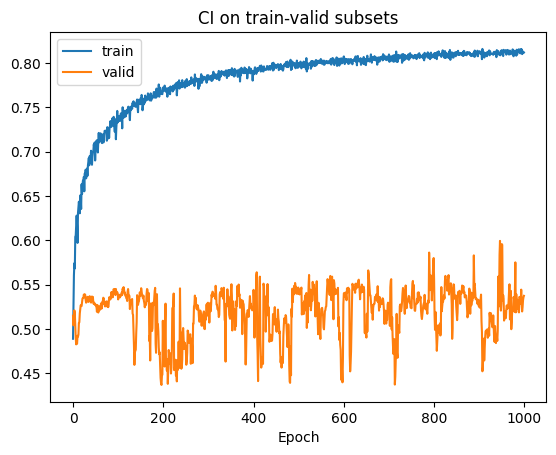

In [14]:
plt.plot(history.history[f'{data_type}_cindex_score'], label='train')
plt.plot(history.history[f'val_{data_type}_cindex_score'], label='valid')
plt.xlabel('Epoch')
plt.title('CI on train-valid subsets')
plt.legend()

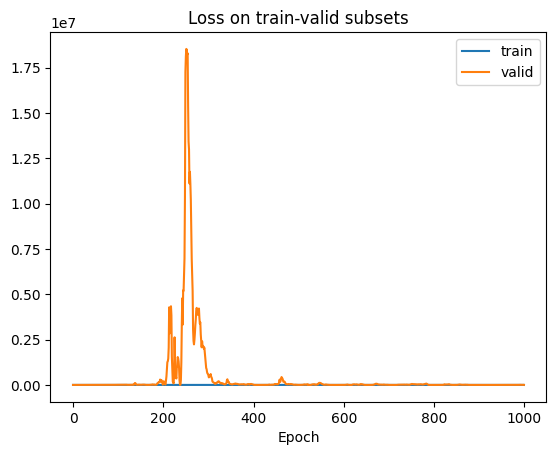

In [15]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.xlabel('Epoch')
plt.title('Loss on train-valid subsets')
plt.legend()

In [16]:
test_batch_size = mlt.training_utils.get_batch_size(X_test.shape[0])
test_batch_size

220

In [17]:
test_gen = mlt.datagen.DataGen(X_test,
                               map_drug,
                               map_protein,
                               shuffle=False,
                               test_only=True, 
                               drug_graph_mode=True)

test_gen = test_gen.get_generator(test_batch_size)

In [18]:
prediction = model.predict(test_gen,
                           steps=X_test.shape[0] // test_batch_size,
                           verbose=1)

30/30 [==============================] - 4s 133ms/step


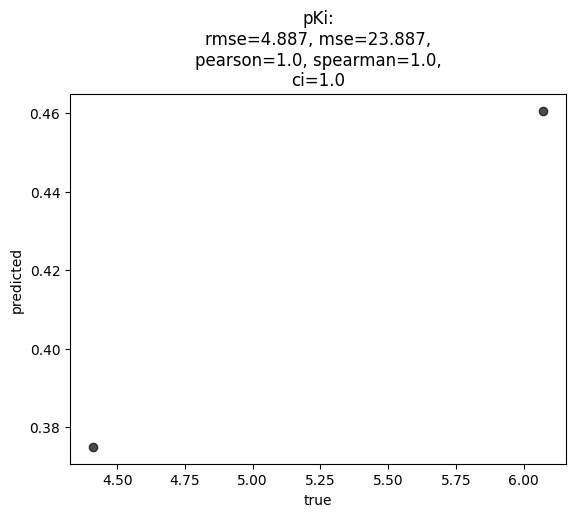

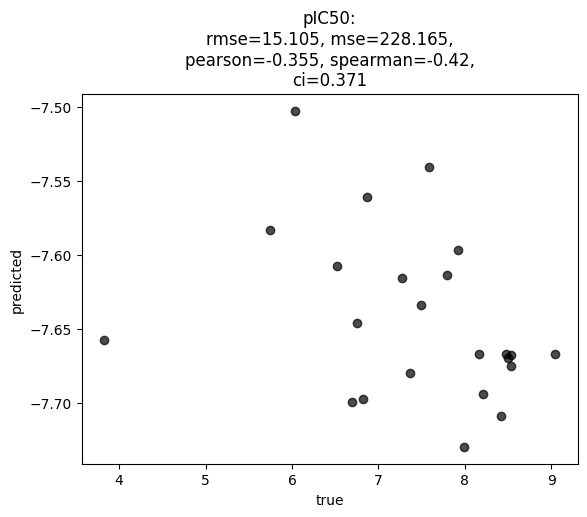

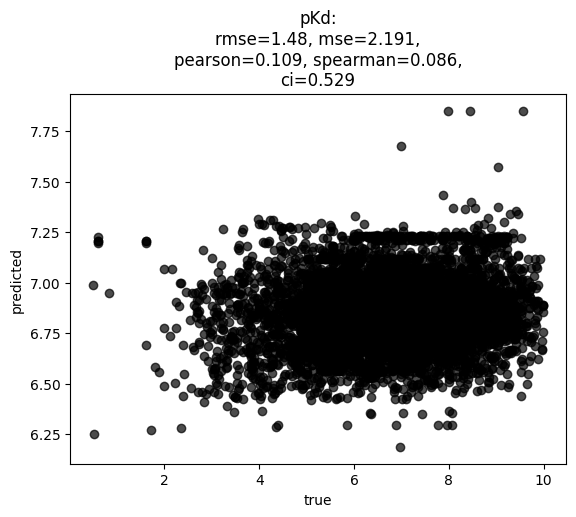

Empty set test set for: pEC50, values sum = 7.567030709125595
or zero concordand pairs for the set of length 1, length of values set = 1


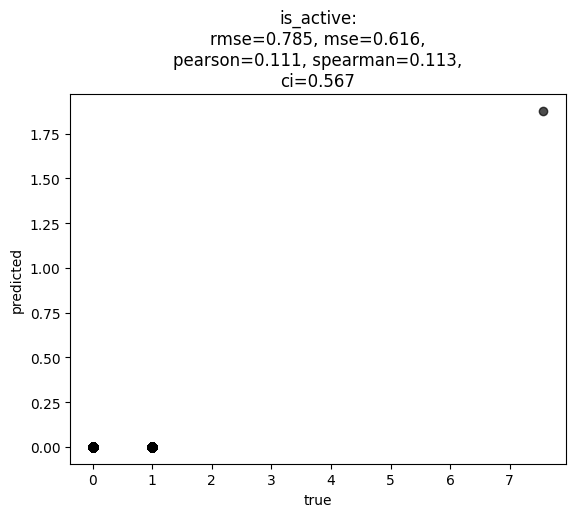

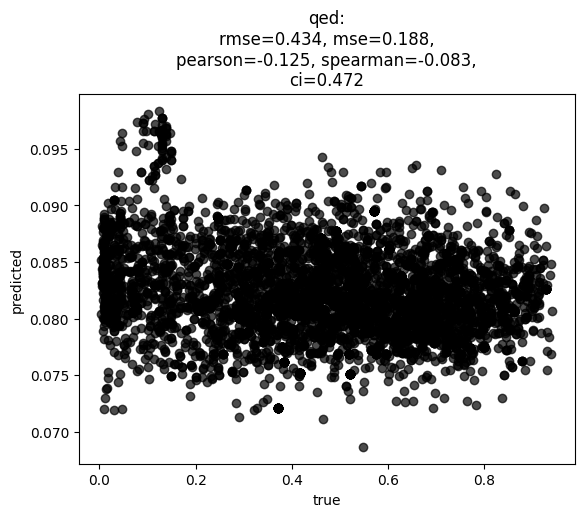

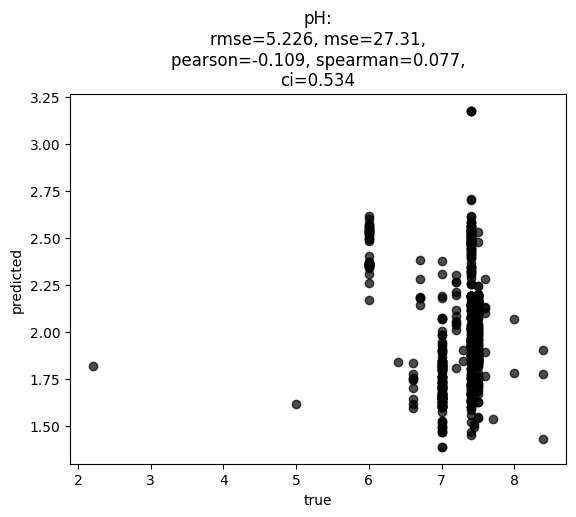

In [19]:
for k, col in enumerate(order):
    try:
        plt.scatter(X_test[col], prediction[k], alpha=0.7, c='k')
        plt.xlabel('true')
        plt.ylabel('predicted')
        y_true = X_test[col][X_test[col].notna()]
        y_pred = prediction[k][X_test[col].notna()].ravel()
        plt.title(col + ":\n" + mlt.training_utils.get_scores(y_true, y_pred))
        plt.show()
    except (ValueError, ZeroDivisionError) as e:
        print(f'Empty set test set for: {col}, values sum = {X_test[col].sum()}')
        print(f'or zero concordand pairs for the set of length 1, length of values set = {X_test[col].notna().sum()}')